# Overview

With increasing research in Deep Learning, Computer Vision, and Natural Language Processing, we have seen new advancements in these fields, image captioning being one of them. This notebook is attempt to apply image captioning with Visual Attention, as described in “Show, Attend and Tell: Neural Image Caption Generation with Visual Attention” and how I used the model architecture described in their paper to generate findings of Chest X Rays.

Link to the paper: https://arxiv.org/abs/1502.03044

# Model Architecture

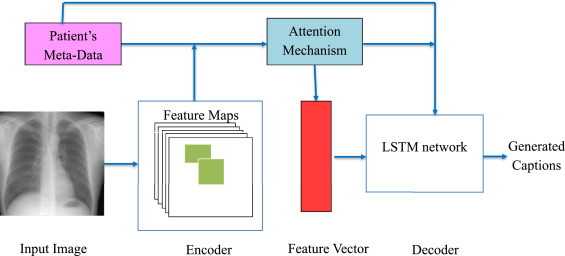

# About Dataset

The datasets used for this project are the National Institute of Health Chest X-Ray Dataset to train the CNN feature extractor model (CheXNet) and the Chest X-rays (Indiana University) dataset to train the model with the captions.

#### Highlights of this notebook:
1. Image Feature Extraction, using CheXNet.
2. Text Pre-Processing and Cleaning.
3. Building Caption Generation Model Architecture. 
4. Model Evaluation.

This Notebook is running using Accelerator of type GPU T4 x2.

## <font size=4 color='blue'>If you find this notebook useful, leave an upvote, that motivates me to write more such notebooks.</font>

## 1. Loading Libraries and Dataset. 

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os

In [2]:
image_path = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized/"
images = glob(image_path + "*.png")
len(images)

7470

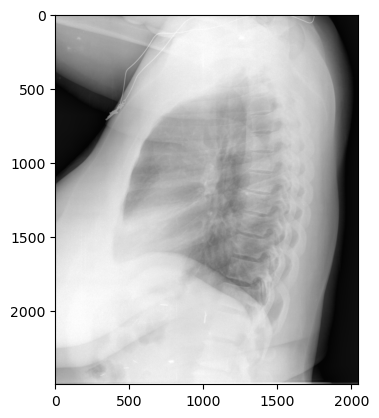

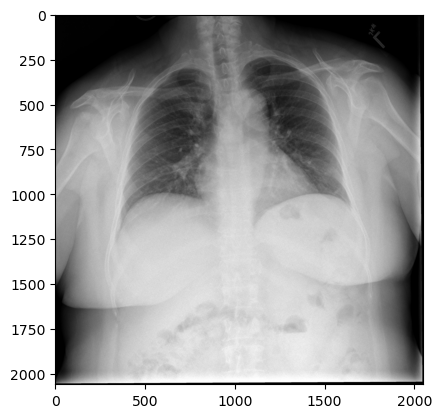

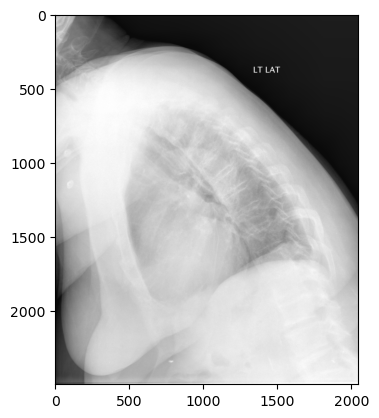

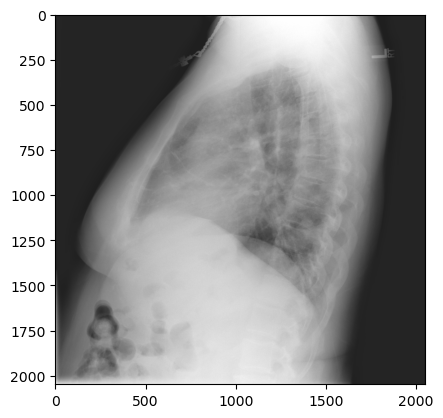

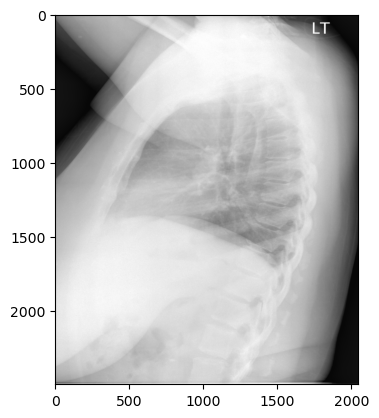

In [3]:
for i in range(5):
    plt.figure()
    image = cv2.imread(images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

## 2. Creating Image, Caption Dictionary.

In [4]:
import re
# Read in the projections data
projections = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')

# Read in the reports data
reports = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')

# Define the path to the images folder
images_folder = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'

# Merge the projections and reports data on the UID column
reports = pd.merge(projections, reports, on='uid')

# Create a dictionary of image filenames and their corresponding captions
data = {}
for i in range(len(reports)):
    filename = reports.loc[i, 'filename']
    caption = reports.loc[i, 'impression']
    if filename not in data:
        data[filename] = []
    if isinstance(caption, str) and re.match(r'^\d+\.', caption):
        data[filename].append(caption.split('. ')[1])
    else:
        if data[filename]:
            data[filename][-1] += " " + caption
        else:
            data[filename].append(caption)

## 3. Captions Pre-Processing.

In [5]:
def cleanse_data(data):
    dict_2 = dict()
    for key, value in data.items():
        for i in range(len(value)):
            lines = ""
            line1 = value[i]
            if isinstance(line1, str):
                for j in line1.split():
                    if len(j) < 2:
                        continue
                    j = j.lower()
                    lines += j + " "
                if key not in dict_2:
                    dict_2[key] = list()
                dict_2[key].append(lines)
    return dict_2

data2 = cleanse_data(data)
print(len(data2))

7414


In [6]:
# convert the following into a vocabulary of words and calculate the total words

def vocabulary(data2):
    all_desc = set()
    for key in data2.keys():
        [all_desc.update(d.split()) for d in data2[key]]
    return all_desc

# summarize vocabulary
vocabulary_data = vocabulary(data2)
print(len(vocabulary_data))

1891


In [7]:
def save_dict(data2, filename):
    lines = list()
    for key, value in data2.items():
        for desc in value:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_dict(data2, 'captions1.txt')

## 4. Images Feature Exraction.

In [8]:
#images = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'
#img = glob(images + '*.png')
#print(len(img))

#def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    #img = keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    #x = keras.preprocessing.image.img_to_array(img)
    # Add one more dimension
    #x = np.expand_dims(x, axis=0)
    # pre-process the images using preprocess_input() from inception module
    #x = tf.keras.applications.xception.preprocess_input(x)
    #return x

In [9]:
#from keras.applications.xception import Xception
#from keras.models import Model

# Load the Xception model
#input1 = Xception(weights='imagenet')

# Create a new model, by removing the last layer (output layer) from the Xception model
#model = Model(input1.input, input1.layers[-2].output)

#model.summary()

In [10]:
# Function to encode a given image into a vector of size (2048, )
#def encode(image):
    #image = preprocess(image) # preprocess the image
    #fea_vec = model.predict(image) # Get the encoding vector for the image
    #fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    #return fea_vec
    
#encoding = {}

#for i in tqdm(img):
    #encoding[i[len(images):]] = encode(i)
    
#import pickle

# Save the features in the images1 pickle file
#with open("images1.pkl", "wb") as encoded_pickle:
    #pickle.dump(encoding, encoded_pickle)

In [11]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from keras.layers import Flatten, Concatenate, Dropout, BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
import numpy as np
import pickle
import os
from tqdm import tqdm
from tensorflow.keras.utils import load_img, img_to_array

def chexnet(input_shape=(224,224,3), weights_path=None):
    input_layer = Input(shape=input_shape, name='input_1')
    densenet = DenseNet121(weights=None, include_top=False, input_tensor=input_layer)

    if weights_path is not None:
        densenet.load_weights(weights_path, by_name=True)

    x = densenet.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(14, activation='sigmoid', kernel_regularizer=l2(0.0001))(x)
    model = Model(inputs=densenet.input, outputs=predictions)

    return model

# Define the input shape of the model
input_shape = (224, 224, 3)

# Load the pre-trained CheXNet model
base_model = chexnet(input_shape=input_shape, weights_path='/kaggle/input/chexnet-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

# Function to encode a given image into a vector
def encode(image):
    image = preprocess_input(image) # preprocess the image
    fea_vec = base_model.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape
    return fea_vec

# Define the directory containing the chest X-ray images
img_dir = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'

# Get a list of all the image filenames in the directory
img_list = os.listdir(img_dir)

encoding = {}

for img_filename in tqdm(img_list):
    # Load the image from the file
    img_path = os.path.join(img_dir, img_filename)
    img = load_img(img_path, target_size=input_shape[:2])
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Encode the image and store the encoding vector
    encoding[img_filename] = encode(x)

# Save the encoding vectors as a pickle file
with open("encodings.pkl", "wb") as f:
    pickle.dump(encoding, f)

  0%|          | 0/7470 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


  0%|          | 1/7470 [00:12<26:09:25, 12.61s/it]

1/1 [==============================] - 0s 40ms/step


  0%|          | 2/7470 [00:12<10:59:41,  5.30s/it]

1/1 [==============================] - 0s 40ms/step


  0%|          | 3/7470 [00:12<6:06:31,  2.95s/it] 

1/1 [==============================] - 0s 40ms/step


  0%|          | 4/7470 [00:13<3:48:17,  1.83s/it]

1/1 [==============================] - 0s 39ms/step


  0%|          | 5/7470 [00:13<2:34:09,  1.24s/it]

1/1 [==============================] - 0s 41ms/step


  0%|          | 6/7470 [00:13<1:50:00,  1.13it/s]

1/1 [==============================] - 0s 52ms/step


  0%|          | 7/7470 [00:13<1:25:53,  1.45it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 8/7470 [00:13<1:05:18,  1.90it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 9/7470 [00:14<51:00,  2.44it/s]  

1/1 [==============================] - 0s 40ms/step


  0%|          | 10/7470 [00:14<43:54,  2.83it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 11/7470 [00:14<37:28,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 12/7470 [00:14<34:12,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 13/7470 [00:14<32:25,  3.83it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 14/7470 [00:15<30:38,  4.05it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 15/7470 [00:15<27:37,  4.50it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 16/7470 [00:15<27:22,  4.54it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 17/7470 [00:15<25:10,  4.93it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 18/7470 [00:15<25:17,  4.91it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 19/7470 [00:16<25:50,  4.81it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 20/7470 [00:16<25:30,  4.87it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 21/7470 [00:16<25:41,  4.83it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 22/7470 [00:16<23:36,  5.26it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 23/7470 [00:16<23:55,  5.19it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 24/7470 [00:17<23:39,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 25/7470 [00:17<22:39,  5.48it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 26/7470 [00:17<23:01,  5.39it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 27/7470 [00:17<22:16,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 28/7470 [00:17<21:23,  5.80it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 29/7470 [00:17<22:30,  5.51it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 30/7470 [00:18<22:42,  5.46it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 31/7470 [00:18<25:24,  4.88it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 32/7470 [00:18<23:06,  5.36it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 33/7470 [00:18<22:15,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 34/7470 [00:18<22:46,  5.44it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 35/7470 [00:19<24:04,  5.15it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 36/7470 [00:19<22:05,  5.61it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 37/7470 [00:19<21:04,  5.88it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 38/7470 [00:19<20:46,  5.96it/s]

1/1 [==============================] - 0s 61ms/step


  1%|          | 39/7470 [00:19<24:33,  5.04it/s]

1/1 [==============================] - 0s 58ms/step


  1%|          | 40/7470 [00:20<26:05,  4.75it/s]

1/1 [==============================] - 0s 60ms/step


  1%|          | 41/7470 [00:20<27:16,  4.54it/s]

1/1 [==============================] - 0s 55ms/step


  1%|          | 42/7470 [00:20<27:25,  4.51it/s]

1/1 [==============================] - 0s 55ms/step


  1%|          | 43/7470 [00:20<27:46,  4.46it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 44/7470 [00:20<27:26,  4.51it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 45/7470 [00:21<26:07,  4.74it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 46/7470 [00:21<23:42,  5.22it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 47/7470 [00:21<24:15,  5.10it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 48/7470 [00:21<24:22,  5.07it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 49/7470 [00:21<23:58,  5.16it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 50/7470 [00:22<22:16,  5.55it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 51/7470 [00:22<21:55,  5.64it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 52/7470 [00:22<22:51,  5.41it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 53/7470 [00:22<23:38,  5.23it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 54/7470 [00:22<24:27,  5.05it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 55/7470 [00:22<22:47,  5.42it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 56/7470 [00:23<22:48,  5.42it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 57/7470 [00:23<21:15,  5.81it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 58/7470 [00:23<21:53,  5.64it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 59/7470 [00:23<22:43,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 60/7470 [00:23<22:03,  5.60it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 61/7470 [00:24<21:35,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 62/7470 [00:24<22:26,  5.50it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 63/7470 [00:24<24:18,  5.08it/s]

1/1 [==============================] - 0s 47ms/step


  1%|          | 64/7470 [00:24<25:25,  4.85it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 65/7470 [00:24<23:56,  5.16it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 66/7470 [00:25<22:37,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 67/7470 [00:25<21:55,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 68/7470 [00:25<20:53,  5.90it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 69/7470 [00:25<22:47,  5.41it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 70/7470 [00:25<22:53,  5.39it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 71/7470 [00:25<23:00,  5.36it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 72/7470 [00:26<21:39,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 73/7470 [00:26<23:13,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 74/7470 [00:26<23:09,  5.32it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 75/7470 [00:26<21:47,  5.65it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 76/7470 [00:26<21:15,  5.80it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 77/7470 [00:26<21:38,  5.70it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 78/7470 [00:27<22:30,  5.47it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 79/7470 [00:27<23:23,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 80/7470 [00:27<22:15,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 81/7470 [00:27<21:17,  5.78it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 82/7470 [00:27<21:40,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 83/7470 [00:28<23:41,  5.20it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 84/7470 [00:28<23:51,  5.16it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 85/7470 [00:28<22:40,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 86/7470 [00:28<22:51,  5.38it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 87/7470 [00:28<21:37,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 88/7470 [00:28<21:06,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 89/7470 [00:29<20:25,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 90/7470 [00:29<20:26,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 91/7470 [00:29<20:10,  6.10it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 92/7470 [00:29<20:10,  6.10it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 93/7470 [00:29<19:43,  6.23it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 94/7470 [00:29<20:39,  5.95it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▏         | 95/7470 [00:30<19:55,  6.17it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 96/7470 [00:30<20:58,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 97/7470 [00:30<20:07,  6.11it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 98/7470 [00:30<21:14,  5.78it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▏         | 99/7470 [00:30<21:12,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▏         | 100/7470 [00:31<23:29,  5.23it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 101/7470 [00:31<24:07,  5.09it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▏         | 102/7470 [00:31<24:17,  5.05it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▏         | 103/7470 [00:31<24:16,  5.06it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▏         | 104/7470 [00:31<23:00,  5.34it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 105/7470 [00:31<22:07,  5.55it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▏         | 106/7470 [00:32<23:18,  5.27it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▏         | 107/7470 [00:32<24:30,  5.01it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 108/7470 [00:32<24:54,  4.92it/s]

1/1 [==============================] - 0s 41ms/step


  1%|▏         | 109/7470 [00:32<23:03,  5.32it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▏         | 110/7470 [00:32<21:43,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 111/7470 [00:33<21:51,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 112/7470 [00:33<22:21,  5.48it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 113/7470 [00:33<22:23,  5.47it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 114/7470 [00:33<22:44,  5.39it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 115/7470 [00:33<21:29,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 116/7470 [00:33<20:24,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 117/7470 [00:34<20:23,  6.01it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 118/7470 [00:34<21:48,  5.62it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 119/7470 [00:34<22:40,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 120/7470 [00:34<21:15,  5.76it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 121/7470 [00:34<20:09,  6.08it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 122/7470 [00:34<19:34,  6.26it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 123/7470 [00:35<20:43,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 124/7470 [00:35<22:10,  5.52it/s]

1/1 [==============================] - 0s 79ms/step


  2%|▏         | 125/7470 [00:35<25:35,  4.78it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 126/7470 [00:35<25:34,  4.79it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 127/7470 [00:36<25:47,  4.74it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 128/7470 [00:36<25:24,  4.81it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 129/7470 [00:36<23:19,  5.24it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 130/7470 [00:36<23:46,  5.15it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 131/7470 [00:36<23:19,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 132/7470 [00:37<23:05,  5.29it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 133/7470 [00:37<22:22,  5.47it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 134/7470 [00:37<23:17,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 135/7470 [00:37<22:17,  5.49it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 136/7470 [00:37<23:10,  5.27it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 137/7470 [00:37<23:02,  5.30it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 138/7470 [00:38<23:12,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 139/7470 [00:38<23:17,  5.25it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 140/7470 [00:38<22:23,  5.46it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 141/7470 [00:38<22:58,  5.32it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 142/7470 [00:38<21:30,  5.68it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 143/7470 [00:39<23:01,  5.30it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 144/7470 [00:39<23:18,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 145/7470 [00:39<21:57,  5.56it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 146/7470 [00:39<22:11,  5.50it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 147/7470 [00:39<21:36,  5.65it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 148/7470 [00:39<23:53,  5.11it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 149/7470 [00:40<24:30,  4.98it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 150/7470 [00:40<25:12,  4.84it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 151/7470 [00:40<25:14,  4.83it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 152/7470 [00:40<24:15,  5.03it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 153/7470 [00:41<24:13,  5.03it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 154/7470 [00:41<23:07,  5.27it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 155/7470 [00:41<21:57,  5.55it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 156/7470 [00:41<22:12,  5.49it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 157/7470 [00:41<22:48,  5.35it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 158/7470 [00:41<22:10,  5.49it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 159/7470 [00:42<22:48,  5.34it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 160/7470 [00:42<22:23,  5.44it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 161/7470 [00:42<22:30,  5.41it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 162/7470 [00:42<23:06,  5.27it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 163/7470 [00:42<22:28,  5.42it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 164/7470 [00:43<22:29,  5.42it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 165/7470 [00:43<21:30,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 166/7470 [00:43<21:05,  5.77it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 167/7470 [00:43<21:49,  5.58it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 168/7470 [00:43<22:03,  5.52it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 169/7470 [00:43<20:51,  5.83it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 170/7470 [00:44<23:12,  5.24it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 171/7470 [00:44<23:20,  5.21it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 172/7470 [00:44<23:00,  5.29it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 173/7470 [00:44<23:12,  5.24it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 174/7470 [00:45<30:01,  4.05it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 175/7470 [00:45<28:19,  4.29it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 176/7470 [00:45<27:10,  4.47it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 177/7470 [00:45<25:22,  4.79it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 178/7470 [00:45<25:53,  4.69it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 179/7470 [00:46<25:10,  4.83it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 180/7470 [00:46<24:32,  4.95it/s]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 181/7470 [00:46<25:49,  4.70it/s]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 182/7470 [00:46<27:40,  4.39it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 183/7470 [00:46<26:33,  4.57it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 184/7470 [00:47<26:17,  4.62it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 185/7470 [00:47<26:39,  4.55it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 186/7470 [00:47<24:46,  4.90it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 187/7470 [00:47<24:27,  4.96it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 188/7470 [00:47<24:36,  4.93it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 189/7470 [00:48<24:09,  5.02it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 190/7470 [00:48<22:57,  5.29it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 191/7470 [00:48<21:39,  5.60it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 192/7470 [00:48<22:41,  5.35it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 193/7470 [00:48<23:24,  5.18it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 194/7470 [00:49<23:03,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 195/7470 [00:49<21:41,  5.59it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 196/7470 [00:49<23:08,  5.24it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 197/7470 [00:49<22:54,  5.29it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 198/7470 [00:49<22:34,  5.37it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 199/7470 [00:49<22:44,  5.33it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 200/7470 [00:50<21:59,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 201/7470 [00:50<23:05,  5.25it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 202/7470 [00:50<23:07,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 203/7470 [00:50<22:09,  5.47it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 204/7470 [00:50<21:42,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 205/7470 [00:51<22:32,  5.37it/s]

1/1 [==============================] - 0s 61ms/step


  3%|▎         | 206/7470 [00:51<24:14,  5.00it/s]

1/1 [==============================] - 0s 55ms/step


  3%|▎         | 207/7470 [00:51<28:07,  4.30it/s]

1/1 [==============================] - 0s 60ms/step


  3%|▎         | 208/7470 [00:51<28:13,  4.29it/s]

1/1 [==============================] - 0s 56ms/step


  3%|▎         | 209/7470 [00:52<28:07,  4.30it/s]

1/1 [==============================] - 0s 54ms/step


  3%|▎         | 210/7470 [00:52<27:15,  4.44it/s]

1/1 [==============================] - 0s 67ms/step


  3%|▎         | 211/7470 [00:52<26:19,  4.60it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 212/7470 [00:52<25:11,  4.80it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 213/7470 [00:52<24:39,  4.90it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 214/7470 [00:53<23:27,  5.15it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 215/7470 [00:53<21:54,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 216/7470 [00:53<22:02,  5.49it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 217/7470 [00:53<22:06,  5.47it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 218/7470 [00:53<22:10,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 219/7470 [00:53<21:57,  5.51it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 220/7470 [00:54<21:17,  5.67it/s]

1/1 [==============================] - 0s 50ms/step


  3%|▎         | 221/7470 [00:54<22:25,  5.39it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 222/7470 [00:54<22:05,  5.47it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 223/7470 [00:54<22:56,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 224/7470 [00:54<21:47,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 225/7470 [00:55<21:11,  5.70it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 226/7470 [00:55<21:19,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 227/7470 [00:55<22:16,  5.42it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 228/7470 [00:55<23:05,  5.23it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 229/7470 [00:55<22:55,  5.26it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 230/7470 [00:56<24:20,  4.96it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 231/7470 [00:56<23:40,  5.10it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 232/7470 [00:56<23:09,  5.21it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 233/7470 [00:56<23:35,  5.11it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 234/7470 [00:56<22:50,  5.28it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 235/7470 [00:56<22:16,  5.41it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 236/7470 [00:57<22:31,  5.35it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 237/7470 [00:57<23:12,  5.20it/s]

1/1 [==============================] - 0s 95ms/step


  3%|▎         | 238/7470 [00:57<24:09,  4.99it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 239/7470 [00:57<24:53,  4.84it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 240/7470 [00:57<24:45,  4.87it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 241/7470 [00:58<24:53,  4.84it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 242/7470 [00:58<25:49,  4.67it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 243/7470 [00:58<26:51,  4.48it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 244/7470 [00:58<26:22,  4.57it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 245/7470 [00:59<25:44,  4.68it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 246/7470 [00:59<25:10,  4.78it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 247/7470 [00:59<24:40,  4.88it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 248/7470 [00:59<24:29,  4.92it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 249/7470 [00:59<23:01,  5.23it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 250/7470 [01:00<23:26,  5.13it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 251/7470 [01:00<23:08,  5.20it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 252/7470 [01:00<22:16,  5.40it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 253/7470 [01:00<21:35,  5.57it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 254/7470 [01:00<21:19,  5.64it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 255/7470 [01:00<23:10,  5.19it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 256/7470 [01:01<23:03,  5.21it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 257/7470 [01:01<22:57,  5.24it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 258/7470 [01:01<23:33,  5.10it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 259/7470 [01:01<22:27,  5.35it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 260/7470 [01:01<21:46,  5.52it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 261/7470 [01:02<22:04,  5.44it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▎         | 262/7470 [01:02<20:23,  5.89it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▎         | 263/7470 [01:02<21:29,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▎         | 264/7470 [01:02<22:26,  5.35it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▎         | 265/7470 [01:02<22:33,  5.32it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▎         | 266/7470 [01:02<21:57,  5.47it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▎         | 267/7470 [01:03<22:49,  5.26it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▎         | 268/7470 [01:03<22:43,  5.28it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▎         | 269/7470 [01:03<23:58,  5.01it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▎         | 270/7470 [01:03<22:12,  5.40it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▎         | 271/7470 [01:03<23:02,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▎         | 272/7470 [01:04<21:32,  5.57it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▎         | 273/7470 [01:04<22:14,  5.40it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▎         | 274/7470 [01:04<23:08,  5.18it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▎         | 275/7470 [01:04<23:40,  5.06it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▎         | 276/7470 [01:04<23:26,  5.12it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▎         | 277/7470 [01:05<22:29,  5.33it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▎         | 278/7470 [01:05<21:44,  5.51it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▎         | 279/7470 [01:05<21:03,  5.69it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▎         | 280/7470 [01:05<20:58,  5.71it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 281/7470 [01:05<20:49,  5.75it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 282/7470 [01:05<19:59,  5.99it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 283/7470 [01:06<21:35,  5.55it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 284/7470 [01:06<22:36,  5.30it/s]

1/1 [==============================] - 0s 84ms/step


  4%|▍         | 285/7470 [01:06<23:41,  5.05it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 286/7470 [01:06<22:47,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 287/7470 [01:06<23:21,  5.12it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 288/7470 [01:07<22:26,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 289/7470 [01:07<22:32,  5.31it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 290/7470 [01:07<22:12,  5.39it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 291/7470 [01:07<22:00,  5.44it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 292/7470 [01:07<21:30,  5.56it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 293/7470 [01:07<21:59,  5.44it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 294/7470 [01:08<22:02,  5.43it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 295/7470 [01:08<21:08,  5.66it/s]

1/1 [==============================] - 0s 88ms/step


  4%|▍         | 296/7470 [01:08<22:18,  5.36it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 297/7470 [01:08<23:48,  5.02it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 298/7470 [01:08<23:31,  5.08it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 299/7470 [01:09<22:54,  5.22it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 300/7470 [01:09<23:39,  5.05it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 301/7470 [01:09<23:46,  5.03it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 302/7470 [01:09<24:42,  4.84it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 303/7470 [01:09<24:39,  4.84it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 304/7470 [01:10<22:50,  5.23it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 305/7470 [01:10<21:12,  5.63it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 306/7470 [01:10<22:38,  5.27it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 307/7470 [01:10<23:16,  5.13it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 308/7470 [01:10<23:22,  5.11it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 309/7470 [01:11<22:21,  5.34it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 310/7470 [01:11<20:47,  5.74it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 311/7470 [01:11<20:45,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 312/7470 [01:11<20:33,  5.80it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 313/7470 [01:11<20:26,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 314/7470 [01:11<20:42,  5.76it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 315/7470 [01:12<21:40,  5.50it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 316/7470 [01:12<22:23,  5.32it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 317/7470 [01:12<20:58,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 318/7470 [01:12<19:44,  6.04it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 319/7470 [01:12<21:38,  5.51it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 320/7470 [01:13<22:36,  5.27it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 321/7470 [01:13<23:36,  5.05it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 322/7470 [01:13<23:56,  4.97it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 323/7470 [01:13<23:43,  5.02it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 324/7470 [01:13<23:53,  4.99it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 325/7470 [01:14<24:06,  4.94it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 326/7470 [01:14<24:03,  4.95it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 327/7470 [01:14<24:23,  4.88it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 328/7470 [01:14<23:59,  4.96it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 329/7470 [01:14<22:25,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 330/7470 [01:14<21:19,  5.58it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 331/7470 [01:15<21:32,  5.52it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 332/7470 [01:15<22:05,  5.38it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 333/7470 [01:15<20:56,  5.68it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 334/7470 [01:15<21:51,  5.44it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 335/7470 [01:15<21:24,  5.56it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 336/7470 [01:16<20:41,  5.74it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▍         | 337/7470 [01:16<21:44,  5.47it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▍         | 338/7470 [01:16<23:48,  4.99it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 339/7470 [01:16<25:02,  4.75it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 340/7470 [01:16<24:32,  4.84it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▍         | 341/7470 [01:17<23:04,  5.15it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 342/7470 [01:17<23:15,  5.11it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 343/7470 [01:17<23:13,  5.11it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 344/7470 [01:17<22:01,  5.39it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 345/7470 [01:17<21:25,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 346/7470 [01:18<22:17,  5.33it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 347/7470 [01:18<22:25,  5.29it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 348/7470 [01:18<21:01,  5.64it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 349/7470 [01:18<21:08,  5.61it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 350/7470 [01:18<21:12,  5.60it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 351/7470 [01:18<21:26,  5.53it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 352/7470 [01:19<21:00,  5.65it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 353/7470 [01:19<20:06,  5.90it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 354/7470 [01:19<21:44,  5.45it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 355/7470 [01:19<23:53,  4.96it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 356/7470 [01:19<23:56,  4.95it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 357/7470 [01:20<24:01,  4.93it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 358/7470 [01:20<22:28,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 359/7470 [01:20<22:59,  5.16it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 360/7470 [01:20<21:27,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 361/7470 [01:20<20:06,  5.89it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 362/7470 [01:20<19:43,  6.01it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 363/7470 [01:21<20:43,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 364/7470 [01:21<20:13,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 365/7470 [01:21<21:54,  5.41it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 366/7470 [01:21<22:48,  5.19it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 367/7470 [01:21<23:02,  5.14it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 368/7470 [01:22<22:07,  5.35it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 369/7470 [01:22<20:50,  5.68it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 370/7470 [01:22<20:01,  5.91it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 371/7470 [01:22<20:36,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 372/7470 [01:22<20:23,  5.80it/s]

1/1 [==============================] - 0s 69ms/step


  5%|▍         | 373/7470 [01:22<23:08,  5.11it/s]

1/1 [==============================] - 0s 70ms/step


  5%|▌         | 374/7470 [01:23<24:49,  4.76it/s]

1/1 [==============================] - 0s 65ms/step


  5%|▌         | 375/7470 [01:23<27:05,  4.36it/s]

1/1 [==============================] - 0s 61ms/step


  5%|▌         | 376/7470 [01:23<26:58,  4.38it/s]

1/1 [==============================] - 0s 57ms/step


  5%|▌         | 377/7470 [01:23<26:11,  4.51it/s]

1/1 [==============================] - 0s 54ms/step


  5%|▌         | 378/7470 [01:24<27:18,  4.33it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 379/7470 [01:24<26:01,  4.54it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 380/7470 [01:24<24:09,  4.89it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 381/7470 [01:24<24:49,  4.76it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 382/7470 [01:24<23:28,  5.03it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 383/7470 [01:25<22:38,  5.22it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 384/7470 [01:25<21:14,  5.56it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 385/7470 [01:25<21:53,  5.39it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 386/7470 [01:25<20:37,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 387/7470 [01:25<20:37,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 388/7470 [01:25<20:13,  5.84it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 389/7470 [01:26<21:25,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 390/7470 [01:26<20:21,  5.80it/s]

1/1 [==============================] - 0s 50ms/step


  5%|▌         | 391/7470 [01:26<21:55,  5.38it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 392/7470 [01:26<20:38,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 393/7470 [01:26<20:13,  5.83it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 394/7470 [01:27<21:21,  5.52it/s]

1/1 [==============================] - 0s 43ms/step


  5%|▌         | 395/7470 [01:27<20:50,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 396/7470 [01:27<21:43,  5.43it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 397/7470 [01:27<21:07,  5.58it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 398/7470 [01:27<21:58,  5.36it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 399/7470 [01:27<22:21,  5.27it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 400/7470 [01:28<20:52,  5.64it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 401/7470 [01:28<21:42,  5.43it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 402/7470 [01:28<20:31,  5.74it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 403/7470 [01:28<21:20,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 404/7470 [01:28<21:08,  5.57it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 405/7470 [01:29<20:29,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 406/7470 [01:29<20:23,  5.78it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 407/7470 [01:29<20:52,  5.64it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 408/7470 [01:29<20:24,  5.77it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 409/7470 [01:29<21:30,  5.47it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 410/7470 [01:29<22:04,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 411/7470 [01:30<22:42,  5.18it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 412/7470 [01:30<23:41,  4.97it/s]

1/1 [==============================] - 0s 83ms/step


  6%|▌         | 413/7470 [01:30<24:27,  4.81it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 414/7470 [01:30<23:06,  5.09it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 415/7470 [01:30<21:33,  5.46it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 416/7470 [01:31<21:53,  5.37it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 417/7470 [01:31<22:13,  5.29it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 418/7470 [01:31<21:05,  5.57it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 419/7470 [01:31<22:13,  5.29it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 420/7470 [01:31<22:55,  5.12it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 421/7470 [01:32<23:02,  5.10it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 422/7470 [01:32<23:01,  5.10it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 423/7470 [01:32<22:32,  5.21it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 424/7470 [01:32<21:19,  5.51it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 425/7470 [01:32<21:31,  5.45it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 426/7470 [01:33<22:14,  5.28it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 427/7470 [01:33<20:51,  5.63it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 428/7470 [01:33<21:30,  5.46it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 429/7470 [01:33<22:20,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 430/7470 [01:33<22:20,  5.25it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 431/7470 [01:33<21:26,  5.47it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 432/7470 [01:34<22:15,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 433/7470 [01:34<23:04,  5.08it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 434/7470 [01:34<22:13,  5.27it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 435/7470 [01:34<23:12,  5.05it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 436/7470 [01:34<23:10,  5.06it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 437/7470 [01:35<22:53,  5.12it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 438/7470 [01:35<23:25,  5.00it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 439/7470 [01:35<23:39,  4.95it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 440/7470 [01:35<22:01,  5.32it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 441/7470 [01:35<22:22,  5.23it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 442/7470 [01:36<21:43,  5.39it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 443/7470 [01:36<20:38,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 444/7470 [01:36<22:12,  5.27it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 445/7470 [01:36<21:18,  5.49it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 446/7470 [01:36<20:28,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 447/7470 [01:36<20:00,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 448/7470 [01:37<20:27,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 449/7470 [01:37<19:29,  6.00it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 450/7470 [01:37<20:40,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 451/7470 [01:37<21:01,  5.56it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 452/7470 [01:37<20:52,  5.60it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 453/7470 [01:37<21:04,  5.55it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 454/7470 [01:38<22:23,  5.22it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 455/7470 [01:38<22:18,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 456/7470 [01:38<22:34,  5.18it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 457/7470 [01:38<22:47,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 458/7470 [01:39<22:58,  5.09it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 459/7470 [01:39<21:45,  5.37it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 460/7470 [01:39<22:36,  5.17it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 461/7470 [01:39<22:42,  5.14it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 462/7470 [01:39<21:52,  5.34it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 463/7470 [01:39<21:05,  5.53it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 464/7470 [01:40<21:33,  5.42it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 465/7470 [01:40<20:30,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 466/7470 [01:40<20:43,  5.63it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▋         | 467/7470 [01:40<19:24,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▋         | 468/7470 [01:40<19:08,  6.10it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▋         | 469/7470 [01:40<19:06,  6.11it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▋         | 470/7470 [01:41<20:31,  5.68it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▋         | 471/7470 [01:41<21:10,  5.51it/s]

1/1 [==============================] - 0s 65ms/step


  6%|▋         | 472/7470 [01:41<21:47,  5.35it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▋         | 473/7470 [01:41<24:20,  4.79it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▋         | 474/7470 [01:41<23:46,  4.90it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▋         | 475/7470 [01:42<22:37,  5.15it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▋         | 476/7470 [01:42<22:48,  5.11it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▋         | 477/7470 [01:42<22:37,  5.15it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▋         | 478/7470 [01:42<23:03,  5.05it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▋         | 479/7470 [01:42<21:13,  5.49it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▋         | 480/7470 [01:43<20:34,  5.66it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▋         | 481/7470 [01:43<21:08,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▋         | 482/7470 [01:43<21:24,  5.44it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▋         | 483/7470 [01:43<21:12,  5.49it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▋         | 484/7470 [01:43<21:25,  5.43it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▋         | 485/7470 [01:43<21:07,  5.51it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 486/7470 [01:44<20:26,  5.69it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 487/7470 [01:44<21:39,  5.37it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 488/7470 [01:44<22:37,  5.14it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 489/7470 [01:44<22:37,  5.14it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 490/7470 [01:44<21:12,  5.49it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 491/7470 [01:45<21:58,  5.29it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 492/7470 [01:45<21:56,  5.30it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 493/7470 [01:45<22:53,  5.08it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 494/7470 [01:45<21:57,  5.29it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 495/7470 [01:45<21:10,  5.49it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 496/7470 [01:46<20:55,  5.56it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 497/7470 [01:46<20:19,  5.72it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 498/7470 [01:46<21:23,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 499/7470 [01:46<22:05,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 500/7470 [01:46<21:21,  5.44it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 501/7470 [01:46<20:16,  5.73it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 502/7470 [01:47<20:31,  5.66it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 503/7470 [01:47<19:56,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 504/7470 [01:47<20:13,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 505/7470 [01:47<21:03,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 506/7470 [01:47<20:55,  5.55it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 507/7470 [01:47<21:11,  5.47it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 508/7470 [01:48<20:39,  5.62it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 509/7470 [01:48<20:58,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 510/7470 [01:48<20:31,  5.65it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 511/7470 [01:48<19:42,  5.89it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 512/7470 [01:48<19:55,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 513/7470 [01:48<19:34,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 514/7470 [01:49<20:26,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 515/7470 [01:49<21:07,  5.49it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 516/7470 [01:49<21:14,  5.46it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 517/7470 [01:49<21:36,  5.36it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 518/7470 [01:49<20:45,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 519/7470 [01:50<21:42,  5.34it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 520/7470 [01:50<20:18,  5.70it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 521/7470 [01:50<20:53,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 522/7470 [01:50<20:59,  5.51it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 523/7470 [01:50<21:04,  5.49it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 524/7470 [01:51<22:45,  5.09it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 525/7470 [01:51<22:27,  5.15it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 526/7470 [01:51<23:07,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 527/7470 [01:51<23:38,  4.89it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 528/7470 [01:51<24:18,  4.76it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 529/7470 [01:52<21:47,  5.31it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 530/7470 [01:52<20:17,  5.70it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 531/7470 [01:52<19:02,  6.08it/s]

1/1 [==============================] - 0s 91ms/step


  7%|▋         | 532/7470 [01:52<21:20,  5.42it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 533/7470 [01:52<21:57,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 534/7470 [01:52<21:10,  5.46it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 535/7470 [01:53<20:35,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 536/7470 [01:53<21:19,  5.42it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 537/7470 [01:53<20:24,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 538/7470 [01:53<19:35,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 539/7470 [01:53<20:05,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 540/7470 [01:53<20:25,  5.65it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 541/7470 [01:54<19:59,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 542/7470 [01:54<20:54,  5.52it/s]

1/1 [==============================] - 0s 95ms/step


  7%|▋         | 543/7470 [01:54<24:17,  4.75it/s]

1/1 [==============================] - 0s 61ms/step


  7%|▋         | 544/7470 [01:54<24:45,  4.66it/s]

1/1 [==============================] - 0s 73ms/step


  7%|▋         | 545/7470 [01:55<26:58,  4.28it/s]

1/1 [==============================] - 0s 52ms/step


  7%|▋         | 546/7470 [01:55<27:28,  4.20it/s]

1/1 [==============================] - 0s 56ms/step


  7%|▋         | 547/7470 [01:55<25:58,  4.44it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 548/7470 [01:55<25:47,  4.47it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 549/7470 [01:56<25:39,  4.50it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 550/7470 [01:56<24:56,  4.62it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 551/7470 [01:56<22:27,  5.14it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 552/7470 [01:56<22:08,  5.21it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 553/7470 [01:56<22:13,  5.19it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 554/7470 [01:56<22:12,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 555/7470 [01:57<21:14,  5.43it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 556/7470 [01:57<19:54,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 557/7470 [01:57<21:01,  5.48it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 558/7470 [01:57<21:40,  5.32it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 559/7470 [01:57<22:17,  5.17it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 560/7470 [01:58<20:45,  5.55it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 561/7470 [01:58<19:46,  5.82it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 562/7470 [01:58<19:20,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 563/7470 [01:58<19:53,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 564/7470 [01:58<19:24,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 565/7470 [01:58<18:40,  6.16it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 566/7470 [01:59<19:55,  5.78it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 567/7470 [01:59<20:50,  5.52it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 568/7470 [01:59<21:08,  5.44it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 569/7470 [01:59<21:17,  5.40it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 570/7470 [01:59<20:19,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 571/7470 [01:59<21:10,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 572/7470 [02:00<22:00,  5.22it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 573/7470 [02:00<20:24,  5.63it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 574/7470 [02:00<20:54,  5.50it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 575/7470 [02:00<21:38,  5.31it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 576/7470 [02:00<22:43,  5.06it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 577/7470 [02:01<23:27,  4.90it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 578/7470 [02:01<21:54,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 579/7470 [02:01<21:04,  5.45it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 580/7470 [02:01<21:21,  5.38it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 581/7470 [02:01<22:38,  5.07it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 582/7470 [02:02<21:01,  5.46it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 583/7470 [02:02<21:31,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 584/7470 [02:02<22:03,  5.20it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 585/7470 [02:02<22:03,  5.20it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 586/7470 [02:02<22:53,  5.01it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 587/7470 [02:03<23:12,  4.94it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 588/7470 [02:03<23:27,  4.89it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 589/7470 [02:03<22:47,  5.03it/s]

1/1 [==============================] - 0s 57ms/step


  8%|▊         | 590/7470 [02:03<24:42,  4.64it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 591/7470 [02:03<25:12,  4.55it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 592/7470 [02:04<23:00,  4.98it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 593/7470 [02:04<21:38,  5.30it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 594/7470 [02:04<22:08,  5.17it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 595/7470 [02:04<21:28,  5.34it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 596/7470 [02:04<21:24,  5.35it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 597/7470 [02:04<20:58,  5.46it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 598/7470 [02:05<22:16,  5.14it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 599/7470 [02:05<21:16,  5.38it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 600/7470 [02:05<20:49,  5.50it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 601/7470 [02:05<21:03,  5.44it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 602/7470 [02:05<22:02,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 603/7470 [02:06<20:44,  5.52it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 604/7470 [02:06<19:29,  5.87it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 605/7470 [02:06<20:02,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 606/7470 [02:06<22:34,  5.07it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 607/7470 [02:06<23:39,  4.84it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 608/7470 [02:07<23:44,  4.82it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 609/7470 [02:07<22:27,  5.09it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 610/7470 [02:07<23:19,  4.90it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 611/7470 [02:07<22:54,  4.99it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 612/7470 [02:07<22:20,  5.12it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 613/7470 [02:08<23:25,  4.88it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 614/7470 [02:08<23:05,  4.95it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 615/7470 [02:08<23:31,  4.86it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 616/7470 [02:08<23:08,  4.94it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 617/7470 [02:08<22:35,  5.06it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 618/7470 [02:09<24:02,  4.75it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 619/7470 [02:09<25:46,  4.43it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 620/7470 [02:09<27:39,  4.13it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 621/7470 [02:09<27:20,  4.18it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 622/7470 [02:10<26:22,  4.33it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 623/7470 [02:10<27:50,  4.10it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 624/7470 [02:10<26:25,  4.32it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 625/7470 [02:10<25:36,  4.45it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 626/7470 [02:11<27:01,  4.22it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 627/7470 [02:11<25:07,  4.54it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 628/7470 [02:11<23:08,  4.93it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 629/7470 [02:11<25:38,  4.45it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 630/7470 [02:11<23:31,  4.85it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 631/7470 [02:12<22:41,  5.02it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 632/7470 [02:12<24:39,  4.62it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 633/7470 [02:12<23:26,  4.86it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 634/7470 [02:12<23:11,  4.91it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▊         | 635/7470 [02:12<22:35,  5.04it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▊         | 636/7470 [02:13<24:18,  4.68it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▊         | 637/7470 [02:13<24:11,  4.71it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▊         | 638/7470 [02:13<24:14,  4.70it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▊         | 639/7470 [02:13<24:32,  4.64it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▊         | 640/7470 [02:13<22:53,  4.97it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▊         | 641/7470 [02:14<23:54,  4.76it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▊         | 642/7470 [02:14<26:24,  4.31it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▊         | 643/7470 [02:14<28:43,  3.96it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▊         | 644/7470 [02:14<27:59,  4.06it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▊         | 645/7470 [02:15<26:20,  4.32it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▊         | 646/7470 [02:15<28:39,  3.97it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▊         | 647/7470 [02:15<27:55,  4.07it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▊         | 648/7470 [02:15<29:43,  3.82it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▊         | 649/7470 [02:16<30:05,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▊         | 650/7470 [02:16<31:35,  3.60it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▊         | 651/7470 [02:16<30:34,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▊         | 652/7470 [02:17<28:20,  4.01it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▊         | 653/7470 [02:17<28:01,  4.05it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 654/7470 [02:17<27:35,  4.12it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 655/7470 [02:17<27:58,  4.06it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 656/7470 [02:17<27:57,  4.06it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 657/7470 [02:18<27:30,  4.13it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 658/7470 [02:18<27:47,  4.09it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 659/7470 [02:18<27:35,  4.11it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 660/7470 [02:18<26:49,  4.23it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 661/7470 [02:19<25:47,  4.40it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 662/7470 [02:19<24:23,  4.65it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 663/7470 [02:19<25:32,  4.44it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 664/7470 [02:19<23:37,  4.80it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 665/7470 [02:19<23:55,  4.74it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 666/7470 [02:20<22:33,  5.03it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 667/7470 [02:20<23:20,  4.86it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 668/7470 [02:20<23:25,  4.84it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 669/7470 [02:20<23:39,  4.79it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 670/7470 [02:20<23:28,  4.83it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 671/7470 [02:21<22:11,  5.11it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 672/7470 [02:21<21:30,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 673/7470 [02:21<22:26,  5.05it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 674/7470 [02:21<22:46,  4.97it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 675/7470 [02:21<22:34,  5.02it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 676/7470 [02:22<22:18,  5.07it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 677/7470 [02:22<21:40,  5.22it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 678/7470 [02:22<20:54,  5.41it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 679/7470 [02:22<21:31,  5.26it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 680/7470 [02:22<20:00,  5.66it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 681/7470 [02:23<19:27,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 682/7470 [02:23<19:37,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 683/7470 [02:23<22:20,  5.06it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 684/7470 [02:23<21:25,  5.28it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 685/7470 [02:23<21:50,  5.18it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 686/7470 [02:24<22:42,  4.98it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 687/7470 [02:24<22:43,  4.97it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 688/7470 [02:24<23:38,  4.78it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 689/7470 [02:24<23:40,  4.77it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 690/7470 [02:24<24:01,  4.70it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 691/7470 [02:25<23:14,  4.86it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 692/7470 [02:25<22:12,  5.08it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 693/7470 [02:25<22:15,  5.07it/s]

1/1 [==============================] - 0s 60ms/step


  9%|▉         | 694/7470 [02:25<23:44,  4.76it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 695/7470 [02:25<21:55,  5.15it/s]

1/1 [==============================] - 0s 52ms/step


  9%|▉         | 696/7470 [02:26<21:45,  5.19it/s]

1/1 [==============================] - 0s 66ms/step


  9%|▉         | 697/7470 [02:26<22:55,  4.92it/s]

1/1 [==============================] - 0s 91ms/step


  9%|▉         | 698/7470 [02:26<25:36,  4.41it/s]

1/1 [==============================] - 0s 59ms/step


  9%|▉         | 699/7470 [02:26<24:49,  4.55it/s]

1/1 [==============================] - 0s 58ms/step


  9%|▉         | 700/7470 [02:26<25:12,  4.48it/s]

1/1 [==============================] - 0s 59ms/step


  9%|▉         | 701/7470 [02:27<24:41,  4.57it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 702/7470 [02:27<25:02,  4.50it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 703/7470 [02:27<24:09,  4.67it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 704/7470 [02:27<22:20,  5.05it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 705/7470 [02:27<22:37,  4.98it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 706/7470 [02:28<22:28,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 707/7470 [02:28<22:17,  5.06it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 708/7470 [02:28<24:05,  4.68it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 709/7470 [02:28<22:28,  5.01it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 710/7470 [02:28<20:43,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 711/7470 [02:29<20:48,  5.41it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 712/7470 [02:29<20:34,  5.47it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 713/7470 [02:29<19:38,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 714/7470 [02:29<18:50,  5.98it/s]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 715/7470 [02:29<20:13,  5.57it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 716/7470 [02:29<20:08,  5.59it/s]

1/1 [==============================] - 0s 42ms/step


 10%|▉         | 717/7470 [02:30<20:50,  5.40it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 718/7470 [02:30<21:51,  5.15it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 719/7470 [02:30<22:07,  5.08it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 720/7470 [02:30<21:05,  5.33it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 721/7470 [02:30<20:16,  5.55it/s]

1/1 [==============================] - 0s 42ms/step


 10%|▉         | 722/7470 [02:31<20:57,  5.36it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 723/7470 [02:31<20:41,  5.43it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 724/7470 [02:31<19:34,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 725/7470 [02:31<19:52,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 726/7470 [02:31<19:24,  5.79it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 727/7470 [02:31<19:24,  5.79it/s]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 728/7470 [02:32<19:17,  5.83it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 729/7470 [02:32<19:59,  5.62it/s]

1/1 [==============================] - 0s 42ms/step


 10%|▉         | 730/7470 [02:32<20:41,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 731/7470 [02:32<20:01,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 732/7470 [02:32<19:17,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 733/7470 [02:33<18:49,  5.97it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 734/7470 [02:33<18:10,  6.18it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 735/7470 [02:33<18:08,  6.19it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 736/7470 [02:33<19:06,  5.87it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 737/7470 [02:33<18:42,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 738/7470 [02:33<20:00,  5.61it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 739/7470 [02:34<19:50,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 740/7470 [02:34<20:12,  5.55it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 741/7470 [02:34<20:36,  5.44it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 742/7470 [02:34<21:13,  5.28it/s]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 743/7470 [02:34<21:46,  5.15it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 744/7470 [02:35<20:29,  5.47it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 745/7470 [02:35<21:17,  5.26it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 746/7470 [02:35<21:44,  5.15it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 747/7470 [02:35<20:36,  5.44it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 748/7470 [02:35<21:18,  5.26it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 749/7470 [02:35<19:49,  5.65it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 750/7470 [02:36<20:32,  5.45it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 751/7470 [02:36<19:29,  5.74it/s]

1/1 [==============================] - 0s 66ms/step


 10%|█         | 752/7470 [02:36<21:13,  5.28it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 753/7470 [02:36<23:24,  4.78it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 754/7470 [02:36<21:49,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 755/7470 [02:37<21:55,  5.10it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 756/7470 [02:37<22:22,  5.00it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 757/7470 [02:37<22:55,  4.88it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 758/7470 [02:37<20:51,  5.36it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 759/7470 [02:37<19:45,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 760/7470 [02:38<20:00,  5.59it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 761/7470 [02:38<19:07,  5.85it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 762/7470 [02:38<20:46,  5.38it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 763/7470 [02:38<19:49,  5.64it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 764/7470 [02:38<20:09,  5.54it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 765/7470 [02:38<21:01,  5.32it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 766/7470 [02:39<20:40,  5.40it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 767/7470 [02:39<21:14,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 768/7470 [02:39<19:39,  5.68it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 769/7470 [02:39<20:00,  5.58it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 770/7470 [02:39<19:09,  5.83it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 771/7470 [02:39<19:07,  5.84it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 772/7470 [02:40<18:32,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 773/7470 [02:40<19:22,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 774/7470 [02:40<20:55,  5.33it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 775/7470 [02:40<20:57,  5.32it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 776/7470 [02:40<19:46,  5.64it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 777/7470 [02:41<19:43,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 778/7470 [02:41<20:10,  5.53it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 779/7470 [02:41<19:13,  5.80it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 780/7470 [02:41<19:01,  5.86it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 781/7470 [02:41<20:28,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 782/7470 [02:41<20:52,  5.34it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 783/7470 [02:42<20:37,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 784/7470 [02:42<19:59,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 785/7470 [02:42<20:23,  5.46it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 786/7470 [02:42<20:28,  5.44it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 787/7470 [02:42<21:09,  5.26it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 788/7470 [02:43<19:58,  5.57it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 789/7470 [02:43<20:41,  5.38it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 790/7470 [02:43<20:44,  5.37it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 791/7470 [02:43<20:16,  5.49it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 792/7470 [02:43<21:34,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 793/7470 [02:44<20:29,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 794/7470 [02:44<21:50,  5.09it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 795/7470 [02:44<22:01,  5.05it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 796/7470 [02:44<20:47,  5.35it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 797/7470 [02:44<20:11,  5.51it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 798/7470 [02:44<19:23,  5.73it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 799/7470 [02:45<19:47,  5.62it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 800/7470 [02:45<19:57,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 801/7470 [02:45<20:26,  5.44it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 802/7470 [02:45<19:59,  5.56it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 803/7470 [02:45<20:45,  5.35it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 804/7470 [02:46<22:00,  5.05it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 805/7470 [02:46<21:53,  5.07it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 806/7470 [02:46<22:01,  5.04it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 807/7470 [02:46<22:53,  4.85it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 808/7470 [02:46<22:53,  4.85it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 809/7470 [02:47<22:47,  4.87it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 810/7470 [02:47<22:03,  5.03it/s]

1/1 [==============================] - 0s 48ms/step


 11%|█         | 811/7470 [02:47<22:09,  5.01it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 812/7470 [02:47<23:56,  4.63it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 813/7470 [02:47<22:23,  4.95it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 814/7470 [02:48<22:35,  4.91it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 815/7470 [02:48<21:17,  5.21it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 816/7470 [02:48<21:04,  5.26it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 817/7470 [02:48<21:38,  5.12it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 818/7470 [02:48<21:20,  5.20it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 819/7470 [02:49<20:36,  5.38it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 820/7470 [02:49<20:34,  5.39it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 821/7470 [02:49<20:38,  5.37it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 822/7470 [02:49<20:03,  5.53it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 823/7470 [02:49<20:03,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 824/7470 [02:49<20:27,  5.42it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 825/7470 [02:50<19:50,  5.58it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 826/7470 [02:50<20:21,  5.44it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 827/7470 [02:50<19:53,  5.57it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 828/7470 [02:50<19:16,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 829/7470 [02:50<20:03,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 830/7470 [02:51<19:16,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 831/7470 [02:51<19:06,  5.79it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 832/7470 [02:51<18:54,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 833/7470 [02:51<19:34,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 834/7470 [02:51<18:49,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 835/7470 [02:51<18:39,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 836/7470 [02:52<19:00,  5.82it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 837/7470 [02:52<18:48,  5.88it/s]

1/1 [==============================] - 0s 60ms/step


 11%|█         | 838/7470 [02:52<21:34,  5.12it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 839/7470 [02:52<20:32,  5.38it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 840/7470 [02:52<19:16,  5.74it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█▏        | 841/7470 [02:52<19:57,  5.54it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█▏        | 842/7470 [02:53<20:34,  5.37it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█▏        | 843/7470 [02:53<21:26,  5.15it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█▏        | 844/7470 [02:53<21:05,  5.24it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█▏        | 845/7470 [02:53<20:06,  5.49it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█▏        | 846/7470 [02:53<19:58,  5.53it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█▏        | 847/7470 [02:54<20:16,  5.44it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█▏        | 848/7470 [02:54<20:39,  5.34it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█▏        | 849/7470 [02:54<21:26,  5.15it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█▏        | 850/7470 [02:54<22:29,  4.91it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█▏        | 851/7470 [02:54<22:33,  4.89it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 852/7470 [02:55<22:38,  4.87it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 853/7470 [02:55<20:55,  5.27it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█▏        | 854/7470 [02:55<19:40,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 855/7470 [02:55<19:12,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 856/7470 [02:55<20:21,  5.41it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█▏        | 857/7470 [02:55<19:33,  5.63it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█▏        | 858/7470 [02:56<18:54,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█▏        | 859/7470 [02:56<19:04,  5.78it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 860/7470 [02:56<19:00,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 861/7470 [02:56<19:49,  5.56it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 862/7470 [02:56<19:24,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 863/7470 [02:57<19:45,  5.57it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 864/7470 [02:57<20:41,  5.32it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 865/7470 [02:57<20:46,  5.30it/s]

1/1 [==============================] - 0s 61ms/step


 12%|█▏        | 866/7470 [02:57<21:48,  5.05it/s]

1/1 [==============================] - 0s 77ms/step


 12%|█▏        | 867/7470 [02:57<23:19,  4.72it/s]

1/1 [==============================] - 0s 80ms/step


 12%|█▏        | 868/7470 [02:58<23:48,  4.62it/s]

1/1 [==============================] - 0s 61ms/step


 12%|█▏        | 869/7470 [02:58<24:59,  4.40it/s]

1/1 [==============================] - 0s 88ms/step


 12%|█▏        | 870/7470 [02:58<27:06,  4.06it/s]

1/1 [==============================] - 0s 57ms/step


 12%|█▏        | 871/7470 [02:58<28:24,  3.87it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 872/7470 [02:59<24:59,  4.40it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 873/7470 [02:59<24:26,  4.50it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 874/7470 [02:59<21:57,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 875/7470 [02:59<21:50,  5.03it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 876/7470 [02:59<20:10,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 877/7470 [03:00<20:42,  5.31it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 878/7470 [03:00<20:40,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 879/7470 [03:00<20:42,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 880/7470 [03:00<21:14,  5.17it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 881/7470 [03:00<20:02,  5.48it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 882/7470 [03:00<18:46,  5.85it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 883/7470 [03:01<20:05,  5.46it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 884/7470 [03:01<21:24,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 885/7470 [03:01<21:53,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 886/7470 [03:01<20:40,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 887/7470 [03:01<20:26,  5.37it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 888/7470 [03:02<19:18,  5.68it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 889/7470 [03:02<21:01,  5.22it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 890/7470 [03:02<21:42,  5.05it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 891/7470 [03:02<22:52,  4.80it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 892/7470 [03:02<23:39,  4.63it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 893/7470 [03:03<21:57,  4.99it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 894/7470 [03:03<20:53,  5.25it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 895/7470 [03:03<20:46,  5.28it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 896/7470 [03:03<21:12,  5.17it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 897/7470 [03:03<20:17,  5.40it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 898/7470 [03:04<20:17,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 899/7470 [03:04<20:32,  5.33it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 900/7470 [03:04<21:17,  5.14it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 901/7470 [03:04<21:36,  5.07it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 902/7470 [03:04<21:13,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 903/7470 [03:04<20:48,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 904/7470 [03:05<21:11,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 905/7470 [03:05<21:15,  5.15it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 906/7470 [03:05<21:31,  5.08it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 907/7470 [03:05<20:30,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 908/7470 [03:05<19:07,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 909/7470 [03:06<18:33,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 910/7470 [03:06<19:25,  5.63it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 911/7470 [03:06<20:34,  5.31it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 912/7470 [03:06<21:24,  5.11it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 913/7470 [03:06<21:31,  5.08it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 914/7470 [03:07<20:57,  5.21it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 915/7470 [03:07<21:17,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 916/7470 [03:07<20:49,  5.24it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 917/7470 [03:07<20:47,  5.25it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 918/7470 [03:07<20:37,  5.29it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 919/7470 [03:07<19:40,  5.55it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 920/7470 [03:08<19:07,  5.71it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 921/7470 [03:08<19:03,  5.73it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 922/7470 [03:08<18:17,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 923/7470 [03:08<17:34,  6.21it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 924/7470 [03:08<18:18,  5.96it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 925/7470 [03:09<19:52,  5.49it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 926/7470 [03:09<20:23,  5.35it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 927/7470 [03:09<19:04,  5.72it/s]

1/1 [==============================] - 0s 84ms/step


 12%|█▏        | 928/7470 [03:09<21:38,  5.04it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 929/7470 [03:09<21:53,  4.98it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 930/7470 [03:10<21:53,  4.98it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 931/7470 [03:10<25:14,  4.32it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 932/7470 [03:10<25:16,  4.31it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 933/7470 [03:10<25:25,  4.29it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 934/7470 [03:11<27:32,  3.96it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 935/7470 [03:11<27:30,  3.96it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 936/7470 [03:11<24:09,  4.51it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 937/7470 [03:11<22:52,  4.76it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 938/7470 [03:11<21:55,  4.97it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 939/7470 [03:12<20:58,  5.19it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 940/7470 [03:12<20:54,  5.21it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 941/7470 [03:12<20:37,  5.28it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 942/7470 [03:12<20:52,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 943/7470 [03:12<21:12,  5.13it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 944/7470 [03:12<20:55,  5.20it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 945/7470 [03:13<19:35,  5.55it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 946/7470 [03:13<20:24,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 947/7470 [03:13<20:42,  5.25it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 948/7470 [03:13<19:57,  5.45it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 949/7470 [03:13<20:18,  5.35it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 950/7470 [03:14<19:25,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 951/7470 [03:14<18:28,  5.88it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 952/7470 [03:14<18:34,  5.85it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 953/7470 [03:14<19:13,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 954/7470 [03:14<19:51,  5.47it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 955/7470 [03:14<20:11,  5.38it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 956/7470 [03:15<20:29,  5.30it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 957/7470 [03:15<23:58,  4.53it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 958/7470 [03:15<24:51,  4.37it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 959/7470 [03:16<27:24,  3.96it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 960/7470 [03:16<25:06,  4.32it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 961/7470 [03:16<23:18,  4.65it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 962/7470 [03:16<22:56,  4.73it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 963/7470 [03:16<22:46,  4.76it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 964/7470 [03:16<20:52,  5.20it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 965/7470 [03:17<22:03,  4.92it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 966/7470 [03:17<22:10,  4.89it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 967/7470 [03:17<20:55,  5.18it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 968/7470 [03:17<20:21,  5.32it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 969/7470 [03:17<19:24,  5.58it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 970/7470 [03:18<20:01,  5.41it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 971/7470 [03:18<21:14,  5.10it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 972/7470 [03:18<21:03,  5.14it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 973/7470 [03:18<19:32,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 974/7470 [03:18<20:18,  5.33it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 975/7470 [03:19<20:19,  5.33it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 976/7470 [03:19<20:16,  5.34it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 977/7470 [03:19<20:55,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 978/7470 [03:19<19:41,  5.49it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 979/7470 [03:19<19:21,  5.59it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 980/7470 [03:19<19:38,  5.51it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 981/7470 [03:20<20:13,  5.35it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 982/7470 [03:20<20:48,  5.20it/s]

1/1 [==============================] - 0s 79ms/step


 13%|█▎        | 983/7470 [03:20<21:41,  4.99it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 984/7470 [03:20<22:34,  4.79it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 985/7470 [03:20<22:02,  4.90it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 986/7470 [03:21<21:34,  5.01it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 987/7470 [03:21<21:42,  4.98it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 988/7470 [03:21<19:59,  5.41it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 989/7470 [03:21<20:29,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 990/7470 [03:21<18:59,  5.69it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 991/7470 [03:22<19:04,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 992/7470 [03:22<19:35,  5.51it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 993/7470 [03:22<19:35,  5.51it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 994/7470 [03:22<20:28,  5.27it/s]

1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 995/7470 [03:22<23:22,  4.62it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 996/7470 [03:23<22:29,  4.80it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 997/7470 [03:23<20:59,  5.14it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 998/7470 [03:23<20:32,  5.25it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 999/7470 [03:23<19:41,  5.48it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 1000/7470 [03:23<18:46,  5.74it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 1001/7470 [03:23<18:27,  5.84it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 1002/7470 [03:24<20:32,  5.25it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 1003/7470 [03:24<19:32,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 1004/7470 [03:24<18:53,  5.70it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 1005/7470 [03:24<19:14,  5.60it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 1006/7470 [03:24<19:51,  5.42it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 1007/7470 [03:25<18:51,  5.71it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 1008/7470 [03:25<18:21,  5.87it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▎        | 1009/7470 [03:25<19:37,  5.49it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▎        | 1010/7470 [03:25<20:32,  5.24it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▎        | 1011/7470 [03:25<21:24,  5.03it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▎        | 1012/7470 [03:26<21:54,  4.91it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▎        | 1013/7470 [03:26<21:40,  4.97it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▎        | 1014/7470 [03:26<21:29,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▎        | 1015/7470 [03:26<19:56,  5.39it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▎        | 1016/7470 [03:26<19:21,  5.56it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▎        | 1017/7470 [03:26<19:56,  5.39it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▎        | 1018/7470 [03:27<19:01,  5.65it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▎        | 1019/7470 [03:27<18:16,  5.89it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▎        | 1020/7470 [03:27<18:38,  5.77it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▎        | 1021/7470 [03:27<19:29,  5.51it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▎        | 1022/7470 [03:27<20:22,  5.27it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▎        | 1023/7470 [03:28<20:52,  5.15it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▎        | 1024/7470 [03:28<19:30,  5.51it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▎        | 1025/7470 [03:28<18:42,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▎        | 1026/7470 [03:28<19:41,  5.45it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▎        | 1027/7470 [03:28<20:08,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 1028/7470 [03:28<19:09,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 1029/7470 [03:29<19:46,  5.43it/s]

1/1 [==============================] - 0s 74ms/step


 14%|█▍        | 1030/7470 [03:29<21:37,  4.97it/s]

1/1 [==============================] - 0s 57ms/step


 14%|█▍        | 1031/7470 [03:29<22:14,  4.83it/s]

1/1 [==============================] - 0s 51ms/step


 14%|█▍        | 1032/7470 [03:29<22:18,  4.81it/s]

1/1 [==============================] - 0s 56ms/step


 14%|█▍        | 1033/7470 [03:30<23:27,  4.57it/s]

1/1 [==============================] - 0s 56ms/step


 14%|█▍        | 1034/7470 [03:30<23:32,  4.56it/s]

1/1 [==============================] - 0s 61ms/step


 14%|█▍        | 1035/7470 [03:30<23:47,  4.51it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 1036/7470 [03:30<22:53,  4.68it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 1037/7470 [03:30<23:12,  4.62it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 1038/7470 [03:31<21:15,  5.04it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 1039/7470 [03:31<21:00,  5.10it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 1040/7470 [03:31<21:06,  5.08it/s]

1/1 [==============================] - 0s 59ms/step


 14%|█▍        | 1041/7470 [03:31<23:09,  4.63it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 1042/7470 [03:31<21:20,  5.02it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 1043/7470 [03:32<21:02,  5.09it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 1044/7470 [03:32<20:43,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 1045/7470 [03:32<20:56,  5.11it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 1046/7470 [03:32<20:53,  5.12it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 1047/7470 [03:32<19:41,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 1048/7470 [03:32<19:15,  5.56it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 1049/7470 [03:33<19:49,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 1050/7470 [03:33<20:12,  5.29it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 1051/7470 [03:33<21:26,  4.99it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 1052/7470 [03:33<21:44,  4.92it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 1053/7470 [03:34<22:21,  4.78it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 1054/7470 [03:34<21:56,  4.87it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 1055/7470 [03:34<22:01,  4.86it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 1056/7470 [03:34<20:55,  5.11it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 1057/7470 [03:34<19:48,  5.40it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 1058/7470 [03:34<20:30,  5.21it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 1059/7470 [03:35<19:57,  5.36it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▍        | 1060/7470 [03:35<19:28,  5.49it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 1061/7470 [03:35<18:48,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 1062/7470 [03:35<19:14,  5.55it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 1063/7470 [03:35<18:34,  5.75it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 1064/7470 [03:35<19:06,  5.59it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 1065/7470 [03:36<19:39,  5.43it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 1066/7470 [03:36<19:09,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 1067/7470 [03:36<20:12,  5.28it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 1068/7470 [03:36<21:13,  5.03it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 1069/7470 [03:37<21:35,  4.94it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 1070/7470 [03:37<22:03,  4.84it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 1071/7470 [03:37<21:32,  4.95it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 1072/7470 [03:37<20:26,  5.21it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 1073/7470 [03:37<20:51,  5.11it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 1074/7470 [03:37<19:21,  5.51it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 1075/7470 [03:38<18:25,  5.78it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 1076/7470 [03:38<17:42,  6.02it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 1077/7470 [03:38<18:15,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 1078/7470 [03:38<17:51,  5.96it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 1079/7470 [03:38<18:30,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 1080/7470 [03:38<19:32,  5.45it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 1081/7470 [03:39<20:09,  5.28it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 1082/7470 [03:39<20:21,  5.23it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 1083/7470 [03:39<19:58,  5.33it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 1084/7470 [03:39<20:07,  5.29it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 1085/7470 [03:39<19:38,  5.42it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 1086/7470 [03:40<19:37,  5.42it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 1087/7470 [03:40<19:06,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 1088/7470 [03:40<19:58,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 1089/7470 [03:40<19:20,  5.50it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 1090/7470 [03:40<20:11,  5.27it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 1091/7470 [03:41<19:50,  5.36it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 1092/7470 [03:41<20:07,  5.28it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 1093/7470 [03:41<20:32,  5.18it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 1094/7470 [03:41<20:14,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 1095/7470 [03:41<20:46,  5.11it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 1096/7470 [03:41<19:29,  5.45it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▍        | 1097/7470 [03:42<18:27,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 1098/7470 [03:42<18:07,  5.86it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 1099/7470 [03:42<18:50,  5.64it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▍        | 1100/7470 [03:42<21:00,  5.05it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 1101/7470 [03:42<20:39,  5.14it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 1102/7470 [03:43<21:19,  4.98it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 1103/7470 [03:43<19:47,  5.36it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 1104/7470 [03:43<20:21,  5.21it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 1105/7470 [03:43<20:26,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 1106/7470 [03:43<20:37,  5.14it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 1107/7470 [03:44<21:31,  4.93it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 1108/7470 [03:44<19:38,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 1109/7470 [03:44<20:14,  5.24it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 1110/7470 [03:44<19:26,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 1111/7470 [03:44<19:29,  5.44it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 1112/7470 [03:45<20:13,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 1113/7470 [03:45<20:16,  5.23it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 1114/7470 [03:45<20:20,  5.21it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 1115/7470 [03:45<21:05,  5.02it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 1116/7470 [03:45<21:34,  4.91it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 1117/7470 [03:45<20:12,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 1118/7470 [03:46<19:04,  5.55it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 1119/7470 [03:46<18:12,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 1120/7470 [03:46<19:52,  5.33it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 1121/7470 [03:46<24:16,  4.36it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 1122/7470 [03:47<24:02,  4.40it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 1123/7470 [03:47<25:03,  4.22it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1124/7470 [03:47<25:57,  4.07it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▌        | 1125/7470 [03:47<25:15,  4.19it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 1126/7470 [03:48<25:33,  4.14it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1127/7470 [03:48<24:57,  4.24it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 1128/7470 [03:48<25:43,  4.11it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 1129/7470 [03:48<25:20,  4.17it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1130/7470 [03:49<25:49,  4.09it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 1131/7470 [03:49<26:05,  4.05it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1132/7470 [03:49<27:51,  3.79it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 1133/7470 [03:49<26:53,  3.93it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 1134/7470 [03:50<28:42,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1135/7470 [03:50<24:51,  4.25it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 1136/7470 [03:50<22:41,  4.65it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1137/7470 [03:50<21:09,  4.99it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 1138/7470 [03:50<20:55,  5.04it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1139/7470 [03:51<21:59,  4.80it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 1140/7470 [03:51<20:20,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 1141/7470 [03:51<20:50,  5.06it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 1142/7470 [03:51<21:09,  4.99it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 1143/7470 [03:51<21:31,  4.90it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 1144/7470 [03:52<20:41,  5.09it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 1145/7470 [03:52<20:55,  5.04it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 1146/7470 [03:52<21:03,  5.01it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 1147/7470 [03:52<20:58,  5.03it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 1148/7470 [03:52<19:47,  5.32it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 1149/7470 [03:52<20:25,  5.16it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▌        | 1150/7470 [03:53<22:46,  4.63it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 1151/7470 [03:53<22:41,  4.64it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▌        | 1152/7470 [03:53<24:50,  4.24it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▌        | 1153/7470 [03:53<23:56,  4.40it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 1154/7470 [03:54<22:44,  4.63it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 1155/7470 [03:54<22:24,  4.70it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 1156/7470 [03:54<22:26,  4.69it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▌        | 1157/7470 [03:54<21:24,  4.91it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1158/7470 [03:54<21:56,  4.79it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1159/7470 [03:55<21:30,  4.89it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1160/7470 [03:55<22:27,  4.68it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▌        | 1161/7470 [03:55<20:30,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1162/7470 [03:55<20:29,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1163/7470 [03:55<19:52,  5.29it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 1164/7470 [03:56<19:01,  5.52it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1165/7470 [03:56<19:27,  5.40it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▌        | 1166/7470 [03:56<19:40,  5.34it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 1167/7470 [03:56<18:33,  5.66it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1168/7470 [03:56<19:28,  5.39it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1169/7470 [03:57<19:57,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1170/7470 [03:57<18:51,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1171/7470 [03:57<20:16,  5.18it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 1172/7470 [03:57<19:18,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 1173/7470 [03:57<18:29,  5.67it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1174/7470 [03:57<18:58,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1175/7470 [03:58<18:22,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1176/7470 [03:58<17:33,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1177/7470 [03:58<16:55,  6.20it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 1178/7470 [03:58<18:16,  5.74it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 1179/7470 [03:58<20:04,  5.22it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1180/7470 [03:58<19:09,  5.47it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1181/7470 [03:59<19:20,  5.42it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 1182/7470 [03:59<19:21,  5.41it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1183/7470 [03:59<18:13,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1184/7470 [03:59<18:55,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1185/7470 [03:59<18:20,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 1186/7470 [04:00<19:40,  5.32it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1187/7470 [04:00<18:46,  5.58it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 1188/7470 [04:00<19:21,  5.41it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1189/7470 [04:00<20:01,  5.23it/s]

1/1 [==============================] - 0s 69ms/step


 16%|█▌        | 1190/7470 [04:00<20:47,  5.03it/s]

1/1 [==============================] - 0s 65ms/step


 16%|█▌        | 1191/7470 [04:01<23:10,  4.51it/s]

1/1 [==============================] - 0s 66ms/step


 16%|█▌        | 1192/7470 [04:01<23:22,  4.48it/s]

1/1 [==============================] - 0s 58ms/step


 16%|█▌        | 1193/7470 [04:01<23:35,  4.43it/s]

1/1 [==============================] - 0s 59ms/step


 16%|█▌        | 1194/7470 [04:01<24:30,  4.27it/s]

1/1 [==============================] - 0s 61ms/step


 16%|█▌        | 1195/7470 [04:02<24:11,  4.32it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1196/7470 [04:02<23:49,  4.39it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 1197/7470 [04:02<23:09,  4.51it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1198/7470 [04:02<22:30,  4.64it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1199/7470 [04:02<20:51,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1200/7470 [04:03<22:11,  4.71it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 1201/7470 [04:03<21:42,  4.81it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 1202/7470 [04:03<21:59,  4.75it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1203/7470 [04:03<21:07,  4.95it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1204/7470 [04:03<22:17,  4.69it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▌        | 1205/7470 [04:04<23:46,  4.39it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1206/7470 [04:04<21:59,  4.75it/s]

1/1 [==============================] - 0s 79ms/step


 16%|█▌        | 1207/7470 [04:04<23:09,  4.51it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1208/7470 [04:04<21:50,  4.78it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 1209/7470 [04:04<20:28,  5.10it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1210/7470 [04:05<19:45,  5.28it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 1211/7470 [04:05<19:39,  5.31it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1212/7470 [04:05<19:08,  5.45it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1213/7470 [04:05<20:00,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▋        | 1214/7470 [04:05<18:47,  5.55it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▋        | 1215/7470 [04:06<19:35,  5.32it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▋        | 1216/7470 [04:06<19:28,  5.35it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▋        | 1217/7470 [04:06<19:39,  5.30it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 1218/7470 [04:06<20:42,  5.03it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▋        | 1219/7470 [04:06<20:53,  4.99it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▋        | 1220/7470 [04:07<21:05,  4.94it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▋        | 1221/7470 [04:07<22:15,  4.68it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▋        | 1222/7470 [04:07<21:31,  4.84it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 1223/7470 [04:07<20:25,  5.10it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▋        | 1224/7470 [04:07<20:32,  5.07it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 1225/7470 [04:08<20:25,  5.10it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▋        | 1226/7470 [04:08<19:38,  5.30it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▋        | 1227/7470 [04:08<20:05,  5.18it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 1228/7470 [04:08<20:16,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▋        | 1229/7470 [04:08<20:25,  5.09it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 1230/7470 [04:09<19:58,  5.21it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 1231/7470 [04:09<19:02,  5.46it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 1232/7470 [04:09<18:36,  5.59it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1233/7470 [04:09<17:52,  5.82it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1234/7470 [04:09<17:20,  5.99it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1235/7470 [04:09<17:29,  5.94it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1236/7470 [04:10<18:04,  5.75it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 1237/7470 [04:10<19:34,  5.31it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1238/7470 [04:10<19:36,  5.30it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1239/7470 [04:10<19:31,  5.32it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1240/7470 [04:10<20:27,  5.07it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1241/7470 [04:11<20:15,  5.13it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1242/7470 [04:11<19:09,  5.42it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1243/7470 [04:11<19:34,  5.30it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1244/7470 [04:11<20:15,  5.12it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 1245/7470 [04:11<20:35,  5.04it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 1246/7470 [04:12<20:47,  4.99it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1247/7470 [04:12<19:35,  5.29it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1248/7470 [04:12<19:43,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1249/7470 [04:12<20:30,  5.06it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1250/7470 [04:12<21:33,  4.81it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1251/7470 [04:13<21:03,  4.92it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1252/7470 [04:13<19:40,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1253/7470 [04:13<20:01,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1254/7470 [04:13<19:02,  5.44it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 1255/7470 [04:13<18:32,  5.59it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 1256/7470 [04:13<19:20,  5.35it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1257/7470 [04:14<19:03,  5.43it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1258/7470 [04:14<18:38,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1259/7470 [04:14<18:19,  5.65it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1260/7470 [04:14<18:22,  5.63it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1261/7470 [04:14<18:00,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1262/7470 [04:14<18:04,  5.73it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 1263/7470 [04:15<20:09,  5.13it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 1264/7470 [04:15<20:45,  4.98it/s]

1/1 [==============================] - 0s 74ms/step


 17%|█▋        | 1265/7470 [04:15<22:53,  4.52it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 1266/7470 [04:15<22:26,  4.61it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1267/7470 [04:16<21:38,  4.78it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1268/7470 [04:16<19:55,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1269/7470 [04:16<20:16,  5.10it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1270/7470 [04:16<21:20,  4.84it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1271/7470 [04:16<21:26,  4.82it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1272/7470 [04:17<19:59,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1273/7470 [04:17<18:30,  5.58it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 1274/7470 [04:17<17:34,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1275/7470 [04:17<18:29,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1276/7470 [04:17<19:26,  5.31it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1277/7470 [04:17<20:41,  4.99it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1278/7470 [04:18<24:26,  4.22it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1279/7470 [04:18<26:48,  3.85it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1280/7470 [04:18<25:23,  4.06it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1281/7470 [04:19<25:31,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1282/7470 [04:19<24:58,  4.13it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1283/7470 [04:19<26:34,  3.88it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1284/7470 [04:19<24:57,  4.13it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 1285/7470 [04:20<24:43,  4.17it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1286/7470 [04:20<26:59,  3.82it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1287/7470 [04:20<27:42,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1288/7470 [04:20<25:43,  4.00it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1289/7470 [04:21<29:10,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 1290/7470 [04:21<28:29,  3.62it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 1291/7470 [04:21<26:37,  3.87it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 1292/7470 [04:21<25:50,  3.99it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1293/7470 [04:22<24:27,  4.21it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1294/7470 [04:22<24:04,  4.28it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 1295/7470 [04:22<21:23,  4.81it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1296/7470 [04:22<21:08,  4.87it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1297/7470 [04:22<20:11,  5.09it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 1298/7470 [04:23<19:05,  5.39it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1299/7470 [04:23<20:06,  5.11it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1300/7470 [04:23<21:20,  4.82it/s]

1/1 [==============================] - 0s 56ms/step


 17%|█▋        | 1301/7470 [04:23<22:58,  4.48it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1302/7470 [04:23<23:06,  4.45it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 1303/7470 [04:24<21:06,  4.87it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 1304/7470 [04:24<20:58,  4.90it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1305/7470 [04:24<20:42,  4.96it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1306/7470 [04:24<19:37,  5.24it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 1307/7470 [04:24<20:25,  5.03it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 1308/7470 [04:25<20:59,  4.89it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 1309/7470 [04:25<21:01,  4.89it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 1310/7470 [04:25<24:43,  4.15it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 1311/7470 [04:25<24:18,  4.22it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 1312/7470 [04:26<22:11,  4.62it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 1313/7470 [04:26<22:20,  4.59it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 1314/7470 [04:26<20:23,  5.03it/s]

1/1 [==============================] - 0s 62ms/step


 18%|█▊        | 1315/7470 [04:26<22:13,  4.62it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 1316/7470 [04:26<21:50,  4.70it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 1317/7470 [04:27<20:18,  5.05it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 1318/7470 [04:27<19:01,  5.39it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 1319/7470 [04:27<19:42,  5.20it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 1320/7470 [04:27<19:08,  5.35it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 1321/7470 [04:27<17:57,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 1322/7470 [04:27<17:37,  5.82it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 1323/7470 [04:28<19:43,  5.19it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 1324/7470 [04:28<19:12,  5.33it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 1325/7470 [04:28<18:42,  5.47it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 1326/7470 [04:28<17:58,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 1327/7470 [04:28<17:37,  5.81it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 1328/7470 [04:28<17:12,  5.95it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 1329/7470 [04:29<17:38,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 1330/7470 [04:29<17:15,  5.93it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 1331/7470 [04:29<16:57,  6.04it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 1332/7470 [04:29<16:33,  6.18it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 1333/7470 [04:29<17:00,  6.02it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 1334/7470 [04:29<16:56,  6.03it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 1335/7470 [04:30<18:13,  5.61it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 1336/7470 [04:30<17:38,  5.79it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 1337/7470 [04:30<18:38,  5.48it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 1338/7470 [04:30<19:15,  5.31it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 1339/7470 [04:30<19:26,  5.26it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 1340/7470 [04:31<31:52,  3.21it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 1341/7470 [04:31<28:48,  3.55it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 1342/7470 [04:31<26:17,  3.88it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 1343/7470 [04:32<25:07,  4.06it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 1344/7470 [04:32<23:51,  4.28it/s]

1/1 [==============================] - 0s 66ms/step


 18%|█▊        | 1345/7470 [04:32<24:06,  4.23it/s]

1/1 [==============================] - 0s 71ms/step


 18%|█▊        | 1346/7470 [04:32<24:21,  4.19it/s]

1/1 [==============================] - 0s 72ms/step


 18%|█▊        | 1347/7470 [04:33<24:21,  4.19it/s]

1/1 [==============================] - 0s 60ms/step


 18%|█▊        | 1348/7470 [04:33<24:36,  4.15it/s]

1/1 [==============================] - 0s 64ms/step


 18%|█▊        | 1349/7470 [04:33<25:26,  4.01it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 1350/7470 [04:33<23:39,  4.31it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 1351/7470 [04:34<23:24,  4.36it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 1352/7470 [04:34<22:11,  4.59it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 1353/7470 [04:34<21:34,  4.73it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 1354/7470 [04:34<20:33,  4.96it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 1355/7470 [04:34<19:53,  5.12it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 1356/7470 [04:34<21:08,  4.82it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 1357/7470 [04:35<19:47,  5.15it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 1358/7470 [04:35<19:00,  5.36it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 1359/7470 [04:35<19:32,  5.21it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 1360/7470 [04:35<19:06,  5.33it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 1361/7470 [04:35<19:21,  5.26it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 1362/7470 [04:36<19:42,  5.17it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 1363/7470 [04:36<20:14,  5.03it/s]

1/1 [==============================] - 0s 54ms/step


 18%|█▊        | 1364/7470 [04:36<21:01,  4.84it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 1365/7470 [04:36<19:58,  5.09it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 1366/7470 [04:36<18:51,  5.40it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 1367/7470 [04:37<18:50,  5.40it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 1368/7470 [04:37<19:54,  5.11it/s]

1/1 [==============================] - 0s 64ms/step


 18%|█▊        | 1369/7470 [04:37<20:23,  4.99it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 1370/7470 [04:37<20:56,  4.86it/s]

1/1 [==============================] - 0s 48ms/step


 18%|█▊        | 1371/7470 [04:37<19:45,  5.14it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 1372/7470 [04:38<19:14,  5.28it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 1373/7470 [04:38<19:18,  5.26it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 1374/7470 [04:38<19:58,  5.09it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 1375/7470 [04:38<19:21,  5.25it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 1376/7470 [04:38<20:00,  5.07it/s]

1/1 [==============================] - 0s 48ms/step


 18%|█▊        | 1377/7470 [04:39<20:58,  4.84it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 1378/7470 [04:39<22:13,  4.57it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 1379/7470 [04:39<22:08,  4.59it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 1380/7470 [04:39<21:16,  4.77it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 1381/7470 [04:39<19:49,  5.12it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▊        | 1382/7470 [04:40<18:43,  5.42it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▊        | 1383/7470 [04:40<17:56,  5.66it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▊        | 1384/7470 [04:40<18:51,  5.38it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▊        | 1385/7470 [04:40<19:42,  5.15it/s]

1/1 [==============================] - 0s 46ms/step


 19%|█▊        | 1386/7470 [04:40<19:56,  5.08it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▊        | 1387/7470 [04:41<20:34,  4.93it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▊        | 1388/7470 [04:41<20:42,  4.89it/s]

1/1 [==============================] - 0s 46ms/step


 19%|█▊        | 1389/7470 [04:41<20:42,  4.89it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▊        | 1390/7470 [04:41<19:25,  5.22it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▊        | 1391/7470 [04:41<19:40,  5.15it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▊        | 1392/7470 [04:42<19:19,  5.24it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▊        | 1393/7470 [04:42<18:47,  5.39it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▊        | 1394/7470 [04:42<18:46,  5.39it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▊        | 1395/7470 [04:42<18:00,  5.62it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▊        | 1396/7470 [04:42<17:32,  5.77it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▊        | 1397/7470 [04:42<17:09,  5.90it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▊        | 1398/7470 [04:43<17:42,  5.71it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▊        | 1399/7470 [04:43<17:12,  5.88it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▊        | 1400/7470 [04:43<16:32,  6.11it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 1401/7470 [04:43<17:12,  5.88it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 1402/7470 [04:43<16:51,  6.00it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 1403/7470 [04:43<18:19,  5.52it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 1404/7470 [04:44<19:05,  5.30it/s]

1/1 [==============================] - 0s 45ms/step


 19%|█▉        | 1405/7470 [04:44<18:21,  5.50it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 1406/7470 [04:44<17:41,  5.71it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 1407/7470 [04:44<18:50,  5.36it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 1408/7470 [04:44<19:38,  5.14it/s]

1/1 [==============================] - 0s 45ms/step


 19%|█▉        | 1409/7470 [04:45<18:38,  5.42it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 1410/7470 [04:45<18:06,  5.58it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 1411/7470 [04:45<17:35,  5.74it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 1412/7470 [04:45<19:28,  5.18it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 1413/7470 [04:45<19:47,  5.10it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 1414/7470 [04:46<20:56,  4.82it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 1415/7470 [04:46<21:23,  4.72it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 1416/7470 [04:46<21:20,  4.73it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 1417/7470 [04:46<19:47,  5.10it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 1418/7470 [04:46<18:30,  5.45it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 1419/7470 [04:46<19:15,  5.23it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 1420/7470 [04:47<18:40,  5.40it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 1421/7470 [04:47<18:18,  5.51it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 1422/7470 [04:47<18:15,  5.52it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 1423/7470 [04:47<18:38,  5.41it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 1424/7470 [04:47<18:05,  5.57it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 1425/7470 [04:48<18:29,  5.45it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 1426/7470 [04:48<18:55,  5.32it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 1427/7470 [04:48<18:00,  5.59it/s]

1/1 [==============================] - 0s 60ms/step


 19%|█▉        | 1428/7470 [04:48<20:38,  4.88it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 1429/7470 [04:48<19:20,  5.20it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 1430/7470 [04:49<18:49,  5.35it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 1431/7470 [04:49<20:01,  5.03it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 1432/7470 [04:49<19:24,  5.19it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 1433/7470 [04:49<19:25,  5.18it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 1434/7470 [04:49<18:45,  5.36it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 1435/7470 [04:49<17:44,  5.67it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 1436/7470 [04:50<17:14,  5.84it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 1437/7470 [04:50<18:30,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 1438/7470 [04:50<19:13,  5.23it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 1439/7470 [04:50<19:05,  5.27it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 1440/7470 [04:50<18:57,  5.30it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 1441/7470 [04:51<19:43,  5.09it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 1442/7470 [04:51<18:21,  5.47it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 1443/7470 [04:51<17:50,  5.63it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 1444/7470 [04:51<17:32,  5.72it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 1445/7470 [04:51<18:14,  5.50it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 1446/7470 [04:51<18:51,  5.32it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 1447/7470 [04:52<17:56,  5.60it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 1448/7470 [04:52<17:34,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 1449/7470 [04:52<16:51,  5.95it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 1450/7470 [04:52<17:35,  5.71it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 1451/7470 [04:52<17:18,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 1452/7470 [04:52<16:39,  6.02it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 1453/7470 [04:53<17:09,  5.84it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 1454/7470 [04:53<17:39,  5.68it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 1455/7470 [04:53<16:54,  5.93it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 1456/7470 [04:53<19:00,  5.27it/s]

1/1 [==============================] - 0s 61ms/step


 20%|█▉        | 1457/7470 [04:53<21:01,  4.77it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 1458/7470 [04:54<21:28,  4.67it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 1459/7470 [04:54<21:26,  4.67it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 1460/7470 [04:54<21:44,  4.61it/s]

1/1 [==============================] - 0s 44ms/step


 20%|█▉        | 1461/7470 [04:54<20:23,  4.91it/s]

1/1 [==============================] - 0s 44ms/step


 20%|█▉        | 1462/7470 [04:55<20:57,  4.78it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 1463/7470 [04:55<20:49,  4.81it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 1464/7470 [04:55<19:31,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 1465/7470 [04:55<19:52,  5.04it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 1466/7470 [04:55<19:12,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 1467/7470 [04:56<19:30,  5.13it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 1468/7470 [04:56<18:22,  5.44it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 1469/7470 [04:56<19:17,  5.19it/s]

1/1 [==============================] - 0s 42ms/step


 20%|█▉        | 1470/7470 [04:56<18:46,  5.33it/s]

1/1 [==============================] - 0s 43ms/step


 20%|█▉        | 1471/7470 [04:56<19:48,  5.05it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 1472/7470 [04:56<19:05,  5.23it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 1473/7470 [04:57<19:28,  5.13it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 1474/7470 [04:57<18:19,  5.45it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 1475/7470 [04:57<19:19,  5.17it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 1476/7470 [04:57<19:46,  5.05it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 1477/7470 [04:57<19:29,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 1478/7470 [04:58<20:34,  4.85it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 1479/7470 [04:58<19:19,  5.17it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 1480/7470 [04:58<19:13,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 1481/7470 [04:58<18:23,  5.43it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 1482/7470 [04:58<17:34,  5.68it/s]

1/1 [==============================] - 0s 42ms/step


 20%|█▉        | 1483/7470 [04:59<18:17,  5.45it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 1484/7470 [04:59<17:19,  5.76it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 1485/7470 [04:59<18:46,  5.31it/s]

1/1 [==============================] - 0s 64ms/step


 20%|█▉        | 1486/7470 [04:59<20:40,  4.82it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 1487/7470 [04:59<20:04,  4.97it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 1488/7470 [05:00<20:21,  4.90it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 1489/7470 [05:00<18:41,  5.33it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 1490/7470 [05:00<18:51,  5.28it/s]

1/1 [==============================] - 0s 42ms/step


 20%|█▉        | 1491/7470 [05:00<17:43,  5.62it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 1492/7470 [05:00<18:39,  5.34it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 1493/7470 [05:00<19:20,  5.15it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 1494/7470 [05:01<19:21,  5.15it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 1495/7470 [05:01<19:09,  5.20it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 1496/7470 [05:01<20:03,  4.96it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 1497/7470 [05:01<19:26,  5.12it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 1498/7470 [05:01<18:18,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 1499/7470 [05:02<19:06,  5.21it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 1500/7470 [05:02<20:15,  4.91it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 1501/7470 [05:02<19:24,  5.13it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 1502/7470 [05:02<19:12,  5.18it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 1503/7470 [05:02<19:21,  5.14it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 1504/7470 [05:03<18:24,  5.40it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 1505/7470 [05:03<17:24,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 1506/7470 [05:03<16:56,  5.87it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 1507/7470 [05:03<16:28,  6.03it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 1508/7470 [05:03<17:35,  5.65it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 1509/7470 [05:03<19:05,  5.20it/s]

1/1 [==============================] - 0s 63ms/step


 20%|██        | 1510/7470 [05:04<21:17,  4.67it/s]

1/1 [==============================] - 0s 63ms/step


 20%|██        | 1511/7470 [05:04<22:38,  4.39it/s]

1/1 [==============================] - 0s 57ms/step


 20%|██        | 1512/7470 [05:04<23:45,  4.18it/s]

1/1 [==============================] - 0s 57ms/step


 20%|██        | 1513/7470 [05:05<23:34,  4.21it/s]

1/1 [==============================] - 0s 57ms/step


 20%|██        | 1514/7470 [05:05<23:30,  4.22it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 1515/7470 [05:05<22:22,  4.44it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 1516/7470 [05:05<20:33,  4.83it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 1517/7470 [05:05<20:19,  4.88it/s]

1/1 [==============================] - 0s 43ms/step


 20%|██        | 1518/7470 [05:05<19:52,  4.99it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 1519/7470 [05:06<19:37,  5.06it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 1520/7470 [05:06<20:05,  4.94it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 1521/7470 [05:06<19:50,  5.00it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 1522/7470 [05:06<18:43,  5.29it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 1523/7470 [05:06<19:02,  5.20it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 1524/7470 [05:07<18:58,  5.22it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 1525/7470 [05:07<18:06,  5.47it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 1526/7470 [05:07<18:13,  5.44it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 1527/7470 [05:07<17:38,  5.62it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 1528/7470 [05:07<19:31,  5.07it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 1529/7470 [05:08<18:10,  5.45it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 1530/7470 [05:08<17:07,  5.78it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 1531/7470 [05:08<18:05,  5.47it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 1532/7470 [05:08<17:17,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 1533/7470 [05:08<16:38,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1534/7470 [05:08<16:39,  5.94it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 1535/7470 [05:09<17:43,  5.58it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1536/7470 [05:09<19:26,  5.09it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1537/7470 [05:09<19:15,  5.14it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1538/7470 [05:09<19:02,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1539/7470 [05:09<18:27,  5.35it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1540/7470 [05:10<17:31,  5.64it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 1541/7470 [05:10<19:12,  5.14it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 1542/7470 [05:10<19:15,  5.13it/s]

1/1 [==============================] - 0s 47ms/step


 21%|██        | 1543/7470 [05:10<20:26,  4.83it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 1544/7470 [05:10<19:28,  5.07it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1545/7470 [05:11<19:23,  5.09it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 1546/7470 [05:11<18:08,  5.44it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1547/7470 [05:11<17:41,  5.58it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 1548/7470 [05:11<18:27,  5.35it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1549/7470 [05:11<19:36,  5.03it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1550/7470 [05:11<18:16,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1551/7470 [05:12<18:58,  5.20it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1552/7470 [05:12<19:19,  5.10it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 1553/7470 [05:12<19:33,  5.04it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1554/7470 [05:12<19:30,  5.05it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1555/7470 [05:12<18:19,  5.38it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 1556/7470 [05:13<18:40,  5.28it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1557/7470 [05:13<19:10,  5.14it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1558/7470 [05:13<19:28,  5.06it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 1559/7470 [05:13<19:39,  5.01it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 1560/7470 [05:13<20:03,  4.91it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1561/7470 [05:14<18:43,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1562/7470 [05:14<19:31,  5.05it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 1563/7470 [05:14<18:45,  5.25it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 1564/7470 [05:14<19:39,  5.01it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██        | 1565/7470 [05:14<19:56,  4.93it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 1566/7470 [05:15<18:49,  5.23it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1567/7470 [05:15<19:05,  5.15it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1568/7470 [05:15<19:39,  5.00it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 1569/7470 [05:15<19:52,  4.95it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██        | 1570/7470 [05:15<19:12,  5.12it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 1571/7470 [05:16<19:02,  5.16it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 1572/7470 [05:16<18:57,  5.19it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 1573/7470 [05:16<19:18,  5.09it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1574/7470 [05:16<19:07,  5.14it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1575/7470 [05:16<19:00,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 1576/7470 [05:17<19:04,  5.15it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 1577/7470 [05:17<18:42,  5.25it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 1578/7470 [05:17<17:45,  5.53it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1579/7470 [05:17<17:13,  5.70it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 1580/7470 [05:17<18:33,  5.29it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1581/7470 [05:18<19:43,  4.98it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 1582/7470 [05:18<19:48,  4.95it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1583/7470 [05:18<19:23,  5.06it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 1584/7470 [05:18<19:36,  5.00it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 1585/7470 [05:18<18:27,  5.31it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1586/7470 [05:18<18:06,  5.42it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 1587/7470 [05:19<17:48,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 1588/7470 [05:19<18:19,  5.35it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 1589/7470 [05:19<17:19,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 1590/7470 [05:19<17:20,  5.65it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██▏       | 1591/7470 [05:19<16:55,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 1592/7470 [05:20<17:30,  5.59it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██▏       | 1593/7470 [05:20<18:10,  5.39it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██▏       | 1594/7470 [05:20<18:55,  5.17it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██▏       | 1595/7470 [05:20<18:06,  5.41it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 1596/7470 [05:20<17:33,  5.58it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██▏       | 1597/7470 [05:20<17:10,  5.70it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██▏       | 1598/7470 [05:21<16:57,  5.77it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██▏       | 1599/7470 [05:21<16:46,  5.83it/s]

1/1 [==============================] - 0s 63ms/step


 21%|██▏       | 1600/7470 [05:21<18:41,  5.23it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██▏       | 1601/7470 [05:21<19:32,  5.01it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██▏       | 1602/7470 [05:21<18:55,  5.17it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██▏       | 1603/7470 [05:22<19:00,  5.14it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██▏       | 1604/7470 [05:22<18:29,  5.29it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 1605/7470 [05:22<18:52,  5.18it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██▏       | 1606/7470 [05:22<18:45,  5.21it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 1607/7470 [05:22<18:00,  5.42it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1608/7470 [05:23<18:49,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1609/7470 [05:23<19:33,  5.00it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1610/7470 [05:23<19:23,  5.04it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1611/7470 [05:23<19:09,  5.10it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 1612/7470 [05:23<19:18,  5.06it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1613/7470 [05:24<19:14,  5.07it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1614/7470 [05:24<19:27,  5.01it/s]

1/1 [==============================] - 0s 63ms/step


 22%|██▏       | 1615/7470 [05:24<21:33,  4.53it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1616/7470 [05:24<19:57,  4.89it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1617/7470 [05:24<18:49,  5.18it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1618/7470 [05:25<18:36,  5.24it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1619/7470 [05:25<18:18,  5.33it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1620/7470 [05:25<18:47,  5.19it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1621/7470 [05:25<18:53,  5.16it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 1622/7470 [05:25<19:11,  5.08it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1623/7470 [05:26<20:04,  4.86it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1624/7470 [05:26<20:23,  4.78it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1625/7470 [05:26<19:54,  4.89it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1626/7470 [05:26<19:24,  5.02it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1627/7470 [05:26<18:09,  5.36it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1628/7470 [05:26<17:36,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1629/7470 [05:27<18:23,  5.29it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1630/7470 [05:27<17:01,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1631/7470 [05:27<16:11,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1632/7470 [05:27<16:13,  5.99it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1633/7470 [05:27<17:16,  5.63it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1634/7470 [05:28<17:19,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1635/7470 [05:28<16:24,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1636/7470 [05:28<16:09,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1637/7470 [05:28<16:32,  5.88it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1638/7470 [05:28<15:47,  6.16it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1639/7470 [05:28<15:47,  6.16it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1640/7470 [05:28<15:42,  6.18it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 1641/7470 [05:29<17:01,  5.71it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1642/7470 [05:29<18:15,  5.32it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 1643/7470 [05:29<19:15,  5.04it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 1644/7470 [05:29<20:10,  4.81it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1645/7470 [05:30<18:36,  5.22it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1646/7470 [05:30<18:04,  5.37it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 1647/7470 [05:30<18:52,  5.14it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1648/7470 [05:30<19:13,  5.05it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 1649/7470 [05:30<19:11,  5.05it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1650/7470 [05:31<19:49,  4.89it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1651/7470 [05:31<19:24,  5.00it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1652/7470 [05:31<18:15,  5.31it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1653/7470 [05:31<17:42,  5.47it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1654/7470 [05:31<18:20,  5.28it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1655/7470 [05:31<16:59,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1656/7470 [05:32<16:50,  5.76it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1657/7470 [05:32<17:11,  5.63it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 1658/7470 [05:32<18:08,  5.34it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 1659/7470 [05:32<19:52,  4.87it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 1660/7470 [05:32<20:00,  4.84it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1661/7470 [05:33<20:24,  4.75it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1662/7470 [05:33<20:08,  4.81it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1663/7470 [05:33<20:41,  4.68it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1664/7470 [05:33<20:21,  4.75it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1665/7470 [05:33<20:17,  4.77it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1666/7470 [05:34<20:55,  4.62it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1667/7470 [05:34<19:24,  4.98it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1668/7470 [05:34<18:26,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1669/7470 [05:34<17:38,  5.48it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 1670/7470 [05:34<17:49,  5.42it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1671/7470 [05:35<18:22,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1672/7470 [05:35<17:19,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1673/7470 [05:35<16:43,  5.78it/s]

1/1 [==============================] - 0s 73ms/step


 22%|██▏       | 1674/7470 [05:35<17:32,  5.51it/s]

1/1 [==============================] - 0s 63ms/step


 22%|██▏       | 1675/7470 [05:35<19:49,  4.87it/s]

1/1 [==============================] - 0s 67ms/step


 22%|██▏       | 1676/7470 [05:36<21:07,  4.57it/s]

1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 1677/7470 [05:36<20:39,  4.67it/s]

1/1 [==============================] - 0s 59ms/step


 22%|██▏       | 1678/7470 [05:36<21:24,  4.51it/s]

1/1 [==============================] - 0s 59ms/step


 22%|██▏       | 1679/7470 [05:36<21:11,  4.55it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1680/7470 [05:36<20:34,  4.69it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1681/7470 [05:37<20:20,  4.74it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1682/7470 [05:37<20:12,  4.77it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1683/7470 [05:37<20:35,  4.68it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1684/7470 [05:37<19:52,  4.85it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1685/7470 [05:37<18:31,  5.21it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1686/7470 [05:38<18:51,  5.11it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1687/7470 [05:38<17:53,  5.39it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1688/7470 [05:38<18:38,  5.17it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1689/7470 [05:38<18:53,  5.10it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1690/7470 [05:38<18:38,  5.17it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1691/7470 [05:39<19:35,  4.92it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1692/7470 [05:39<18:35,  5.18it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1693/7470 [05:39<19:42,  4.88it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1694/7470 [05:39<20:10,  4.77it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1695/7470 [05:39<19:24,  4.96it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1696/7470 [05:40<18:31,  5.20it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1697/7470 [05:40<18:46,  5.13it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1698/7470 [05:40<20:21,  4.72it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1699/7470 [05:40<20:57,  4.59it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1700/7470 [05:41<21:35,  4.45it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1701/7470 [05:41<21:00,  4.58it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1702/7470 [05:41<19:26,  4.95it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1703/7470 [05:41<19:07,  5.02it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1704/7470 [05:41<19:22,  4.96it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1705/7470 [05:42<19:35,  4.90it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1706/7470 [05:42<19:35,  4.90it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1707/7470 [05:42<19:03,  5.04it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1708/7470 [05:42<17:59,  5.34it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1709/7470 [05:42<18:48,  5.10it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1710/7470 [05:42<17:51,  5.38it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 1711/7470 [05:43<17:50,  5.38it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1712/7470 [05:43<18:08,  5.29it/s]

1/1 [==============================] - 0s 85ms/step


 23%|██▎       | 1713/7470 [05:43<19:18,  4.97it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 1714/7470 [05:43<19:05,  5.03it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1715/7470 [05:43<18:01,  5.32it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1716/7470 [05:44<17:02,  5.63it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1717/7470 [05:44<17:20,  5.53it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1718/7470 [05:44<19:09,  5.00it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1719/7470 [05:44<19:34,  4.90it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1720/7470 [05:44<19:44,  4.85it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1721/7470 [05:45<19:35,  4.89it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1722/7470 [05:45<18:29,  5.18it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1723/7470 [05:45<17:49,  5.37it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1724/7470 [05:45<17:06,  5.60it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1725/7470 [05:45<17:50,  5.37it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1726/7470 [05:46<17:52,  5.36it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1727/7470 [05:46<16:44,  5.71it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1728/7470 [05:46<16:53,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1729/7470 [05:46<17:29,  5.47it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1730/7470 [05:46<17:43,  5.40it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1731/7470 [05:46<18:09,  5.27it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1732/7470 [05:47<17:44,  5.39it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1733/7470 [05:47<18:28,  5.17it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1734/7470 [05:47<17:54,  5.34it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1735/7470 [05:47<17:49,  5.36it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1736/7470 [05:47<17:16,  5.53it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1737/7470 [05:48<17:56,  5.33it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1738/7470 [05:48<18:52,  5.06it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1739/7470 [05:48<18:03,  5.29it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1740/7470 [05:48<18:38,  5.12it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1741/7470 [05:48<18:59,  5.03it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1742/7470 [05:49<17:54,  5.33it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1743/7470 [05:49<18:19,  5.21it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1744/7470 [05:49<17:33,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1745/7470 [05:49<18:01,  5.29it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1746/7470 [05:49<18:51,  5.06it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1747/7470 [05:49<17:55,  5.32it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1748/7470 [05:50<17:08,  5.56it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1749/7470 [05:50<16:24,  5.81it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1750/7470 [05:50<15:49,  6.02it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1751/7470 [05:50<15:26,  6.17it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1752/7470 [05:50<16:08,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1753/7470 [05:50<16:08,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1754/7470 [05:51<15:58,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1755/7470 [05:51<16:02,  5.94it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▎       | 1756/7470 [05:51<15:36,  6.10it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▎       | 1757/7470 [05:51<15:43,  6.05it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▎       | 1758/7470 [05:51<17:04,  5.57it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▎       | 1759/7470 [05:51<16:50,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▎       | 1760/7470 [05:52<16:32,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▎       | 1761/7470 [05:52<17:06,  5.56it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▎       | 1762/7470 [05:52<18:02,  5.27it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▎       | 1763/7470 [05:52<16:53,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▎       | 1764/7470 [05:52<17:41,  5.37it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▎       | 1765/7470 [05:53<17:39,  5.38it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▎       | 1766/7470 [05:53<18:54,  5.03it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▎       | 1767/7470 [05:53<19:13,  4.95it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▎       | 1768/7470 [05:53<19:11,  4.95it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▎       | 1769/7470 [05:53<18:35,  5.11it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▎       | 1770/7470 [05:54<18:38,  5.10it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▎       | 1771/7470 [05:54<17:18,  5.49it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▎       | 1772/7470 [05:54<17:44,  5.36it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▎       | 1773/7470 [05:54<20:28,  4.64it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██▎       | 1774/7470 [05:55<21:48,  4.35it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1775/7470 [05:55<22:04,  4.30it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1776/7470 [05:55<21:18,  4.45it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1777/7470 [05:55<19:50,  4.78it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1778/7470 [05:55<20:08,  4.71it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1779/7470 [05:56<19:31,  4.86it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1780/7470 [05:56<18:09,  5.22it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1781/7470 [05:56<18:01,  5.26it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1782/7470 [05:56<18:12,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1783/7470 [05:56<18:09,  5.22it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1784/7470 [05:56<17:55,  5.29it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 1785/7470 [05:57<16:54,  5.61it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1786/7470 [05:57<17:48,  5.32it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1787/7470 [05:57<18:21,  5.16it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1788/7470 [05:57<17:01,  5.56it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1789/7470 [05:57<16:41,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1790/7470 [05:58<16:29,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1791/7470 [05:58<17:57,  5.27it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1792/7470 [05:58<18:18,  5.17it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1793/7470 [05:58<16:59,  5.57it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1794/7470 [05:58<17:16,  5.48it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1795/7470 [05:58<16:50,  5.62it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1796/7470 [05:59<17:48,  5.31it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 1797/7470 [05:59<18:56,  4.99it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 1798/7470 [05:59<19:36,  4.82it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1799/7470 [05:59<19:45,  4.79it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1800/7470 [05:59<18:18,  5.16it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1801/7470 [06:00<18:31,  5.10it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1802/7470 [06:00<19:55,  4.74it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1803/7470 [06:00<19:15,  4.90it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1804/7470 [06:00<19:15,  4.90it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1805/7470 [06:00<18:26,  5.12it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 1806/7470 [06:01<18:48,  5.02it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1807/7470 [06:01<17:53,  5.28it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1808/7470 [06:01<19:01,  4.96it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1809/7470 [06:01<17:43,  5.32it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1810/7470 [06:01<19:02,  4.95it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1811/7470 [06:02<19:45,  4.77it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 1812/7470 [06:02<19:32,  4.83it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1813/7470 [06:02<19:27,  4.85it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1814/7470 [06:02<18:46,  5.02it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 1815/7470 [06:03<18:52,  4.99it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1816/7470 [06:03<18:59,  4.96it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1817/7470 [06:03<19:15,  4.89it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1818/7470 [06:03<18:58,  4.97it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1819/7470 [06:03<17:54,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1820/7470 [06:04<18:50,  5.00it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1821/7470 [06:04<19:11,  4.91it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1822/7470 [06:04<19:19,  4.87it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 1823/7470 [06:04<19:20,  4.86it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1824/7470 [06:04<19:12,  4.90it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1825/7470 [06:05<18:45,  5.02it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 1826/7470 [06:05<19:09,  4.91it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1827/7470 [06:05<19:14,  4.89it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██▍       | 1828/7470 [06:05<21:49,  4.31it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1829/7470 [06:05<19:51,  4.74it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 1830/7470 [06:06<18:42,  5.03it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 1831/7470 [06:06<18:24,  5.11it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1832/7470 [06:06<18:50,  4.99it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 1833/7470 [06:06<19:32,  4.81it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 1834/7470 [06:06<19:19,  4.86it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 1835/7470 [06:07<19:26,  4.83it/s]

1/1 [==============================] - 0s 72ms/step


 25%|██▍       | 1836/7470 [06:07<20:29,  4.58it/s]

1/1 [==============================] - 0s 66ms/step


 25%|██▍       | 1837/7470 [06:07<20:35,  4.56it/s]

1/1 [==============================] - 0s 76ms/step


 25%|██▍       | 1838/7470 [06:07<21:14,  4.42it/s]

1/1 [==============================] - 0s 57ms/step


 25%|██▍       | 1839/7470 [06:08<21:50,  4.30it/s]

1/1 [==============================] - 0s 61ms/step


 25%|██▍       | 1840/7470 [06:08<21:58,  4.27it/s]

1/1 [==============================] - 0s 66ms/step


 25%|██▍       | 1841/7470 [06:08<23:35,  3.98it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 1842/7470 [06:08<22:18,  4.20it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 1843/7470 [06:08<20:03,  4.68it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 1844/7470 [06:09<19:58,  4.69it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1845/7470 [06:09<19:42,  4.76it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 1846/7470 [06:09<19:36,  4.78it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 1847/7470 [06:09<18:20,  5.11it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▍       | 1848/7470 [06:09<17:06,  5.48it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 1849/7470 [06:10<17:52,  5.24it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 1850/7470 [06:10<18:10,  5.15it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 1851/7470 [06:10<17:18,  5.41it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1852/7470 [06:10<17:21,  5.40it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 1853/7470 [06:10<18:21,  5.10it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 1854/7470 [06:11<16:56,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1855/7470 [06:11<17:52,  5.23it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 1856/7470 [06:11<18:41,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 1857/7470 [06:11<19:31,  4.79it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1858/7470 [06:11<19:55,  4.69it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 1859/7470 [06:12<18:38,  5.02it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 1860/7470 [06:12<19:05,  4.90it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 1861/7470 [06:12<18:53,  4.95it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▍       | 1862/7470 [06:12<17:59,  5.20it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1863/7470 [06:12<18:07,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 1864/7470 [06:13<17:49,  5.24it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 1865/7470 [06:13<17:58,  5.20it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1866/7470 [06:13<17:42,  5.27it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 1867/7470 [06:13<16:36,  5.62it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 1868/7470 [06:13<16:01,  5.83it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 1869/7470 [06:13<15:16,  6.11it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 1870/7470 [06:14<14:59,  6.23it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 1871/7470 [06:14<15:27,  6.04it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▌       | 1872/7470 [06:14<16:48,  5.55it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 1873/7470 [06:14<17:30,  5.33it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 1874/7470 [06:14<18:01,  5.18it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 1875/7470 [06:15<17:16,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 1876/7470 [06:15<16:51,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 1877/7470 [06:15<17:48,  5.24it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 1878/7470 [06:15<16:41,  5.59it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 1879/7470 [06:15<15:38,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 1880/7470 [06:15<15:38,  5.96it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 1881/7470 [06:16<16:41,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 1882/7470 [06:16<16:00,  5.82it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 1883/7470 [06:16<16:00,  5.82it/s]

1/1 [==============================] - 0s 93ms/step


 25%|██▌       | 1884/7470 [06:16<18:04,  5.15it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 1885/7470 [06:16<18:40,  4.99it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 1886/7470 [06:17<18:59,  4.90it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 1887/7470 [06:17<18:47,  4.95it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 1888/7470 [06:17<18:26,  5.04it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 1889/7470 [06:17<17:50,  5.21it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▌       | 1890/7470 [06:17<17:58,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 1891/7470 [06:17<17:07,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 1892/7470 [06:18<16:30,  5.63it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 1893/7470 [06:18<16:12,  5.74it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 1894/7470 [06:18<17:03,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 1895/7470 [06:18<17:50,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 1896/7470 [06:18<17:25,  5.33it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 1897/7470 [06:19<17:21,  5.35it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 1898/7470 [06:19<18:05,  5.13it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 1899/7470 [06:19<17:12,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 1900/7470 [06:19<16:29,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 1901/7470 [06:19<16:46,  5.53it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 1902/7470 [06:19<16:22,  5.67it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 1903/7470 [06:20<17:10,  5.40it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 1904/7470 [06:20<17:39,  5.25it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 1905/7470 [06:20<16:21,  5.67it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 1906/7470 [06:20<15:50,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 1907/7470 [06:20<16:14,  5.71it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 1908/7470 [06:21<17:13,  5.38it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 1909/7470 [06:21<17:32,  5.28it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 1910/7470 [06:21<17:01,  5.45it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 1911/7470 [06:21<17:21,  5.34it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 1912/7470 [06:21<18:05,  5.12it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 1913/7470 [06:22<18:15,  5.07it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1914/7470 [06:22<18:12,  5.09it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1915/7470 [06:22<17:13,  5.37it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 1916/7470 [06:22<17:56,  5.16it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 1917/7470 [06:22<17:43,  5.22it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 1918/7470 [06:23<18:14,  5.07it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1919/7470 [06:23<17:01,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1920/7470 [06:23<16:38,  5.56it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 1921/7470 [06:23<18:08,  5.10it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1922/7470 [06:23<18:09,  5.09it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 1923/7470 [06:23<18:36,  4.97it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1924/7470 [06:24<19:59,  4.62it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 1925/7470 [06:24<19:07,  4.83it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 1926/7470 [06:24<19:24,  4.76it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 1927/7470 [06:24<19:22,  4.77it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1928/7470 [06:25<17:53,  5.16it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 1929/7470 [06:25<16:46,  5.50it/s]

1/1 [==============================] - 0s 61ms/step


 26%|██▌       | 1930/7470 [06:25<18:50,  4.90it/s]

1/1 [==============================] - 0s 62ms/step


 26%|██▌       | 1931/7470 [06:25<21:03,  4.38it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1932/7470 [06:25<20:19,  4.54it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 1933/7470 [06:26<19:47,  4.66it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 1934/7470 [06:26<19:16,  4.79it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▌       | 1935/7470 [06:26<20:08,  4.58it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 1936/7470 [06:26<19:41,  4.68it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 1937/7470 [06:26<19:30,  4.73it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 1938/7470 [06:27<18:12,  5.06it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 1939/7470 [06:27<18:23,  5.01it/s]

1/1 [==============================] - 0s 76ms/step


 26%|██▌       | 1940/7470 [06:27<18:36,  4.95it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 1941/7470 [06:27<20:13,  4.56it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 1942/7470 [06:28<19:56,  4.62it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 1943/7470 [06:28<19:21,  4.76it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1944/7470 [06:28<18:59,  4.85it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 1945/7470 [06:28<19:05,  4.82it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 1946/7470 [06:28<19:11,  4.80it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 1947/7470 [06:28<17:24,  5.29it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 1948/7470 [06:29<17:30,  5.26it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 1949/7470 [06:29<18:14,  5.04it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 1950/7470 [06:29<18:08,  5.07it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 1951/7470 [06:29<17:22,  5.29it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1952/7470 [06:29<17:50,  5.15it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 1953/7470 [06:30<18:10,  5.06it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1954/7470 [06:30<18:36,  4.94it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1955/7470 [06:30<18:21,  5.01it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1956/7470 [06:30<18:03,  5.09it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 1957/7470 [06:30<18:09,  5.06it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 1958/7470 [06:31<17:55,  5.12it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1959/7470 [06:31<17:58,  5.11it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1960/7470 [06:31<16:48,  5.46it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 1961/7470 [06:31<16:03,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▋       | 1962/7470 [06:31<17:18,  5.30it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▋       | 1963/7470 [06:32<17:54,  5.12it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▋       | 1964/7470 [06:32<18:27,  4.97it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 1965/7470 [06:32<18:34,  4.94it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 1966/7470 [06:32<18:28,  4.97it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 1967/7470 [06:32<18:26,  4.97it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▋       | 1968/7470 [06:33<18:35,  4.93it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▋       | 1969/7470 [06:33<18:50,  4.86it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▋       | 1970/7470 [06:33<18:40,  4.91it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 1971/7470 [06:33<17:16,  5.30it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▋       | 1972/7470 [06:33<16:21,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 1973/7470 [06:34<16:46,  5.46it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▋       | 1974/7470 [06:34<15:51,  5.78it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 1975/7470 [06:34<16:18,  5.61it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▋       | 1976/7470 [06:34<15:45,  5.81it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 1977/7470 [06:34<15:13,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 1978/7470 [06:34<15:09,  6.04it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 1979/7470 [06:35<16:13,  5.64it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 1980/7470 [06:35<17:01,  5.38it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 1981/7470 [06:35<17:05,  5.35it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 1982/7470 [06:35<17:44,  5.15it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 1983/7470 [06:35<18:19,  4.99it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 1984/7470 [06:36<18:11,  5.03it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 1985/7470 [06:36<16:39,  5.49it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 1986/7470 [06:36<17:37,  5.19it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 1987/7470 [06:36<16:27,  5.55it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 1988/7470 [06:36<15:56,  5.73it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 1989/7470 [06:36<17:12,  5.31it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 1990/7470 [06:37<17:33,  5.20it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 1991/7470 [06:37<18:11,  5.02it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 1992/7470 [06:37<17:21,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 1993/7470 [06:37<16:27,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 1994/7470 [06:37<17:45,  5.14it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 1995/7470 [06:38<17:06,  5.33it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 1996/7470 [06:38<17:02,  5.35it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 1997/7470 [06:38<16:35,  5.50it/s]

1/1 [==============================] - 0s 62ms/step


 27%|██▋       | 1998/7470 [06:38<18:43,  4.87it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 1999/7470 [06:38<17:58,  5.07it/s]

1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 2000/7470 [06:39<18:33,  4.91it/s]

1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 2001/7470 [06:39<20:12,  4.51it/s]

1/1 [==============================] - 0s 58ms/step


 27%|██▋       | 2002/7470 [06:39<20:05,  4.54it/s]

1/1 [==============================] - 0s 59ms/step


 27%|██▋       | 2003/7470 [06:39<19:49,  4.59it/s]

1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 2004/7470 [06:39<19:34,  4.65it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 2005/7470 [06:40<19:01,  4.79it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 2006/7470 [06:40<17:59,  5.06it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 2007/7470 [06:40<17:52,  5.10it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 2008/7470 [06:40<17:00,  5.35it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 2009/7470 [06:40<17:42,  5.14it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 2010/7470 [06:41<17:00,  5.35it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 2011/7470 [06:41<16:13,  5.60it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 2012/7470 [06:41<15:35,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 2013/7470 [06:41<16:23,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 2014/7470 [06:41<16:40,  5.45it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 2015/7470 [06:41<15:52,  5.73it/s]

1/1 [==============================] - 0s 49ms/step


 27%|██▋       | 2016/7470 [06:42<15:51,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 2017/7470 [06:42<15:32,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 2018/7470 [06:42<16:13,  5.60it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 2019/7470 [06:42<16:59,  5.35it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 2020/7470 [06:42<17:17,  5.26it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 2021/7470 [06:43<17:43,  5.12it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 2022/7470 [06:43<16:58,  5.35it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 2023/7470 [06:43<16:12,  5.60it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 2024/7470 [06:43<15:54,  5.70it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 2025/7470 [06:43<16:14,  5.59it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 2026/7470 [06:43<16:54,  5.37it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 2027/7470 [06:44<16:05,  5.64it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 2028/7470 [06:44<15:10,  5.97it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 2029/7470 [06:44<15:06,  6.00it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 2030/7470 [06:44<16:09,  5.61it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 2031/7470 [06:44<16:47,  5.40it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 2032/7470 [06:45<17:29,  5.18it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 2033/7470 [06:45<17:25,  5.20it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 2034/7470 [06:45<17:31,  5.17it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 2035/7470 [06:45<17:28,  5.18it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 2036/7470 [06:45<17:43,  5.11it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 2037/7470 [06:46<18:23,  4.92it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 2038/7470 [06:46<17:37,  5.14it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 2039/7470 [06:46<16:35,  5.46it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 2040/7470 [06:46<17:22,  5.21it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 2041/7470 [06:46<16:23,  5.52it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 2042/7470 [06:46<15:53,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 2043/7470 [06:47<15:08,  5.97it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 2044/7470 [06:47<16:36,  5.45it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 2045/7470 [06:47<15:36,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 2046/7470 [06:47<15:54,  5.68it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 2047/7470 [06:47<15:46,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 2048/7470 [06:48<16:42,  5.41it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 2049/7470 [06:48<16:42,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 2050/7470 [06:48<17:09,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 2051/7470 [06:48<16:22,  5.52it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 2052/7470 [06:48<17:01,  5.31it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 2053/7470 [06:48<16:20,  5.52it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 2054/7470 [06:49<15:47,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 2055/7470 [06:49<15:04,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2056/7470 [06:49<16:33,  5.45it/s]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 2057/7470 [06:49<17:43,  5.09it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2058/7470 [06:49<17:45,  5.08it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2059/7470 [06:50<17:38,  5.11it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2060/7470 [06:50<17:58,  5.02it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2061/7470 [06:50<18:04,  4.99it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2062/7470 [06:50<16:46,  5.37it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2063/7470 [06:50<15:55,  5.66it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2064/7470 [06:50<16:03,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2065/7470 [06:51<15:30,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2066/7470 [06:51<15:28,  5.82it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2067/7470 [06:51<16:14,  5.54it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2068/7470 [06:51<17:08,  5.25it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2069/7470 [06:51<15:59,  5.63it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 2070/7470 [06:52<15:41,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2071/7470 [06:52<16:25,  5.48it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2072/7470 [06:52<17:10,  5.24it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2073/7470 [06:52<17:08,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2074/7470 [06:52<16:21,  5.50it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2075/7470 [06:52<16:09,  5.56it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 2076/7470 [06:53<15:59,  5.62it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2077/7470 [06:53<16:13,  5.54it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2078/7470 [06:53<15:51,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2079/7470 [06:53<17:11,  5.23it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 2080/7470 [06:53<16:33,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2081/7470 [06:54<17:40,  5.08it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2082/7470 [06:54<18:04,  4.97it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2083/7470 [06:54<16:57,  5.29it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2084/7470 [06:54<16:19,  5.50it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2085/7470 [06:54<16:38,  5.39it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 2086/7470 [06:55<17:12,  5.22it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 2087/7470 [06:55<17:23,  5.16it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 2088/7470 [06:55<16:47,  5.34it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2089/7470 [06:55<17:27,  5.14it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2090/7470 [06:55<18:03,  4.96it/s]

1/1 [==============================] - 0s 58ms/step


 28%|██▊       | 2091/7470 [06:56<19:09,  4.68it/s]

1/1 [==============================] - 0s 60ms/step


 28%|██▊       | 2092/7470 [06:56<20:35,  4.35it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2093/7470 [06:56<20:17,  4.41it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2094/7470 [06:56<19:53,  4.50it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 2095/7470 [06:57<20:01,  4.47it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2096/7470 [06:57<19:27,  4.60it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2097/7470 [06:57<19:21,  4.62it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2098/7470 [06:57<17:46,  5.04it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 2099/7470 [06:57<17:25,  5.14it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2100/7470 [06:57<16:07,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2101/7470 [06:58<15:45,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2102/7470 [06:58<15:46,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2103/7470 [06:58<16:50,  5.31it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2104/7470 [06:58<17:23,  5.14it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2105/7470 [06:58<16:25,  5.44it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2106/7470 [06:59<16:57,  5.27it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2107/7470 [06:59<17:19,  5.16it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2108/7470 [06:59<17:08,  5.21it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 2109/7470 [06:59<16:21,  5.46it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2110/7470 [06:59<16:48,  5.31it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2111/7470 [07:00<17:19,  5.16it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2112/7470 [07:00<17:32,  5.09it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2113/7470 [07:00<17:59,  4.96it/s]

1/1 [==============================] - 0s 59ms/step


 28%|██▊       | 2114/7470 [07:00<19:34,  4.56it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2115/7470 [07:00<19:24,  4.60it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2116/7470 [07:01<17:48,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2117/7470 [07:01<16:34,  5.38it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2118/7470 [07:01<17:19,  5.15it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2119/7470 [07:01<16:48,  5.31it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2120/7470 [07:01<15:41,  5.68it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2121/7470 [07:01<15:55,  5.60it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2122/7470 [07:02<15:49,  5.63it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2123/7470 [07:02<15:32,  5.74it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 2124/7470 [07:02<16:22,  5.44it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2125/7470 [07:02<16:25,  5.42it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 2126/7470 [07:02<15:46,  5.65it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2127/7470 [07:03<15:52,  5.61it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2128/7470 [07:03<15:33,  5.72it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 2129/7470 [07:03<16:34,  5.37it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 2130/7470 [07:03<16:55,  5.26it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▊       | 2131/7470 [07:03<16:08,  5.51it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▊       | 2132/7470 [07:03<16:46,  5.31it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▊       | 2133/7470 [07:04<16:14,  5.48it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▊       | 2134/7470 [07:04<16:56,  5.25it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▊       | 2135/7470 [07:04<17:16,  5.15it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 2136/7470 [07:04<16:08,  5.51it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▊       | 2137/7470 [07:04<15:35,  5.70it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 2138/7470 [07:05<15:57,  5.57it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▊       | 2139/7470 [07:05<15:06,  5.88it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 2140/7470 [07:05<16:23,  5.42it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▊       | 2141/7470 [07:05<16:58,  5.23it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▊       | 2142/7470 [07:05<16:27,  5.39it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 2143/7470 [07:06<17:57,  4.95it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▊       | 2144/7470 [07:06<17:53,  4.96it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▊       | 2145/7470 [07:06<18:01,  4.92it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▊       | 2146/7470 [07:06<18:04,  4.91it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 2147/7470 [07:06<17:58,  4.93it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 2148/7470 [07:07<17:04,  5.20it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2149/7470 [07:07<16:28,  5.39it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 2150/7470 [07:07<16:19,  5.43it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 2151/7470 [07:07<16:47,  5.28it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 2152/7470 [07:07<16:16,  5.45it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 2153/7470 [07:07<16:40,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2154/7470 [07:08<15:55,  5.56it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 2155/7470 [07:08<16:18,  5.43it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 2156/7470 [07:08<16:46,  5.28it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 2157/7470 [07:08<16:47,  5.28it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 2158/7470 [07:08<15:47,  5.61it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 2159/7470 [07:09<16:08,  5.48it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 2160/7470 [07:09<15:47,  5.61it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 2161/7470 [07:09<15:30,  5.70it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 2162/7470 [07:09<15:25,  5.73it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2163/7470 [07:09<15:09,  5.84it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2164/7470 [07:09<16:28,  5.37it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 2165/7470 [07:10<15:46,  5.60it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2166/7470 [07:10<15:24,  5.73it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 2167/7470 [07:10<15:38,  5.65it/s]

1/1 [==============================] - 0s 58ms/step


 29%|██▉       | 2168/7470 [07:10<16:26,  5.38it/s]

1/1 [==============================] - 0s 62ms/step


 29%|██▉       | 2169/7470 [07:10<17:25,  5.07it/s]

1/1 [==============================] - 0s 59ms/step


 29%|██▉       | 2170/7470 [07:11<18:51,  4.69it/s]

1/1 [==============================] - 0s 56ms/step


 29%|██▉       | 2171/7470 [07:11<19:41,  4.49it/s]

1/1 [==============================] - 0s 83ms/step


 29%|██▉       | 2172/7470 [07:11<21:51,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 2173/7470 [07:11<20:13,  4.36it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 2174/7470 [07:12<18:43,  4.71it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2175/7470 [07:12<17:22,  5.08it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 2176/7470 [07:12<16:27,  5.36it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 2177/7470 [07:12<15:35,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2178/7470 [07:12<16:22,  5.39it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 2179/7470 [07:12<16:05,  5.48it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2180/7470 [07:13<16:26,  5.36it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 2181/7470 [07:13<16:08,  5.46it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2182/7470 [07:13<16:32,  5.33it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 2183/7470 [07:13<16:19,  5.40it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2184/7470 [07:13<16:17,  5.41it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 2185/7470 [07:13<15:46,  5.59it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2186/7470 [07:14<15:48,  5.57it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 2187/7470 [07:14<15:48,  5.57it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 2188/7470 [07:14<16:41,  5.28it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 2189/7470 [07:14<17:07,  5.14it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 2190/7470 [07:14<17:03,  5.16it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 2191/7470 [07:15<16:18,  5.40it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 2192/7470 [07:15<15:32,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 2193/7470 [07:15<16:45,  5.25it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 2194/7470 [07:15<16:52,  5.21it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 2195/7470 [07:15<15:52,  5.54it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 2196/7470 [07:16<15:43,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 2197/7470 [07:16<16:31,  5.32it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 2198/7470 [07:16<17:45,  4.95it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2199/7470 [07:16<16:31,  5.32it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2200/7470 [07:16<16:55,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 2201/7470 [07:17<17:10,  5.11it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 2202/7470 [07:17<16:07,  5.45it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2203/7470 [07:17<17:01,  5.16it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 2204/7470 [07:17<16:57,  5.18it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 2205/7470 [07:17<16:30,  5.32it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 2206/7470 [07:17<15:44,  5.57it/s]

1/1 [==============================] - 0s 41ms/step


 30%|██▉       | 2207/7470 [07:18<16:39,  5.26it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 2208/7470 [07:18<16:03,  5.46it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2209/7470 [07:18<16:37,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2210/7470 [07:18<17:03,  5.14it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 2211/7470 [07:18<15:47,  5.55it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 2212/7470 [07:19<15:48,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 2213/7470 [07:19<16:23,  5.34it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2214/7470 [07:19<16:34,  5.28it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 2215/7470 [07:19<16:55,  5.18it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2216/7470 [07:19<17:12,  5.09it/s]

1/1 [==============================] - 0s 41ms/step


 30%|██▉       | 2217/7470 [07:20<17:41,  4.95it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2218/7470 [07:20<16:29,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2219/7470 [07:20<15:30,  5.64it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 2220/7470 [07:20<15:50,  5.52it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2221/7470 [07:20<16:22,  5.34it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 2222/7470 [07:20<17:20,  5.05it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 2223/7470 [07:21<17:18,  5.05it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2224/7470 [07:21<15:59,  5.47it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 2225/7470 [07:21<15:28,  5.65it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2226/7470 [07:21<16:43,  5.23it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 2227/7470 [07:21<16:35,  5.27it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 2228/7470 [07:22<16:35,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2229/7470 [07:22<15:26,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 2230/7470 [07:22<14:56,  5.85it/s]

1/1 [==============================] - 0s 69ms/step


 30%|██▉       | 2231/7470 [07:22<17:08,  5.10it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 2232/7470 [07:22<16:16,  5.36it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 2233/7470 [07:22<15:24,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 2234/7470 [07:23<14:46,  5.91it/s]

1/1 [==============================] - 0s 41ms/step


 30%|██▉       | 2235/7470 [07:23<15:29,  5.63it/s]

1/1 [==============================] - 0s 41ms/step


 30%|██▉       | 2236/7470 [07:23<15:19,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 2237/7470 [07:23<14:32,  6.00it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2238/7470 [07:23<15:10,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2239/7470 [07:24<15:32,  5.61it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2240/7470 [07:24<14:42,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 2241/7470 [07:24<15:08,  5.76it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 2242/7470 [07:24<16:32,  5.27it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 2243/7470 [07:24<16:08,  5.40it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 2244/7470 [07:24<16:25,  5.30it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 2245/7470 [07:25<16:38,  5.23it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 2246/7470 [07:25<16:23,  5.31it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 2247/7470 [07:25<16:36,  5.24it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 2248/7470 [07:25<16:41,  5.21it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 2249/7470 [07:25<16:38,  5.23it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 2250/7470 [07:26<16:46,  5.18it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 2251/7470 [07:26<15:50,  5.49it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 2252/7470 [07:26<15:37,  5.57it/s]

1/1 [==============================] - 0s 60ms/step


 30%|███       | 2253/7470 [07:26<17:30,  4.97it/s]

1/1 [==============================] - 0s 63ms/step


 30%|███       | 2254/7470 [07:26<19:30,  4.45it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 2255/7470 [07:27<19:24,  4.48it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 2256/7470 [07:27<18:54,  4.60it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 2257/7470 [07:27<17:43,  4.90it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 2258/7470 [07:27<16:33,  5.25it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 2259/7470 [07:27<17:16,  5.03it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 2260/7470 [07:28<17:20,  5.01it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 2261/7470 [07:28<17:16,  5.03it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 2262/7470 [07:28<17:36,  4.93it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 2263/7470 [07:28<17:45,  4.89it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 2264/7470 [07:28<16:36,  5.22it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 2265/7470 [07:29<16:24,  5.28it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 2266/7470 [07:29<15:15,  5.68it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 2267/7470 [07:29<15:54,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 2268/7470 [07:29<16:54,  5.13it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 2269/7470 [07:29<16:53,  5.13it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 2270/7470 [07:30<16:45,  5.17it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 2271/7470 [07:30<17:40,  4.90it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 2272/7470 [07:30<18:07,  4.78it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 2273/7470 [07:30<17:18,  5.01it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 2274/7470 [07:30<17:30,  4.95it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 2275/7470 [07:31<17:36,  4.92it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 2276/7470 [07:31<17:38,  4.91it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 2277/7470 [07:31<17:47,  4.86it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 2278/7470 [07:31<16:44,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 2279/7470 [07:31<16:49,  5.14it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 2280/7470 [07:32<17:31,  4.94it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 2281/7470 [07:32<16:35,  5.21it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███       | 2282/7470 [07:32<17:51,  4.84it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 2283/7470 [07:32<18:01,  4.79it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 2284/7470 [07:32<17:29,  4.94it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2285/7470 [07:33<17:12,  5.02it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 2286/7470 [07:33<17:18,  4.99it/s]

1/1 [==============================] - 0s 62ms/step


 31%|███       | 2287/7470 [07:33<17:23,  4.97it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 2288/7470 [07:33<17:27,  4.95it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2289/7470 [07:33<17:07,  5.04it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 2290/7470 [07:34<17:05,  5.05it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2291/7470 [07:34<16:42,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 2292/7470 [07:34<16:56,  5.10it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 2293/7470 [07:34<15:41,  5.50it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2294/7470 [07:34<14:53,  5.80it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2295/7470 [07:34<15:37,  5.52it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 2296/7470 [07:35<14:37,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 2297/7470 [07:35<14:23,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 2298/7470 [07:35<15:23,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 2299/7470 [07:35<14:46,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 2300/7470 [07:35<14:11,  6.07it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 2301/7470 [07:35<15:14,  5.65it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2302/7470 [07:36<15:54,  5.41it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 2303/7470 [07:36<16:25,  5.24it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 2304/7470 [07:36<16:59,  5.07it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2305/7470 [07:36<17:21,  4.96it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2306/7470 [07:37<17:15,  4.99it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 2307/7470 [07:37<17:33,  4.90it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 2308/7470 [07:37<15:53,  5.42it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 2309/7470 [07:37<15:38,  5.50it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 2310/7470 [07:37<15:58,  5.38it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 2311/7470 [07:37<15:43,  5.47it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2312/7470 [07:38<15:36,  5.51it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 2313/7470 [07:38<15:15,  5.63it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2314/7470 [07:38<14:50,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 2315/7470 [07:38<15:36,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 2316/7470 [07:38<17:38,  4.87it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 2317/7470 [07:39<17:12,  4.99it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 2318/7470 [07:39<16:57,  5.07it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 2319/7470 [07:39<17:13,  4.98it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2320/7470 [07:39<16:15,  5.28it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 2321/7470 [07:39<16:40,  5.15it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2322/7470 [07:40<15:55,  5.39it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 2323/7470 [07:40<15:13,  5.63it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 2324/7470 [07:40<15:44,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 2325/7470 [07:40<16:12,  5.29it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2326/7470 [07:40<15:42,  5.46it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2327/7470 [07:40<16:21,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 2328/7470 [07:41<16:55,  5.06it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 2329/7470 [07:41<17:57,  4.77it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2330/7470 [07:41<18:03,  4.74it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 2331/7470 [07:41<17:56,  4.77it/s]

1/1 [==============================] - 0s 81ms/step


 31%|███       | 2332/7470 [07:42<17:53,  4.79it/s]

1/1 [==============================] - 0s 58ms/step


 31%|███       | 2333/7470 [07:42<19:26,  4.40it/s]

1/1 [==============================] - 0s 64ms/step


 31%|███       | 2334/7470 [07:42<19:01,  4.50it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███▏      | 2335/7470 [07:42<19:06,  4.48it/s]

1/1 [==============================] - 0s 60ms/step


 31%|███▏      | 2336/7470 [07:42<19:14,  4.45it/s]

1/1 [==============================] - 0s 57ms/step


 31%|███▏      | 2337/7470 [07:43<20:42,  4.13it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███▏      | 2338/7470 [07:43<18:38,  4.59it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███▏      | 2339/7470 [07:43<18:54,  4.52it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███▏      | 2340/7470 [07:43<18:07,  4.72it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███▏      | 2341/7470 [07:44<18:03,  4.73it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███▏      | 2342/7470 [07:44<17:27,  4.90it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███▏      | 2343/7470 [07:44<17:29,  4.88it/s]

1/1 [==============================] - 0s 66ms/step


 31%|███▏      | 2344/7470 [07:44<18:51,  4.53it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███▏      | 2345/7470 [07:44<18:26,  4.63it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███▏      | 2346/7470 [07:45<18:37,  4.59it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 2347/7470 [07:45<17:39,  4.83it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███▏      | 2348/7470 [07:45<17:55,  4.76it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███▏      | 2349/7470 [07:45<17:52,  4.78it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███▏      | 2350/7470 [07:45<17:04,  5.00it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 2351/7470 [07:46<18:37,  4.58it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 2352/7470 [07:46<18:08,  4.70it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███▏      | 2353/7470 [07:46<17:57,  4.75it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2354/7470 [07:46<17:23,  4.90it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 2355/7470 [07:46<17:02,  5.00it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 2356/7470 [07:47<16:47,  5.08it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2357/7470 [07:47<15:34,  5.47it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2358/7470 [07:47<16:21,  5.21it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2359/7470 [07:47<17:19,  4.92it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2360/7470 [07:47<16:28,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2361/7470 [07:48<16:30,  5.16it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 2362/7470 [07:48<15:59,  5.32it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 2363/7470 [07:48<15:26,  5.51it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2364/7470 [07:48<14:59,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2365/7470 [07:48<16:01,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2366/7470 [07:48<15:38,  5.44it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2367/7470 [07:49<15:12,  5.59it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2368/7470 [07:49<15:48,  5.38it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2369/7470 [07:49<15:00,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2370/7470 [07:49<14:41,  5.78it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2371/7470 [07:49<15:25,  5.51it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 2372/7470 [07:50<14:45,  5.76it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2373/7470 [07:50<14:24,  5.90it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 2374/7470 [07:50<15:54,  5.34it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2375/7470 [07:50<15:12,  5.58it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 2376/7470 [07:50<15:04,  5.63it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2377/7470 [07:50<16:02,  5.29it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 2378/7470 [07:51<16:04,  5.28it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2379/7470 [07:51<16:16,  5.21it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 2380/7470 [07:51<16:22,  5.18it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2381/7470 [07:51<15:37,  5.43it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 2382/7470 [07:51<16:11,  5.24it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 2383/7470 [07:52<16:30,  5.14it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2384/7470 [07:52<15:27,  5.48it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2385/7470 [07:52<15:35,  5.44it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 2386/7470 [07:52<15:16,  5.55it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2387/7470 [07:52<16:05,  5.26it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 2388/7470 [07:53<16:40,  5.08it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2389/7470 [07:53<17:02,  4.97it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 2390/7470 [07:53<17:11,  4.92it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 2391/7470 [07:53<16:07,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2392/7470 [07:53<16:02,  5.27it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 2393/7470 [07:54<15:38,  5.41it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 2394/7470 [07:54<15:51,  5.33it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2395/7470 [07:54<16:04,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2396/7470 [07:54<16:31,  5.12it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2397/7470 [07:54<16:52,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2398/7470 [07:55<16:39,  5.08it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2399/7470 [07:55<15:24,  5.48it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2400/7470 [07:55<15:14,  5.55it/s]

1/1 [==============================] - 0s 74ms/step


 32%|███▏      | 2401/7470 [07:55<18:30,  4.56it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2402/7470 [07:55<17:07,  4.93it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 2403/7470 [07:56<17:08,  4.93it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 2404/7470 [07:56<16:47,  5.03it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2405/7470 [07:56<15:30,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2406/7470 [07:56<15:15,  5.53it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 2407/7470 [07:56<14:56,  5.65it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 2408/7470 [07:56<14:34,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 2409/7470 [07:57<14:10,  5.95it/s]

1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 2410/7470 [07:57<15:02,  5.60it/s]

1/1 [==============================] - 0s 60ms/step


 32%|███▏      | 2411/7470 [07:57<17:18,  4.87it/s]

1/1 [==============================] - 0s 67ms/step


 32%|███▏      | 2412/7470 [07:57<18:47,  4.48it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 2413/7470 [07:57<18:33,  4.54it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 2414/7470 [07:58<18:29,  4.56it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 2415/7470 [07:58<16:43,  5.04it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2416/7470 [07:58<16:56,  4.97it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2417/7470 [07:58<17:24,  4.84it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2418/7470 [07:58<17:35,  4.79it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2419/7470 [07:59<16:25,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2420/7470 [07:59<16:10,  5.20it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2421/7470 [07:59<17:14,  4.88it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 2422/7470 [07:59<17:02,  4.94it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 2423/7470 [07:59<16:21,  5.14it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2424/7470 [08:00<16:36,  5.06it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 2425/7470 [08:00<17:20,  4.85it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2426/7470 [08:00<16:08,  5.21it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2427/7470 [08:00<16:42,  5.03it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2428/7470 [08:00<16:53,  4.97it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 2429/7470 [08:01<16:07,  5.21it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 2430/7470 [08:01<16:39,  5.04it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2431/7470 [08:01<16:01,  5.24it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 2432/7470 [08:01<15:56,  5.27it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 2433/7470 [08:01<14:58,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2434/7470 [08:02<15:29,  5.42it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 2435/7470 [08:02<15:57,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2436/7470 [08:02<16:26,  5.11it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 2437/7470 [08:02<16:39,  5.03it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 2438/7470 [08:02<15:48,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2439/7470 [08:02<15:23,  5.45it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2440/7470 [08:03<15:37,  5.37it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 2441/7470 [08:03<15:29,  5.41it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2442/7470 [08:03<14:57,  5.60it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 2443/7470 [08:03<14:39,  5.72it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 2444/7470 [08:03<15:17,  5.48it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 2445/7470 [08:04<14:53,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2446/7470 [08:04<14:49,  5.65it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 2447/7470 [08:04<14:43,  5.69it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 2448/7470 [08:04<14:15,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 2449/7470 [08:04<13:48,  6.06it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 2450/7470 [08:04<13:48,  6.06it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2451/7470 [08:05<15:15,  5.48it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2452/7470 [08:05<15:05,  5.54it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 2453/7470 [08:05<15:01,  5.56it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2454/7470 [08:05<15:41,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2455/7470 [08:05<14:41,  5.69it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 2456/7470 [08:05<14:27,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2457/7470 [08:06<14:15,  5.86it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2458/7470 [08:06<15:29,  5.39it/s]

1/1 [==============================] - 0s 92ms/step


 33%|███▎      | 2459/7470 [08:06<18:27,  4.52it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2460/7470 [08:06<16:47,  4.97it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2461/7470 [08:07<17:05,  4.88it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 2462/7470 [08:07<16:01,  5.21it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2463/7470 [08:07<16:22,  5.10it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2464/7470 [08:07<15:16,  5.46it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 2465/7470 [08:07<14:29,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2466/7470 [08:07<15:49,  5.27it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 2467/7470 [08:08<16:04,  5.19it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2468/7470 [08:08<16:33,  5.04it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2469/7470 [08:08<15:42,  5.30it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2470/7470 [08:08<15:00,  5.55it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 2471/7470 [08:08<15:35,  5.34it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 2472/7470 [08:09<16:02,  5.19it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2473/7470 [08:09<16:46,  4.97it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 2474/7470 [08:09<17:09,  4.85it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2475/7470 [08:09<17:01,  4.89it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 2476/7470 [08:09<17:06,  4.87it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2477/7470 [08:10<17:03,  4.88it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2478/7470 [08:10<16:02,  5.19it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 2479/7470 [08:10<14:56,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2480/7470 [08:10<15:29,  5.37it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 2481/7470 [08:10<15:59,  5.20it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 2482/7470 [08:11<14:52,  5.59it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 2483/7470 [08:11<15:20,  5.42it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 2484/7470 [08:11<15:38,  5.31it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 2485/7470 [08:11<14:32,  5.71it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 2486/7470 [08:11<14:46,  5.62it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 2487/7470 [08:11<15:26,  5.38it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 2488/7470 [08:12<15:20,  5.41it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2489/7470 [08:12<15:41,  5.29it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 2490/7470 [08:12<14:50,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2491/7470 [08:12<14:29,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2492/7470 [08:12<15:16,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2493/7470 [08:13<15:59,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2494/7470 [08:13<15:26,  5.37it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2495/7470 [08:13<14:44,  5.63it/s]

1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 2496/7470 [08:13<15:02,  5.51it/s]

1/1 [==============================] - 0s 63ms/step


 33%|███▎      | 2497/7470 [08:13<16:25,  5.05it/s]

1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 2498/7470 [08:14<17:19,  4.78it/s]

1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 2499/7470 [08:14<18:30,  4.48it/s]

1/1 [==============================] - 0s 58ms/step


 33%|███▎      | 2500/7470 [08:14<18:35,  4.46it/s]

1/1 [==============================] - 0s 53ms/step


 33%|███▎      | 2501/7470 [08:14<18:38,  4.44it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2502/7470 [08:14<18:20,  4.51it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▎      | 2503/7470 [08:15<17:58,  4.60it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▎      | 2504/7470 [08:15<17:37,  4.69it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▎      | 2505/7470 [08:15<17:05,  4.84it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 2506/7470 [08:15<16:08,  5.12it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▎      | 2507/7470 [08:15<17:09,  4.82it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 2508/7470 [08:16<17:01,  4.86it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▎      | 2509/7470 [08:16<15:59,  5.17it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▎      | 2510/7470 [08:16<15:24,  5.36it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▎      | 2511/7470 [08:16<15:25,  5.36it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▎      | 2512/7470 [08:16<15:11,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▎      | 2513/7470 [08:17<14:28,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▎      | 2514/7470 [08:17<14:02,  5.88it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▎      | 2515/7470 [08:17<25:39,  3.22it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▎      | 2516/7470 [08:18<22:21,  3.69it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▎      | 2517/7470 [08:18<21:04,  3.92it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▎      | 2518/7470 [08:18<20:32,  4.02it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▎      | 2519/7470 [08:18<19:47,  4.17it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▎      | 2520/7470 [08:18<18:16,  4.51it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▎      | 2521/7470 [08:19<18:06,  4.56it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 2522/7470 [08:19<17:55,  4.60it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 2523/7470 [08:19<17:20,  4.75it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 2524/7470 [08:19<17:39,  4.67it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 2525/7470 [08:19<16:47,  4.91it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 2526/7470 [08:20<16:55,  4.87it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 2527/7470 [08:20<15:50,  5.20it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▍      | 2528/7470 [08:20<15:40,  5.25it/s]

1/1 [==============================] - 0s 51ms/step


 34%|███▍      | 2529/7470 [08:20<15:34,  5.29it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 2530/7470 [08:20<15:33,  5.29it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 2531/7470 [08:20<14:53,  5.52it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 2532/7470 [08:21<14:54,  5.52it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 2533/7470 [08:21<16:20,  5.03it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 2534/7470 [08:21<15:52,  5.18it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 2535/7470 [08:21<16:48,  4.89it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 2536/7470 [08:22<16:45,  4.91it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 2537/7470 [08:22<15:50,  5.19it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 2538/7470 [08:22<16:21,  5.02it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 2539/7470 [08:22<16:53,  4.87it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 2540/7470 [08:22<16:17,  5.04it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 2541/7470 [08:23<16:45,  4.90it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 2542/7470 [08:23<16:53,  4.86it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▍      | 2543/7470 [08:23<17:34,  4.67it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 2544/7470 [08:23<16:41,  4.92it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 2545/7470 [08:23<16:08,  5.09it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 2546/7470 [08:23<15:32,  5.28it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 2547/7470 [08:24<16:02,  5.12it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 2548/7470 [08:24<15:27,  5.30it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 2549/7470 [08:24<15:43,  5.22it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 2550/7470 [08:24<15:44,  5.21it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 2551/7470 [08:24<15:28,  5.30it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 2552/7470 [08:25<16:13,  5.05it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 2553/7470 [08:25<15:53,  5.15it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 2554/7470 [08:25<15:28,  5.30it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 2555/7470 [08:25<15:46,  5.19it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 2556/7470 [08:25<15:34,  5.26it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 2557/7470 [08:26<16:34,  4.94it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 2558/7470 [08:26<15:50,  5.17it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 2559/7470 [08:26<16:52,  4.85it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 2560/7470 [08:26<17:16,  4.74it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 2561/7470 [08:26<17:01,  4.80it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 2562/7470 [08:27<16:52,  4.85it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 2563/7470 [08:27<16:44,  4.88it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 2564/7470 [08:27<16:56,  4.83it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 2565/7470 [08:27<16:09,  5.06it/s]

1/1 [==============================] - 0s 67ms/step


 34%|███▍      | 2566/7470 [08:28<17:24,  4.70it/s]

1/1 [==============================] - 0s 64ms/step


 34%|███▍      | 2567/7470 [08:28<17:27,  4.68it/s]

1/1 [==============================] - 0s 70ms/step


 34%|███▍      | 2568/7470 [08:28<17:38,  4.63it/s]

1/1 [==============================] - 0s 52ms/step


 34%|███▍      | 2569/7470 [08:28<19:23,  4.21it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▍      | 2570/7470 [08:28<19:00,  4.29it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 2571/7470 [08:29<18:41,  4.37it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 2572/7470 [08:29<17:58,  4.54it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 2573/7470 [08:29<16:59,  4.80it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 2574/7470 [08:29<16:33,  4.93it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 2575/7470 [08:29<17:24,  4.69it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 2576/7470 [08:30<17:16,  4.72it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 2577/7470 [08:30<17:09,  4.75it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▍      | 2578/7470 [08:30<16:06,  5.06it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 2579/7470 [08:30<15:41,  5.19it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▍      | 2580/7470 [08:30<16:47,  4.85it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▍      | 2581/7470 [08:31<17:04,  4.77it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▍      | 2582/7470 [08:31<17:09,  4.75it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 2583/7470 [08:31<17:00,  4.79it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2584/7470 [08:31<17:02,  4.78it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 2585/7470 [08:32<17:11,  4.73it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 2586/7470 [08:32<16:23,  4.97it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 2587/7470 [08:32<17:00,  4.78it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2588/7470 [08:32<17:23,  4.68it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▍      | 2589/7470 [08:32<17:23,  4.68it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2590/7470 [08:33<15:56,  5.10it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2591/7470 [08:33<15:46,  5.16it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 2592/7470 [08:33<14:55,  5.45it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▍      | 2593/7470 [08:33<14:40,  5.54it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 2594/7470 [08:33<14:19,  5.67it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▍      | 2595/7470 [08:33<14:42,  5.52it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2596/7470 [08:34<15:19,  5.30it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 2597/7470 [08:34<16:00,  5.07it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2598/7470 [08:34<15:53,  5.11it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 2599/7470 [08:34<15:20,  5.29it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2600/7470 [08:34<16:21,  4.96it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2601/7470 [08:35<15:18,  5.30it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2602/7470 [08:35<15:27,  5.25it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 2603/7470 [08:35<16:22,  4.95it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▍      | 2604/7470 [08:35<16:49,  4.82it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▍      | 2605/7470 [08:35<16:40,  4.86it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 2606/7470 [08:36<15:43,  5.16it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 2607/7470 [08:36<16:29,  4.91it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▍      | 2608/7470 [08:36<16:29,  4.91it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2609/7470 [08:36<15:52,  5.10it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2610/7470 [08:36<16:19,  4.96it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 2611/7470 [08:37<16:09,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 2612/7470 [08:37<16:06,  5.03it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2613/7470 [08:37<15:57,  5.07it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2614/7470 [08:37<15:27,  5.24it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 2615/7470 [08:37<16:02,  5.04it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 2616/7470 [08:38<15:31,  5.21it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 2617/7470 [08:38<16:01,  5.05it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▌      | 2618/7470 [08:38<15:28,  5.22it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 2619/7470 [08:38<14:58,  5.40it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 2620/7470 [08:38<15:34,  5.19it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 2621/7470 [08:39<16:03,  5.03it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 2622/7470 [08:39<15:11,  5.32it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 2623/7470 [08:39<14:37,  5.52it/s]

1/1 [==============================] - 0s 63ms/step


 35%|███▌      | 2624/7470 [08:39<16:54,  4.78it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 2625/7470 [08:39<16:51,  4.79it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 2626/7470 [08:40<17:49,  4.53it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 2627/7470 [08:40<18:22,  4.39it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▌      | 2628/7470 [08:40<17:43,  4.55it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 2629/7470 [08:40<17:03,  4.73it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 2630/7470 [08:40<16:32,  4.88it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 2631/7470 [08:41<16:31,  4.88it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 2632/7470 [08:41<15:43,  5.13it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 2633/7470 [08:41<16:01,  5.03it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 2634/7470 [08:41<15:17,  5.27it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 2635/7470 [08:41<15:35,  5.17it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 2636/7470 [08:42<16:07,  4.99it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 2637/7470 [08:42<15:56,  5.05it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 2638/7470 [08:42<15:20,  5.25it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 2639/7470 [08:42<15:37,  5.15it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 2640/7470 [08:42<14:34,  5.52it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 2641/7470 [08:43<14:48,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 2642/7470 [08:43<15:39,  5.14it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 2643/7470 [08:43<15:28,  5.20it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 2644/7470 [08:43<16:22,  4.91it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 2645/7470 [08:43<16:31,  4.86it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 2646/7470 [08:44<16:29,  4.88it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 2647/7470 [08:44<17:00,  4.72it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 2648/7470 [08:44<17:10,  4.68it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 2649/7470 [08:44<15:42,  5.12it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 2650/7470 [08:44<15:39,  5.13it/s]

1/1 [==============================] - 0s 88ms/step


 35%|███▌      | 2651/7470 [08:45<17:15,  4.65it/s]

1/1 [==============================] - 0s 78ms/step


 36%|███▌      | 2652/7470 [08:45<18:56,  4.24it/s]

1/1 [==============================] - 0s 63ms/step


 36%|███▌      | 2653/7470 [08:45<19:16,  4.17it/s]

1/1 [==============================] - 0s 63ms/step


 36%|███▌      | 2654/7470 [08:45<19:50,  4.04it/s]

1/1 [==============================] - 0s 62ms/step


 36%|███▌      | 2655/7470 [08:46<20:06,  3.99it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2656/7470 [08:46<20:10,  3.98it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2657/7470 [08:46<19:13,  4.17it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 2658/7470 [08:46<17:16,  4.64it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 2659/7470 [08:46<15:48,  5.07it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 2660/7470 [08:47<14:41,  5.46it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 2661/7470 [08:47<14:59,  5.34it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2662/7470 [08:47<16:01,  5.00it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2663/7470 [08:47<16:12,  4.94it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2664/7470 [08:47<15:47,  5.07it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2665/7470 [08:48<15:22,  5.21it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2666/7470 [08:48<16:15,  4.92it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2667/7470 [08:48<15:11,  5.27it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2668/7470 [08:48<14:41,  5.45it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2669/7470 [08:48<14:11,  5.64it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2670/7470 [08:49<13:52,  5.76it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2671/7470 [08:49<15:08,  5.28it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2672/7470 [08:49<14:43,  5.43it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2673/7470 [08:49<14:58,  5.34it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2674/7470 [08:49<15:18,  5.22it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2675/7470 [08:50<15:45,  5.07it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2676/7470 [08:50<15:52,  5.03it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 2677/7470 [08:50<16:46,  4.76it/s]

1/1 [==============================] - 0s 48ms/step


 36%|███▌      | 2678/7470 [08:50<17:28,  4.57it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2679/7470 [08:50<16:51,  4.74it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2680/7470 [08:51<16:50,  4.74it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2681/7470 [08:51<16:30,  4.84it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 2682/7470 [08:51<16:41,  4.78it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2683/7470 [08:51<16:42,  4.77it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 2684/7470 [08:51<16:20,  4.88it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2685/7470 [08:52<15:44,  5.06it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2686/7470 [08:52<14:51,  5.37it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2687/7470 [08:52<15:24,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2688/7470 [08:52<15:27,  5.16it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2689/7470 [08:52<14:36,  5.46it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 2690/7470 [08:53<14:56,  5.33it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2691/7470 [08:53<14:23,  5.54it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2692/7470 [08:53<14:41,  5.42it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2693/7470 [08:53<15:17,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2694/7470 [08:53<14:37,  5.44it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2695/7470 [08:53<14:13,  5.60it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2696/7470 [08:54<13:57,  5.70it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2697/7470 [08:54<14:08,  5.63it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2698/7470 [08:54<13:53,  5.73it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2699/7470 [08:54<14:53,  5.34it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 2700/7470 [08:54<15:00,  5.30it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2701/7470 [08:55<15:34,  5.10it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 2702/7470 [08:55<14:45,  5.39it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2703/7470 [08:55<15:14,  5.21it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2704/7470 [08:55<15:34,  5.10it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2705/7470 [08:55<15:49,  5.02it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2706/7470 [08:56<16:05,  4.93it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2707/7470 [08:56<15:08,  5.24it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 2708/7470 [08:56<15:29,  5.12it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 2709/7470 [08:56<15:37,  5.08it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▋      | 2710/7470 [08:56<15:19,  5.18it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 2711/7470 [08:56<14:39,  5.41it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▋      | 2712/7470 [08:57<14:35,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▋      | 2713/7470 [08:57<14:05,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▋      | 2714/7470 [08:57<13:22,  5.92it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 2715/7470 [08:57<13:56,  5.68it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 2716/7470 [08:57<13:42,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▋      | 2717/7470 [08:58<14:15,  5.55it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 2718/7470 [08:58<14:53,  5.32it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▋      | 2719/7470 [08:58<14:07,  5.61it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▋      | 2720/7470 [08:58<13:49,  5.73it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███▋      | 2721/7470 [08:58<14:28,  5.47it/s]

1/1 [==============================] - 0s 59ms/step


 36%|███▋      | 2722/7470 [08:58<15:24,  5.14it/s]

1/1 [==============================] - 0s 60ms/step


 36%|███▋      | 2723/7470 [08:59<16:12,  4.88it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▋      | 2724/7470 [08:59<15:40,  5.05it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 2725/7470 [08:59<16:17,  4.85it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 2726/7470 [08:59<16:21,  4.83it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2727/7470 [09:00<16:09,  4.89it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2728/7470 [09:00<16:28,  4.80it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2729/7470 [09:00<16:23,  4.82it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2730/7470 [09:00<16:56,  4.66it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 2731/7470 [09:00<16:40,  4.74it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2732/7470 [09:01<15:13,  5.19it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 2733/7470 [09:01<14:42,  5.37it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2734/7470 [09:01<14:59,  5.26it/s]

1/1 [==============================] - 0s 66ms/step


 37%|███▋      | 2735/7470 [09:01<16:21,  4.82it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2736/7470 [09:01<16:33,  4.77it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2737/7470 [09:02<15:34,  5.07it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 2738/7470 [09:02<15:55,  4.95it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2739/7470 [09:02<15:27,  5.10it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 2740/7470 [09:02<15:47,  4.99it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2741/7470 [09:02<14:55,  5.28it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2742/7470 [09:02<15:10,  5.19it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 2743/7470 [09:03<15:39,  5.03it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 2744/7470 [09:03<16:02,  4.91it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2745/7470 [09:03<16:09,  4.88it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 2746/7470 [09:03<14:41,  5.36it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2747/7470 [09:03<14:36,  5.39it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 2748/7470 [09:04<14:39,  5.37it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2749/7470 [09:04<15:04,  5.22it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2750/7470 [09:04<14:40,  5.36it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 2751/7470 [09:04<14:21,  5.48it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2752/7470 [09:04<13:42,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2753/7470 [09:05<13:26,  5.85it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2754/7470 [09:05<14:23,  5.46it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2755/7470 [09:05<14:32,  5.40it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2756/7470 [09:05<15:39,  5.02it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 2757/7470 [09:05<15:35,  5.04it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2758/7470 [09:06<15:00,  5.24it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2759/7470 [09:06<14:58,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2760/7470 [09:06<14:03,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2761/7470 [09:06<14:56,  5.25it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2762/7470 [09:06<16:05,  4.88it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2763/7470 [09:06<15:33,  5.04it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2764/7470 [09:07<14:36,  5.37it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2765/7470 [09:07<14:45,  5.32it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 2766/7470 [09:07<14:46,  5.31it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2767/7470 [09:07<15:31,  5.05it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2768/7470 [09:07<15:34,  5.03it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2769/7470 [09:08<16:56,  4.63it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 2770/7470 [09:08<16:33,  4.73it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 2771/7470 [09:08<16:51,  4.65it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2772/7470 [09:08<16:15,  4.82it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2773/7470 [09:09<16:21,  4.79it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2774/7470 [09:09<14:58,  5.23it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2775/7470 [09:09<14:16,  5.48it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 2776/7470 [09:09<14:49,  5.28it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2777/7470 [09:09<14:20,  5.45it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2778/7470 [09:09<14:20,  5.45it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 2779/7470 [09:10<13:38,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2780/7470 [09:10<14:28,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2781/7470 [09:10<15:07,  5.17it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2782/7470 [09:10<14:44,  5.30it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 2783/7470 [09:10<14:49,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2784/7470 [09:11<14:09,  5.52it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 2785/7470 [09:11<15:19,  5.10it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 2786/7470 [09:11<14:46,  5.28it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2787/7470 [09:11<15:30,  5.03it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2788/7470 [09:11<14:30,  5.38it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2789/7470 [09:11<14:20,  5.44it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 2790/7470 [09:12<13:48,  5.65it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2791/7470 [09:12<15:03,  5.18it/s]

1/1 [==============================] - 0s 68ms/step


 37%|███▋      | 2792/7470 [09:12<16:46,  4.65it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2793/7470 [09:12<16:02,  4.86it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2794/7470 [09:13<15:45,  4.95it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2795/7470 [09:13<16:13,  4.80it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2796/7470 [09:13<15:57,  4.88it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2797/7470 [09:13<15:33,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2798/7470 [09:13<15:14,  5.11it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2799/7470 [09:14<15:14,  5.11it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 2800/7470 [09:14<15:02,  5.18it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2801/7470 [09:14<14:41,  5.29it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2802/7470 [09:14<15:04,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2803/7470 [09:14<15:18,  5.08it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 2804/7470 [09:14<15:08,  5.14it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2805/7470 [09:15<15:16,  5.09it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 2806/7470 [09:15<14:21,  5.42it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2807/7470 [09:15<14:32,  5.35it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2808/7470 [09:15<14:02,  5.53it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 2809/7470 [09:15<14:37,  5.31it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2810/7470 [09:16<14:03,  5.52it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 2811/7470 [09:16<13:27,  5.77it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 2812/7470 [09:16<15:03,  5.16it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 2813/7470 [09:16<15:34,  4.98it/s]

1/1 [==============================] - 0s 61ms/step


 38%|███▊      | 2814/7470 [09:16<16:49,  4.61it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 2815/7470 [09:17<16:24,  4.73it/s]

1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 2816/7470 [09:17<17:07,  4.53it/s]

1/1 [==============================] - 0s 62ms/step


 38%|███▊      | 2817/7470 [09:17<17:51,  4.34it/s]

1/1 [==============================] - 0s 60ms/step


 38%|███▊      | 2818/7470 [09:17<17:12,  4.51it/s]

1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 2819/7470 [09:18<16:38,  4.66it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2820/7470 [09:18<17:29,  4.43it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2821/7470 [09:18<17:32,  4.42it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2822/7470 [09:18<17:19,  4.47it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2823/7470 [09:18<16:47,  4.61it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2824/7470 [09:19<15:25,  5.02it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2825/7470 [09:19<16:46,  4.62it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 2826/7470 [09:19<16:34,  4.67it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2827/7470 [09:19<17:08,  4.51it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 2828/7470 [09:19<17:10,  4.50it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2829/7470 [09:20<17:07,  4.52it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2830/7470 [09:20<16:44,  4.62it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2831/7470 [09:20<17:02,  4.54it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 2832/7470 [09:20<15:47,  4.90it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2833/7470 [09:20<14:32,  5.31it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 2834/7470 [09:21<14:07,  5.47it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2835/7470 [09:21<14:28,  5.34it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 2836/7470 [09:21<15:18,  5.04it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 2837/7470 [09:21<15:13,  5.07it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2838/7470 [09:21<14:35,  5.29it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2839/7470 [09:22<14:42,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2840/7470 [09:22<14:03,  5.49it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 2841/7470 [09:22<15:04,  5.12it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2842/7470 [09:22<15:21,  5.02it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2843/7470 [09:22<15:34,  4.95it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2844/7470 [09:23<15:15,  5.05it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 2845/7470 [09:23<14:16,  5.40it/s]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 2846/7470 [09:23<14:41,  5.25it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 2847/7470 [09:23<15:37,  4.93it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2848/7470 [09:23<14:42,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2849/7470 [09:24<14:17,  5.39it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2850/7470 [09:24<14:44,  5.22it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 2851/7470 [09:24<15:00,  5.13it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 2852/7470 [09:24<15:11,  5.07it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2853/7470 [09:24<15:18,  5.03it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2854/7470 [09:25<14:38,  5.25it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2855/7470 [09:25<15:03,  5.11it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2856/7470 [09:25<15:51,  4.85it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2857/7470 [09:25<15:50,  4.85it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2858/7470 [09:25<15:48,  4.86it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2859/7470 [09:26<16:11,  4.75it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2860/7470 [09:26<16:16,  4.72it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2861/7470 [09:26<16:53,  4.55it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2862/7470 [09:26<15:59,  4.80it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2863/7470 [09:26<15:21,  5.00it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 2864/7470 [09:27<15:14,  5.03it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2865/7470 [09:27<14:09,  5.42it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2866/7470 [09:27<13:41,  5.61it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2867/7470 [09:27<14:15,  5.38it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2868/7470 [09:27<15:38,  4.90it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2869/7470 [09:28<14:35,  5.26it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 2870/7470 [09:28<14:48,  5.17it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 2871/7470 [09:28<13:43,  5.58it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2872/7470 [09:28<13:14,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2873/7470 [09:28<12:52,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2874/7470 [09:28<14:29,  5.29it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2875/7470 [09:29<13:40,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 2876/7470 [09:29<13:01,  5.88it/s]

1/1 [==============================] - 0s 58ms/step


 39%|███▊      | 2877/7470 [09:29<15:09,  5.05it/s]

1/1 [==============================] - 0s 55ms/step


 39%|███▊      | 2878/7470 [09:29<16:17,  4.70it/s]

1/1 [==============================] - 0s 59ms/step


 39%|███▊      | 2879/7470 [09:29<16:09,  4.74it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 2880/7470 [09:30<15:58,  4.79it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▊      | 2881/7470 [09:30<14:48,  5.17it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 2882/7470 [09:30<14:47,  5.17it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 2883/7470 [09:30<13:56,  5.48it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 2884/7470 [09:30<13:31,  5.65it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 2885/7470 [09:31<13:40,  5.59it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 2886/7470 [09:31<14:24,  5.31it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▊      | 2887/7470 [09:31<13:39,  5.59it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▊      | 2888/7470 [09:31<14:19,  5.33it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▊      | 2889/7470 [09:31<13:55,  5.48it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▊      | 2890/7470 [09:31<14:07,  5.41it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▊      | 2891/7470 [09:32<15:13,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 2892/7470 [09:32<15:16,  4.99it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 2893/7470 [09:32<14:22,  5.31it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 2894/7470 [09:32<14:00,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 2895/7470 [09:32<13:31,  5.63it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 2896/7470 [09:33<13:58,  5.45it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 2897/7470 [09:33<13:45,  5.54it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 2898/7470 [09:33<14:08,  5.39it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 2899/7470 [09:33<15:06,  5.04it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 2900/7470 [09:33<14:53,  5.11it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 2901/7470 [09:34<15:13,  5.00it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 2902/7470 [09:34<14:21,  5.30it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 2903/7470 [09:34<13:42,  5.55it/s]

1/1 [==============================] - 0s 64ms/step


 39%|███▉      | 2904/7470 [09:34<15:46,  4.83it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 2905/7470 [09:34<16:02,  4.74it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 2906/7470 [09:35<14:35,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 2907/7470 [09:35<14:51,  5.12it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 2908/7470 [09:35<14:35,  5.21it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 2909/7470 [09:35<14:54,  5.10it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 2910/7470 [09:35<15:24,  4.93it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 2911/7470 [09:36<14:55,  5.09it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 2912/7470 [09:36<14:23,  5.28it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 2913/7470 [09:36<15:16,  4.97it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 2914/7470 [09:36<15:25,  4.92it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 2915/7470 [09:36<15:13,  4.99it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 2916/7470 [09:36<14:24,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 2917/7470 [09:37<15:10,  5.00it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 2918/7470 [09:37<14:38,  5.18it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 2919/7470 [09:37<14:48,  5.12it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 2920/7470 [09:37<15:08,  5.01it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 2921/7470 [09:37<14:11,  5.34it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 2922/7470 [09:38<14:11,  5.34it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 2923/7470 [09:38<15:07,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 2924/7470 [09:38<15:19,  4.94it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 2925/7470 [09:38<15:40,  4.83it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 2926/7470 [09:39<15:42,  4.82it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 2927/7470 [09:39<15:29,  4.89it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 2928/7470 [09:39<14:21,  5.28it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 2929/7470 [09:39<13:59,  5.41it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 2930/7470 [09:39<13:57,  5.42it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 2931/7470 [09:39<13:37,  5.55it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 2932/7470 [09:40<14:47,  5.12it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 2933/7470 [09:40<15:08,  4.99it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 2934/7470 [09:40<15:07,  5.00it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 2935/7470 [09:40<14:19,  5.27it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 2936/7470 [09:40<14:38,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 2937/7470 [09:41<13:40,  5.53it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 2938/7470 [09:41<13:29,  5.60it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 2939/7470 [09:41<14:06,  5.35it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 2940/7470 [09:41<14:27,  5.22it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 2941/7470 [09:41<15:35,  4.84it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 2942/7470 [09:42<14:31,  5.19it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 2943/7470 [09:42<15:02,  5.02it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 2944/7470 [09:42<14:46,  5.11it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 2945/7470 [09:42<15:03,  5.01it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 2946/7470 [09:42<15:06,  4.99it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 2947/7470 [09:43<15:37,  4.82it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 2948/7470 [09:43<14:30,  5.20it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 2949/7470 [09:43<14:45,  5.11it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 2950/7470 [09:43<14:36,  5.16it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 2951/7470 [09:43<14:49,  5.08it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 2952/7470 [09:44<15:42,  4.79it/s]

1/1 [==============================] - 0s 44ms/step


 40%|███▉      | 2953/7470 [09:44<15:41,  4.80it/s]

1/1 [==============================] - 0s 45ms/step


 40%|███▉      | 2954/7470 [09:44<15:52,  4.74it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 2955/7470 [09:44<15:16,  4.93it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 2956/7470 [09:44<15:17,  4.92it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 2957/7470 [09:45<15:47,  4.76it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 2958/7470 [09:45<14:32,  5.17it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 2959/7470 [09:45<14:42,  5.11it/s]

1/1 [==============================] - 0s 50ms/step


 40%|███▉      | 2960/7470 [09:45<16:43,  4.49it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 2961/7470 [09:45<16:13,  4.63it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 2962/7470 [09:46<16:12,  4.63it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 2963/7470 [09:46<15:36,  4.81it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 2964/7470 [09:46<16:09,  4.65it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 2965/7470 [09:46<15:22,  4.88it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 2966/7470 [09:46<15:23,  4.88it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 2967/7470 [09:47<15:20,  4.89it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 2968/7470 [09:47<14:18,  5.24it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 2969/7470 [09:47<14:31,  5.17it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 2970/7470 [09:47<13:33,  5.53it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 2971/7470 [09:47<13:20,  5.62it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 2972/7470 [09:48<13:33,  5.53it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 2973/7470 [09:48<13:38,  5.50it/s]

1/1 [==============================] - 0s 77ms/step


 40%|███▉      | 2974/7470 [09:48<14:50,  5.05it/s]

1/1 [==============================] - 0s 57ms/step


 40%|███▉      | 2975/7470 [09:48<15:00,  4.99it/s]

1/1 [==============================] - 0s 71ms/step


 40%|███▉      | 2976/7470 [09:48<15:50,  4.73it/s]

1/1 [==============================] - 0s 57ms/step


 40%|███▉      | 2977/7470 [09:49<16:50,  4.44it/s]

1/1 [==============================] - 0s 61ms/step


 40%|███▉      | 2978/7470 [09:49<17:30,  4.28it/s]

1/1 [==============================] - 0s 53ms/step


 40%|███▉      | 2979/7470 [09:49<17:04,  4.38it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 2980/7470 [09:49<15:41,  4.77it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 2981/7470 [09:49<14:34,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 2982/7470 [09:50<15:11,  4.92it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 2983/7470 [09:50<14:46,  5.06it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 2984/7470 [09:50<13:34,  5.51it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 2985/7470 [09:50<13:07,  5.69it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 2986/7470 [09:50<12:41,  5.89it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 2987/7470 [09:51<13:39,  5.47it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 2988/7470 [09:51<14:39,  5.10it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 2989/7470 [09:51<15:40,  4.77it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 2990/7470 [09:51<15:42,  4.76it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 2991/7470 [09:51<14:46,  5.05it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 2992/7470 [09:52<14:06,  5.29it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 2993/7470 [09:52<13:34,  5.50it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 2994/7470 [09:52<14:20,  5.20it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 2995/7470 [09:52<14:36,  5.11it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 2996/7470 [09:52<15:12,  4.90it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 2997/7470 [09:53<14:59,  4.97it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 2998/7470 [09:53<15:04,  4.94it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 2999/7470 [09:53<15:08,  4.92it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3000/7470 [09:53<15:12,  4.90it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 3001/7470 [09:53<15:06,  4.93it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 3002/7470 [09:54<15:06,  4.93it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 3003/7470 [09:54<14:47,  5.04it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3004/7470 [09:54<14:39,  5.08it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 3005/7470 [09:54<14:58,  4.97it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 3006/7470 [09:54<15:13,  4.89it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3007/7470 [09:55<14:53,  4.99it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 3008/7470 [09:55<14:12,  5.23it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3009/7470 [09:55<13:48,  5.39it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 3010/7470 [09:55<14:08,  5.26it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 3011/7470 [09:55<14:08,  5.25it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 3012/7470 [09:56<14:37,  5.08it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3013/7470 [09:56<14:45,  5.04it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 3014/7470 [09:56<13:44,  5.40it/s]

1/1 [==============================] - 0s 82ms/step


 40%|████      | 3015/7470 [09:56<15:40,  4.73it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 3016/7470 [09:56<14:37,  5.08it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3017/7470 [09:57<14:58,  4.96it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 3018/7470 [09:57<15:01,  4.94it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3019/7470 [09:57<14:59,  4.95it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3020/7470 [09:57<15:15,  4.86it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 3021/7470 [09:57<15:32,  4.77it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3022/7470 [09:58<14:47,  5.01it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 3023/7470 [09:58<15:19,  4.84it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 3024/7470 [09:58<14:58,  4.95it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 3025/7470 [09:58<15:05,  4.91it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 3026/7470 [09:58<15:33,  4.76it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3027/7470 [09:59<14:19,  5.17it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 3028/7470 [09:59<13:46,  5.37it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 3029/7470 [09:59<14:41,  5.04it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 3030/7470 [09:59<14:51,  4.98it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 3031/7470 [09:59<14:14,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3032/7470 [10:00<14:19,  5.17it/s]

1/1 [==============================] - 0s 61ms/step


 41%|████      | 3033/7470 [10:00<14:36,  5.06it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████      | 3034/7470 [10:00<14:52,  4.97it/s]

1/1 [==============================] - 0s 61ms/step


 41%|████      | 3035/7470 [10:00<15:23,  4.80it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3036/7470 [10:00<16:27,  4.49it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3037/7470 [10:01<15:36,  4.73it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 3038/7470 [10:01<14:20,  5.15it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 3039/7470 [10:01<13:29,  5.48it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3040/7470 [10:01<13:52,  5.32it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 3041/7470 [10:01<14:03,  5.25it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 3042/7470 [10:02<14:24,  5.12it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3043/7470 [10:02<13:37,  5.41it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3044/7470 [10:02<13:19,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3045/7470 [10:02<13:02,  5.66it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 3046/7470 [10:02<12:49,  5.75it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 3047/7470 [10:02<12:32,  5.87it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 3048/7470 [10:03<12:30,  5.89it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 3049/7470 [10:03<13:20,  5.52it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 3050/7470 [10:03<13:53,  5.30it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 3051/7470 [10:03<14:14,  5.17it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 3052/7470 [10:03<14:36,  5.04it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3053/7470 [10:04<14:29,  5.08it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 3054/7470 [10:04<14:04,  5.23it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 3055/7470 [10:04<13:33,  5.43it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 3056/7470 [10:04<14:46,  4.98it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3057/7470 [10:04<13:52,  5.30it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 3058/7470 [10:04<13:49,  5.32it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3059/7470 [10:05<13:15,  5.54it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 3060/7470 [10:05<13:00,  5.65it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 3061/7470 [10:05<12:30,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3062/7470 [10:05<12:08,  6.05it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 3063/7470 [10:05<12:09,  6.04it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3064/7470 [10:05<12:26,  5.90it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 3065/7470 [10:06<12:39,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3066/7470 [10:06<13:37,  5.39it/s]

1/1 [==============================] - 0s 59ms/step


 41%|████      | 3067/7470 [10:06<14:35,  5.03it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3068/7470 [10:06<14:41,  4.99it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3069/7470 [10:06<14:29,  5.06it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3070/7470 [10:07<14:23,  5.09it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3071/7470 [10:07<14:39,  5.00it/s]

1/1 [==============================] - 0s 80ms/step


 41%|████      | 3072/7470 [10:07<15:49,  4.63it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3073/7470 [10:07<15:41,  4.67it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3074/7470 [10:08<15:18,  4.79it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 3075/7470 [10:08<14:30,  5.05it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 3076/7470 [10:08<14:45,  4.96it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3077/7470 [10:08<14:51,  4.93it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 3078/7470 [10:08<14:03,  5.21it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 3079/7470 [10:08<14:16,  5.13it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 3080/7470 [10:09<14:23,  5.09it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3081/7470 [10:09<14:50,  4.93it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████▏     | 3082/7470 [10:09<14:53,  4.91it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 3083/7470 [10:09<15:36,  4.68it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 3084/7470 [10:10<14:29,  5.05it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 3085/7470 [10:10<14:29,  5.04it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 3086/7470 [10:10<13:55,  5.25it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 3087/7470 [10:10<14:07,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 3088/7470 [10:10<13:29,  5.41it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 3089/7470 [10:10<13:28,  5.42it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 3090/7470 [10:11<13:48,  5.29it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 3091/7470 [10:11<13:24,  5.44it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 3092/7470 [10:11<14:21,  5.08it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 3093/7470 [10:11<13:22,  5.46it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████▏     | 3094/7470 [10:11<13:56,  5.23it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 3095/7470 [10:12<14:22,  5.07it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████▏     | 3096/7470 [10:12<14:33,  5.01it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 3097/7470 [10:12<13:51,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 3098/7470 [10:12<13:52,  5.25it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 3099/7470 [10:12<14:23,  5.06it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 3100/7470 [10:13<14:42,  4.95it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3101/7470 [10:13<13:33,  5.37it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3102/7470 [10:13<13:42,  5.31it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3103/7470 [10:13<14:30,  5.02it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3104/7470 [10:13<14:33,  5.00it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 3105/7470 [10:14<14:41,  4.95it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3106/7470 [10:14<14:44,  4.93it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3107/7470 [10:14<14:17,  5.09it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 3108/7470 [10:14<14:31,  5.00it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3109/7470 [10:14<14:31,  5.00it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3110/7470 [10:15<13:29,  5.39it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3111/7470 [10:15<12:40,  5.73it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 3112/7470 [10:15<13:07,  5.53it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 3113/7470 [10:15<13:50,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3114/7470 [10:15<14:14,  5.10it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 3115/7470 [10:15<13:47,  5.26it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3116/7470 [10:16<13:26,  5.40it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 3117/7470 [10:16<12:38,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3118/7470 [10:16<12:09,  5.96it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3119/7470 [10:16<13:22,  5.42it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3120/7470 [10:16<12:47,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3121/7470 [10:16<12:12,  5.94it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3122/7470 [10:17<14:06,  5.14it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3123/7470 [10:17<14:14,  5.09it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3124/7470 [10:17<14:46,  4.90it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3125/7470 [10:17<14:08,  5.12it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3126/7470 [10:18<14:40,  4.94it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3127/7470 [10:18<13:44,  5.26it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3128/7470 [10:18<14:05,  5.14it/s]

1/1 [==============================] - 0s 67ms/step


 42%|████▏     | 3129/7470 [10:18<15:21,  4.71it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3130/7470 [10:18<14:30,  4.98it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 3131/7470 [10:18<13:33,  5.34it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3132/7470 [10:19<13:45,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3133/7470 [10:19<13:19,  5.42it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3134/7470 [10:19<13:32,  5.34it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3135/7470 [10:19<13:54,  5.19it/s]

1/1 [==============================] - 0s 78ms/step


 42%|████▏     | 3136/7470 [10:19<14:16,  5.06it/s]

1/1 [==============================] - 0s 62ms/step


 42%|████▏     | 3137/7470 [10:20<15:52,  4.55it/s]

1/1 [==============================] - 0s 60ms/step


 42%|████▏     | 3138/7470 [10:20<15:37,  4.62it/s]

1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 3139/7470 [10:20<16:54,  4.27it/s]

1/1 [==============================] - 0s 61ms/step


 42%|████▏     | 3140/7470 [10:20<16:29,  4.37it/s]

1/1 [==============================] - 0s 58ms/step


 42%|████▏     | 3141/7470 [10:21<16:59,  4.25it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3142/7470 [10:21<16:31,  4.36it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3143/7470 [10:21<15:57,  4.52it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3144/7470 [10:21<14:35,  4.94it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3145/7470 [10:21<14:46,  4.88it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3146/7470 [10:22<15:05,  4.78it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3147/7470 [10:22<15:05,  4.77it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3148/7470 [10:22<14:19,  5.03it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3149/7470 [10:22<14:28,  4.98it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3150/7470 [10:22<13:33,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3151/7470 [10:23<14:21,  5.01it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3152/7470 [10:23<14:27,  4.98it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3153/7470 [10:23<14:28,  4.97it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3154/7470 [10:23<13:34,  5.30it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3155/7470 [10:23<14:48,  4.86it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3156/7470 [10:24<13:49,  5.20it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3157/7470 [10:24<14:10,  5.07it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3158/7470 [10:24<13:22,  5.37it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3159/7470 [10:24<13:20,  5.38it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3160/7470 [10:24<12:36,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3161/7470 [10:25<12:30,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3162/7470 [10:25<12:47,  5.61it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3163/7470 [10:25<12:46,  5.62it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3164/7470 [10:25<12:15,  5.85it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3165/7470 [10:25<12:23,  5.79it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 3166/7470 [10:25<13:12,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3167/7470 [10:26<12:59,  5.52it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3168/7470 [10:26<13:33,  5.29it/s]

1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 3169/7470 [10:26<13:50,  5.18it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3170/7470 [10:26<13:42,  5.23it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3171/7470 [10:26<12:58,  5.52it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3172/7470 [10:27<13:32,  5.29it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3173/7470 [10:27<13:56,  5.14it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3174/7470 [10:27<12:54,  5.55it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3175/7470 [10:27<13:20,  5.37it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 3176/7470 [10:27<13:26,  5.33it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 3177/7470 [10:27<13:33,  5.28it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3178/7470 [10:28<14:02,  5.09it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3179/7470 [10:28<14:11,  5.04it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3180/7470 [10:28<14:26,  4.95it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3181/7470 [10:28<13:35,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3182/7470 [10:28<12:54,  5.54it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 3183/7470 [10:29<13:46,  5.19it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 3184/7470 [10:29<13:46,  5.18it/s]

1/1 [==============================] - 0s 84ms/step


 43%|████▎     | 3185/7470 [10:29<15:47,  4.52it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3186/7470 [10:29<15:39,  4.56it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3187/7470 [10:30<15:06,  4.72it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3188/7470 [10:30<15:09,  4.71it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3189/7470 [10:30<14:34,  4.90it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3190/7470 [10:30<14:31,  4.91it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 3191/7470 [10:30<13:48,  5.16it/s]

1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 3192/7470 [10:31<15:05,  4.73it/s]

1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 3193/7470 [10:31<15:33,  4.58it/s]

1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 3194/7470 [10:31<15:40,  4.55it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3195/7470 [10:31<15:45,  4.52it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 3196/7470 [10:31<15:28,  4.60it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3197/7470 [10:32<14:31,  4.90it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3198/7470 [10:32<14:03,  5.06it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3199/7470 [10:32<14:03,  5.06it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3200/7470 [10:32<14:14,  5.00it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3201/7470 [10:32<14:31,  4.90it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3202/7470 [10:33<13:52,  5.13it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 3203/7470 [10:33<13:09,  5.40it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3204/7470 [10:33<12:31,  5.67it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3205/7470 [10:33<13:11,  5.39it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 3206/7470 [10:33<12:44,  5.58it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3207/7470 [10:34<13:24,  5.30it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3208/7470 [10:34<13:54,  5.11it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3209/7470 [10:34<13:51,  5.12it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3210/7470 [10:34<13:12,  5.37it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 3211/7470 [10:34<12:26,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3212/7470 [10:34<13:27,  5.28it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3213/7470 [10:35<13:45,  5.16it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3214/7470 [10:35<13:35,  5.22it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 3215/7470 [10:35<13:25,  5.28it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3216/7470 [10:35<14:27,  4.90it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 3217/7470 [10:35<14:28,  4.90it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3218/7470 [10:36<14:09,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3219/7470 [10:36<13:18,  5.32it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 3220/7470 [10:36<12:58,  5.46it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3221/7470 [10:36<12:54,  5.49it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3222/7470 [10:36<13:44,  5.15it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3223/7470 [10:37<13:39,  5.18it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3224/7470 [10:37<13:32,  5.23it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 3225/7470 [10:37<13:47,  5.13it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3226/7470 [10:37<13:07,  5.39it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 3227/7470 [10:37<13:18,  5.32it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3228/7470 [10:38<14:06,  5.01it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 3229/7470 [10:38<12:58,  5.45it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3230/7470 [10:38<13:05,  5.40it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3231/7470 [10:38<13:25,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3232/7470 [10:38<12:48,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3233/7470 [10:38<13:26,  5.25it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 3234/7470 [10:39<13:32,  5.21it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3235/7470 [10:39<13:23,  5.27it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3236/7470 [10:39<13:24,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3237/7470 [10:39<14:21,  4.92it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3238/7470 [10:39<14:26,  4.88it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 3239/7470 [10:40<13:55,  5.06it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3240/7470 [10:40<13:55,  5.06it/s]

1/1 [==============================] - 0s 62ms/step


 43%|████▎     | 3241/7470 [10:40<15:33,  4.53it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3242/7470 [10:40<14:58,  4.71it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3243/7470 [10:41<14:42,  4.79it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3244/7470 [10:41<13:54,  5.06it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 3245/7470 [10:41<13:42,  5.13it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3246/7470 [10:41<13:32,  5.20it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3247/7470 [10:41<14:14,  4.94it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3248/7470 [10:42<14:18,  4.92it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3249/7470 [10:42<13:18,  5.28it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 3250/7470 [10:42<13:35,  5.17it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 3251/7470 [10:42<14:18,  4.92it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 3252/7470 [10:42<13:44,  5.11it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▎     | 3253/7470 [10:42<13:15,  5.30it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 3254/7470 [10:43<13:44,  5.11it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 3255/7470 [10:43<13:12,  5.32it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 3256/7470 [10:43<13:35,  5.17it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 3257/7470 [10:43<13:03,  5.38it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 3258/7470 [10:43<12:23,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 3259/7470 [10:44<12:18,  5.70it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▎     | 3260/7470 [10:44<13:48,  5.08it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 3261/7470 [10:44<14:12,  4.94it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 3262/7470 [10:44<13:25,  5.23it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 3263/7470 [10:44<13:19,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 3264/7470 [10:45<12:56,  5.41it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 3265/7470 [10:45<12:55,  5.42it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▎     | 3266/7470 [10:45<13:29,  5.20it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 3267/7470 [10:45<13:48,  5.07it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▎     | 3268/7470 [10:45<13:26,  5.21it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3269/7470 [10:45<13:00,  5.39it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 3270/7470 [10:46<14:21,  4.88it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 3271/7470 [10:46<14:33,  4.81it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3272/7470 [10:46<13:49,  5.06it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 3273/7470 [10:46<14:01,  4.99it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3274/7470 [10:47<14:04,  4.97it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 3275/7470 [10:47<14:35,  4.79it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3276/7470 [10:47<13:25,  5.20it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3277/7470 [10:47<12:49,  5.45it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 3278/7470 [10:47<12:59,  5.38it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 3279/7470 [10:47<12:40,  5.51it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 3280/7470 [10:48<13:11,  5.30it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 3281/7470 [10:48<13:59,  4.99it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3282/7470 [10:48<13:26,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3283/7470 [10:48<13:34,  5.14it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3284/7470 [10:48<13:38,  5.12it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 3285/7470 [10:49<13:55,  5.01it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 3286/7470 [10:49<14:08,  4.93it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3287/7470 [10:49<13:34,  5.13it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3288/7470 [10:49<13:57,  5.00it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3289/7470 [10:49<13:01,  5.35it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3290/7470 [10:50<13:27,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3291/7470 [10:50<12:58,  5.37it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3292/7470 [10:50<13:19,  5.23it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3293/7470 [10:50<13:15,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3294/7470 [10:50<13:28,  5.17it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3295/7470 [10:51<12:40,  5.49it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 3296/7470 [10:51<12:18,  5.65it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 3297/7470 [10:51<12:11,  5.70it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████▍     | 3298/7470 [10:51<15:04,  4.61it/s]

1/1 [==============================] - 0s 63ms/step


 44%|████▍     | 3299/7470 [10:51<17:00,  4.09it/s]

1/1 [==============================] - 0s 54ms/step


 44%|████▍     | 3300/7470 [10:52<17:00,  4.09it/s]

1/1 [==============================] - 0s 55ms/step


 44%|████▍     | 3301/7470 [10:52<16:00,  4.34it/s]

1/1 [==============================] - 0s 55ms/step


 44%|████▍     | 3302/7470 [10:52<15:37,  4.45it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 3303/7470 [10:52<15:40,  4.43it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 3304/7470 [10:53<15:11,  4.57it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 3305/7470 [10:53<14:13,  4.88it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3306/7470 [10:53<14:12,  4.88it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 3307/7470 [10:53<14:32,  4.77it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 3308/7470 [10:53<13:59,  4.96it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 3309/7470 [10:54<13:19,  5.20it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 3310/7470 [10:54<12:24,  5.59it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3311/7470 [10:54<12:05,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 3312/7470 [10:54<11:48,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 3313/7470 [10:54<11:24,  6.08it/s]

1/1 [==============================] - 0s 54ms/step


 44%|████▍     | 3314/7470 [10:54<12:13,  5.67it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3315/7470 [10:55<13:16,  5.22it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 3316/7470 [10:55<13:06,  5.28it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 3317/7470 [10:55<12:20,  5.61it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 3318/7470 [10:55<11:54,  5.81it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3319/7470 [10:55<11:45,  5.89it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 3320/7470 [10:55<13:35,  5.09it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 3321/7470 [10:56<13:30,  5.12it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 3322/7470 [10:56<14:07,  4.89it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 3323/7470 [10:56<14:09,  4.88it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3324/7470 [10:56<13:49,  5.00it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 3325/7470 [10:56<13:41,  5.04it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3326/7470 [10:57<13:05,  5.27it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 3327/7470 [10:57<13:17,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 3328/7470 [10:57<13:29,  5.12it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 3329/7470 [10:57<13:30,  5.11it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 3330/7470 [10:57<13:16,  5.20it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 3331/7470 [10:58<13:56,  4.95it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 3332/7470 [10:58<13:58,  4.93it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 3333/7470 [10:58<13:38,  5.06it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3334/7470 [10:58<12:58,  5.32it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3335/7470 [10:58<13:24,  5.14it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 3336/7470 [10:59<13:59,  4.92it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 3337/7470 [10:59<13:08,  5.24it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3338/7470 [10:59<13:29,  5.11it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 3339/7470 [10:59<13:02,  5.28it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 3340/7470 [10:59<12:11,  5.65it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 3341/7470 [11:00<12:41,  5.42it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 3342/7470 [11:00<12:11,  5.64it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3343/7470 [11:00<12:57,  5.31it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3344/7470 [11:00<13:02,  5.28it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3345/7470 [11:00<12:29,  5.50it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3346/7470 [11:00<12:39,  5.43it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 3347/7470 [11:01<12:51,  5.34it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 3348/7470 [11:01<14:16,  4.81it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 3349/7470 [11:01<13:44,  5.00it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 3350/7470 [11:01<12:58,  5.29it/s]

1/1 [==============================] - 0s 58ms/step


 45%|████▍     | 3351/7470 [11:02<14:04,  4.88it/s]

1/1 [==============================] - 0s 59ms/step


 45%|████▍     | 3352/7470 [11:02<14:25,  4.76it/s]

1/1 [==============================] - 0s 62ms/step


 45%|████▍     | 3353/7470 [11:02<15:25,  4.45it/s]

1/1 [==============================] - 0s 64ms/step


 45%|████▍     | 3354/7470 [11:02<17:22,  3.95it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 3355/7470 [11:03<16:28,  4.16it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 3356/7470 [11:03<14:59,  4.57it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 3357/7470 [11:03<14:41,  4.67it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 3358/7470 [11:03<14:26,  4.74it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3359/7470 [11:03<14:00,  4.89it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 3360/7470 [11:03<13:59,  4.89it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 3361/7470 [11:04<13:51,  4.94it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 3362/7470 [11:04<13:20,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 3363/7470 [11:04<12:56,  5.29it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 3364/7470 [11:04<13:05,  5.23it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 3365/7470 [11:04<12:27,  5.49it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 3366/7470 [11:05<12:37,  5.42it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 3367/7470 [11:05<12:46,  5.35it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 3368/7470 [11:05<12:21,  5.53it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 3369/7470 [11:05<11:42,  5.84it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 3370/7470 [11:05<12:41,  5.38it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 3371/7470 [11:06<13:09,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 3372/7470 [11:06<12:24,  5.50it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 3373/7470 [11:06<12:24,  5.50it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 3374/7470 [11:06<12:38,  5.40it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 3375/7470 [11:06<12:59,  5.25it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 3376/7470 [11:06<13:32,  5.04it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 3377/7470 [11:07<13:24,  5.09it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 3378/7470 [11:07<13:09,  5.19it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 3379/7470 [11:07<14:48,  4.60it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 3380/7470 [11:07<13:25,  5.08it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 3381/7470 [11:07<13:31,  5.04it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 3382/7470 [11:08<13:15,  5.14it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 3383/7470 [11:08<14:23,  4.73it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 3384/7470 [11:08<13:08,  5.18it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 3385/7470 [11:08<13:17,  5.12it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 3386/7470 [11:08<13:05,  5.20it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 3387/7470 [11:09<13:46,  4.94it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 3388/7470 [11:09<12:44,  5.34it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 3389/7470 [11:09<13:35,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 3390/7470 [11:09<13:50,  4.91it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 3391/7470 [11:09<13:05,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 3392/7470 [11:10<12:11,  5.57it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 3393/7470 [11:10<12:10,  5.58it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 3394/7470 [11:10<12:35,  5.40it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 3395/7470 [11:10<13:41,  4.96it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 3396/7470 [11:10<12:50,  5.29it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 3397/7470 [11:11<12:50,  5.29it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 3398/7470 [11:11<12:10,  5.58it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 3399/7470 [11:11<12:41,  5.35it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3400/7470 [11:11<13:03,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 3401/7470 [11:11<12:16,  5.52it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3402/7470 [11:11<12:02,  5.63it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 3403/7470 [11:12<12:57,  5.23it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 3404/7470 [11:12<12:40,  5.35it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3405/7470 [11:12<12:09,  5.57it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3406/7470 [11:12<11:58,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3407/7470 [11:12<11:46,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3408/7470 [11:13<11:23,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3409/7470 [11:13<12:13,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3410/7470 [11:13<12:57,  5.22it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████▌     | 3411/7470 [11:13<13:59,  4.84it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3412/7470 [11:13<13:04,  5.17it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3413/7470 [11:14<12:59,  5.20it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3414/7470 [11:14<13:01,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 3415/7470 [11:14<13:19,  5.07it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3416/7470 [11:14<13:28,  5.01it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3417/7470 [11:14<12:53,  5.24it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3418/7470 [11:14<12:56,  5.22it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 3419/7470 [11:15<12:09,  5.55it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3420/7470 [11:15<12:47,  5.28it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3421/7470 [11:15<12:46,  5.28it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3422/7470 [11:15<13:21,  5.05it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3423/7470 [11:15<13:28,  5.00it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 3424/7470 [11:16<12:58,  5.20it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3425/7470 [11:16<13:37,  4.95it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3426/7470 [11:16<13:57,  4.83it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3427/7470 [11:16<13:03,  5.16it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3428/7470 [11:16<12:56,  5.20it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 3429/7470 [11:17<12:04,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3430/7470 [11:17<13:35,  4.95it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 3431/7470 [11:17<13:13,  5.09it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3432/7470 [11:17<12:36,  5.34it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 3433/7470 [11:17<12:35,  5.34it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 3434/7470 [11:18<13:52,  4.85it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3435/7470 [11:18<13:05,  5.14it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3436/7470 [11:18<12:07,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3437/7470 [11:18<11:45,  5.72it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3438/7470 [11:18<12:09,  5.52it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 3439/7470 [11:18<12:18,  5.46it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 3440/7470 [11:19<11:39,  5.76it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3441/7470 [11:19<12:25,  5.40it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3442/7470 [11:19<11:51,  5.66it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 3443/7470 [11:19<12:21,  5.43it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 3444/7470 [11:19<13:12,  5.08it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3445/7470 [11:20<13:14,  5.07it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3446/7470 [11:20<13:58,  4.80it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3447/7470 [11:20<14:21,  4.67it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3448/7470 [11:20<14:14,  4.71it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 3449/7470 [11:21<13:59,  4.79it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3450/7470 [11:21<13:10,  5.08it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 3451/7470 [11:21<13:16,  5.05it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3452/7470 [11:21<12:47,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3453/7470 [11:21<13:26,  4.98it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 3454/7470 [11:21<13:31,  4.95it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 3455/7470 [11:22<13:37,  4.91it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 3456/7470 [11:22<13:15,  5.05it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▋     | 3457/7470 [11:22<12:19,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 3458/7470 [11:22<12:41,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 3459/7470 [11:22<12:38,  5.29it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 3460/7470 [11:23<12:56,  5.17it/s]

1/1 [==============================] - 0s 66ms/step


 46%|████▋     | 3461/7470 [11:23<14:09,  4.72it/s]

1/1 [==============================] - 0s 63ms/step


 46%|████▋     | 3462/7470 [11:23<14:28,  4.61it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▋     | 3463/7470 [11:23<15:18,  4.36it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████▋     | 3464/7470 [11:24<15:29,  4.31it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████▋     | 3465/7470 [11:24<15:22,  4.34it/s]

1/1 [==============================] - 0s 91ms/step


 46%|████▋     | 3466/7470 [11:24<16:02,  4.16it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▋     | 3467/7470 [11:24<16:01,  4.16it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 3468/7470 [11:25<16:06,  4.14it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 3469/7470 [11:25<15:31,  4.30it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▋     | 3470/7470 [11:25<14:49,  4.50it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 3471/7470 [11:25<14:08,  4.71it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 3472/7470 [11:25<13:12,  5.05it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▋     | 3473/7470 [11:26<13:42,  4.86it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3474/7470 [11:26<13:14,  5.03it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3475/7470 [11:26<13:49,  4.81it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 3476/7470 [11:26<13:29,  4.93it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3477/7470 [11:26<13:36,  4.89it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3478/7470 [11:27<14:00,  4.75it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3479/7470 [11:27<14:29,  4.59it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3480/7470 [11:27<14:19,  4.64it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3481/7470 [11:27<13:48,  4.82it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3482/7470 [11:27<13:55,  4.77it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3483/7470 [11:28<12:43,  5.22it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3484/7470 [11:28<12:38,  5.25it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3485/7470 [11:28<11:56,  5.56it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3486/7470 [11:28<12:11,  5.45it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3487/7470 [11:28<12:45,  5.21it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3488/7470 [11:29<12:58,  5.12it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3489/7470 [11:29<12:49,  5.17it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3490/7470 [11:29<12:03,  5.50it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3491/7470 [11:29<12:32,  5.29it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3492/7470 [11:29<12:10,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3493/7470 [11:29<12:40,  5.23it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3494/7470 [11:30<12:41,  5.22it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3495/7470 [11:30<11:47,  5.62it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3496/7470 [11:30<11:30,  5.76it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3497/7470 [11:30<11:13,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3498/7470 [11:30<11:53,  5.56it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3499/7470 [11:31<12:42,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3500/7470 [11:31<12:10,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3501/7470 [11:31<12:35,  5.25it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3502/7470 [11:31<12:48,  5.16it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3503/7470 [11:31<12:17,  5.38it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3504/7470 [11:31<12:25,  5.32it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3505/7470 [11:32<12:23,  5.34it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3506/7470 [11:32<11:41,  5.65it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3507/7470 [11:32<11:23,  5.80it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 3508/7470 [11:32<11:06,  5.95it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3509/7470 [11:32<11:39,  5.66it/s]

1/1 [==============================] - 0s 60ms/step


 47%|████▋     | 3510/7470 [11:33<12:43,  5.19it/s]

1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 3511/7470 [11:33<13:38,  4.83it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 3512/7470 [11:33<14:37,  4.51it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3513/7470 [11:33<14:14,  4.63it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3514/7470 [11:33<13:32,  4.87it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3515/7470 [11:34<12:46,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3516/7470 [11:34<12:32,  5.26it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 3517/7470 [11:34<12:00,  5.49it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3518/7470 [11:34<11:19,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3519/7470 [11:34<10:51,  6.07it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3520/7470 [11:34<11:45,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3521/7470 [11:35<11:51,  5.55it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3522/7470 [11:35<11:31,  5.71it/s]

1/1 [==============================] - 0s 84ms/step


 47%|████▋     | 3523/7470 [11:35<12:45,  5.16it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3524/7470 [11:35<12:45,  5.16it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3525/7470 [11:35<12:39,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3526/7470 [11:36<12:33,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3527/7470 [11:36<11:43,  5.60it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3528/7470 [11:36<12:14,  5.37it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3529/7470 [11:36<12:33,  5.23it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3530/7470 [11:36<12:21,  5.31it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3531/7470 [11:37<12:43,  5.16it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3532/7470 [11:37<12:09,  5.40it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3533/7470 [11:37<12:15,  5.35it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3534/7470 [11:37<13:15,  4.95it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3535/7470 [11:37<12:27,  5.26it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3536/7470 [11:38<13:04,  5.01it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3537/7470 [11:38<12:19,  5.32it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3538/7470 [11:38<13:03,  5.02it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3539/7470 [11:38<12:30,  5.24it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3540/7470 [11:38<12:56,  5.06it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3541/7470 [11:38<12:01,  5.45it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3542/7470 [11:39<12:36,  5.20it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3543/7470 [11:39<12:12,  5.36it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3544/7470 [11:39<12:51,  5.09it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3545/7470 [11:39<11:56,  5.48it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3546/7470 [11:39<11:36,  5.63it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3547/7470 [11:40<11:55,  5.48it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3548/7470 [11:40<12:17,  5.32it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3549/7470 [11:40<12:42,  5.14it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3550/7470 [11:40<13:17,  4.92it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3551/7470 [11:40<13:26,  4.86it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3552/7470 [11:41<13:38,  4.79it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3553/7470 [11:41<14:04,  4.64it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3554/7470 [11:41<13:59,  4.67it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3555/7470 [11:41<13:47,  4.73it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3556/7470 [11:42<13:51,  4.71it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3557/7470 [11:42<13:47,  4.73it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3558/7470 [11:42<12:50,  5.08it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3559/7470 [11:42<13:10,  4.95it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3560/7470 [11:42<13:41,  4.76it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3561/7470 [11:43<14:09,  4.60it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3562/7470 [11:43<12:51,  5.07it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 3563/7470 [11:43<12:50,  5.07it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3564/7470 [11:43<12:06,  5.37it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3565/7470 [11:43<12:31,  5.20it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3566/7470 [11:43<12:40,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3567/7470 [11:44<12:14,  5.32it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3568/7470 [11:44<12:23,  5.25it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3569/7470 [11:44<13:07,  4.96it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3570/7470 [11:44<12:35,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3571/7470 [11:44<12:43,  5.11it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3572/7470 [11:45<12:40,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3573/7470 [11:45<12:58,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3574/7470 [11:45<13:16,  4.89it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3575/7470 [11:45<12:48,  5.07it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3576/7470 [11:45<12:38,  5.13it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3577/7470 [11:46<12:14,  5.30it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3578/7470 [11:46<12:36,  5.15it/s]

1/1 [==============================] - 0s 83ms/step


 48%|████▊     | 3579/7470 [11:46<13:06,  4.95it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3580/7470 [11:46<13:49,  4.69it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3581/7470 [11:46<13:40,  4.74it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3582/7470 [11:47<13:12,  4.91it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3583/7470 [11:47<12:27,  5.20it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3584/7470 [11:47<12:25,  5.21it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3585/7470 [11:47<12:38,  5.12it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3586/7470 [11:47<12:33,  5.15it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3587/7470 [11:48<12:15,  5.28it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3588/7470 [11:48<11:38,  5.56it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3589/7470 [11:48<11:31,  5.61it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3590/7470 [11:48<11:12,  5.77it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3591/7470 [11:48<11:43,  5.51it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3592/7470 [11:49<12:21,  5.23it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 3593/7470 [11:49<12:37,  5.12it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3594/7470 [11:49<12:52,  5.02it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3595/7470 [11:49<11:51,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3596/7470 [11:49<12:08,  5.31it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3597/7470 [11:49<11:53,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3598/7470 [11:50<11:41,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3599/7470 [11:50<11:47,  5.47it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3600/7470 [11:50<12:45,  5.06it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 3601/7470 [11:50<12:46,  5.05it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3602/7470 [11:50<12:16,  5.25it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 3603/7470 [11:51<12:14,  5.26it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3604/7470 [11:51<11:53,  5.42it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3605/7470 [11:51<11:58,  5.38it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3606/7470 [11:51<11:23,  5.65it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3607/7470 [11:51<12:00,  5.36it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3608/7470 [11:52<12:23,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3609/7470 [11:52<13:00,  4.95it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3610/7470 [11:52<12:21,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3611/7470 [11:52<12:17,  5.23it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3612/7470 [11:52<12:39,  5.08it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3613/7470 [11:53<12:27,  5.16it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3614/7470 [11:53<11:59,  5.36it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 3615/7470 [11:53<11:44,  5.47it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3616/7470 [11:53<11:05,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3617/7470 [11:53<10:42,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3618/7470 [11:53<10:15,  6.26it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3619/7470 [11:53<10:27,  6.14it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 3620/7470 [11:54<10:21,  6.20it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 3621/7470 [11:54<10:24,  6.16it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 3622/7470 [11:54<11:19,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 3623/7470 [11:54<11:29,  5.58it/s]

1/1 [==============================] - 0s 65ms/step


 49%|████▊     | 3624/7470 [11:54<13:29,  4.75it/s]

1/1 [==============================] - 0s 64ms/step


 49%|████▊     | 3625/7470 [11:55<14:02,  4.57it/s]

1/1 [==============================] - 0s 57ms/step


 49%|████▊     | 3626/7470 [11:55<14:18,  4.48it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▊     | 3627/7470 [11:55<14:50,  4.32it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▊     | 3628/7470 [11:55<16:11,  3.95it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▊     | 3629/7470 [11:56<15:19,  4.18it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 3630/7470 [11:56<13:54,  4.60it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▊     | 3631/7470 [11:56<13:57,  4.58it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▊     | 3632/7470 [11:56<13:36,  4.70it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 3633/7470 [11:56<12:34,  5.08it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▊     | 3634/7470 [11:57<12:43,  5.02it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 3635/7470 [11:57<12:39,  5.05it/s]

1/1 [==============================] - 0s 101ms/step


 49%|████▊     | 3636/7470 [11:57<13:36,  4.70it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▊     | 3637/7470 [11:57<12:52,  4.96it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▊     | 3638/7470 [11:57<12:52,  4.96it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▊     | 3639/7470 [11:58<12:34,  5.08it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 3640/7470 [11:58<12:38,  5.05it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▊     | 3641/7470 [11:58<11:56,  5.34it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3642/7470 [11:58<11:07,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3643/7470 [11:58<11:06,  5.74it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3644/7470 [11:59<11:20,  5.62it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 3645/7470 [11:59<12:21,  5.16it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 3646/7470 [11:59<12:31,  5.09it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3647/7470 [11:59<12:41,  5.02it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 3648/7470 [11:59<12:41,  5.02it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3649/7470 [12:00<11:46,  5.41it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3650/7470 [12:00<12:10,  5.23it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3651/7470 [12:00<12:20,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3652/7470 [12:00<12:46,  4.98it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 3653/7470 [12:00<13:09,  4.83it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3654/7470 [12:01<12:25,  5.12it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 3655/7470 [12:01<12:32,  5.07it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3656/7470 [12:01<12:24,  5.12it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3657/7470 [12:01<12:59,  4.89it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 3658/7470 [12:01<12:29,  5.08it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3659/7470 [12:02<12:23,  5.12it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3660/7470 [12:02<13:26,  4.72it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3661/7470 [12:02<14:14,  4.46it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3662/7470 [12:02<14:11,  4.47it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3663/7470 [12:02<13:08,  4.83it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3664/7470 [12:03<13:25,  4.73it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 3665/7470 [12:03<13:25,  4.73it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3666/7470 [12:03<13:18,  4.76it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3667/7470 [12:03<12:15,  5.17it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▉     | 3668/7470 [12:03<13:00,  4.87it/s]

1/1 [==============================] - 0s 59ms/step


 49%|████▉     | 3669/7470 [12:04<14:10,  4.47it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▉     | 3670/7470 [12:04<14:13,  4.45it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▉     | 3671/7470 [12:04<15:07,  4.19it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3672/7470 [12:04<14:28,  4.37it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3673/7470 [12:05<12:56,  4.89it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3674/7470 [12:05<12:42,  4.98it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3675/7470 [12:05<12:05,  5.23it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3676/7470 [12:05<11:31,  5.49it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3677/7470 [12:05<11:57,  5.29it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 3678/7470 [12:05<12:13,  5.17it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3679/7470 [12:06<11:27,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3680/7470 [12:06<11:10,  5.65it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 3681/7470 [12:06<12:17,  5.13it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 3682/7470 [12:06<13:14,  4.76it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 3683/7470 [12:07<13:24,  4.71it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3684/7470 [12:07<13:12,  4.77it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3685/7470 [12:07<12:57,  4.87it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3686/7470 [12:07<12:15,  5.14it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 3687/7470 [12:07<12:35,  5.01it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3688/7470 [12:08<12:45,  4.94it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3689/7470 [12:08<12:56,  4.87it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 3690/7470 [12:08<20:26,  3.08it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 3691/7470 [12:08<17:39,  3.57it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 3692/7470 [12:09<16:00,  3.93it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▉     | 3693/7470 [12:09<14:20,  4.39it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 3694/7470 [12:09<13:46,  4.57it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 3695/7470 [12:09<12:39,  4.97it/s]

1/1 [==============================] - 0s 47ms/step


 49%|████▉     | 3696/7470 [12:09<11:52,  5.29it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 3697/7470 [12:10<12:13,  5.14it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 3698/7470 [12:10<12:37,  4.98it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 3699/7470 [12:10<12:14,  5.14it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 3700/7470 [12:10<12:12,  5.14it/s]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 3701/7470 [12:10<11:41,  5.37it/s]

1/1 [==============================] - 0s 48ms/step


 50%|████▉     | 3702/7470 [12:11<11:39,  5.39it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 3703/7470 [12:11<11:09,  5.63it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 3704/7470 [12:11<11:10,  5.61it/s]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 3705/7470 [12:11<10:52,  5.77it/s]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 3706/7470 [12:11<11:03,  5.67it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 3707/7470 [12:11<11:44,  5.34it/s]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 3708/7470 [12:12<11:23,  5.50it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 3709/7470 [12:12<11:32,  5.43it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 3710/7470 [12:12<12:20,  5.08it/s]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 3711/7470 [12:12<11:57,  5.24it/s]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 3712/7470 [12:12<12:25,  5.04it/s]

1/1 [==============================] - 0s 48ms/step


 50%|████▉     | 3713/7470 [12:13<12:48,  4.89it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 3714/7470 [12:13<13:23,  4.68it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 3715/7470 [12:13<13:25,  4.66it/s]

1/1 [==============================] - 0s 49ms/step


 50%|████▉     | 3716/7470 [12:13<13:12,  4.74it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 3717/7470 [12:13<12:49,  4.88it/s]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 3718/7470 [12:14<12:12,  5.12it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 3719/7470 [12:14<11:49,  5.29it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 3720/7470 [12:14<11:31,  5.42it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 3721/7470 [12:14<11:50,  5.27it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 3722/7470 [12:14<12:17,  5.08it/s]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 3723/7470 [12:15<12:36,  4.95it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 3724/7470 [12:15<12:39,  4.93it/s]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 3725/7470 [12:15<11:53,  5.25it/s]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 3726/7470 [12:15<11:41,  5.34it/s]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 3727/7470 [12:15<12:37,  4.94it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 3728/7470 [12:16<12:42,  4.91it/s]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 3729/7470 [12:16<12:56,  4.82it/s]

1/1 [==============================] - 0s 56ms/step


 50%|████▉     | 3730/7470 [12:16<13:14,  4.71it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 3731/7470 [12:16<13:31,  4.60it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 3732/7470 [12:17<14:22,  4.33it/s]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 3733/7470 [12:17<14:17,  4.36it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 3734/7470 [12:17<13:43,  4.54it/s]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 3735/7470 [12:17<14:12,  4.38it/s]

1/1 [==============================] - 0s 45ms/step


 50%|█████     | 3736/7470 [12:17<13:34,  4.59it/s]

1/1 [==============================] - 0s 45ms/step


 50%|█████     | 3737/7470 [12:18<13:24,  4.64it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 3738/7470 [12:18<13:24,  4.64it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 3739/7470 [12:18<12:50,  4.84it/s]

1/1 [==============================] - 0s 45ms/step


 50%|█████     | 3740/7470 [12:18<12:37,  4.92it/s]

1/1 [==============================] - 0s 47ms/step


 50%|█████     | 3741/7470 [12:18<11:58,  5.19it/s]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 3742/7470 [12:19<11:20,  5.48it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 3743/7470 [12:19<11:29,  5.40it/s]

1/1 [==============================] - 0s 45ms/step


 50%|█████     | 3744/7470 [12:19<11:34,  5.36it/s]

1/1 [==============================] - 0s 69ms/step


 50%|█████     | 3745/7470 [12:19<13:41,  4.53it/s]

1/1 [==============================] - 0s 45ms/step


 50%|█████     | 3746/7470 [12:19<12:46,  4.86it/s]

1/1 [==============================] - 0s 47ms/step


 50%|█████     | 3747/7470 [12:20<13:20,  4.65it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 3748/7470 [12:20<13:04,  4.74it/s]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 3749/7470 [12:20<12:49,  4.83it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 3750/7470 [12:20<11:52,  5.22it/s]

1/1 [==============================] - 0s 45ms/step


 50%|█████     | 3751/7470 [12:20<12:02,  5.14it/s]

1/1 [==============================] - 0s 47ms/step


 50%|█████     | 3752/7470 [12:21<11:44,  5.28it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 3753/7470 [12:21<12:13,  5.06it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 3754/7470 [12:21<13:27,  4.60it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 3755/7470 [12:21<13:02,  4.75it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 3756/7470 [12:21<12:46,  4.84it/s]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 3757/7470 [12:22<12:33,  4.93it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 3758/7470 [12:22<12:07,  5.10it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 3759/7470 [12:22<12:09,  5.09it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 3760/7470 [12:22<11:28,  5.39it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 3761/7470 [12:22<12:00,  5.14it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 3762/7470 [12:23<12:27,  4.96it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 3763/7470 [12:23<12:39,  4.88it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 3764/7470 [12:23<11:41,  5.28it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 3765/7470 [12:23<12:23,  4.99it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 3766/7470 [12:23<12:27,  4.95it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 3767/7470 [12:24<12:36,  4.89it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 3768/7470 [12:24<12:44,  4.84it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 3769/7470 [12:24<11:58,  5.15it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 3770/7470 [12:24<11:48,  5.22it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 3771/7470 [12:24<12:21,  4.99it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 3772/7470 [12:25<12:27,  4.95it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████     | 3773/7470 [12:25<13:00,  4.73it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 3774/7470 [12:25<13:37,  4.52it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 3775/7470 [12:25<12:38,  4.87it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 3776/7470 [12:25<11:59,  5.13it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 3777/7470 [12:26<12:21,  4.98it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 3778/7470 [12:26<12:29,  4.92it/s]

1/1 [==============================] - 0s 63ms/step


 51%|█████     | 3779/7470 [12:26<14:16,  4.31it/s]

1/1 [==============================] - 0s 71ms/step


 51%|█████     | 3780/7470 [12:26<14:47,  4.16it/s]

1/1 [==============================] - 0s 65ms/step


 51%|█████     | 3781/7470 [12:27<14:16,  4.31it/s]

1/1 [==============================] - 0s 55ms/step


 51%|█████     | 3782/7470 [12:27<14:21,  4.28it/s]

1/1 [==============================] - 0s 62ms/step


 51%|█████     | 3783/7470 [12:27<13:58,  4.40it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 3784/7470 [12:27<13:11,  4.66it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 3785/7470 [12:27<13:29,  4.55it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 3786/7470 [12:28<13:42,  4.48it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 3787/7470 [12:28<12:47,  4.80it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 3788/7470 [12:28<13:00,  4.72it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 3789/7470 [12:28<12:45,  4.81it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 3790/7470 [12:28<12:02,  5.09it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 3791/7470 [12:29<11:48,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 3792/7470 [12:29<11:58,  5.12it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 3793/7470 [12:29<12:22,  4.95it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 3794/7470 [12:29<12:15,  5.00it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 3795/7470 [12:29<12:15,  5.00it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 3796/7470 [12:30<12:15,  4.99it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 3797/7470 [12:30<12:45,  4.80it/s]

1/1 [==============================] - 0s 74ms/step


 51%|█████     | 3798/7470 [12:30<14:06,  4.34it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 3799/7470 [12:30<13:00,  4.70it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 3800/7470 [12:31<13:05,  4.67it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 3801/7470 [12:31<12:58,  4.71it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 3802/7470 [12:31<13:01,  4.70it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 3803/7470 [12:31<12:10,  5.02it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 3804/7470 [12:31<12:30,  4.89it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 3805/7470 [12:32<12:12,  5.00it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 3806/7470 [12:32<11:35,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 3807/7470 [12:32<12:39,  4.82it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 3808/7470 [12:32<12:50,  4.75it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 3809/7470 [12:32<13:13,  4.61it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 3810/7470 [12:33<13:44,  4.44it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 3811/7470 [12:33<13:01,  4.68it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 3812/7470 [12:33<12:27,  4.89it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 3813/7470 [12:33<12:59,  4.69it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 3814/7470 [12:33<12:19,  4.94it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 3815/7470 [12:34<12:12,  4.99it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 3816/7470 [12:34<12:27,  4.89it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 3817/7470 [12:34<12:49,  4.74it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 3818/7470 [12:34<13:39,  4.46it/s]

1/1 [==============================] - 0s 62ms/step


 51%|█████     | 3819/7470 [12:35<14:29,  4.20it/s]

1/1 [==============================] - 0s 60ms/step


 51%|█████     | 3820/7470 [12:35<14:49,  4.11it/s]

1/1 [==============================] - 0s 63ms/step


 51%|█████     | 3821/7470 [12:35<14:58,  4.06it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 3822/7470 [12:35<14:54,  4.08it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 3823/7470 [12:36<13:49,  4.40it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 3824/7470 [12:36<12:46,  4.76it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 3825/7470 [12:36<12:46,  4.75it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 3826/7470 [12:36<12:33,  4.84it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 3827/7470 [12:36<12:40,  4.79it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 3828/7470 [12:37<13:03,  4.65it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████▏    | 3829/7470 [12:37<13:03,  4.65it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████▏    | 3830/7470 [12:37<13:00,  4.67it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████▏    | 3831/7470 [12:37<12:28,  4.86it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 3832/7470 [12:37<12:10,  4.98it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 3833/7470 [12:38<12:41,  4.77it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████▏    | 3834/7470 [12:38<13:13,  4.58it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████▏    | 3835/7470 [12:38<12:32,  4.83it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████▏    | 3836/7470 [12:38<12:27,  4.86it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████▏    | 3837/7470 [12:38<12:09,  4.98it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 3838/7470 [12:39<13:46,  4.40it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████▏    | 3839/7470 [12:39<13:22,  4.53it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████▏    | 3840/7470 [12:39<12:59,  4.66it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████▏    | 3841/7470 [12:39<12:41,  4.77it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 3842/7470 [12:39<12:15,  4.93it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 3843/7470 [12:40<11:59,  5.04it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 3844/7470 [12:40<12:31,  4.82it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████▏    | 3845/7470 [12:40<13:26,  4.50it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████▏    | 3846/7470 [12:40<13:41,  4.41it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 3847/7470 [12:41<13:41,  4.41it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 3848/7470 [12:41<13:54,  4.34it/s]

1/1 [==============================] - 0s 80ms/step


 52%|█████▏    | 3849/7470 [12:41<15:04,  4.00it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 3850/7470 [12:41<14:47,  4.08it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 3851/7470 [12:42<15:16,  3.95it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3852/7470 [12:42<15:27,  3.90it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 3853/7470 [12:42<14:51,  4.06it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 3854/7470 [12:42<14:23,  4.19it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3855/7470 [12:43<13:55,  4.33it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 3856/7470 [12:43<13:59,  4.30it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 3857/7470 [12:43<13:44,  4.38it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 3858/7470 [12:43<12:23,  4.86it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 3859/7470 [12:43<11:39,  5.16it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 3860/7470 [12:44<11:01,  5.46it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3861/7470 [12:44<12:04,  4.98it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 3862/7470 [12:44<12:01,  5.00it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 3863/7470 [12:44<12:05,  4.97it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 3864/7470 [12:44<12:17,  4.89it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 3865/7470 [12:45<12:06,  4.96it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3866/7470 [12:45<12:04,  4.98it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 3867/7470 [12:45<11:13,  5.35it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 3868/7470 [12:45<11:51,  5.06it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 3869/7470 [12:45<11:46,  5.10it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 3870/7470 [12:46<12:07,  4.95it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 3871/7470 [12:46<12:38,  4.75it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 3872/7470 [12:46<12:52,  4.66it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3873/7470 [12:46<12:42,  4.72it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 3874/7470 [12:46<12:27,  4.81it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 3875/7470 [12:47<12:29,  4.80it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 3876/7470 [12:47<12:37,  4.75it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 3877/7470 [12:47<12:54,  4.64it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 3878/7470 [12:47<13:16,  4.51it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 3879/7470 [12:48<13:00,  4.60it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 3880/7470 [12:48<12:30,  4.78it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 3881/7470 [12:48<13:22,  4.47it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3882/7470 [12:48<12:23,  4.83it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 3883/7470 [12:48<12:40,  4.72it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 3884/7470 [12:49<12:27,  4.79it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 3885/7470 [12:49<12:46,  4.68it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 3886/7470 [12:49<12:38,  4.73it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3887/7470 [12:49<12:06,  4.93it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3888/7470 [12:49<11:19,  5.27it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 3889/7470 [12:50<11:21,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 3890/7470 [12:50<10:29,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 3891/7470 [12:50<11:13,  5.32it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3892/7470 [12:50<11:49,  5.04it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3893/7470 [12:50<11:07,  5.36it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 3894/7470 [12:50<10:39,  5.60it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 3895/7470 [12:51<10:28,  5.69it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 3896/7470 [12:51<11:03,  5.39it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3897/7470 [12:51<11:13,  5.31it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 3898/7470 [12:51<10:45,  5.53it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 3899/7470 [12:51<10:52,  5.47it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3900/7470 [12:52<12:00,  4.95it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 3901/7470 [12:52<12:03,  4.93it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3902/7470 [12:52<11:12,  5.31it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 3903/7470 [12:52<12:24,  4.79it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 3904/7470 [12:52<12:18,  4.83it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3905/7470 [12:53<12:04,  4.92it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3906/7470 [12:53<12:20,  4.81it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 3907/7470 [12:53<11:50,  5.02it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3908/7470 [12:53<11:39,  5.09it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 3909/7470 [12:53<10:52,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 3910/7470 [12:54<11:12,  5.29it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 3911/7470 [12:54<11:40,  5.08it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 3912/7470 [12:54<11:48,  5.02it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 3913/7470 [12:54<11:09,  5.31it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3914/7470 [12:54<10:44,  5.52it/s]

1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 3915/7470 [12:54<10:27,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 3916/7470 [12:55<11:00,  5.38it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3917/7470 [12:55<10:22,  5.71it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3918/7470 [12:55<11:15,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 3919/7470 [12:55<11:15,  5.26it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 3920/7470 [12:55<12:12,  4.84it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3921/7470 [12:56<11:46,  5.02it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 3922/7470 [12:56<11:06,  5.32it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 3923/7470 [12:56<11:09,  5.30it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 3924/7470 [12:56<10:51,  5.44it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 3925/7470 [12:56<10:56,  5.40it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 3926/7470 [12:57<11:08,  5.30it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3927/7470 [12:57<10:37,  5.56it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3928/7470 [12:57<11:30,  5.13it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 3929/7470 [12:57<10:56,  5.40it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 3930/7470 [12:57<11:02,  5.35it/s]

1/1 [==============================] - 0s 67ms/step


 53%|█████▎    | 3931/7470 [12:58<12:23,  4.76it/s]

1/1 [==============================] - 0s 62ms/step


 53%|█████▎    | 3932/7470 [12:58<13:26,  4.39it/s]

1/1 [==============================] - 0s 58ms/step


 53%|█████▎    | 3933/7470 [12:58<13:54,  4.24it/s]

1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 3934/7470 [12:58<13:54,  4.24it/s]

1/1 [==============================] - 0s 58ms/step


 53%|█████▎    | 3935/7470 [12:59<14:29,  4.07it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 3936/7470 [12:59<13:11,  4.47it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3937/7470 [12:59<12:49,  4.59it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 3938/7470 [12:59<12:54,  4.56it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3939/7470 [12:59<11:45,  5.00it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 3940/7470 [13:00<11:57,  4.92it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 3941/7470 [13:00<11:17,  5.21it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 3942/7470 [13:00<11:22,  5.17it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 3943/7470 [13:00<11:10,  5.26it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 3944/7470 [13:00<10:49,  5.42it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 3945/7470 [13:00<10:47,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 3946/7470 [13:01<11:09,  5.26it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 3947/7470 [13:01<11:29,  5.11it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 3948/7470 [13:01<10:54,  5.38it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 3949/7470 [13:01<11:17,  5.20it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3950/7470 [13:01<11:20,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3951/7470 [13:02<10:55,  5.37it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3952/7470 [13:02<10:45,  5.45it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 3953/7470 [13:02<11:36,  5.05it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 3954/7470 [13:02<11:36,  5.05it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 3955/7470 [13:02<11:03,  5.30it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 3956/7470 [13:03<11:16,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3957/7470 [13:03<10:56,  5.35it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 3958/7470 [13:03<10:55,  5.36it/s]

1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 3959/7470 [13:03<12:19,  4.75it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 3960/7470 [13:03<11:37,  5.03it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 3961/7470 [13:04<11:30,  5.08it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3962/7470 [13:04<12:00,  4.87it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3963/7470 [13:04<12:01,  4.86it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 3964/7470 [13:04<11:54,  4.91it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 3965/7470 [13:04<11:55,  4.90it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 3966/7470 [13:05<11:53,  4.91it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3967/7470 [13:05<12:16,  4.76it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 3968/7470 [13:05<11:29,  5.08it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 3969/7470 [13:05<11:36,  5.03it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████▎    | 3970/7470 [13:05<12:12,  4.78it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 3971/7470 [13:06<13:19,  4.38it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████▎    | 3972/7470 [13:06<12:54,  4.52it/s]

1/1 [==============================] - 0s 62ms/step


 53%|█████▎    | 3973/7470 [13:06<14:10,  4.11it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 3974/7470 [13:06<13:41,  4.26it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 3975/7470 [13:07<12:08,  4.80it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 3976/7470 [13:07<11:15,  5.17it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 3977/7470 [13:07<11:30,  5.06it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3978/7470 [13:07<11:12,  5.19it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 3979/7470 [13:07<10:54,  5.33it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3980/7470 [13:07<10:35,  5.49it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3981/7470 [13:08<11:00,  5.28it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 3982/7470 [13:08<10:42,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 3983/7470 [13:08<10:58,  5.29it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 3984/7470 [13:08<11:08,  5.21it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 3985/7470 [13:08<10:30,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3986/7470 [13:09<10:12,  5.68it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3987/7470 [13:09<10:35,  5.48it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 3988/7470 [13:09<11:20,  5.12it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 3989/7470 [13:09<10:35,  5.48it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3990/7470 [13:09<11:17,  5.14it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 3991/7470 [13:10<11:33,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3992/7470 [13:10<10:50,  5.35it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 3993/7470 [13:10<10:54,  5.31it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 3994/7470 [13:10<10:19,  5.61it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3995/7470 [13:10<10:00,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3996/7470 [13:10<10:22,  5.58it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 3997/7470 [13:11<10:33,  5.48it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 3998/7470 [13:11<10:39,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 3999/7470 [13:11<10:58,  5.27it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 4000/7470 [13:11<10:36,  5.45it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▎    | 4001/7470 [13:11<11:16,  5.13it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▎    | 4002/7470 [13:12<10:44,  5.38it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 4003/7470 [13:12<11:09,  5.18it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▎    | 4004/7470 [13:12<11:14,  5.14it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▎    | 4005/7470 [13:12<10:54,  5.29it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▎    | 4006/7470 [13:12<11:35,  4.98it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▎    | 4007/7470 [13:13<11:09,  5.17it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▎    | 4008/7470 [13:13<10:42,  5.39it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 4009/7470 [13:13<10:50,  5.32it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 4010/7470 [13:13<11:04,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 4011/7470 [13:13<11:08,  5.17it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▎    | 4012/7470 [13:14<11:20,  5.08it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 4013/7470 [13:14<11:35,  4.97it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 4014/7470 [13:14<11:39,  4.94it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▎    | 4015/7470 [13:14<13:06,  4.39it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4016/7470 [13:14<12:12,  4.72it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4017/7470 [13:15<12:27,  4.62it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4018/7470 [13:15<12:08,  4.74it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4019/7470 [13:15<12:12,  4.71it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4020/7470 [13:15<11:23,  5.05it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4021/7470 [13:15<10:36,  5.41it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4022/7470 [13:16<10:44,  5.35it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4023/7470 [13:16<11:02,  5.20it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 4024/7470 [13:16<11:23,  5.04it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4025/7470 [13:16<10:44,  5.35it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4026/7470 [13:16<10:52,  5.28it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4027/7470 [13:16<10:31,  5.45it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4028/7470 [13:17<10:50,  5.29it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4029/7470 [13:17<10:22,  5.52it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4030/7470 [13:17<10:15,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4031/7470 [13:17<10:37,  5.39it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4032/7470 [13:17<11:11,  5.12it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4033/7470 [13:18<10:44,  5.34it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4034/7470 [13:18<11:25,  5.01it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 4035/7470 [13:18<10:53,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4036/7470 [13:18<10:22,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4037/7470 [13:18<10:52,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4038/7470 [13:19<10:29,  5.45it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4039/7470 [13:19<10:30,  5.44it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4040/7470 [13:19<09:54,  5.77it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 4041/7470 [13:19<09:52,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4042/7470 [13:19<10:41,  5.35it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 4043/7470 [13:19<10:24,  5.48it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4044/7470 [13:20<10:44,  5.31it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4045/7470 [13:20<10:15,  5.57it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 4046/7470 [13:20<09:43,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4047/7470 [13:20<09:15,  6.16it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4048/7470 [13:20<09:54,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4049/7470 [13:20<10:10,  5.60it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4050/7470 [13:21<09:36,  5.93it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 4051/7470 [13:21<09:40,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4052/7470 [13:21<10:26,  5.46it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4053/7470 [13:21<10:25,  5.46it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 4054/7470 [13:21<11:31,  4.94it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4055/7470 [13:22<11:36,  4.90it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4056/7470 [13:22<11:42,  4.86it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 4057/7470 [13:22<10:57,  5.19it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4058/7470 [13:22<10:40,  5.33it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4059/7470 [13:22<10:43,  5.30it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4060/7470 [13:23<10:30,  5.41it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4061/7470 [13:23<11:08,  5.10it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4062/7470 [13:23<10:44,  5.29it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4063/7470 [13:23<10:32,  5.38it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4064/7470 [13:23<10:10,  5.58it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4065/7470 [13:23<09:44,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4066/7470 [13:24<09:56,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4067/7470 [13:24<10:18,  5.50it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 4068/7470 [13:24<10:13,  5.55it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4069/7470 [13:24<10:14,  5.54it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4070/7470 [13:24<10:29,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4071/7470 [13:25<10:07,  5.60it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 4072/7470 [13:25<10:08,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4073/7470 [13:25<09:51,  5.74it/s]

1/1 [==============================] - 0s 66ms/step


 55%|█████▍    | 4074/7470 [13:25<10:46,  5.25it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 4075/7470 [13:25<11:12,  5.05it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 4076/7470 [13:26<10:34,  5.35it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 4077/7470 [13:26<10:40,  5.30it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 4078/7470 [13:26<11:18,  5.00it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 4079/7470 [13:26<11:09,  5.06it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4080/7470 [13:26<10:34,  5.35it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4081/7470 [13:27<11:09,  5.06it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 4082/7470 [13:27<10:20,  5.46it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4083/7470 [13:27<10:39,  5.30it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 4084/7470 [13:27<10:43,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4085/7470 [13:27<10:59,  5.13it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 4086/7470 [13:27<11:06,  5.08it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4087/7470 [13:28<11:06,  5.07it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 4088/7470 [13:28<11:19,  4.98it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 4089/7470 [13:28<11:11,  5.04it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 4090/7470 [13:28<10:40,  5.28it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 4091/7470 [13:28<10:34,  5.32it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 4092/7470 [13:29<10:15,  5.49it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 4093/7470 [13:29<10:01,  5.62it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▍    | 4094/7470 [13:29<10:17,  5.46it/s]

1/1 [==============================] - 0s 61ms/step


 55%|█████▍    | 4095/7470 [13:29<11:19,  4.97it/s]

1/1 [==============================] - 0s 68ms/step


 55%|█████▍    | 4096/7470 [13:29<12:41,  4.43it/s]

1/1 [==============================] - 0s 57ms/step


 55%|█████▍    | 4097/7470 [13:30<13:05,  4.30it/s]

1/1 [==============================] - 0s 60ms/step


 55%|█████▍    | 4098/7470 [13:30<12:52,  4.36it/s]

1/1 [==============================] - 0s 57ms/step


 55%|█████▍    | 4099/7470 [13:30<12:46,  4.40it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 4100/7470 [13:30<11:28,  4.89it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 4101/7470 [13:31<11:18,  4.96it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 4102/7470 [13:31<10:51,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4103/7470 [13:31<10:40,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4104/7470 [13:31<11:01,  5.09it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 4105/7470 [13:31<11:04,  5.07it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4106/7470 [13:31<10:41,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4107/7470 [13:32<10:14,  5.48it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4108/7470 [13:32<10:24,  5.38it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 4109/7470 [13:32<10:05,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 4110/7470 [13:32<09:47,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4111/7470 [13:32<09:39,  5.79it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 4112/7470 [13:33<10:17,  5.44it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 4113/7470 [13:33<10:05,  5.54it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 4114/7470 [13:33<10:54,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4115/7470 [13:33<10:38,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 4116/7470 [13:33<11:13,  4.98it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 4117/7470 [13:34<10:49,  5.16it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 4118/7470 [13:34<10:46,  5.19it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 4119/7470 [13:34<10:46,  5.18it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4120/7470 [13:34<11:16,  4.95it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 4121/7470 [13:34<10:52,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4122/7470 [13:34<10:59,  5.08it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4123/7470 [13:35<11:06,  5.02it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 4124/7470 [13:35<10:45,  5.18it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 4125/7470 [13:35<11:07,  5.01it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 4126/7470 [13:35<11:30,  4.84it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4127/7470 [13:36<11:21,  4.91it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4128/7470 [13:36<11:09,  4.99it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 4129/7470 [13:36<11:21,  4.90it/s]

1/1 [==============================] - 0s 61ms/step


 55%|█████▌    | 4130/7470 [13:36<12:18,  4.52it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 4131/7470 [13:36<12:01,  4.63it/s]

1/1 [==============================] - 0s 59ms/step


 55%|█████▌    | 4132/7470 [13:37<12:03,  4.61it/s]

1/1 [==============================] - 0s 56ms/step


 55%|█████▌    | 4133/7470 [13:37<11:46,  4.73it/s]

1/1 [==============================] - 0s 57ms/step


 55%|█████▌    | 4134/7470 [13:37<12:07,  4.59it/s]

1/1 [==============================] - 0s 55ms/step


 55%|█████▌    | 4135/7470 [13:37<12:35,  4.41it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 4136/7470 [13:38<13:03,  4.26it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 4137/7470 [13:38<11:50,  4.69it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 4138/7470 [13:38<10:58,  5.06it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 4139/7470 [13:38<10:07,  5.49it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 4140/7470 [13:38<09:25,  5.88it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4141/7470 [13:38<09:00,  6.16it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 4142/7470 [13:38<09:02,  6.13it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 4143/7470 [13:39<09:36,  5.77it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4144/7470 [13:39<09:13,  6.00it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4145/7470 [13:39<09:00,  6.15it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 4146/7470 [13:39<08:47,  6.30it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 4147/7470 [13:39<09:40,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 4148/7470 [13:40<09:55,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 4149/7470 [13:40<09:59,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 4150/7470 [13:40<10:25,  5.31it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 4151/7470 [13:40<11:02,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 4152/7470 [13:40<10:26,  5.30it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 4153/7470 [13:40<09:54,  5.58it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 4154/7470 [13:41<10:19,  5.36it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 4155/7470 [13:41<10:40,  5.18it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 4156/7470 [13:41<10:19,  5.35it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 4157/7470 [13:41<09:49,  5.62it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 4158/7470 [13:41<10:24,  5.30it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 4159/7470 [13:42<10:39,  5.18it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 4160/7470 [13:42<09:52,  5.59it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 4161/7470 [13:42<10:27,  5.27it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 4162/7470 [13:42<10:01,  5.50it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 4163/7470 [13:42<10:00,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 4164/7470 [13:42<10:05,  5.46it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 4165/7470 [13:43<09:53,  5.56it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 4166/7470 [13:43<10:18,  5.34it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 4167/7470 [13:43<10:34,  5.20it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 4168/7470 [13:43<10:36,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 4169/7470 [13:43<10:41,  5.15it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 4170/7470 [13:44<10:39,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 4171/7470 [13:44<10:11,  5.39it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 4172/7470 [13:44<10:07,  5.43it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 4173/7470 [13:44<10:31,  5.22it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 4174/7470 [13:44<09:56,  5.52it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 4175/7470 [13:45<10:27,  5.25it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 4176/7470 [13:45<10:40,  5.14it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 4177/7470 [13:45<10:18,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 4178/7470 [13:45<10:24,  5.27it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 4179/7470 [13:45<10:44,  5.10it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 4180/7470 [13:46<10:19,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 4181/7470 [13:46<09:46,  5.61it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 4182/7470 [13:46<10:06,  5.42it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 4183/7470 [13:46<09:49,  5.58it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 4184/7470 [13:46<10:48,  5.07it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 4185/7470 [13:46<10:17,  5.32it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 4186/7470 [13:47<10:41,  5.12it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 4187/7470 [13:47<10:47,  5.07it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▌    | 4188/7470 [13:47<12:35,  4.34it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 4189/7470 [13:47<12:16,  4.46it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 4190/7470 [13:48<11:56,  4.58it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 4191/7470 [13:48<11:49,  4.62it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 4192/7470 [13:48<11:15,  4.86it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 4193/7470 [13:48<10:38,  5.14it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 4194/7470 [13:48<10:52,  5.02it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 4195/7470 [13:49<10:54,  5.01it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 4196/7470 [13:49<10:57,  4.98it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 4197/7470 [13:49<11:01,  4.94it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 4198/7470 [13:49<10:17,  5.30it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 4199/7470 [13:49<09:54,  5.50it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 4200/7470 [13:50<10:18,  5.29it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 4201/7470 [13:50<10:14,  5.32it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 4202/7470 [13:50<10:38,  5.12it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▋    | 4203/7470 [13:50<11:02,  4.93it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▋    | 4204/7470 [13:50<10:56,  4.98it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▋    | 4205/7470 [13:51<11:00,  4.94it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▋    | 4206/7470 [13:51<10:17,  5.28it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 4207/7470 [13:51<10:20,  5.26it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 4208/7470 [13:51<10:32,  5.16it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 4209/7470 [13:51<10:33,  5.15it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▋    | 4210/7470 [13:51<10:16,  5.29it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▋    | 4211/7470 [13:52<10:41,  5.08it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▋    | 4212/7470 [13:52<10:28,  5.18it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 4213/7470 [13:52<11:02,  4.92it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 4214/7470 [13:52<11:08,  4.87it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▋    | 4215/7470 [13:52<11:04,  4.90it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 4216/7470 [13:53<11:31,  4.71it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▋    | 4217/7470 [13:53<11:17,  4.80it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▋    | 4218/7470 [13:53<10:36,  5.11it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 4219/7470 [13:53<10:33,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▋    | 4220/7470 [13:53<10:48,  5.01it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4221/7470 [13:54<11:11,  4.84it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4222/7470 [13:54<10:29,  5.16it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4223/7470 [13:54<10:37,  5.09it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4224/7470 [13:54<11:10,  4.84it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4225/7470 [13:54<10:18,  5.25it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4226/7470 [13:55<10:28,  5.16it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 4227/7470 [13:55<10:07,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4228/7470 [13:55<10:40,  5.06it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4229/7470 [13:55<10:00,  5.40it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4230/7470 [13:55<10:35,  5.10it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4231/7470 [13:56<10:27,  5.16it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4232/7470 [13:56<10:57,  4.92it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4233/7470 [13:56<10:40,  5.06it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4234/7470 [13:56<10:57,  4.92it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4235/7470 [13:56<10:30,  5.13it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 4236/7470 [13:57<10:42,  5.04it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4237/7470 [13:57<10:31,  5.12it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4238/7470 [13:57<09:52,  5.45it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4239/7470 [13:57<10:24,  5.18it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4240/7470 [13:57<10:40,  5.05it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 4241/7470 [13:58<10:31,  5.11it/s]

1/1 [==============================] - 0s 54ms/step


 57%|█████▋    | 4242/7470 [13:58<17:29,  3.08it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4243/7470 [13:58<15:48,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4244/7470 [13:59<14:47,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4245/7470 [13:59<12:51,  4.18it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4246/7470 [13:59<12:40,  4.24it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4247/7470 [13:59<12:01,  4.47it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4248/7470 [13:59<11:16,  4.77it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4249/7470 [14:00<11:16,  4.76it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4250/7470 [14:00<10:47,  4.97it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4251/7470 [14:00<10:49,  4.96it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 4252/7470 [14:00<10:19,  5.20it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4253/7470 [14:00<10:12,  5.26it/s]

1/1 [==============================] - 0s 59ms/step


 57%|█████▋    | 4254/7470 [14:01<11:33,  4.64it/s]

1/1 [==============================] - 0s 79ms/step


 57%|█████▋    | 4255/7470 [14:01<12:25,  4.31it/s]

1/1 [==============================] - 0s 61ms/step


 57%|█████▋    | 4256/7470 [14:01<11:58,  4.47it/s]

1/1 [==============================] - 0s 62ms/step


 57%|█████▋    | 4257/7470 [14:01<12:46,  4.19it/s]

1/1 [==============================] - 0s 60ms/step


 57%|█████▋    | 4258/7470 [14:02<13:27,  3.98it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 4259/7470 [14:02<12:00,  4.46it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 4260/7470 [14:02<11:03,  4.84it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4261/7470 [14:02<10:06,  5.29it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 4262/7470 [14:02<10:15,  5.21it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 4263/7470 [14:03<10:22,  5.15it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4264/7470 [14:03<10:51,  4.92it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4265/7470 [14:03<10:31,  5.07it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4266/7470 [14:03<10:43,  4.98it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4267/7470 [14:03<11:06,  4.81it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4268/7470 [14:04<10:30,  5.08it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4269/7470 [14:04<10:21,  5.15it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4270/7470 [14:04<10:54,  4.89it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4271/7470 [14:04<10:15,  5.20it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4272/7470 [14:04<10:12,  5.22it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4273/7470 [14:05<10:24,  5.12it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4274/7470 [14:05<11:22,  4.68it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4275/7470 [14:05<10:47,  4.94it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 4276/7470 [14:05<11:19,  4.70it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 4277/7470 [14:05<11:49,  4.50it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 4278/7470 [14:06<11:32,  4.61it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 4279/7470 [14:06<11:44,  4.53it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4280/7470 [14:06<11:59,  4.43it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4281/7470 [14:06<11:01,  4.82it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4282/7470 [14:06<10:07,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4283/7470 [14:07<10:03,  5.28it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4284/7470 [14:07<09:45,  5.44it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4285/7470 [14:07<10:08,  5.23it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4286/7470 [14:07<10:09,  5.22it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 4287/7470 [14:07<10:05,  5.26it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4288/7470 [14:08<09:20,  5.67it/s]

1/1 [==============================] - 0s 61ms/step


 57%|█████▋    | 4289/7470 [14:08<09:53,  5.36it/s]

1/1 [==============================] - 0s 64ms/step


 57%|█████▋    | 4290/7470 [14:08<10:29,  5.05it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 4291/7470 [14:08<11:37,  4.56it/s]

1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 4292/7470 [14:09<12:20,  4.29it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4293/7470 [14:09<11:43,  4.52it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4294/7470 [14:09<11:58,  4.42it/s]

1/1 [==============================] - 0s 67ms/step


 57%|█████▋    | 4295/7470 [14:09<12:42,  4.16it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4296/7470 [14:09<12:09,  4.35it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4297/7470 [14:10<11:34,  4.57it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4298/7470 [14:10<11:21,  4.65it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 4299/7470 [14:10<10:19,  5.12it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4300/7470 [14:10<10:42,  4.93it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4301/7470 [14:10<10:44,  4.91it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4302/7470 [14:11<09:52,  5.35it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4303/7470 [14:11<10:05,  5.23it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4304/7470 [14:11<10:09,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4305/7470 [14:11<10:01,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4306/7470 [14:11<09:36,  5.49it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4307/7470 [14:11<09:59,  5.28it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4308/7470 [14:12<09:32,  5.53it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 4309/7470 [14:12<09:45,  5.40it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4310/7470 [14:12<09:51,  5.34it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4311/7470 [14:12<10:19,  5.10it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4312/7470 [14:12<10:49,  4.86it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4313/7470 [14:13<10:34,  4.97it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4314/7470 [14:13<10:43,  4.91it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4315/7470 [14:13<10:12,  5.15it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4316/7470 [14:13<09:44,  5.40it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4317/7470 [14:13<09:26,  5.57it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4318/7470 [14:14<09:59,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4319/7470 [14:14<09:33,  5.49it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4320/7470 [14:14<10:27,  5.02it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4321/7470 [14:14<10:14,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4322/7470 [14:14<09:44,  5.39it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 4323/7470 [14:15<09:36,  5.46it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4324/7470 [14:15<09:19,  5.62it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4325/7470 [14:15<10:14,  5.12it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4326/7470 [14:15<09:46,  5.36it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4327/7470 [14:15<09:49,  5.33it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4328/7470 [14:15<09:26,  5.55it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4329/7470 [14:16<09:41,  5.41it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4330/7470 [14:16<09:28,  5.53it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4331/7470 [14:16<09:49,  5.33it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4332/7470 [14:16<10:55,  4.79it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4333/7470 [14:16<10:58,  4.77it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4334/7470 [14:17<10:37,  4.92it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4335/7470 [14:17<10:03,  5.20it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4336/7470 [14:17<09:34,  5.45it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 4337/7470 [14:17<09:11,  5.68it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4338/7470 [14:17<09:29,  5.50it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4339/7470 [14:18<08:57,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 4340/7470 [14:18<09:49,  5.31it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4341/7470 [14:18<09:52,  5.28it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4342/7470 [14:18<09:30,  5.48it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 4343/7470 [14:18<09:56,  5.24it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4344/7470 [14:18<09:27,  5.51it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 4345/7470 [14:19<09:43,  5.35it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4346/7470 [14:19<10:19,  5.04it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4347/7470 [14:19<09:46,  5.32it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 4348/7470 [14:19<09:18,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4349/7470 [14:19<09:30,  5.47it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4350/7470 [14:20<09:18,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4351/7470 [14:20<09:44,  5.33it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4352/7470 [14:20<10:01,  5.18it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 4353/7470 [14:20<10:06,  5.14it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4354/7470 [14:20<09:40,  5.36it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4355/7470 [14:21<10:07,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4356/7470 [14:21<10:04,  5.15it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 4357/7470 [14:21<09:40,  5.36it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4358/7470 [14:21<09:54,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4359/7470 [14:21<09:32,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4360/7470 [14:21<09:21,  5.54it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 4361/7470 [14:22<09:46,  5.30it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4362/7470 [14:22<09:41,  5.35it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 4363/7470 [14:22<09:42,  5.34it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4364/7470 [14:22<10:14,  5.05it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 4365/7470 [14:22<10:17,  5.03it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4366/7470 [14:23<10:25,  4.96it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4367/7470 [14:23<10:53,  4.75it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4368/7470 [14:23<09:57,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4369/7470 [14:23<09:29,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▊    | 4370/7470 [14:23<09:34,  5.39it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▊    | 4371/7470 [14:24<09:12,  5.60it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 4372/7470 [14:24<09:32,  5.41it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 4373/7470 [14:24<09:29,  5.43it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▊    | 4374/7470 [14:24<10:09,  5.08it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 4375/7470 [14:24<10:24,  4.96it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▊    | 4376/7470 [14:25<09:33,  5.40it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 4377/7470 [14:25<08:59,  5.73it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▊    | 4378/7470 [14:25<09:40,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▊    | 4379/7470 [14:25<10:14,  5.03it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▊    | 4380/7470 [14:25<09:47,  5.26it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▊    | 4381/7470 [14:25<09:48,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 4382/7470 [14:26<09:48,  5.25it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▊    | 4383/7470 [14:26<10:16,  5.01it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 4384/7470 [14:26<10:46,  4.77it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 4385/7470 [14:26<10:39,  4.83it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 4386/7470 [14:27<10:05,  5.09it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▊    | 4387/7470 [14:27<09:41,  5.31it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 4388/7470 [14:27<09:22,  5.48it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 4389/7470 [14:27<08:56,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4390/7470 [14:27<08:41,  5.91it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 4391/7470 [14:27<08:59,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4392/7470 [14:28<08:43,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4393/7470 [14:28<09:02,  5.67it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 4394/7470 [14:28<09:58,  5.14it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4395/7470 [14:28<09:48,  5.22it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4396/7470 [14:28<09:25,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4397/7470 [14:28<09:25,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4398/7470 [14:29<09:58,  5.14it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4399/7470 [14:29<09:18,  5.50it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4400/7470 [14:29<09:14,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4401/7470 [14:29<09:26,  5.42it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 4402/7470 [14:29<09:02,  5.66it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 4403/7470 [14:30<09:44,  5.25it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4404/7470 [14:30<09:38,  5.30it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 4405/7470 [14:30<09:10,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4406/7470 [14:30<09:35,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4407/7470 [14:30<09:16,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4408/7470 [14:30<09:02,  5.64it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 4409/7470 [14:31<08:58,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4410/7470 [14:31<09:17,  5.49it/s]

1/1 [==============================] - 0s 75ms/step


 59%|█████▉    | 4411/7470 [14:31<10:45,  4.74it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4412/7470 [14:31<09:52,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4413/7470 [14:31<09:36,  5.30it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 4414/7470 [14:32<10:08,  5.02it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 4415/7470 [14:32<09:51,  5.16it/s]

1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 4416/7470 [14:32<11:25,  4.46it/s]

1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 4417/7470 [14:32<11:56,  4.26it/s]

1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 4418/7470 [14:33<11:32,  4.41it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 4419/7470 [14:33<11:39,  4.36it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 4420/7470 [14:33<12:04,  4.21it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 4421/7470 [14:33<11:43,  4.34it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 4422/7470 [14:34<10:48,  4.70it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4423/7470 [14:34<10:47,  4.70it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4424/7470 [14:34<10:20,  4.91it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4425/7470 [14:34<10:19,  4.91it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 4426/7470 [14:34<09:45,  5.20it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4427/7470 [14:34<10:11,  4.97it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 4428/7470 [14:35<10:27,  4.85it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 4429/7470 [14:35<09:46,  5.18it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4430/7470 [14:35<09:09,  5.53it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4431/7470 [14:35<09:26,  5.36it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4432/7470 [14:35<08:55,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 4433/7470 [14:36<08:45,  5.78it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 4434/7470 [14:36<09:06,  5.56it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 4435/7470 [14:36<10:06,  5.01it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 4436/7470 [14:36<09:21,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4437/7470 [14:36<09:02,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4438/7470 [14:36<09:16,  5.45it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4439/7470 [14:37<09:23,  5.37it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 4440/7470 [14:37<08:53,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4441/7470 [14:37<09:31,  5.30it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4442/7470 [14:37<09:07,  5.53it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 4443/7470 [14:37<08:57,  5.63it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 4444/7470 [14:38<08:44,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 4445/7470 [14:38<08:24,  6.00it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 4446/7470 [14:38<09:24,  5.35it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 4447/7470 [14:38<09:32,  5.28it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 4448/7470 [14:38<09:46,  5.15it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 4449/7470 [14:39<09:59,  5.04it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 4450/7470 [14:39<09:16,  5.42it/s]

1/1 [==============================] - 0s 59ms/step


 60%|█████▉    | 4451/7470 [14:39<09:37,  5.23it/s]

1/1 [==============================] - 0s 59ms/step


 60%|█████▉    | 4452/7470 [14:39<10:11,  4.94it/s]

1/1 [==============================] - 0s 57ms/step


 60%|█████▉    | 4453/7470 [14:39<10:14,  4.91it/s]

1/1 [==============================] - 0s 57ms/step


 60%|█████▉    | 4454/7470 [14:40<10:28,  4.80it/s]

1/1 [==============================] - 0s 57ms/step


 60%|█████▉    | 4455/7470 [14:40<10:24,  4.83it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 4456/7470 [14:40<11:06,  4.52it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 4457/7470 [14:40<10:13,  4.91it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 4458/7470 [14:40<09:36,  5.22it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 4459/7470 [14:41<09:35,  5.23it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 4460/7470 [14:41<09:19,  5.38it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 4461/7470 [14:41<08:58,  5.58it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 4462/7470 [14:41<09:34,  5.23it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 4463/7470 [14:41<09:14,  5.42it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 4464/7470 [14:41<09:14,  5.42it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 4465/7470 [14:42<09:50,  5.09it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 4466/7470 [14:42<10:05,  4.96it/s]

1/1 [==============================] - 0s 72ms/step


 60%|█████▉    | 4467/7470 [14:42<10:44,  4.66it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 4468/7470 [14:42<09:54,  5.05it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 4469/7470 [14:42<09:23,  5.32it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 4470/7470 [14:43<09:09,  5.46it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 4471/7470 [14:43<09:32,  5.24it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 4472/7470 [14:43<09:35,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 4473/7470 [14:43<09:45,  5.12it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 4474/7470 [14:43<09:02,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 4475/7470 [14:44<09:19,  5.35it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 4476/7470 [14:44<08:58,  5.56it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 4477/7470 [14:44<08:59,  5.55it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 4478/7470 [14:44<09:16,  5.37it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 4479/7470 [14:44<09:52,  5.05it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 4480/7470 [14:45<09:53,  5.04it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 4481/7470 [14:45<10:15,  4.85it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4482/7470 [14:45<10:40,  4.67it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 4483/7470 [14:45<10:00,  4.97it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 4484/7470 [14:45<09:29,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 4485/7470 [14:46<10:00,  4.97it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 4486/7470 [14:46<09:44,  5.10it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 4487/7470 [14:46<09:51,  5.04it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 4488/7470 [14:46<09:23,  5.30it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 4489/7470 [14:46<09:32,  5.20it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4490/7470 [14:46<09:11,  5.41it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4491/7470 [14:47<08:57,  5.54it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 4492/7470 [14:47<08:28,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 4493/7470 [14:47<08:09,  6.08it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 4494/7470 [14:47<08:27,  5.87it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 4495/7470 [14:47<08:04,  6.14it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4496/7470 [14:47<08:02,  6.16it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 4497/7470 [14:48<07:43,  6.41it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 4498/7470 [14:48<08:01,  6.18it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 4499/7470 [14:48<08:37,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 4500/7470 [14:48<08:23,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 4501/7470 [14:48<08:40,  5.71it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 4502/7470 [14:48<08:30,  5.81it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 4503/7470 [14:49<09:14,  5.35it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 4504/7470 [14:49<08:54,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4505/7470 [14:49<08:31,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4506/7470 [14:49<08:49,  5.60it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 4507/7470 [14:49<09:05,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4508/7470 [14:50<08:30,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 4509/7470 [14:50<08:54,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 4510/7470 [14:50<09:09,  5.39it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 4511/7470 [14:50<09:15,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4512/7470 [14:50<09:22,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4513/7470 [14:50<08:54,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 4514/7470 [14:51<08:24,  5.86it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 4515/7470 [14:51<08:19,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4516/7470 [14:51<08:19,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 4517/7470 [14:51<08:14,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4518/7470 [14:51<08:00,  6.14it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4519/7470 [14:51<08:12,  5.99it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4520/7470 [14:52<08:36,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4521/7470 [14:52<08:29,  5.78it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4522/7470 [14:52<08:48,  5.58it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 4523/7470 [14:52<08:57,  5.49it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4524/7470 [14:52<08:26,  5.82it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4525/7470 [14:53<08:09,  6.01it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4526/7470 [14:53<08:28,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4527/7470 [14:53<08:17,  5.91it/s]

1/1 [==============================] - 0s 67ms/step


 61%|██████    | 4528/7470 [14:53<09:30,  5.15it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4529/7470 [14:53<09:00,  5.44it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4530/7470 [14:53<09:06,  5.38it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4531/7470 [14:54<09:05,  5.39it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4532/7470 [14:54<09:02,  5.42it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 4533/7470 [14:54<08:56,  5.48it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4534/7470 [14:54<09:50,  4.97it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4535/7470 [14:54<09:16,  5.27it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4536/7470 [14:55<09:45,  5.01it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4537/7470 [14:55<09:48,  4.99it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 4538/7470 [14:55<09:12,  5.31it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4539/7470 [14:55<09:17,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4540/7470 [14:55<08:43,  5.60it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4541/7470 [14:56<09:00,  5.42it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████    | 4542/7470 [14:56<09:26,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4543/7470 [14:56<09:30,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4544/7470 [14:56<09:43,  5.01it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4545/7470 [14:56<09:46,  4.98it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4546/7470 [14:57<09:51,  4.94it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4547/7470 [14:57<10:04,  4.83it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4548/7470 [14:57<09:42,  5.02it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4549/7470 [14:57<09:44,  5.00it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 4550/7470 [14:57<09:23,  5.19it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4551/7470 [14:58<09:28,  5.13it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4552/7470 [14:58<09:18,  5.23it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 4553/7470 [14:58<08:38,  5.62it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 4554/7470 [14:58<08:25,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4555/7470 [14:58<08:12,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4556/7470 [14:58<08:13,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4557/7470 [14:59<07:56,  6.11it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4558/7470 [14:59<07:40,  6.32it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4559/7470 [14:59<08:28,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4560/7470 [14:59<08:21,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4561/7470 [14:59<08:20,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4562/7470 [14:59<08:05,  5.99it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4563/7470 [15:00<08:34,  5.65it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4564/7470 [15:00<08:38,  5.61it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4565/7470 [15:00<08:33,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4566/7470 [15:00<09:14,  5.23it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4567/7470 [15:00<09:25,  5.13it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4568/7470 [15:01<09:04,  5.33it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4569/7470 [15:01<09:08,  5.29it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4570/7470 [15:01<08:46,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4571/7470 [15:01<08:52,  5.45it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 4572/7470 [15:01<09:39,  5.00it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4573/7470 [15:01<09:13,  5.23it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4574/7470 [15:02<08:50,  5.46it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4575/7470 [15:02<09:06,  5.29it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 4576/7470 [15:02<08:51,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 4577/7470 [15:02<08:31,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 4578/7470 [15:02<08:36,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 4579/7470 [15:03<09:11,  5.25it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 4580/7470 [15:03<08:47,  5.48it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 4581/7470 [15:03<09:12,  5.23it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████▏   | 4582/7470 [15:03<08:39,  5.56it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 4583/7470 [15:03<09:00,  5.34it/s]

1/1 [==============================] - 0s 85ms/step


 61%|██████▏   | 4584/7470 [15:04<09:37,  5.00it/s]

1/1 [==============================] - 0s 60ms/step


 61%|██████▏   | 4585/7470 [15:04<10:50,  4.44it/s]

1/1 [==============================] - 0s 98ms/step


 61%|██████▏   | 4586/7470 [15:04<12:54,  3.72it/s]

1/1 [==============================] - 0s 56ms/step


 61%|██████▏   | 4587/7470 [15:04<12:37,  3.81it/s]

1/1 [==============================] - 0s 58ms/step


 61%|██████▏   | 4588/7470 [15:05<12:06,  3.97it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 4589/7470 [15:05<11:47,  4.07it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 4590/7470 [15:05<11:04,  4.33it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 4591/7470 [15:05<10:13,  4.69it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 4592/7470 [15:05<09:52,  4.86it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 4593/7470 [15:06<09:51,  4.86it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 4594/7470 [15:06<09:46,  4.91it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 4595/7470 [15:06<10:10,  4.71it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 4596/7470 [15:06<09:54,  4.84it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4597/7470 [15:06<09:14,  5.18it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 4598/7470 [15:07<08:52,  5.40it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 4599/7470 [15:07<08:55,  5.36it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4600/7470 [15:07<08:27,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 4601/7470 [15:07<08:06,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4602/7470 [15:07<08:24,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 4603/7470 [15:07<08:09,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4604/7470 [15:08<08:08,  5.87it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4605/7470 [15:08<08:17,  5.76it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 4606/7470 [15:08<08:27,  5.65it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 4607/7470 [15:08<08:54,  5.36it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4608/7470 [15:08<09:00,  5.30it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4609/7470 [15:09<08:17,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4610/7470 [15:09<08:40,  5.50it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 4611/7470 [15:09<08:57,  5.31it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4612/7470 [15:09<09:16,  5.14it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 4613/7470 [15:09<09:12,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4614/7470 [15:10<08:47,  5.41it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4615/7470 [15:10<08:25,  5.64it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 4616/7470 [15:10<08:18,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4617/7470 [15:10<08:16,  5.75it/s]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 4618/7470 [15:10<09:05,  5.23it/s]

1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 4619/7470 [15:10<09:14,  5.14it/s]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 4620/7470 [15:11<10:02,  4.73it/s]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 4621/7470 [15:11<10:01,  4.74it/s]

1/1 [==============================] - 0s 63ms/step


 62%|██████▏   | 4622/7470 [15:11<10:41,  4.44it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4623/7470 [15:11<10:31,  4.51it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 4624/7470 [15:12<10:32,  4.50it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4625/7470 [15:12<10:15,  4.62it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4626/7470 [15:12<09:56,  4.77it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 4627/7470 [15:12<09:54,  4.78it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 4628/7470 [15:12<10:04,  4.70it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4629/7470 [15:13<09:30,  4.98it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4630/7470 [15:13<09:21,  5.06it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 4631/7470 [15:13<08:52,  5.33it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 4632/7470 [15:13<08:49,  5.36it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 4633/7470 [15:13<08:59,  5.26it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 4634/7470 [15:14<08:38,  5.47it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4635/7470 [15:14<08:24,  5.62it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4636/7470 [15:14<08:46,  5.39it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4637/7470 [15:14<08:13,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4638/7470 [15:14<08:20,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4639/7470 [15:14<07:53,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 4640/7470 [15:15<08:01,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4641/7470 [15:15<07:40,  6.15it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 4642/7470 [15:15<07:25,  6.35it/s]

1/1 [==============================] - 0s 86ms/step


 62%|██████▏   | 4643/7470 [15:15<08:33,  5.50it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4644/7470 [15:15<09:11,  5.12it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4645/7470 [15:15<08:53,  5.29it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4646/7470 [15:16<08:48,  5.35it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 4647/7470 [15:16<09:47,  4.81it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4648/7470 [15:16<09:32,  4.93it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 4649/7470 [15:16<09:04,  5.19it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4650/7470 [15:16<09:15,  5.07it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4651/7470 [15:17<08:58,  5.23it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 4652/7470 [15:17<08:24,  5.58it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4653/7470 [15:17<08:09,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4654/7470 [15:17<07:51,  5.97it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4655/7470 [15:17<08:05,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4656/7470 [15:17<08:11,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4657/7470 [15:18<08:13,  5.70it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4658/7470 [15:18<08:02,  5.83it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4659/7470 [15:18<07:44,  6.05it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 4660/7470 [15:18<08:38,  5.42it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4661/7470 [15:18<09:03,  5.17it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4662/7470 [15:19<08:25,  5.55it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 4663/7470 [15:19<08:27,  5.53it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4664/7470 [15:19<08:30,  5.49it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4665/7470 [15:19<08:01,  5.83it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4666/7470 [15:19<08:21,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4667/7470 [15:19<08:25,  5.54it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4668/7470 [15:20<08:11,  5.70it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4669/7470 [15:20<08:43,  5.35it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4670/7470 [15:20<09:20,  4.99it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4671/7470 [15:20<08:48,  5.30it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4672/7470 [15:20<08:46,  5.32it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4673/7470 [15:21<08:44,  5.33it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4674/7470 [15:21<08:04,  5.77it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 4675/7470 [15:21<08:33,  5.44it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 4676/7470 [15:21<08:12,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4677/7470 [15:21<08:25,  5.52it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 4678/7470 [15:21<08:23,  5.54it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 4679/7470 [15:22<08:09,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 4680/7470 [15:22<08:28,  5.49it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 4681/7470 [15:22<08:34,  5.42it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 4682/7470 [15:22<08:58,  5.18it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4683/7470 [15:22<08:55,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4684/7470 [15:23<09:16,  5.00it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 4685/7470 [15:23<09:23,  4.94it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4686/7470 [15:23<08:46,  5.29it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4687/7470 [15:23<09:01,  5.14it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 4688/7470 [15:23<08:41,  5.34it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4689/7470 [15:24<08:25,  5.50it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 4690/7470 [15:24<08:27,  5.47it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 4691/7470 [15:24<08:10,  5.66it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 4692/7470 [15:24<08:39,  5.34it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4693/7470 [15:24<08:16,  5.60it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 4694/7470 [15:24<07:50,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 4695/7470 [15:25<07:43,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4696/7470 [15:25<07:45,  5.96it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4697/7470 [15:25<08:11,  5.64it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4698/7470 [15:25<07:50,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4699/7470 [15:25<07:32,  6.12it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4700/7470 [15:25<07:24,  6.23it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4701/7470 [15:26<07:22,  6.26it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4702/7470 [15:26<07:41,  6.00it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 4703/7470 [15:26<07:44,  5.95it/s]

1/1 [==============================] - 0s 57ms/step


 63%|██████▎   | 4704/7470 [15:26<08:46,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4705/7470 [15:26<08:55,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4706/7470 [15:27<08:38,  5.34it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4707/7470 [15:27<08:17,  5.55it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 4708/7470 [15:27<08:04,  5.70it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 4709/7470 [15:27<08:52,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4710/7470 [15:27<09:21,  4.92it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 4711/7470 [15:27<08:46,  5.24it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4712/7470 [15:28<08:52,  5.18it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4713/7470 [15:28<09:00,  5.10it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4714/7470 [15:28<08:25,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4715/7470 [15:28<08:21,  5.50it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 4716/7470 [15:28<08:31,  5.39it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4717/7470 [15:29<08:56,  5.14it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 4718/7470 [15:29<08:27,  5.42it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4719/7470 [15:29<08:41,  5.28it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 4720/7470 [15:29<08:14,  5.56it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 4721/7470 [15:29<08:14,  5.56it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4722/7470 [15:30<08:32,  5.37it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4723/7470 [15:30<08:02,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 4724/7470 [15:30<08:27,  5.41it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 4725/7470 [15:30<08:01,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4726/7470 [15:30<08:03,  5.67it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 4727/7470 [15:30<07:49,  5.84it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 4728/7470 [15:31<08:05,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4729/7470 [15:31<07:40,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4730/7470 [15:31<08:17,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4731/7470 [15:31<08:23,  5.44it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 4732/7470 [15:31<08:54,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4733/7470 [15:32<08:34,  5.32it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4734/7470 [15:32<08:34,  5.32it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 4735/7470 [15:32<08:20,  5.46it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4736/7470 [15:32<08:26,  5.40it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4737/7470 [15:32<08:42,  5.23it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4738/7470 [15:33<09:23,  4.85it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4739/7470 [15:33<08:59,  5.06it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 4740/7470 [15:33<08:30,  5.35it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4741/7470 [15:33<08:29,  5.35it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 4742/7470 [15:33<08:04,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4743/7470 [15:33<08:33,  5.31it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▎   | 4744/7470 [15:34<08:09,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▎   | 4745/7470 [15:34<08:24,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 4746/7470 [15:34<08:08,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▎   | 4747/7470 [15:34<07:58,  5.70it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▎   | 4748/7470 [15:34<08:25,  5.38it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 4749/7470 [15:34<07:54,  5.73it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 4750/7470 [15:35<07:53,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 4751/7470 [15:35<07:32,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 4752/7470 [15:35<08:01,  5.65it/s]

1/1 [==============================] - 0s 85ms/step


 64%|██████▎   | 4753/7470 [15:35<08:39,  5.23it/s]

1/1 [==============================] - 0s 70ms/step


 64%|██████▎   | 4754/7470 [15:35<09:33,  4.73it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████▎   | 4755/7470 [15:36<10:15,  4.41it/s]

1/1 [==============================] - 0s 60ms/step


 64%|██████▎   | 4756/7470 [15:36<10:25,  4.34it/s]

1/1 [==============================] - 0s 57ms/step


 64%|██████▎   | 4757/7470 [15:36<10:48,  4.18it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▎   | 4758/7470 [15:36<10:13,  4.42it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▎   | 4759/7470 [15:37<10:09,  4.45it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 4760/7470 [15:37<09:16,  4.87it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▎   | 4761/7470 [15:37<08:45,  5.16it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▎   | 4762/7470 [15:37<09:07,  4.94it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 4763/7470 [15:37<09:13,  4.89it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 4764/7470 [15:38<09:07,  4.94it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 4765/7470 [15:38<08:30,  5.30it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 4766/7470 [15:38<08:28,  5.32it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 4767/7470 [15:38<08:28,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 4768/7470 [15:38<08:39,  5.20it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 4769/7470 [15:39<08:35,  5.24it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 4770/7470 [15:39<08:21,  5.38it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 4771/7470 [15:39<07:54,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 4772/7470 [15:39<07:48,  5.76it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 4773/7470 [15:39<08:07,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 4774/7470 [15:39<08:43,  5.15it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 4775/7470 [15:40<08:40,  5.18it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 4776/7470 [15:40<08:38,  5.19it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 4777/7470 [15:40<08:21,  5.37it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 4778/7470 [15:40<08:21,  5.37it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 4779/7470 [15:40<08:55,  5.02it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 4780/7470 [15:41<08:33,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 4781/7470 [15:41<08:46,  5.11it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 4782/7470 [15:41<09:11,  4.88it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 4783/7470 [15:41<08:23,  5.34it/s]

1/1 [==============================] - 0s 61ms/step


 64%|██████▍   | 4784/7470 [15:41<09:27,  4.73it/s]

1/1 [==============================] - 0s 64ms/step


 64%|██████▍   | 4785/7470 [15:42<10:07,  4.42it/s]

1/1 [==============================] - 0s 59ms/step


 64%|██████▍   | 4786/7470 [15:42<10:19,  4.33it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████▍   | 4787/7470 [15:42<10:34,  4.23it/s]

1/1 [==============================] - 0s 62ms/step


 64%|██████▍   | 4788/7470 [15:42<10:30,  4.25it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 4789/7470 [15:43<09:28,  4.72it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 4790/7470 [15:43<09:24,  4.75it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 4791/7470 [15:43<08:33,  5.22it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 4792/7470 [15:43<08:26,  5.29it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 4793/7470 [15:43<07:53,  5.66it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 4794/7470 [15:43<08:00,  5.57it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 4795/7470 [15:44<08:23,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 4796/7470 [15:44<08:16,  5.38it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 4797/7470 [15:44<08:23,  5.31it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 4798/7470 [15:44<07:54,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 4799/7470 [15:44<07:54,  5.63it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 4800/7470 [15:45<07:36,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 4801/7470 [15:45<07:36,  5.85it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 4802/7470 [15:45<07:50,  5.68it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 4803/7470 [15:45<08:15,  5.38it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 4804/7470 [15:45<08:33,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 4805/7470 [15:45<07:58,  5.57it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 4806/7470 [15:46<07:51,  5.65it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 4807/7470 [15:46<08:21,  5.31it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 4808/7470 [15:46<08:46,  5.05it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 4809/7470 [15:46<08:18,  5.34it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 4810/7470 [15:46<08:40,  5.11it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 4811/7470 [15:47<08:17,  5.34it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 4812/7470 [15:47<08:45,  5.05it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 4813/7470 [15:47<08:43,  5.07it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 4814/7470 [15:47<08:25,  5.25it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 4815/7470 [15:47<08:43,  5.07it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 4816/7470 [15:48<08:18,  5.33it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 4817/7470 [15:48<08:11,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 4818/7470 [15:48<07:56,  5.56it/s]

1/1 [==============================] - 0s 86ms/step


 65%|██████▍   | 4819/7470 [15:48<09:04,  4.87it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 4820/7470 [15:48<09:03,  4.87it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 4821/7470 [15:49<08:51,  4.98it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 4822/7470 [15:49<08:55,  4.94it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▍   | 4823/7470 [15:49<08:23,  5.26it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 4824/7470 [15:49<08:24,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 4825/7470 [15:49<08:37,  5.11it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 4826/7470 [15:49<08:12,  5.37it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 4827/7470 [15:50<08:11,  5.38it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 4828/7470 [15:50<08:28,  5.20it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 4829/7470 [15:50<08:52,  4.96it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 4830/7470 [15:50<08:49,  4.98it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 4831/7470 [15:51<08:53,  4.95it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 4832/7470 [15:51<08:25,  5.22it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 4833/7470 [15:51<09:01,  4.87it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 4834/7470 [15:51<08:43,  5.04it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 4835/7470 [15:51<08:42,  5.04it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 4836/7470 [15:51<08:37,  5.09it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 4837/7470 [15:52<08:41,  5.05it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 4838/7470 [15:52<08:33,  5.13it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 4839/7470 [15:52<08:37,  5.09it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 4840/7470 [15:52<08:45,  5.00it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 4841/7470 [15:52<08:45,  5.00it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 4842/7470 [15:53<08:45,  5.00it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 4843/7470 [15:53<08:59,  4.87it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▍   | 4844/7470 [15:53<08:30,  5.14it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 4845/7470 [15:53<08:22,  5.22it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 4846/7470 [15:53<07:56,  5.51it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 4847/7470 [15:54<07:35,  5.75it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 4848/7470 [15:54<08:00,  5.45it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 4849/7470 [15:54<07:39,  5.70it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 4850/7470 [15:54<07:43,  5.65it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 4851/7470 [15:54<07:58,  5.47it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 4852/7470 [15:55<08:19,  5.24it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 4853/7470 [15:55<08:01,  5.43it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 4854/7470 [15:55<08:10,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 4855/7470 [15:55<08:21,  5.22it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 4856/7470 [15:55<07:59,  5.45it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 4857/7470 [15:55<08:13,  5.30it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 4858/7470 [15:56<08:25,  5.17it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 4859/7470 [15:56<08:35,  5.07it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 4860/7470 [15:56<08:12,  5.30it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 4861/7470 [15:56<08:38,  5.03it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 4862/7470 [15:56<08:24,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 4863/7470 [15:57<08:27,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 4864/7470 [15:57<08:22,  5.19it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 4865/7470 [15:57<13:44,  3.16it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▌   | 4866/7470 [15:58<12:00,  3.62it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 4867/7470 [15:58<10:37,  4.08it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▌   | 4868/7470 [15:58<09:44,  4.45it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 4869/7470 [15:58<09:37,  4.51it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 4870/7470 [15:58<08:45,  4.95it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 4871/7470 [15:59<08:57,  4.83it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 4872/7470 [15:59<08:14,  5.26it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 4873/7470 [15:59<08:34,  5.04it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▌   | 4874/7470 [15:59<09:36,  4.50it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 4875/7470 [15:59<08:45,  4.94it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 4876/7470 [16:00<09:04,  4.77it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 4877/7470 [16:00<08:27,  5.11it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 4878/7470 [16:00<08:40,  4.98it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 4879/7470 [16:00<08:36,  5.02it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 4880/7470 [16:00<07:59,  5.40it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 4881/7470 [16:00<07:45,  5.56it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 4882/7470 [16:01<07:29,  5.76it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 4883/7470 [16:01<08:28,  5.09it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 4884/7470 [16:01<08:08,  5.29it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 4885/7470 [16:01<08:14,  5.23it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 4886/7470 [16:01<08:36,  5.00it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 4887/7470 [16:02<08:17,  5.19it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 4888/7470 [16:02<08:34,  5.02it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 4889/7470 [16:02<08:16,  5.20it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 4890/7470 [16:02<07:54,  5.43it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 4891/7470 [16:02<08:07,  5.29it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 4892/7470 [16:03<08:23,  5.12it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 4893/7470 [16:03<08:25,  5.09it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 4894/7470 [16:03<08:33,  5.01it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 4895/7470 [16:03<08:45,  4.90it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 4896/7470 [16:03<08:23,  5.11it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 4897/7470 [16:04<08:36,  4.98it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 4898/7470 [16:04<08:01,  5.34it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 4899/7470 [16:04<08:35,  4.98it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 4900/7470 [16:04<08:09,  5.25it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 4901/7470 [16:04<08:15,  5.19it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 4902/7470 [16:05<08:25,  5.08it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 4903/7470 [16:05<08:17,  5.16it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 4904/7470 [16:05<07:47,  5.48it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 4905/7470 [16:05<08:01,  5.33it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 4906/7470 [16:05<08:11,  5.22it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 4907/7470 [16:06<08:20,  5.12it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 4908/7470 [16:06<09:04,  4.71it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 4909/7470 [16:06<09:03,  4.71it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 4910/7470 [16:06<08:30,  5.02it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 4911/7470 [16:06<08:35,  4.97it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 4912/7470 [16:07<08:53,  4.80it/s]

1/1 [==============================] - 0s 67ms/step


 66%|██████▌   | 4913/7470 [16:07<09:29,  4.49it/s]

1/1 [==============================] - 0s 71ms/step


 66%|██████▌   | 4914/7470 [16:07<09:58,  4.27it/s]

1/1 [==============================] - 0s 62ms/step


 66%|██████▌   | 4915/7470 [16:07<09:50,  4.33it/s]

1/1 [==============================] - 0s 60ms/step


 66%|██████▌   | 4916/7470 [16:08<09:59,  4.26it/s]

1/1 [==============================] - 0s 62ms/step


 66%|██████▌   | 4917/7470 [16:08<10:07,  4.20it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 4918/7470 [16:08<09:27,  4.49it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 4919/7470 [16:08<09:08,  4.65it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 4920/7470 [16:08<08:49,  4.81it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 4921/7470 [16:09<08:49,  4.82it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 4922/7470 [16:09<08:41,  4.89it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 4923/7470 [16:09<08:36,  4.93it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 4924/7470 [16:09<08:45,  4.85it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 4925/7470 [16:09<08:42,  4.87it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 4926/7470 [16:10<08:26,  5.02it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 4927/7470 [16:10<08:15,  5.13it/s]

1/1 [==============================] - 0s 61ms/step


 66%|██████▌   | 4928/7470 [16:10<08:38,  4.90it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 4929/7470 [16:10<09:04,  4.67it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 4930/7470 [16:10<08:23,  5.04it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 4931/7470 [16:11<08:50,  4.78it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 4932/7470 [16:11<08:16,  5.11it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 4933/7470 [16:11<07:57,  5.31it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 4934/7470 [16:11<08:10,  5.17it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 4935/7470 [16:11<07:48,  5.41it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 4936/7470 [16:12<08:01,  5.27it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 4937/7470 [16:12<07:54,  5.33it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 4938/7470 [16:12<07:41,  5.48it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 4939/7470 [16:12<07:40,  5.50it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 4940/7470 [16:12<07:59,  5.27it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 4941/7470 [16:12<07:45,  5.44it/s]

1/1 [==============================] - 0s 66ms/step


 66%|██████▌   | 4942/7470 [16:13<08:43,  4.82it/s]

1/1 [==============================] - 0s 63ms/step


 66%|██████▌   | 4943/7470 [16:13<08:51,  4.76it/s]

1/1 [==============================] - 0s 60ms/step


 66%|██████▌   | 4944/7470 [16:13<09:27,  4.45it/s]

1/1 [==============================] - 0s 64ms/step


 66%|██████▌   | 4945/7470 [16:13<09:36,  4.38it/s]

1/1 [==============================] - 0s 62ms/step


 66%|██████▌   | 4946/7470 [16:14<09:24,  4.47it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 4947/7470 [16:14<09:16,  4.53it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 4948/7470 [16:14<08:40,  4.84it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▋   | 4949/7470 [16:14<08:33,  4.91it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 4950/7470 [16:14<08:31,  4.93it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▋   | 4951/7470 [16:15<08:46,  4.79it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 4952/7470 [16:15<08:15,  5.09it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 4953/7470 [16:15<08:15,  5.08it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▋   | 4954/7470 [16:15<08:29,  4.94it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▋   | 4955/7470 [16:15<08:54,  4.70it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▋   | 4956/7470 [16:16<08:15,  5.07it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 4957/7470 [16:16<08:24,  4.98it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 4958/7470 [16:16<08:14,  5.08it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▋   | 4959/7470 [16:16<08:20,  5.02it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▋   | 4960/7470 [16:16<08:34,  4.88it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 4961/7470 [16:17<08:18,  5.03it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▋   | 4962/7470 [16:17<08:15,  5.06it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 4963/7470 [16:17<08:15,  5.06it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 4964/7470 [16:17<08:13,  5.08it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 4965/7470 [16:17<08:21,  4.99it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▋   | 4966/7470 [16:18<08:00,  5.22it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▋   | 4967/7470 [16:18<07:45,  5.38it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 4968/7470 [16:18<07:51,  5.31it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 4969/7470 [16:18<07:30,  5.56it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 4970/7470 [16:18<07:51,  5.30it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 4971/7470 [16:19<07:32,  5.52it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 4972/7470 [16:19<07:53,  5.28it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 4973/7470 [16:19<08:04,  5.16it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 4974/7470 [16:19<07:55,  5.25it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 4975/7470 [16:19<07:52,  5.27it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 4976/7470 [16:19<07:23,  5.63it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 4977/7470 [16:20<07:33,  5.49it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 4978/7470 [16:20<07:13,  5.74it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 4979/7470 [16:20<07:37,  5.44it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 4980/7470 [16:20<08:08,  5.10it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 4981/7470 [16:20<07:34,  5.47it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 4982/7470 [16:21<07:39,  5.42it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 4983/7470 [16:21<07:55,  5.23it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 4984/7470 [16:21<08:06,  5.11it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 4985/7470 [16:21<08:53,  4.66it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 4986/7470 [16:21<08:35,  4.82it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 4987/7470 [16:22<07:50,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 4988/7470 [16:22<07:59,  5.17it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 4989/7470 [16:22<07:53,  5.24it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 4990/7470 [16:22<08:06,  5.10it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 4991/7470 [16:22<07:41,  5.37it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 4992/7470 [16:23<07:45,  5.33it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 4993/7470 [16:23<07:35,  5.44it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 4994/7470 [16:23<08:06,  5.09it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 4995/7470 [16:23<07:48,  5.29it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 4996/7470 [16:23<08:01,  5.14it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 4997/7470 [16:23<07:40,  5.37it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 4998/7470 [16:24<07:57,  5.18it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 4999/7470 [16:24<08:02,  5.12it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5000/7470 [16:24<07:31,  5.47it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 5001/7470 [16:24<07:34,  5.43it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 5002/7470 [16:24<07:12,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 5003/7470 [16:25<07:54,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 5004/7470 [16:25<07:58,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5005/7470 [16:25<08:07,  5.05it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 5006/7470 [16:25<08:08,  5.05it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 5007/7470 [16:25<08:15,  4.97it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 5008/7470 [16:26<07:56,  5.17it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 5009/7470 [16:26<07:48,  5.26it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 5010/7470 [16:26<07:48,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5011/7470 [16:26<07:20,  5.59it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 5012/7470 [16:26<07:18,  5.61it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5013/7470 [16:26<07:10,  5.71it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 5014/7470 [16:27<07:41,  5.32it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 5015/7470 [16:27<07:34,  5.40it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 5016/7470 [16:27<07:40,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 5017/7470 [16:27<07:47,  5.25it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5018/7470 [16:27<07:44,  5.28it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 5019/7470 [16:28<07:11,  5.69it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5020/7470 [16:28<06:58,  5.85it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 5021/7470 [16:28<07:32,  5.41it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5022/7470 [16:28<07:23,  5.52it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 5023/7470 [16:28<07:33,  5.40it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 5024/7470 [16:29<07:40,  5.32it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 5025/7470 [16:29<08:02,  5.07it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5026/7470 [16:29<08:05,  5.04it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 5027/7470 [16:29<08:09,  4.99it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5028/7470 [16:29<07:43,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5029/7470 [16:30<07:52,  5.16it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 5030/7470 [16:30<07:41,  5.28it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5031/7470 [16:30<07:50,  5.19it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 5032/7470 [16:30<07:58,  5.10it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5033/7470 [16:30<07:28,  5.43it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5034/7470 [16:30<07:01,  5.78it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 5035/7470 [16:31<07:23,  5.49it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 5036/7470 [16:31<07:42,  5.26it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 5037/7470 [16:31<07:11,  5.63it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 5038/7470 [16:31<07:23,  5.48it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 5039/7470 [16:31<07:49,  5.17it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 5040/7470 [16:32<07:18,  5.54it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 5041/7470 [16:32<07:22,  5.49it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 5042/7470 [16:32<06:58,  5.80it/s]

1/1 [==============================] - 0s 82ms/step


 68%|██████▊   | 5043/7470 [16:32<08:17,  4.88it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5044/7470 [16:32<07:48,  5.17it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 5045/7470 [16:33<07:56,  5.09it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 5046/7470 [16:33<08:04,  5.00it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5047/7470 [16:33<07:38,  5.28it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 5048/7470 [16:33<07:11,  5.61it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 5049/7470 [16:33<07:36,  5.30it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5050/7470 [16:33<08:11,  4.92it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 5051/7470 [16:34<08:15,  4.88it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5052/7470 [16:34<08:21,  4.82it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 5053/7470 [16:34<07:45,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5054/7470 [16:34<07:24,  5.43it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5055/7470 [16:34<07:06,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5056/7470 [16:35<07:37,  5.28it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5057/7470 [16:35<07:13,  5.56it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5058/7470 [16:35<07:34,  5.31it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 5059/7470 [16:35<08:01,  5.01it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 5060/7470 [16:35<08:15,  4.87it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5061/7470 [16:36<08:03,  4.98it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 5062/7470 [16:36<08:22,  4.79it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5063/7470 [16:36<08:38,  4.64it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 5064/7470 [16:36<08:18,  4.83it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5065/7470 [16:36<08:33,  4.68it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5066/7470 [16:37<08:24,  4.76it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5067/7470 [16:37<07:46,  5.15it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5068/7470 [16:37<07:58,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5069/7470 [16:37<07:45,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5070/7470 [16:37<07:19,  5.46it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 5071/7470 [16:38<07:36,  5.26it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5072/7470 [16:38<07:43,  5.18it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5073/7470 [16:38<07:20,  5.45it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 5074/7470 [16:38<07:35,  5.26it/s]

1/1 [==============================] - 0s 65ms/step


 68%|██████▊   | 5075/7470 [16:38<08:10,  4.89it/s]

1/1 [==============================] - 0s 62ms/step


 68%|██████▊   | 5076/7470 [16:39<08:30,  4.69it/s]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 5077/7470 [16:39<09:14,  4.32it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 5078/7470 [16:39<09:23,  4.24it/s]

1/1 [==============================] - 0s 64ms/step


 68%|██████▊   | 5079/7470 [16:39<09:42,  4.10it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 5080/7470 [16:40<09:12,  4.33it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 5081/7470 [16:40<08:58,  4.43it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5082/7470 [16:40<08:51,  4.49it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5083/7470 [16:40<08:33,  4.65it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 5084/7470 [16:40<07:58,  4.99it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5085/7470 [16:41<08:10,  4.86it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5086/7470 [16:41<08:03,  4.93it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 5087/7470 [16:41<08:13,  4.83it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5088/7470 [16:41<08:15,  4.81it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5089/7470 [16:41<08:08,  4.88it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 5090/7470 [16:42<07:45,  5.11it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 5091/7470 [16:42<07:52,  5.04it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5092/7470 [16:42<08:02,  4.93it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5093/7470 [16:42<08:08,  4.86it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5094/7470 [16:42<08:20,  4.75it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5095/7470 [16:43<08:17,  4.77it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5096/7470 [16:43<08:11,  4.83it/s]

1/1 [==============================] - 0s 65ms/step


 68%|██████▊   | 5097/7470 [16:43<08:48,  4.49it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5098/7470 [16:43<08:37,  4.58it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5099/7470 [16:44<07:57,  4.97it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5100/7470 [16:44<07:46,  5.08it/s]

1/1 [==============================] - 0s 60ms/step


 68%|██████▊   | 5101/7470 [16:44<08:09,  4.84it/s]

1/1 [==============================] - 0s 64ms/step


 68%|██████▊   | 5102/7470 [16:44<08:32,  4.62it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 5103/7470 [16:44<08:42,  4.53it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 5104/7470 [16:45<08:43,  4.52it/s]

1/1 [==============================] - 0s 54ms/step


 68%|██████▊   | 5105/7470 [16:45<08:42,  4.53it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 5106/7470 [16:45<08:50,  4.45it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5107/7470 [16:45<08:51,  4.44it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5108/7470 [16:46<08:44,  4.51it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5109/7470 [16:46<08:36,  4.57it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5110/7470 [16:46<08:05,  4.86it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 5111/7470 [16:46<07:51,  5.00it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5112/7470 [16:46<07:28,  5.25it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5113/7470 [16:46<07:38,  5.15it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 5114/7470 [16:47<07:44,  5.08it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5115/7470 [16:47<07:21,  5.34it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5116/7470 [16:47<07:26,  5.27it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 5117/7470 [16:47<07:21,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 5118/7470 [16:47<07:19,  5.36it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 5119/7470 [16:48<06:54,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▊   | 5120/7470 [16:48<07:19,  5.35it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 5121/7470 [16:48<06:49,  5.73it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▊   | 5122/7470 [16:48<07:22,  5.31it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 5123/7470 [16:48<07:31,  5.19it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 5124/7470 [16:48<07:03,  5.54it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 5125/7470 [16:49<07:06,  5.50it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▊   | 5126/7470 [16:49<07:33,  5.17it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 5127/7470 [16:49<07:38,  5.11it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 5128/7470 [16:49<07:22,  5.29it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 5129/7470 [16:49<07:15,  5.38it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 5130/7470 [16:50<07:01,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 5131/7470 [16:50<07:20,  5.31it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 5132/7470 [16:50<07:05,  5.49it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 5133/7470 [16:50<07:09,  5.44it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 5134/7470 [16:50<07:15,  5.37it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▊   | 5135/7470 [16:51<07:38,  5.09it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5136/7470 [16:51<07:43,  5.04it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5137/7470 [16:51<07:04,  5.49it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 5138/7470 [16:51<07:00,  5.54it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 5139/7470 [16:51<06:49,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5140/7470 [16:51<06:59,  5.55it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5141/7470 [16:52<07:03,  5.50it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 5142/7470 [16:52<06:43,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5143/7470 [16:52<06:54,  5.61it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 5144/7470 [16:52<07:04,  5.48it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5145/7470 [16:52<07:05,  5.46it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 5146/7470 [16:53<07:02,  5.49it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 5147/7470 [16:53<06:51,  5.65it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5148/7470 [16:53<07:09,  5.41it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5149/7470 [16:53<07:25,  5.21it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5150/7470 [16:53<06:59,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5151/7470 [16:53<06:55,  5.58it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5152/7470 [16:54<06:43,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5153/7470 [16:54<07:31,  5.13it/s]

1/1 [==============================] - 0s 84ms/step


 69%|██████▉   | 5154/7470 [16:54<07:46,  4.97it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5155/7470 [16:54<07:25,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 5156/7470 [16:54<07:43,  4.99it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 5157/7470 [16:55<07:47,  4.95it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5158/7470 [16:55<07:13,  5.33it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 5159/7470 [16:55<07:29,  5.14it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 5160/7470 [16:55<07:26,  5.17it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 5161/7470 [16:55<07:34,  5.08it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 5162/7470 [16:56<07:38,  5.03it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 5163/7470 [16:56<07:45,  4.96it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 5164/7470 [16:56<07:56,  4.84it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 5165/7470 [16:56<07:42,  4.98it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5166/7470 [16:56<07:41,  5.00it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5167/7470 [16:57<07:02,  5.45it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5168/7470 [16:57<06:38,  5.78it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 5169/7470 [16:57<07:03,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5170/7470 [16:57<07:04,  5.41it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 5171/7470 [16:57<06:44,  5.69it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 5172/7470 [16:57<06:54,  5.54it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 5173/7470 [16:58<06:44,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5174/7470 [16:58<07:00,  5.47it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 5175/7470 [16:58<07:05,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5176/7470 [16:58<07:15,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5177/7470 [16:58<06:45,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5178/7470 [16:59<06:28,  5.90it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5179/7470 [16:59<06:51,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5180/7470 [16:59<06:57,  5.48it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5181/7470 [16:59<07:30,  5.08it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 5182/7470 [16:59<07:41,  4.95it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5183/7470 [17:00<07:48,  4.88it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5184/7470 [17:00<07:06,  5.37it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 5185/7470 [17:00<06:55,  5.50it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5186/7470 [17:00<06:57,  5.47it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 5187/7470 [17:00<07:09,  5.32it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5188/7470 [17:00<06:46,  5.62it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5189/7470 [17:01<06:35,  5.76it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5190/7470 [17:01<07:05,  5.36it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5191/7470 [17:01<07:04,  5.37it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 5192/7470 [17:01<07:03,  5.38it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5193/7470 [17:01<06:52,  5.52it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 5194/7470 [17:02<06:44,  5.63it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 5195/7470 [17:02<06:26,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 5196/7470 [17:02<06:24,  5.91it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5197/7470 [17:02<06:36,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 5198/7470 [17:02<06:58,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 5199/7470 [17:02<06:52,  5.50it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5200/7470 [17:03<06:41,  5.65it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5201/7470 [17:03<06:20,  5.97it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 5202/7470 [17:03<06:08,  6.15it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5203/7470 [17:03<06:34,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5204/7470 [17:03<06:41,  5.64it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5205/7470 [17:03<07:03,  5.35it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 5206/7470 [17:04<06:47,  5.55it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 5207/7470 [17:04<06:34,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 5208/7470 [17:04<06:53,  5.46it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 5209/7470 [17:04<07:17,  5.17it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 5210/7470 [17:04<06:53,  5.46it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 5211/7470 [17:05<06:36,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 5212/7470 [17:05<06:25,  5.86it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 5213/7470 [17:05<06:38,  5.66it/s]

1/1 [==============================] - 0s 62ms/step


 70%|██████▉   | 5214/7470 [17:05<07:46,  4.83it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 5215/7470 [17:05<07:15,  5.17it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 5216/7470 [17:06<07:02,  5.34it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 5217/7470 [17:06<07:01,  5.35it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 5218/7470 [17:06<06:54,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 5219/7470 [17:06<07:32,  4.97it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 5220/7470 [17:06<07:00,  5.35it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5221/7470 [17:06<06:46,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5222/7470 [17:07<06:45,  5.55it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5223/7470 [17:07<07:14,  5.17it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 5224/7470 [17:07<06:52,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 5225/7470 [17:07<06:42,  5.58it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 5226/7470 [17:07<06:20,  5.89it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5227/7470 [17:08<06:43,  5.56it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 5228/7470 [17:08<06:21,  5.88it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 5229/7470 [17:08<06:26,  5.79it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 5230/7470 [17:08<06:52,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 5231/7470 [17:08<07:03,  5.29it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 5232/7470 [17:08<06:45,  5.52it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 5233/7470 [17:09<06:16,  5.94it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 5234/7470 [17:09<06:52,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 5235/7470 [17:09<07:02,  5.30it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 5236/7470 [17:09<07:02,  5.29it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 5237/7470 [17:09<07:16,  5.12it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 5238/7470 [17:10<06:56,  5.36it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 5239/7470 [17:10<06:57,  5.34it/s]

1/1 [==============================] - 0s 62ms/step


 70%|███████   | 5240/7470 [17:10<07:16,  5.11it/s]

1/1 [==============================] - 0s 58ms/step


 70%|███████   | 5241/7470 [17:10<07:21,  5.05it/s]

1/1 [==============================] - 0s 62ms/step


 70%|███████   | 5242/7470 [17:10<08:04,  4.60it/s]

1/1 [==============================] - 0s 60ms/step


 70%|███████   | 5243/7470 [17:11<08:14,  4.50it/s]

1/1 [==============================] - 0s 51ms/step


 70%|███████   | 5244/7470 [17:11<08:28,  4.38it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 5245/7470 [17:11<08:28,  4.38it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 5246/7470 [17:11<07:46,  4.76it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 5247/7470 [17:11<07:13,  5.12it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 5248/7470 [17:12<07:18,  5.07it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 5249/7470 [17:12<07:24,  5.00it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 5250/7470 [17:12<06:54,  5.35it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 5251/7470 [17:12<06:40,  5.54it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 5252/7470 [17:12<07:06,  5.21it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 5253/7470 [17:13<07:14,  5.10it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 5254/7470 [17:13<07:36,  4.85it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 5255/7470 [17:13<07:42,  4.79it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 5256/7470 [17:13<07:41,  4.80it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 5257/7470 [17:13<07:51,  4.69it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 5258/7470 [17:14<08:04,  4.57it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 5259/7470 [17:14<07:53,  4.67it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 5260/7470 [17:14<07:29,  4.92it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 5261/7470 [17:14<06:51,  5.36it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 5262/7470 [17:14<06:20,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 5263/7470 [17:15<06:01,  6.10it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 5264/7470 [17:15<05:45,  6.38it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 5265/7470 [17:15<05:52,  6.25it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 5266/7470 [17:15<05:47,  6.34it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 5267/7470 [17:15<06:22,  5.77it/s]

1/1 [==============================] - 0s 62ms/step


 71%|███████   | 5268/7470 [17:15<07:16,  5.04it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████   | 5269/7470 [17:16<08:06,  4.52it/s]

1/1 [==============================] - 0s 61ms/step


 71%|███████   | 5270/7470 [17:16<08:21,  4.39it/s]

1/1 [==============================] - 0s 66ms/step


 71%|███████   | 5271/7470 [17:16<09:38,  3.80it/s]

1/1 [==============================] - 0s 54ms/step


 71%|███████   | 5272/7470 [17:17<09:21,  3.91it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5273/7470 [17:17<08:46,  4.18it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5274/7470 [17:17<08:23,  4.36it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5275/7470 [17:17<08:09,  4.48it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5276/7470 [17:17<07:21,  4.97it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5277/7470 [17:17<06:58,  5.24it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 5278/7470 [17:18<06:47,  5.38it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 5279/7470 [17:18<06:55,  5.28it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5280/7470 [17:18<07:07,  5.12it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 5281/7470 [17:18<07:23,  4.94it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5282/7470 [17:18<07:20,  4.96it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5283/7470 [17:19<07:22,  4.95it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 5284/7470 [17:19<07:36,  4.79it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5285/7470 [17:19<07:06,  5.12it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5286/7470 [17:19<07:10,  5.07it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5287/7470 [17:19<06:49,  5.33it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 5288/7470 [17:20<06:49,  5.33it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 5289/7470 [17:20<06:25,  5.66it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 5290/7470 [17:20<06:54,  5.26it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 5291/7470 [17:20<06:34,  5.52it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 5292/7470 [17:20<06:19,  5.74it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 5293/7470 [17:20<06:11,  5.86it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 5294/7470 [17:21<06:11,  5.85it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 5295/7470 [17:21<05:56,  6.10it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5296/7470 [17:21<05:45,  6.28it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5297/7470 [17:21<05:48,  6.23it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5298/7470 [17:21<05:56,  6.10it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5299/7470 [17:21<05:52,  6.17it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 5300/7470 [17:22<05:47,  6.25it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5301/7470 [17:22<05:42,  6.33it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5302/7470 [17:22<05:41,  6.35it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 5303/7470 [17:22<05:42,  6.33it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 5304/7470 [17:22<06:11,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5305/7470 [17:22<05:56,  6.07it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5306/7470 [17:23<05:52,  6.13it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5307/7470 [17:23<06:04,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 5308/7470 [17:23<06:21,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5309/7470 [17:23<06:08,  5.86it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5310/7470 [17:23<06:19,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5311/7470 [17:23<06:18,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 5312/7470 [17:24<06:39,  5.40it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 5313/7470 [17:24<06:50,  5.25it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5314/7470 [17:24<07:00,  5.13it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5315/7470 [17:24<06:33,  5.48it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 5316/7470 [17:24<06:51,  5.24it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5317/7470 [17:25<07:08,  5.02it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5318/7470 [17:25<06:48,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5319/7470 [17:25<06:31,  5.50it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 5320/7470 [17:25<06:07,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 5321/7470 [17:25<05:55,  6.04it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 5322/7470 [17:25<06:21,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 5323/7470 [17:26<05:57,  6.01it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████▏  | 5324/7470 [17:26<06:12,  5.77it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████▏  | 5325/7470 [17:26<06:22,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 5326/7470 [17:26<06:30,  5.49it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 5327/7470 [17:26<06:17,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 5328/7470 [17:27<06:32,  5.46it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 5329/7470 [17:27<06:20,  5.63it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 5330/7470 [17:27<06:38,  5.37it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████▏  | 5331/7470 [17:27<07:36,  4.69it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 5332/7470 [17:27<07:01,  5.08it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 5333/7470 [17:28<06:37,  5.37it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 5334/7470 [17:28<06:23,  5.57it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 5335/7470 [17:28<06:27,  5.51it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 5336/7470 [17:28<06:41,  5.31it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 5337/7470 [17:28<06:36,  5.38it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 5338/7470 [17:28<06:42,  5.30it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 5339/7470 [17:29<06:29,  5.48it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 5340/7470 [17:29<06:50,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 5341/7470 [17:29<06:39,  5.33it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 5342/7470 [17:29<06:24,  5.54it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5343/7470 [17:29<06:25,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5344/7470 [17:30<06:31,  5.43it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5345/7470 [17:30<06:08,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5346/7470 [17:30<06:00,  5.89it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5347/7470 [17:30<06:09,  5.75it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5348/7470 [17:30<06:07,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5349/7470 [17:30<06:02,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5350/7470 [17:31<06:37,  5.34it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5351/7470 [17:31<06:19,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5352/7470 [17:31<06:31,  5.42it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5353/7470 [17:31<06:45,  5.23it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5354/7470 [17:31<06:22,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5355/7470 [17:32<06:09,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5356/7470 [17:32<06:25,  5.48it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5357/7470 [17:32<06:02,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5358/7470 [17:32<05:56,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5359/7470 [17:32<06:01,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5360/7470 [17:32<05:54,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5361/7470 [17:33<05:56,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5362/7470 [17:33<06:14,  5.64it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5363/7470 [17:33<06:19,  5.55it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 5364/7470 [17:33<06:36,  5.31it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5365/7470 [17:33<06:48,  5.15it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5366/7470 [17:34<07:05,  4.94it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5367/7470 [17:34<07:06,  4.93it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5368/7470 [17:34<07:13,  4.85it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 5369/7470 [17:34<07:10,  4.88it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 5370/7470 [17:34<06:38,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5371/7470 [17:35<06:50,  5.11it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5372/7470 [17:35<06:59,  5.00it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5373/7470 [17:35<06:27,  5.41it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5374/7470 [17:35<06:19,  5.52it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5375/7470 [17:35<06:11,  5.64it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5376/7470 [17:35<06:27,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5377/7470 [17:36<06:06,  5.71it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5378/7470 [17:36<05:57,  5.85it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5379/7470 [17:36<05:59,  5.81it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5380/7470 [17:36<06:27,  5.40it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5381/7470 [17:36<06:18,  5.52it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 5382/7470 [17:36<06:20,  5.49it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 5383/7470 [17:37<06:33,  5.30it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 5384/7470 [17:37<06:17,  5.52it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5385/7470 [17:37<06:33,  5.29it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5386/7470 [17:37<06:18,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5387/7470 [17:37<06:36,  5.25it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5388/7470 [17:38<06:19,  5.49it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5389/7470 [17:38<06:32,  5.30it/s]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 5390/7470 [17:38<06:38,  5.22it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5391/7470 [17:38<07:16,  4.76it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5392/7470 [17:38<07:00,  4.94it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5393/7470 [17:39<06:53,  5.03it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5394/7470 [17:39<06:32,  5.29it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5395/7470 [17:39<06:39,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5396/7470 [17:39<06:21,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5397/7470 [17:39<06:30,  5.30it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5398/7470 [17:40<06:06,  5.65it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5399/7470 [17:40<06:00,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5400/7470 [17:40<06:12,  5.55it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5401/7470 [17:40<06:23,  5.39it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5402/7470 [17:40<06:11,  5.57it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5403/7470 [17:40<06:26,  5.35it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5404/7470 [17:41<06:03,  5.69it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 5405/7470 [17:41<05:56,  5.79it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 5406/7470 [17:41<06:16,  5.48it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5407/7470 [17:41<06:03,  5.67it/s]

1/1 [==============================] - 0s 78ms/step


 72%|███████▏  | 5408/7470 [17:41<06:24,  5.37it/s]

1/1 [==============================] - 0s 71ms/step


 72%|███████▏  | 5409/7470 [17:42<07:07,  4.82it/s]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 5410/7470 [17:42<07:49,  4.39it/s]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 5411/7470 [17:42<07:47,  4.41it/s]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 5412/7470 [17:42<07:54,  4.34it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5413/7470 [17:43<07:45,  4.41it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5414/7470 [17:43<07:16,  4.71it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5415/7470 [17:43<07:09,  4.79it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5416/7470 [17:43<06:52,  4.98it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5417/7470 [17:43<06:37,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5418/7470 [17:43<06:16,  5.45it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5419/7470 [17:44<05:55,  5.77it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5420/7470 [17:44<06:07,  5.58it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 5421/7470 [17:44<06:01,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5422/7470 [17:44<05:41,  6.00it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5423/7470 [17:44<05:37,  6.07it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5424/7470 [17:44<06:08,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5425/7470 [17:45<05:49,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5426/7470 [17:45<05:44,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5427/7470 [17:45<05:32,  6.14it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5428/7470 [17:45<06:32,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5429/7470 [17:45<06:11,  5.49it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 5430/7470 [17:46<05:47,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5431/7470 [17:46<06:05,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5432/7470 [17:46<06:01,  5.64it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5433/7470 [17:46<06:01,  5.63it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5434/7470 [17:46<06:07,  5.54it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 5435/7470 [17:46<05:57,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5436/7470 [17:47<05:47,  5.85it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 5437/7470 [17:47<05:39,  5.98it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 5438/7470 [17:47<06:28,  5.23it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 5439/7470 [17:47<06:57,  4.86it/s]

1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 5440/7470 [17:47<07:25,  4.55it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 5441/7470 [17:48<07:37,  4.43it/s]

1/1 [==============================] - 0s 60ms/step


 73%|███████▎  | 5442/7470 [17:48<07:47,  4.34it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5443/7470 [17:48<07:23,  4.57it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5444/7470 [17:48<06:46,  4.98it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5445/7470 [17:48<06:17,  5.36it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5446/7470 [17:49<06:06,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5447/7470 [17:49<05:48,  5.80it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 5448/7470 [17:49<06:14,  5.40it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 5449/7470 [17:49<06:56,  4.85it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5450/7470 [17:49<06:32,  5.15it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5451/7470 [17:50<06:41,  5.03it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5452/7470 [17:50<06:44,  4.99it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5453/7470 [17:50<06:24,  5.24it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5454/7470 [17:50<05:58,  5.62it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5455/7470 [17:50<05:38,  5.94it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5456/7470 [17:50<05:59,  5.60it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5457/7470 [17:51<06:13,  5.39it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5458/7470 [17:51<05:58,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5459/7470 [17:51<06:03,  5.54it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5460/7470 [17:51<05:43,  5.86it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5461/7470 [17:51<06:08,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5462/7470 [17:52<06:25,  5.20it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5463/7470 [17:52<05:56,  5.62it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5464/7470 [17:52<05:42,  5.85it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5465/7470 [17:52<05:37,  5.93it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 5466/7470 [17:52<05:54,  5.65it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5467/7470 [17:52<06:10,  5.40it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5468/7470 [17:53<06:20,  5.26it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5469/7470 [17:53<06:05,  5.47it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5470/7470 [17:53<05:44,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5471/7470 [17:53<05:28,  6.08it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 5472/7470 [17:53<05:34,  5.98it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5473/7470 [17:53<05:52,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5474/7470 [17:54<06:13,  5.35it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5475/7470 [17:54<06:25,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5476/7470 [17:54<06:43,  4.94it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5477/7470 [17:54<06:21,  5.22it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5478/7470 [17:55<06:41,  4.97it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 5479/7470 [17:55<06:32,  5.07it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5480/7470 [17:55<06:38,  4.99it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5481/7470 [17:55<06:57,  4.77it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5482/7470 [17:55<06:23,  5.18it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5483/7470 [17:55<06:05,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5484/7470 [17:56<05:55,  5.59it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 5485/7470 [17:56<05:53,  5.62it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5486/7470 [17:56<06:04,  5.45it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 5487/7470 [17:56<06:19,  5.23it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5488/7470 [17:56<06:19,  5.23it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5489/7470 [17:57<06:26,  5.12it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5490/7470 [17:57<06:31,  5.06it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 5491/7470 [17:57<06:22,  5.18it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▎  | 5492/7470 [17:57<06:48,  4.84it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 5493/7470 [17:57<06:19,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 5494/7470 [17:58<05:53,  5.59it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 5495/7470 [17:58<05:57,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 5496/7470 [17:58<05:45,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 5497/7470 [17:58<05:48,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 5498/7470 [17:58<05:47,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 5499/7470 [17:58<05:40,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 5500/7470 [17:59<05:36,  5.86it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 5501/7470 [17:59<06:00,  5.46it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 5502/7470 [17:59<05:38,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 5503/7470 [17:59<05:27,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 5504/7470 [17:59<05:22,  6.09it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 5505/7470 [17:59<05:26,  6.02it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 5506/7470 [18:00<05:31,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 5507/7470 [18:00<05:34,  5.87it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████▎  | 5508/7470 [18:00<06:07,  5.34it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 5509/7470 [18:00<06:24,  5.09it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5510/7470 [18:00<06:14,  5.23it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5511/7470 [18:01<05:59,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5512/7470 [18:01<05:44,  5.68it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 5513/7470 [18:01<05:22,  6.07it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 5514/7470 [18:01<05:36,  5.81it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 5515/7470 [18:01<05:29,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5516/7470 [18:01<05:24,  6.02it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 5517/7470 [18:02<05:21,  6.08it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 5518/7470 [18:02<05:40,  5.73it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 5519/7470 [18:02<06:05,  5.34it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5520/7470 [18:02<05:53,  5.52it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5521/7470 [18:02<05:57,  5.45it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 5522/7470 [18:02<05:38,  5.76it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5523/7470 [18:03<05:54,  5.49it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5524/7470 [18:03<05:31,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5525/7470 [18:03<05:48,  5.58it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5526/7470 [18:03<06:01,  5.37it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5527/7470 [18:03<06:02,  5.37it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5528/7470 [18:04<06:17,  5.15it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5529/7470 [18:04<05:58,  5.42it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5530/7470 [18:04<06:07,  5.27it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5531/7470 [18:04<06:27,  5.01it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 5532/7470 [18:04<06:39,  4.85it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 5533/7470 [18:05<06:17,  5.14it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5534/7470 [18:05<06:07,  5.27it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 5535/7470 [18:05<05:57,  5.41it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 5536/7470 [18:05<05:41,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5537/7470 [18:05<05:50,  5.52it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 5538/7470 [18:05<05:57,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5539/7470 [18:06<06:08,  5.23it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5540/7470 [18:06<05:49,  5.53it/s]

1/1 [==============================] - 0s 76ms/step


 74%|███████▍  | 5541/7470 [18:06<06:06,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5542/7470 [18:06<06:13,  5.16it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5543/7470 [18:06<05:59,  5.35it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 5544/7470 [18:07<06:09,  5.21it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5545/7470 [18:07<05:43,  5.61it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 5546/7470 [18:07<05:59,  5.36it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5547/7470 [18:07<05:59,  5.36it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5548/7470 [18:07<05:55,  5.41it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 5549/7470 [18:08<05:50,  5.48it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5550/7470 [18:08<05:45,  5.55it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5551/7470 [18:08<05:25,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5552/7470 [18:08<05:19,  6.00it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5553/7470 [18:08<05:38,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5554/7470 [18:08<06:15,  5.11it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 5555/7470 [18:09<05:54,  5.41it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 5556/7470 [18:09<05:41,  5.60it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 5557/7470 [18:09<05:32,  5.76it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 5558/7470 [18:09<05:50,  5.46it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5559/7470 [18:09<05:30,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5560/7470 [18:09<05:35,  5.70it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 5561/7470 [18:10<05:27,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5562/7470 [18:10<05:20,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5563/7470 [18:10<05:42,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5564/7470 [18:10<05:54,  5.38it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 5565/7470 [18:10<05:40,  5.60it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 5566/7470 [18:11<05:28,  5.80it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 5567/7470 [18:11<05:12,  6.10it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 5568/7470 [18:11<05:02,  6.29it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 5569/7470 [18:11<05:18,  5.96it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 5570/7470 [18:11<05:51,  5.41it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 5571/7470 [18:11<05:57,  5.31it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 5572/7470 [18:12<06:26,  4.91it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 5573/7470 [18:12<06:17,  5.02it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 5574/7470 [18:12<06:00,  5.27it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 5575/7470 [18:12<05:41,  5.55it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 5576/7470 [18:12<05:19,  5.93it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 5577/7470 [18:13<05:40,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 5578/7470 [18:13<05:24,  5.82it/s]

1/1 [==============================] - 0s 66ms/step


 75%|███████▍  | 5579/7470 [18:13<06:37,  4.76it/s]

1/1 [==============================] - 0s 57ms/step


 75%|███████▍  | 5580/7470 [18:13<06:38,  4.75it/s]

1/1 [==============================] - 0s 71ms/step


 75%|███████▍  | 5581/7470 [18:13<06:43,  4.68it/s]

1/1 [==============================] - 0s 59ms/step


 75%|███████▍  | 5582/7470 [18:14<06:39,  4.72it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▍  | 5583/7470 [18:14<06:40,  4.71it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 5584/7470 [18:14<06:23,  4.92it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 5585/7470 [18:14<06:10,  5.09it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 5586/7470 [18:14<05:56,  5.28it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 5587/7470 [18:15<05:51,  5.36it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 5588/7470 [18:15<05:40,  5.53it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 5589/7470 [18:15<05:42,  5.48it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 5590/7470 [18:15<05:31,  5.67it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 5591/7470 [18:15<05:58,  5.24it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 5592/7470 [18:15<05:59,  5.22it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 5593/7470 [18:16<05:36,  5.58it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 5594/7470 [18:16<05:35,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 5595/7470 [18:16<05:43,  5.46it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 5596/7470 [18:16<06:25,  4.86it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 5597/7470 [18:16<06:17,  4.97it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 5598/7470 [18:17<05:46,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 5599/7470 [18:17<05:24,  5.77it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 5600/7470 [18:17<05:39,  5.50it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 5601/7470 [18:17<05:45,  5.41it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 5602/7470 [18:17<06:02,  5.15it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 5603/7470 [18:18<06:04,  5.12it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 5604/7470 [18:18<06:26,  4.82it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 5605/7470 [18:18<06:16,  4.96it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 5606/7470 [18:18<06:04,  5.12it/s]

1/1 [==============================] - 0s 59ms/step


 75%|███████▌  | 5607/7470 [18:18<06:04,  5.11it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 5608/7470 [18:19<06:12,  5.00it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 5609/7470 [18:19<06:27,  4.80it/s]

1/1 [==============================] - 0s 60ms/step


 75%|███████▌  | 5610/7470 [18:19<07:22,  4.20it/s]

1/1 [==============================] - 0s 60ms/step


 75%|███████▌  | 5611/7470 [18:19<07:32,  4.11it/s]

1/1 [==============================] - 0s 58ms/step


 75%|███████▌  | 5612/7470 [18:20<07:33,  4.10it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 5613/7470 [18:20<07:18,  4.24it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 5614/7470 [18:20<06:51,  4.51it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 5615/7470 [18:20<06:38,  4.65it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 5616/7470 [18:20<06:14,  4.96it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 5617/7470 [18:21<06:14,  4.94it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 5618/7470 [18:21<06:18,  4.90it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 5619/7470 [18:21<06:08,  5.02it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 5620/7470 [18:21<05:51,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 5621/7470 [18:21<05:30,  5.59it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 5622/7470 [18:21<05:13,  5.90it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 5623/7470 [18:22<05:09,  5.97it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 5624/7470 [18:22<05:25,  5.67it/s]

1/1 [==============================] - 0s 69ms/step


 75%|███████▌  | 5625/7470 [18:22<05:51,  5.25it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 5626/7470 [18:22<05:56,  5.17it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 5627/7470 [18:22<05:46,  5.31it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▌  | 5628/7470 [18:23<05:51,  5.23it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 5629/7470 [18:23<05:41,  5.39it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 5630/7470 [18:23<05:33,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 5631/7470 [18:23<05:37,  5.45it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 5632/7470 [18:23<05:39,  5.41it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 5633/7470 [18:23<05:21,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 5634/7470 [18:24<05:34,  5.49it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 5635/7470 [18:24<05:14,  5.84it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 5636/7470 [18:24<05:33,  5.50it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 5637/7470 [18:24<05:39,  5.40it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 5638/7470 [18:24<05:31,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 5639/7470 [18:25<05:21,  5.69it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 5640/7470 [18:25<05:46,  5.28it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 5641/7470 [18:25<05:38,  5.40it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 5642/7470 [18:25<05:41,  5.35it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 5643/7470 [18:25<05:43,  5.32it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 5644/7470 [18:26<05:49,  5.23it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 5645/7470 [18:26<05:41,  5.34it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 5646/7470 [18:26<05:47,  5.25it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 5647/7470 [18:26<06:01,  5.05it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 5648/7470 [18:26<06:07,  4.96it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 5649/7470 [18:26<05:47,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 5650/7470 [18:27<05:31,  5.49it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 5651/7470 [18:27<05:35,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 5652/7470 [18:27<05:41,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 5653/7470 [18:27<05:20,  5.67it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 5654/7470 [18:27<05:19,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 5655/7470 [18:28<05:41,  5.32it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 5656/7470 [18:28<05:24,  5.59it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 5657/7470 [18:28<05:23,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 5658/7470 [18:28<05:07,  5.89it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 5659/7470 [18:28<05:31,  5.46it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 5660/7470 [18:28<05:15,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 5661/7470 [18:29<05:21,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 5662/7470 [18:29<05:09,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 5663/7470 [18:29<05:16,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 5664/7470 [18:29<05:05,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 5665/7470 [18:29<05:05,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 5666/7470 [18:29<05:16,  5.69it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 5667/7470 [18:30<05:30,  5.46it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 5668/7470 [18:30<05:22,  5.59it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 5669/7470 [18:30<05:14,  5.73it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 5670/7470 [18:30<05:23,  5.56it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 5671/7470 [18:30<05:41,  5.27it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 5672/7470 [18:31<05:49,  5.14it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 5673/7470 [18:31<05:36,  5.35it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 5674/7470 [18:31<05:10,  5.78it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 5675/7470 [18:31<05:02,  5.93it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 5676/7470 [18:31<04:58,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 5677/7470 [18:31<05:20,  5.59it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 5678/7470 [18:32<05:29,  5.44it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 5679/7470 [18:32<05:21,  5.58it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 5680/7470 [18:32<05:21,  5.57it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 5681/7470 [18:32<05:21,  5.56it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 5682/7470 [18:32<05:01,  5.93it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 5683/7470 [18:32<05:00,  5.94it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 5684/7470 [18:33<05:33,  5.36it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 5685/7470 [18:33<05:21,  5.55it/s]

1/1 [==============================] - 0s 80ms/step


 76%|███████▌  | 5686/7470 [18:33<05:51,  5.08it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 5687/7470 [18:33<05:54,  5.03it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 5688/7470 [18:33<05:28,  5.42it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 5689/7470 [18:34<05:39,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 5690/7470 [18:34<05:16,  5.62it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 5691/7470 [18:34<05:28,  5.41it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 5692/7470 [18:34<05:25,  5.47it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 5693/7470 [18:34<05:13,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 5694/7470 [18:35<05:09,  5.73it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 5695/7470 [18:35<05:28,  5.41it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 5696/7470 [18:35<05:53,  5.01it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▋  | 5697/7470 [18:35<05:55,  4.99it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 5698/7470 [18:35<05:41,  5.18it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 5699/7470 [18:36<05:27,  5.41it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 5700/7470 [18:36<05:24,  5.45it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 5701/7470 [18:36<05:16,  5.58it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 5702/7470 [18:36<05:04,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 5703/7470 [18:36<05:02,  5.84it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 5704/7470 [18:36<04:53,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 5705/7470 [18:37<04:52,  6.03it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▋  | 5706/7470 [18:37<05:08,  5.72it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▋  | 5707/7470 [18:37<05:21,  5.48it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 5708/7470 [18:37<05:41,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 5709/7470 [18:37<05:55,  4.95it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 5710/7470 [18:38<05:55,  4.95it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 5711/7470 [18:38<05:34,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 5712/7470 [18:38<05:35,  5.24it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 5713/7470 [18:38<05:52,  4.99it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 5714/7470 [18:38<05:35,  5.23it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5715/7470 [18:38<05:32,  5.28it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 5716/7470 [18:39<05:18,  5.51it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5717/7470 [18:39<05:25,  5.38it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 5718/7470 [18:39<05:53,  4.95it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 5719/7470 [18:39<05:55,  4.92it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 5720/7470 [18:39<05:32,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5721/7470 [18:40<05:36,  5.20it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5722/7470 [18:40<05:19,  5.47it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5723/7470 [18:40<05:21,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5724/7470 [18:40<05:22,  5.41it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 5725/7470 [18:40<05:42,  5.10it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5726/7470 [18:41<05:44,  5.06it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5727/7470 [18:41<06:12,  4.68it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 5728/7470 [18:41<06:10,  4.70it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 5729/7470 [18:41<06:04,  4.77it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5730/7470 [18:41<05:48,  4.99it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5731/7470 [18:42<05:37,  5.15it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5732/7470 [18:42<05:22,  5.39it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 5733/7470 [18:42<05:26,  5.32it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 5734/7470 [18:42<05:38,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5735/7470 [18:42<05:32,  5.21it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5736/7470 [18:43<05:11,  5.56it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 5737/7470 [18:43<05:27,  5.30it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 5738/7470 [18:43<05:44,  5.03it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 5739/7470 [18:43<05:56,  4.85it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5740/7470 [18:43<05:33,  5.19it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 5741/7470 [18:43<05:12,  5.53it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5742/7470 [18:44<05:27,  5.27it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 5743/7470 [18:44<05:19,  5.41it/s]

1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 5744/7470 [18:44<05:59,  4.80it/s]

1/1 [==============================] - 0s 65ms/step


 77%|███████▋  | 5745/7470 [18:44<06:39,  4.32it/s]

1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 5746/7470 [18:45<07:09,  4.02it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 5747/7470 [18:45<07:28,  3.84it/s]

1/1 [==============================] - 0s 57ms/step


 77%|███████▋  | 5748/7470 [18:45<07:21,  3.90it/s]

1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 5749/7470 [18:45<07:05,  4.05it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 5750/7470 [18:46<06:17,  4.55it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5751/7470 [18:46<06:10,  4.64it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 5752/7470 [18:46<06:05,  4.70it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 5753/7470 [18:46<05:41,  5.02it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 5754/7470 [18:46<05:37,  5.09it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5755/7470 [18:47<05:41,  5.02it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 5756/7470 [18:47<05:19,  5.36it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5757/7470 [18:47<05:26,  5.24it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 5758/7470 [18:47<05:46,  4.95it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 5759/7470 [18:47<05:17,  5.39it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5760/7470 [18:48<05:27,  5.22it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5761/7470 [18:48<05:23,  5.28it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5762/7470 [18:48<05:24,  5.26it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 5763/7470 [18:48<05:01,  5.67it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 5764/7470 [18:48<04:52,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5765/7470 [18:48<05:05,  5.57it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5766/7470 [18:49<05:32,  5.12it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 5767/7470 [18:49<05:44,  4.94it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5768/7470 [18:49<05:27,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5769/7470 [18:49<05:45,  4.92it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 5770/7470 [18:49<05:48,  4.87it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 5771/7470 [18:50<05:43,  4.95it/s]

1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 5772/7470 [18:50<06:09,  4.60it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 5773/7470 [18:50<06:00,  4.70it/s]

1/1 [==============================] - 0s 61ms/step


 77%|███████▋  | 5774/7470 [18:50<06:21,  4.44it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 5775/7470 [18:51<06:36,  4.27it/s]

1/1 [==============================] - 0s 57ms/step


 77%|███████▋  | 5776/7470 [18:51<06:21,  4.44it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 5777/7470 [18:51<06:34,  4.29it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5778/7470 [18:51<06:25,  4.39it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 5779/7470 [18:52<06:13,  4.53it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 5780/7470 [18:52<05:55,  4.75it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5781/7470 [18:52<05:53,  4.77it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 5782/7470 [18:52<05:44,  4.89it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 5783/7470 [18:52<05:43,  4.91it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5784/7470 [18:53<05:44,  4.90it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5785/7470 [18:53<05:28,  5.13it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5786/7470 [18:53<05:11,  5.41it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5787/7470 [18:53<05:05,  5.50it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 5788/7470 [18:53<05:23,  5.20it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5789/7470 [18:53<05:00,  5.59it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5790/7470 [18:54<04:57,  5.65it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 5791/7470 [18:54<05:08,  5.44it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5792/7470 [18:54<05:23,  5.19it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5793/7470 [18:54<05:07,  5.44it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5794/7470 [18:54<05:16,  5.29it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 5795/7470 [18:55<05:25,  5.15it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 5796/7470 [18:55<05:30,  5.07it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5797/7470 [18:55<05:05,  5.48it/s]

1/1 [==============================] - 0s 74ms/step


 78%|███████▊  | 5798/7470 [18:55<06:00,  4.64it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 5799/7470 [18:55<05:54,  4.71it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5800/7470 [18:56<05:27,  5.10it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 5801/7470 [18:56<05:25,  5.13it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 5802/7470 [18:56<05:27,  5.09it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5803/7470 [18:56<05:08,  5.41it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 5804/7470 [18:56<05:18,  5.22it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5805/7470 [18:56<04:57,  5.59it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 5806/7470 [18:57<05:06,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5807/7470 [18:57<05:01,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5808/7470 [18:57<05:05,  5.44it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5809/7470 [18:57<04:54,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5810/7470 [18:57<05:23,  5.14it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 5811/7470 [18:58<05:02,  5.48it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5812/7470 [18:58<04:49,  5.73it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5813/7470 [18:58<04:44,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5814/7470 [18:58<04:32,  6.07it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 5815/7470 [18:58<04:48,  5.73it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 5816/7470 [18:58<04:40,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 5817/7470 [18:59<04:25,  6.22it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5818/7470 [18:59<04:29,  6.13it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5819/7470 [18:59<04:50,  5.69it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 5820/7470 [18:59<04:43,  5.82it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5821/7470 [18:59<04:51,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5822/7470 [18:59<05:02,  5.45it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5823/7470 [19:00<05:04,  5.42it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 5824/7470 [19:00<05:19,  5.16it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 5825/7470 [19:00<05:43,  4.79it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 5826/7470 [19:00<05:28,  5.00it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5827/7470 [19:00<05:04,  5.40it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5828/7470 [19:01<05:13,  5.24it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 5829/7470 [19:01<05:19,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5830/7470 [19:01<04:56,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5831/7470 [19:01<04:47,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5832/7470 [19:01<04:58,  5.49it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 5833/7470 [19:02<04:50,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5834/7470 [19:02<04:40,  5.84it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 5835/7470 [19:02<05:01,  5.42it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 5836/7470 [19:02<05:07,  5.32it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5837/7470 [19:02<05:09,  5.28it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5838/7470 [19:02<04:45,  5.71it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 5839/7470 [19:03<04:52,  5.57it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 5840/7470 [19:03<04:41,  5.80it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 5841/7470 [19:03<04:56,  5.49it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5842/7470 [19:03<04:39,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 5843/7470 [19:03<04:37,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5844/7470 [19:03<04:30,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 5845/7470 [19:04<04:59,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5846/7470 [19:04<05:00,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5847/7470 [19:04<05:00,  5.40it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5848/7470 [19:04<04:39,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5849/7470 [19:04<04:45,  5.69it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 5850/7470 [19:05<04:44,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 5851/7470 [19:05<05:13,  5.16it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5852/7470 [19:05<04:58,  5.41it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5853/7470 [19:05<05:10,  5.20it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5854/7470 [19:05<05:17,  5.10it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5855/7470 [19:06<05:14,  5.14it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5856/7470 [19:06<05:18,  5.07it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 5857/7470 [19:06<05:22,  5.01it/s]

1/1 [==============================] - 0s 65ms/step


 78%|███████▊  | 5858/7470 [19:06<05:46,  4.65it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5859/7470 [19:06<05:21,  5.02it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5860/7470 [19:07<04:55,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5861/7470 [19:07<05:02,  5.32it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 5862/7470 [19:07<04:48,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5863/7470 [19:07<04:36,  5.80it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 5864/7470 [19:07<04:52,  5.49it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 5865/7470 [19:07<04:57,  5.40it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 5866/7470 [19:08<04:51,  5.50it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▊  | 5867/7470 [19:08<04:41,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▊  | 5868/7470 [19:08<05:03,  5.28it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 5869/7470 [19:08<05:03,  5.28it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 5870/7470 [19:08<05:16,  5.05it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 5871/7470 [19:09<05:12,  5.11it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▊  | 5872/7470 [19:09<05:20,  4.99it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 5873/7470 [19:09<05:37,  4.73it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 5874/7470 [19:09<05:25,  4.90it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 5875/7470 [19:09<04:56,  5.38it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 5876/7470 [19:10<05:17,  5.02it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▊  | 5877/7470 [19:10<05:12,  5.09it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▊  | 5878/7470 [19:10<04:52,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▊  | 5879/7470 [19:10<04:34,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▊  | 5880/7470 [19:10<04:38,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 5881/7470 [19:10<04:33,  5.81it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▊  | 5882/7470 [19:11<04:39,  5.69it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 5883/7470 [19:11<04:34,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 5884/7470 [19:11<04:43,  5.59it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 5885/7470 [19:11<04:49,  5.48it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 5886/7470 [19:11<05:01,  5.26it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 5887/7470 [19:12<04:48,  5.49it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 5888/7470 [19:12<05:18,  4.97it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 5889/7470 [19:12<05:13,  5.05it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 5890/7470 [19:12<05:01,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 5891/7470 [19:12<05:12,  5.05it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 5892/7470 [19:13<04:54,  5.35it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 5893/7470 [19:13<04:50,  5.44it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 5894/7470 [19:13<04:36,  5.69it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 5895/7470 [19:13<04:48,  5.46it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 5896/7470 [19:13<05:07,  5.11it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 5897/7470 [19:13<04:52,  5.38it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 5898/7470 [19:14<04:31,  5.80it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 5899/7470 [19:14<04:19,  6.05it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 5900/7470 [19:14<04:43,  5.53it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 5901/7470 [19:14<04:53,  5.35it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 5902/7470 [19:14<04:33,  5.72it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 5903/7470 [19:14<04:21,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 5904/7470 [19:15<04:31,  5.77it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 5905/7470 [19:15<04:42,  5.55it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 5906/7470 [19:15<04:27,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 5907/7470 [19:15<04:19,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 5908/7470 [19:15<04:37,  5.62it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 5909/7470 [19:16<04:27,  5.84it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 5910/7470 [19:16<04:41,  5.54it/s]

1/1 [==============================] - 0s 89ms/step


 79%|███████▉  | 5911/7470 [19:16<05:13,  4.98it/s]

1/1 [==============================] - 0s 78ms/step


 79%|███████▉  | 5912/7470 [19:16<05:29,  4.73it/s]

1/1 [==============================] - 0s 72ms/step


 79%|███████▉  | 5913/7470 [19:16<05:38,  4.60it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 5914/7470 [19:17<05:31,  4.70it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▉  | 5915/7470 [19:17<05:47,  4.47it/s]

1/1 [==============================] - 0s 103ms/step


 79%|███████▉  | 5916/7470 [19:17<06:30,  3.98it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 5917/7470 [19:17<05:57,  4.34it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 5918/7470 [19:18<05:28,  4.73it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 5919/7470 [19:18<05:07,  5.05it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 5920/7470 [19:18<04:43,  5.46it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 5921/7470 [19:18<04:37,  5.58it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 5922/7470 [19:18<04:45,  5.42it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 5923/7470 [19:18<04:25,  5.83it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 5924/7470 [19:19<04:33,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 5925/7470 [19:19<04:34,  5.62it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 5926/7470 [19:19<04:42,  5.46it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 5927/7470 [19:19<05:03,  5.09it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 5928/7470 [19:19<05:07,  5.02it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 5929/7470 [19:20<04:43,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 5930/7470 [19:20<04:58,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 5931/7470 [19:20<04:44,  5.42it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 5932/7470 [19:20<04:52,  5.25it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 5933/7470 [19:20<04:46,  5.37it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 5934/7470 [19:20<04:45,  5.37it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 5935/7470 [19:21<04:44,  5.40it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 5936/7470 [19:21<04:34,  5.59it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 5937/7470 [19:21<04:30,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 5938/7470 [19:21<04:32,  5.62it/s]

1/1 [==============================] - 0s 60ms/step


 80%|███████▉  | 5939/7470 [19:21<05:16,  4.83it/s]

1/1 [==============================] - 0s 61ms/step


 80%|███████▉  | 5940/7470 [19:22<05:42,  4.46it/s]

1/1 [==============================] - 0s 58ms/step


 80%|███████▉  | 5941/7470 [19:22<05:59,  4.26it/s]

1/1 [==============================] - 0s 51ms/step


 80%|███████▉  | 5942/7470 [19:22<05:44,  4.43it/s]

1/1 [==============================] - 0s 59ms/step


 80%|███████▉  | 5943/7470 [19:22<05:50,  4.36it/s]

1/1 [==============================] - 0s 56ms/step


 80%|███████▉  | 5944/7470 [19:23<05:50,  4.35it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 5945/7470 [19:23<05:56,  4.28it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 5946/7470 [19:23<05:26,  4.67it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 5947/7470 [19:23<05:14,  4.85it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 5948/7470 [19:23<04:51,  5.22it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 5949/7470 [19:24<04:38,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 5950/7470 [19:24<04:53,  5.17it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 5951/7470 [19:24<04:55,  5.14it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 5952/7470 [19:24<05:01,  5.04it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 5953/7470 [19:24<04:58,  5.08it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 5954/7470 [19:25<04:58,  5.08it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 5955/7470 [19:25<05:01,  5.03it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 5956/7470 [19:25<04:44,  5.32it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 5957/7470 [19:25<04:26,  5.68it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 5958/7470 [19:25<04:23,  5.74it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 5959/7470 [19:25<04:39,  5.41it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 5960/7470 [19:26<04:32,  5.53it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 5961/7470 [19:26<04:56,  5.10it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 5962/7470 [19:26<04:50,  5.20it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 5963/7470 [19:26<04:46,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 5964/7470 [19:26<04:51,  5.17it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 5965/7470 [19:27<04:39,  5.38it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 5966/7470 [19:27<04:25,  5.66it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 5967/7470 [19:27<04:42,  5.32it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 5968/7470 [19:27<04:48,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 5969/7470 [19:27<04:48,  5.20it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 5970/7470 [19:28<05:01,  4.97it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 5971/7470 [19:28<05:02,  4.96it/s]

1/1 [==============================] - 0s 42ms/step


 80%|███████▉  | 5972/7470 [19:28<05:06,  4.89it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 5973/7470 [19:28<05:25,  4.60it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 5974/7470 [19:28<05:22,  4.64it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 5975/7470 [19:29<05:27,  4.57it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 5976/7470 [19:29<05:16,  4.71it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 5977/7470 [19:29<05:15,  4.73it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 5978/7470 [19:29<04:56,  5.04it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 5979/7470 [19:29<05:04,  4.90it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 5980/7470 [19:30<04:57,  5.01it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 5981/7470 [19:30<04:52,  5.08it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 5982/7470 [19:30<05:07,  4.85it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 5983/7470 [19:30<04:47,  5.17it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 5984/7470 [19:30<04:52,  5.08it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 5985/7470 [19:31<05:12,  4.76it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 5986/7470 [19:31<05:27,  4.53it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 5987/7470 [19:31<05:01,  4.92it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 5988/7470 [19:31<04:59,  4.95it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 5989/7470 [19:31<04:52,  5.06it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 5990/7470 [19:32<04:57,  4.97it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 5991/7470 [19:32<04:41,  5.25it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 5992/7470 [19:32<04:44,  5.19it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 5993/7470 [19:32<04:32,  5.42it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 5994/7470 [19:32<04:21,  5.65it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 5995/7470 [19:33<04:18,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 5996/7470 [19:33<04:50,  5.07it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 5997/7470 [19:33<04:56,  4.97it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 5998/7470 [19:33<04:53,  5.02it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 5999/7470 [19:33<05:03,  4.84it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 6000/7470 [19:34<05:06,  4.80it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 6001/7470 [19:34<04:37,  5.30it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 6002/7470 [19:34<05:07,  4.77it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 6003/7470 [19:34<04:45,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 6004/7470 [19:34<04:26,  5.50it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 6005/7470 [19:35<04:45,  5.12it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 6006/7470 [19:35<05:02,  4.85it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 6007/7470 [19:35<05:07,  4.76it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 6008/7470 [19:35<04:43,  5.16it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 6009/7470 [19:35<04:36,  5.29it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 6010/7470 [19:36<04:44,  5.13it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 6011/7470 [19:36<04:52,  4.99it/s]

1/1 [==============================] - 0s 43ms/step


 80%|████████  | 6012/7470 [19:36<04:34,  5.30it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 6013/7470 [19:36<04:41,  5.18it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6014/7470 [19:36<04:51,  4.99it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6015/7470 [19:37<04:51,  5.00it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6016/7470 [19:37<04:59,  4.86it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6017/7470 [19:37<04:51,  4.98it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6018/7470 [19:37<04:31,  5.34it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6019/7470 [19:37<04:35,  5.26it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6020/7470 [19:37<04:24,  5.49it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6021/7470 [19:38<04:34,  5.28it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 6022/7470 [19:38<04:38,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6023/7470 [19:38<04:43,  5.11it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6024/7470 [19:38<04:42,  5.12it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6025/7470 [19:38<04:24,  5.47it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 6026/7470 [19:39<04:11,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6027/7470 [19:39<04:01,  5.98it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6028/7470 [19:39<04:15,  5.65it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 6029/7470 [19:39<04:36,  5.20it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6030/7470 [19:39<04:55,  4.87it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6031/7470 [19:40<04:51,  4.94it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 6032/7470 [19:40<04:49,  4.97it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6033/7470 [19:40<05:06,  4.69it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6034/7470 [19:40<05:08,  4.66it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6035/7470 [19:40<05:12,  4.59it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6036/7470 [19:41<04:52,  4.91it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6037/7470 [19:41<04:54,  4.87it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6038/7470 [19:41<05:02,  4.74it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6039/7470 [19:41<05:07,  4.65it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 6040/7470 [19:42<07:43,  3.09it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 6041/7470 [19:42<07:04,  3.36it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 6042/7470 [19:42<06:44,  3.53it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 6043/7470 [19:43<06:06,  3.89it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 6044/7470 [19:43<05:38,  4.22it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 6045/7470 [19:43<05:27,  4.35it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 6046/7470 [19:43<04:55,  4.82it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 6047/7470 [19:43<05:07,  4.63it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 6048/7470 [19:44<04:52,  4.87it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 6049/7470 [19:44<05:04,  4.66it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 6050/7470 [19:44<04:58,  4.76it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 6051/7470 [19:44<04:54,  4.82it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 6052/7470 [19:44<04:59,  4.74it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 6053/7470 [19:45<04:36,  5.13it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 6054/7470 [19:45<04:48,  4.92it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 6055/7470 [19:45<04:30,  5.22it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 6056/7470 [19:45<04:15,  5.54it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 6057/7470 [19:45<04:41,  5.02it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 6058/7470 [19:46<04:48,  4.90it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 6059/7470 [19:46<04:43,  4.98it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 6060/7470 [19:46<04:52,  4.82it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 6061/7470 [19:46<04:35,  5.11it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 6062/7470 [19:46<04:37,  5.07it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 6063/7470 [19:47<04:33,  5.14it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 6064/7470 [19:47<04:40,  5.01it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 6065/7470 [19:47<04:28,  5.24it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 6066/7470 [19:47<04:36,  5.08it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 6067/7470 [19:47<04:22,  5.34it/s]

1/1 [==============================] - 0s 109ms/step


 81%|████████  | 6068/7470 [19:48<05:23,  4.34it/s]

1/1 [==============================] - 0s 63ms/step


 81%|████████  | 6069/7470 [19:48<05:31,  4.23it/s]

1/1 [==============================] - 0s 57ms/step


 81%|████████▏ | 6070/7470 [19:48<05:49,  4.01it/s]

1/1 [==============================] - 0s 67ms/step


 81%|████████▏ | 6071/7470 [19:48<05:48,  4.02it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████▏ | 6072/7470 [19:49<05:57,  3.91it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████▏ | 6073/7470 [19:49<05:35,  4.16it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████▏ | 6074/7470 [19:49<05:33,  4.19it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████▏ | 6075/7470 [19:49<04:58,  4.67it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████▏ | 6076/7470 [19:50<05:12,  4.45it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████▏ | 6077/7470 [19:50<04:53,  4.75it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████▏ | 6078/7470 [19:50<04:38,  4.99it/s]

1/1 [==============================] - 0s 72ms/step


 81%|████████▏ | 6079/7470 [19:50<05:08,  4.51it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████▏ | 6080/7470 [19:50<04:52,  4.75it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████▏ | 6081/7470 [19:51<04:52,  4.75it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████▏ | 6082/7470 [19:51<04:41,  4.92it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████▏ | 6083/7470 [19:51<04:39,  4.97it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████▏ | 6084/7470 [19:51<04:36,  5.02it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████▏ | 6085/7470 [19:51<04:32,  5.09it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████▏ | 6086/7470 [19:52<04:43,  4.89it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████▏ | 6087/7470 [19:52<04:50,  4.76it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████▏ | 6088/7470 [19:52<04:45,  4.83it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 6089/7470 [19:52<04:41,  4.91it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 6090/7470 [19:52<04:24,  5.22it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 6091/7470 [19:53<04:31,  5.08it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 6092/7470 [19:53<04:29,  5.12it/s]

1/1 [==============================] - 0s 66ms/step


 82%|████████▏ | 6093/7470 [19:53<04:50,  4.74it/s]

1/1 [==============================] - 0s 62ms/step


 82%|████████▏ | 6094/7470 [19:53<05:12,  4.40it/s]

1/1 [==============================] - 0s 66ms/step


 82%|████████▏ | 6095/7470 [19:53<05:24,  4.24it/s]

1/1 [==============================] - 0s 62ms/step


 82%|████████▏ | 6096/7470 [19:54<05:44,  3.99it/s]

1/1 [==============================] - 0s 64ms/step


 82%|████████▏ | 6097/7470 [19:54<05:46,  3.96it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 6098/7470 [19:54<05:16,  4.34it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 6099/7470 [19:54<04:59,  4.58it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 6100/7470 [19:55<04:55,  4.64it/s]

1/1 [==============================] - 0s 59ms/step


 82%|████████▏ | 6101/7470 [19:55<04:56,  4.62it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 6102/7470 [19:55<04:54,  4.64it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 6103/7470 [19:55<04:29,  5.08it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 6104/7470 [19:55<04:38,  4.91it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 6105/7470 [19:56<04:47,  4.74it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 6106/7470 [19:56<04:41,  4.84it/s]

1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 6107/7470 [19:56<04:42,  4.82it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 6108/7470 [19:56<04:39,  4.88it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6109/7470 [19:56<04:17,  5.29it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6110/7470 [19:57<04:18,  5.25it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 6111/7470 [19:57<04:42,  4.81it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 6112/7470 [19:57<04:32,  4.98it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 6113/7470 [19:57<04:28,  5.05it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6114/7470 [19:57<04:15,  5.31it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 6115/7470 [19:58<04:24,  5.13it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6116/7470 [19:58<04:32,  4.97it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6117/7470 [19:58<04:15,  5.30it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6118/7470 [19:58<04:13,  5.34it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6119/7470 [19:58<03:56,  5.72it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 6120/7470 [19:58<03:48,  5.91it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6121/7470 [19:59<03:41,  6.10it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6122/7470 [19:59<04:03,  5.55it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6123/7470 [19:59<04:02,  5.55it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6124/7470 [19:59<04:05,  5.49it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6125/7470 [19:59<04:06,  5.45it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6126/7470 [20:00<04:11,  5.34it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6127/7470 [20:00<04:19,  5.18it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6128/7470 [20:00<04:23,  5.08it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6129/7470 [20:00<04:11,  5.34it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 6130/7470 [20:00<04:16,  5.23it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 6131/7470 [20:01<04:21,  5.12it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6132/7470 [20:01<04:15,  5.24it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 6133/7470 [20:01<04:20,  5.13it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 6134/7470 [20:01<04:53,  4.55it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 6135/7470 [20:01<04:45,  4.68it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6136/7470 [20:02<04:37,  4.81it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 6137/7470 [20:02<04:22,  5.09it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6138/7470 [20:02<04:26,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6139/7470 [20:02<04:07,  5.38it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 6140/7470 [20:02<04:28,  4.96it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6141/7470 [20:03<04:34,  4.85it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 6142/7470 [20:03<04:35,  4.81it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6143/7470 [20:03<04:33,  4.85it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6144/7470 [20:03<04:25,  4.99it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6145/7470 [20:03<04:14,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6146/7470 [20:04<04:00,  5.49it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6147/7470 [20:04<04:01,  5.49it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 6148/7470 [20:04<04:05,  5.40it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6149/7470 [20:04<04:20,  5.07it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6150/7470 [20:04<04:14,  5.18it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6151/7470 [20:04<03:56,  5.59it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6152/7470 [20:05<03:52,  5.67it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6153/7470 [20:05<04:07,  5.33it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 6154/7470 [20:05<03:50,  5.72it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6155/7470 [20:05<03:39,  5.99it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 6156/7470 [20:05<03:34,  6.12it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 6157/7470 [20:05<03:36,  6.07it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 6158/7470 [20:06<03:42,  5.89it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 6159/7470 [20:06<03:54,  5.59it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 6160/7470 [20:06<04:08,  5.28it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6161/7470 [20:06<04:28,  4.88it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6162/7470 [20:07<04:42,  4.63it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 6163/7470 [20:07<04:11,  5.19it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6164/7470 [20:07<04:21,  5.00it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6165/7470 [20:07<04:29,  4.84it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6166/7470 [20:07<04:23,  4.95it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6167/7470 [20:08<04:26,  4.90it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6168/7470 [20:08<04:12,  5.16it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6169/7470 [20:08<04:05,  5.29it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6170/7470 [20:08<04:09,  5.20it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 6171/7470 [20:08<03:58,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6172/7470 [20:08<03:51,  5.60it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6173/7470 [20:09<03:51,  5.60it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6174/7470 [20:09<04:08,  5.21it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6175/7470 [20:09<04:12,  5.13it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6176/7470 [20:09<04:16,  5.05it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6177/7470 [20:09<04:08,  5.20it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6178/7470 [20:10<04:16,  5.04it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6179/7470 [20:10<04:14,  5.08it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6180/7470 [20:10<04:05,  5.25it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6181/7470 [20:10<04:06,  5.24it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6182/7470 [20:10<04:02,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6183/7470 [20:11<04:03,  5.29it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6184/7470 [20:11<03:54,  5.48it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 6185/7470 [20:11<03:40,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6186/7470 [20:11<03:32,  6.05it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6187/7470 [20:11<03:24,  6.28it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6188/7470 [20:11<03:24,  6.26it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 6189/7470 [20:12<03:42,  5.77it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6190/7470 [20:12<03:56,  5.41it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6191/7470 [20:12<03:47,  5.61it/s]

1/1 [==============================] - 0s 78ms/step


 83%|████████▎ | 6192/7470 [20:12<04:39,  4.58it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 6193/7470 [20:12<04:21,  4.89it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6194/7470 [20:13<04:04,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6195/7470 [20:13<03:57,  5.36it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6196/7470 [20:13<04:08,  5.12it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6197/7470 [20:13<04:10,  5.08it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 6198/7470 [20:13<04:01,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6199/7470 [20:13<03:57,  5.35it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6200/7470 [20:14<04:03,  5.21it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6201/7470 [20:14<03:52,  5.45it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6202/7470 [20:14<04:10,  5.06it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6203/7470 [20:14<04:18,  4.90it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6204/7470 [20:15<04:24,  4.78it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6205/7470 [20:15<04:22,  4.82it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6206/7470 [20:15<04:07,  5.10it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 6207/7470 [20:15<04:12,  5.00it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6208/7470 [20:15<04:09,  5.06it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6209/7470 [20:15<04:14,  4.95it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6210/7470 [20:16<04:04,  5.16it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6211/7470 [20:16<04:07,  5.09it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6212/7470 [20:16<03:56,  5.33it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6213/7470 [20:16<04:05,  5.12it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6214/7470 [20:16<03:57,  5.30it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6215/7470 [20:17<03:57,  5.29it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6216/7470 [20:17<03:54,  5.34it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6217/7470 [20:17<03:52,  5.39it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6218/7470 [20:17<04:04,  5.12it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6219/7470 [20:17<04:04,  5.12it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6220/7470 [20:18<03:47,  5.49it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6221/7470 [20:18<03:57,  5.27it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6222/7470 [20:18<03:53,  5.34it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6223/7470 [20:18<03:40,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6224/7470 [20:18<03:35,  5.79it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6225/7470 [20:18<03:53,  5.32it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6226/7470 [20:19<03:43,  5.56it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6227/7470 [20:19<03:38,  5.69it/s]

1/1 [==============================] - 0s 73ms/step


 83%|████████▎ | 6228/7470 [20:19<04:07,  5.01it/s]

1/1 [==============================] - 0s 63ms/step


 83%|████████▎ | 6229/7470 [20:19<04:19,  4.78it/s]

1/1 [==============================] - 0s 67ms/step


 83%|████████▎ | 6230/7470 [20:20<04:39,  4.43it/s]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 6231/7470 [20:20<04:48,  4.30it/s]

1/1 [==============================] - 0s 54ms/step


 83%|████████▎ | 6232/7470 [20:20<04:51,  4.24it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6233/7470 [20:20<04:53,  4.21it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6234/7470 [20:20<04:34,  4.50it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6235/7470 [20:21<04:10,  4.94it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6236/7470 [20:21<04:13,  4.87it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6237/7470 [20:21<04:21,  4.71it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 6238/7470 [20:21<04:16,  4.80it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 6239/7470 [20:21<04:14,  4.83it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 6240/7470 [20:22<04:06,  4.99it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 6241/7470 [20:22<03:51,  5.32it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▎ | 6242/7470 [20:22<04:00,  5.12it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 6243/7470 [20:22<04:02,  5.07it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 6244/7470 [20:22<04:07,  4.96it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 6245/7470 [20:23<03:47,  5.39it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 6246/7470 [20:23<03:48,  5.37it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▎ | 6247/7470 [20:23<03:38,  5.59it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▎ | 6248/7470 [20:23<04:12,  4.83it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 6249/7470 [20:23<03:55,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 6250/7470 [20:24<03:56,  5.16it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 6251/7470 [20:24<03:35,  5.65it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 6252/7470 [20:24<03:53,  5.22it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 6253/7470 [20:24<03:53,  5.22it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▎ | 6254/7470 [20:24<04:04,  4.97it/s]

1/1 [==============================] - 0s 60ms/step


 84%|████████▎ | 6255/7470 [20:25<04:23,  4.61it/s]

1/1 [==============================] - 0s 54ms/step


 84%|████████▎ | 6256/7470 [20:25<04:30,  4.49it/s]

1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 6257/7470 [20:25<04:33,  4.44it/s]

1/1 [==============================] - 0s 68ms/step


 84%|████████▍ | 6258/7470 [20:25<04:40,  4.32it/s]

1/1 [==============================] - 0s 61ms/step


 84%|████████▍ | 6259/7470 [20:26<04:32,  4.44it/s]

1/1 [==============================] - 0s 69ms/step


 84%|████████▍ | 6260/7470 [20:26<04:37,  4.37it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6261/7470 [20:26<04:09,  4.85it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6262/7470 [20:26<04:17,  4.68it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6263/7470 [20:26<04:23,  4.58it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6264/7470 [20:27<04:04,  4.92it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6265/7470 [20:27<03:57,  5.07it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6266/7470 [20:27<03:57,  5.06it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6267/7470 [20:27<04:00,  5.00it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6268/7470 [20:27<03:45,  5.34it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6269/7470 [20:27<03:40,  5.44it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6270/7470 [20:28<03:28,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6271/7470 [20:28<03:19,  6.00it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 6272/7470 [20:28<03:23,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6273/7470 [20:28<03:27,  5.78it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6274/7470 [20:28<03:20,  5.96it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6275/7470 [20:28<03:37,  5.50it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6276/7470 [20:29<03:24,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6277/7470 [20:29<03:27,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6278/7470 [20:29<03:31,  5.65it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6279/7470 [20:29<03:41,  5.37it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6280/7470 [20:29<03:42,  5.36it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6281/7470 [20:30<03:34,  5.55it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6282/7470 [20:30<03:24,  5.80it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6283/7470 [20:30<03:17,  6.02it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6284/7470 [20:30<03:18,  5.98it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6285/7470 [20:30<03:16,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6286/7470 [20:30<03:14,  6.08it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6287/7470 [20:31<03:13,  6.13it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6288/7470 [20:31<03:07,  6.31it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6289/7470 [20:31<03:20,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6290/7470 [20:31<03:16,  6.02it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6291/7470 [20:31<03:32,  5.55it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6292/7470 [20:31<03:22,  5.81it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 6293/7470 [20:32<03:32,  5.53it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6294/7470 [20:32<03:33,  5.50it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6295/7470 [20:32<03:39,  5.34it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6296/7470 [20:32<03:31,  5.56it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6297/7470 [20:32<03:34,  5.46it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6298/7470 [20:33<03:47,  5.16it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6299/7470 [20:33<03:49,  5.10it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6300/7470 [20:33<03:46,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6301/7470 [20:33<03:32,  5.51it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6302/7470 [20:33<03:32,  5.49it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 6303/7470 [20:34<03:48,  5.11it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 6304/7470 [20:34<03:51,  5.03it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6305/7470 [20:34<03:54,  4.97it/s]

1/1 [==============================] - 0s 61ms/step


 84%|████████▍ | 6306/7470 [20:34<04:19,  4.48it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6307/7470 [20:34<03:55,  4.95it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6308/7470 [20:34<03:34,  5.42it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6309/7470 [20:35<03:28,  5.56it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6310/7470 [20:35<03:33,  5.42it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6311/7470 [20:35<03:32,  5.46it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 6312/7470 [20:35<03:54,  4.95it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 6313/7470 [20:35<03:36,  5.34it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 6314/7470 [20:36<03:54,  4.93it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 6315/7470 [20:36<03:49,  5.02it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 6316/7470 [20:36<03:49,  5.04it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 6317/7470 [20:36<03:50,  5.01it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 6318/7470 [20:36<04:00,  4.80it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 6319/7470 [20:37<04:04,  4.70it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 6320/7470 [20:37<03:42,  5.16it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 6321/7470 [20:37<03:43,  5.15it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 6322/7470 [20:37<03:27,  5.52it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 6323/7470 [20:37<03:36,  5.31it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 6324/7470 [20:38<03:44,  5.10it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 6325/7470 [20:38<03:31,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 6326/7470 [20:38<03:25,  5.56it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 6327/7470 [20:38<03:26,  5.53it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 6328/7470 [20:38<03:33,  5.36it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 6329/7470 [20:38<03:19,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 6330/7470 [20:39<03:21,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 6331/7470 [20:39<03:17,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 6332/7470 [20:39<03:13,  5.87it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 6333/7470 [20:39<03:10,  5.97it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 6334/7470 [20:39<03:04,  6.16it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 6335/7470 [20:39<03:03,  6.18it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 6336/7470 [20:40<03:04,  6.13it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 6337/7470 [20:40<03:08,  6.01it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 6338/7470 [20:40<03:13,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 6339/7470 [20:40<03:08,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 6340/7470 [20:40<03:28,  5.42it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 6341/7470 [20:41<03:16,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 6342/7470 [20:41<03:31,  5.33it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 6343/7470 [20:41<03:38,  5.17it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 6344/7470 [20:41<03:26,  5.45it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 6345/7470 [20:41<03:32,  5.29it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 6346/7470 [20:41<03:23,  5.51it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 6347/7470 [20:42<03:23,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 6348/7470 [20:42<03:17,  5.68it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 6349/7470 [20:42<03:22,  5.53it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6350/7470 [20:42<03:22,  5.53it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 6351/7470 [20:42<03:31,  5.30it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 6352/7470 [20:43<03:26,  5.41it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6353/7470 [20:43<03:27,  5.38it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6354/7470 [20:43<03:35,  5.17it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 6355/7470 [20:43<03:25,  5.43it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 6356/7470 [20:43<03:19,  5.59it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 6357/7470 [20:44<03:29,  5.32it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 6358/7470 [20:44<03:35,  5.17it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6359/7470 [20:44<03:24,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 6360/7470 [20:44<03:39,  5.07it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6361/7470 [20:44<03:24,  5.42it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 6362/7470 [20:44<03:26,  5.37it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 6363/7470 [20:45<03:20,  5.52it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 6364/7470 [20:45<03:11,  5.77it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 6365/7470 [20:45<03:11,  5.78it/s]

1/1 [==============================] - 0s 64ms/step


 85%|████████▌ | 6366/7470 [20:45<03:31,  5.22it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 6367/7470 [20:45<03:44,  4.90it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 6368/7470 [20:46<03:44,  4.91it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 6369/7470 [20:46<03:50,  4.77it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6370/7470 [20:46<03:47,  4.84it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 6371/7470 [20:46<03:33,  5.14it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 6372/7470 [20:46<03:43,  4.91it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6373/7470 [20:47<03:30,  5.22it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6374/7470 [20:47<03:23,  5.39it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 6375/7470 [20:47<03:28,  5.26it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 6376/7470 [20:47<03:31,  5.18it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 6377/7470 [20:47<03:43,  4.89it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6378/7470 [20:48<03:47,  4.79it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 6379/7470 [20:48<03:38,  4.99it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 6380/7470 [20:48<03:36,  5.03it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 6381/7470 [20:48<03:35,  5.06it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 6382/7470 [20:48<03:22,  5.36it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 6383/7470 [20:49<03:12,  5.65it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 6384/7470 [20:49<03:10,  5.71it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 6385/7470 [20:49<03:19,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6386/7470 [20:49<03:27,  5.22it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 6387/7470 [20:49<03:30,  5.14it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6388/7470 [20:49<03:18,  5.45it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6389/7470 [20:50<03:32,  5.09it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 6390/7470 [20:50<03:33,  5.07it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6391/7470 [20:50<03:37,  4.96it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6392/7470 [20:50<03:24,  5.28it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6393/7470 [20:50<03:33,  5.05it/s]

1/1 [==============================] - 0s 66ms/step


 86%|████████▌ | 6394/7470 [20:51<03:41,  4.85it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████▌ | 6395/7470 [20:51<03:58,  4.51it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 6396/7470 [20:51<03:59,  4.49it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████▌ | 6397/7470 [20:51<03:55,  4.55it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████▌ | 6398/7470 [20:52<03:50,  4.65it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▌ | 6399/7470 [20:52<03:54,  4.57it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6400/7470 [20:52<03:43,  4.79it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 6401/7470 [20:52<03:28,  5.12it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6402/7470 [20:52<03:20,  5.33it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6403/7470 [20:52<03:07,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6404/7470 [20:53<03:02,  5.85it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 6405/7470 [20:53<02:56,  6.03it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 6406/7470 [20:53<03:11,  5.55it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6407/7470 [20:53<03:12,  5.53it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6408/7470 [20:53<03:13,  5.49it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6409/7470 [20:54<03:06,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6410/7470 [20:54<03:20,  5.30it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 6411/7470 [20:54<03:22,  5.23it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6412/7470 [20:54<03:34,  4.94it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6413/7470 [20:54<03:20,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6414/7470 [20:55<03:15,  5.41it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6415/7470 [20:55<03:14,  5.42it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 6416/7470 [20:55<03:22,  5.20it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6417/7470 [20:55<03:17,  5.32it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6418/7470 [20:55<03:07,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6419/7470 [20:55<03:14,  5.39it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6420/7470 [20:56<03:19,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6421/7470 [20:56<03:30,  4.99it/s]

1/1 [==============================] - 0s 141ms/step


 86%|████████▌ | 6422/7470 [20:56<04:40,  3.73it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████▌ | 6423/7470 [20:57<04:20,  4.02it/s]

1/1 [==============================] - 0s 56ms/step


 86%|████████▌ | 6424/7470 [20:57<04:18,  4.05it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████▌ | 6425/7470 [20:57<04:16,  4.08it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████▌ | 6426/7470 [20:57<04:19,  4.02it/s]

1/1 [==============================] - 0s 58ms/step


 86%|████████▌ | 6427/7470 [20:57<04:05,  4.24it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▌ | 6428/7470 [20:58<04:15,  4.08it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 6429/7470 [20:58<03:55,  4.42it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6430/7470 [20:58<03:57,  4.39it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6431/7470 [20:58<03:48,  4.56it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6432/7470 [20:59<03:42,  4.67it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 6433/7470 [20:59<03:31,  4.91it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6434/7470 [20:59<03:17,  5.24it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 6435/7470 [20:59<03:10,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6436/7470 [20:59<03:09,  5.45it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 6437/7470 [20:59<03:10,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6438/7470 [21:00<03:12,  5.35it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 6439/7470 [21:00<03:18,  5.20it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6440/7470 [21:00<03:25,  5.00it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6441/7470 [21:00<03:10,  5.39it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6442/7470 [21:00<02:58,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 6443/7470 [21:01<03:01,  5.65it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▋ | 6444/7470 [21:01<03:08,  5.45it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 6445/7470 [21:01<03:01,  5.64it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 6446/7470 [21:01<03:12,  5.33it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 6447/7470 [21:01<02:59,  5.69it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 6448/7470 [21:01<02:57,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 6449/7470 [21:02<02:55,  5.83it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▋ | 6450/7470 [21:02<03:01,  5.62it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▋ | 6451/7470 [21:02<03:08,  5.42it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 6452/7470 [21:02<03:17,  5.15it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▋ | 6453/7470 [21:02<03:17,  5.14it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 6454/7470 [21:03<03:06,  5.45it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 6455/7470 [21:03<03:09,  5.34it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 6456/7470 [21:03<03:05,  5.47it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 6457/7470 [21:03<03:04,  5.49it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 6458/7470 [21:03<03:05,  5.45it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▋ | 6459/7470 [21:03<02:58,  5.67it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▋ | 6460/7470 [21:04<03:11,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▋ | 6461/7470 [21:04<03:10,  5.30it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 6462/7470 [21:04<02:57,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6463/7470 [21:04<02:51,  5.87it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 6464/7470 [21:04<02:42,  6.18it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 6465/7470 [21:04<02:49,  5.93it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 6466/7470 [21:05<02:47,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 6467/7470 [21:05<02:49,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 6468/7470 [21:05<03:09,  5.29it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 6469/7470 [21:05<03:12,  5.19it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 6470/7470 [21:05<03:04,  5.43it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 6471/7470 [21:06<02:56,  5.65it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 6472/7470 [21:06<03:08,  5.31it/s]

1/1 [==============================] - 0s 58ms/step


 87%|████████▋ | 6473/7470 [21:06<03:20,  4.97it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 6474/7470 [21:06<03:05,  5.36it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6475/7470 [21:06<03:17,  5.03it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6476/7470 [21:07<03:07,  5.30it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6477/7470 [21:07<03:18,  5.01it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6478/7470 [21:07<03:15,  5.08it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 6479/7470 [21:07<03:24,  4.86it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 6480/7470 [21:07<03:19,  4.96it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 6481/7470 [21:08<03:16,  5.04it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 6482/7470 [21:08<03:18,  4.98it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6483/7470 [21:08<03:17,  4.99it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 6484/7470 [21:08<03:05,  5.31it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6485/7470 [21:08<03:08,  5.24it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 6486/7470 [21:09<03:17,  4.99it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 6487/7470 [21:09<03:01,  5.42it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 6488/7470 [21:09<03:13,  5.08it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 6489/7470 [21:09<03:14,  5.03it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 6490/7470 [21:09<02:58,  5.50it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 6491/7470 [21:09<02:55,  5.58it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6492/7470 [21:10<02:54,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6493/7470 [21:10<03:01,  5.38it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 6494/7470 [21:10<03:05,  5.25it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 6495/7470 [21:10<02:51,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6496/7470 [21:10<02:59,  5.43it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 6497/7470 [21:11<03:05,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 6498/7470 [21:11<02:57,  5.47it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6499/7470 [21:11<03:00,  5.37it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 6500/7470 [21:11<03:08,  5.14it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6501/7470 [21:11<02:57,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6502/7470 [21:12<03:02,  5.31it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 6503/7470 [21:12<03:01,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6504/7470 [21:12<03:17,  4.90it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 6505/7470 [21:12<03:05,  5.20it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 6506/7470 [21:12<03:07,  5.13it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 6507/7470 [21:12<02:57,  5.42it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6508/7470 [21:13<03:02,  5.27it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 6509/7470 [21:13<03:02,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 6510/7470 [21:13<03:04,  5.21it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 6511/7470 [21:13<03:05,  5.16it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 6512/7470 [21:13<02:51,  5.57it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 6513/7470 [21:14<02:41,  5.94it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 6514/7470 [21:14<02:52,  5.53it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 6515/7470 [21:14<02:56,  5.42it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 6516/7470 [21:14<03:04,  5.18it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 6517/7470 [21:14<02:56,  5.39it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 6518/7470 [21:15<03:05,  5.14it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 6519/7470 [21:15<03:08,  5.05it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 6520/7470 [21:15<03:08,  5.05it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6521/7470 [21:15<03:07,  5.06it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6522/7470 [21:15<03:15,  4.85it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6523/7470 [21:16<03:07,  5.06it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 6524/7470 [21:16<03:11,  4.94it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 6525/7470 [21:16<03:12,  4.90it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6526/7470 [21:16<03:02,  5.18it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 6527/7470 [21:16<02:59,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6528/7470 [21:17<03:08,  5.01it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 6529/7470 [21:17<02:59,  5.25it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6530/7470 [21:17<02:50,  5.50it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 6531/7470 [21:17<02:42,  5.79it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 6532/7470 [21:17<02:47,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6533/7470 [21:17<02:45,  5.65it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 6534/7470 [21:18<02:44,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 6535/7470 [21:18<02:52,  5.43it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 6536/7470 [21:18<02:57,  5.27it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 6537/7470 [21:18<03:23,  4.59it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 6538/7470 [21:18<03:23,  4.59it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 6539/7470 [21:19<03:30,  4.43it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 6540/7470 [21:19<03:22,  4.59it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 6541/7470 [21:19<03:13,  4.81it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 6542/7470 [21:19<03:04,  5.03it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 6543/7470 [21:19<03:08,  4.92it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 6544/7470 [21:20<03:14,  4.77it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 6545/7470 [21:20<03:06,  4.97it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 6546/7470 [21:20<03:16,  4.70it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 6547/7470 [21:20<03:12,  4.80it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 6548/7470 [21:21<03:10,  4.84it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 6549/7470 [21:21<03:04,  5.00it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 6550/7470 [21:21<03:00,  5.11it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 6551/7470 [21:21<03:01,  5.05it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 6552/7470 [21:21<03:00,  5.09it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 6553/7470 [21:21<02:59,  5.11it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 6554/7470 [21:22<02:46,  5.51it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 6555/7470 [21:22<02:41,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 6556/7470 [21:22<02:34,  5.93it/s]

1/1 [==============================] - 0s 61ms/step


 88%|████████▊ | 6557/7470 [21:22<03:02,  5.00it/s]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 6558/7470 [21:23<03:23,  4.49it/s]

1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 6559/7470 [21:23<03:30,  4.32it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 6560/7470 [21:23<03:33,  4.27it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 6561/7470 [21:23<03:37,  4.18it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 6562/7470 [21:23<03:17,  4.59it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 6563/7470 [21:24<02:59,  5.05it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 6564/7470 [21:24<03:00,  5.03it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 6565/7470 [21:24<02:55,  5.15it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 6566/7470 [21:24<02:57,  5.10it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 6567/7470 [21:24<02:43,  5.54it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 6568/7470 [21:24<02:44,  5.48it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 6569/7470 [21:25<02:49,  5.32it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 6570/7470 [21:25<03:02,  4.92it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 6571/7470 [21:25<03:01,  4.94it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 6572/7470 [21:25<03:00,  4.98it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 6573/7470 [21:26<03:05,  4.84it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 6574/7470 [21:26<02:47,  5.34it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 6575/7470 [21:26<02:41,  5.55it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 6576/7470 [21:26<02:47,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 6577/7470 [21:26<02:39,  5.60it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 6578/7470 [21:26<02:40,  5.56it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 6579/7470 [21:27<02:44,  5.42it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 6580/7470 [21:27<02:41,  5.51it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 6581/7470 [21:27<02:44,  5.42it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 6582/7470 [21:27<02:53,  5.13it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 6583/7470 [21:27<03:04,  4.82it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 6584/7470 [21:28<03:07,  4.73it/s]

1/1 [==============================] - 0s 59ms/step


 88%|████████▊ | 6585/7470 [21:28<03:19,  4.44it/s]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 6586/7470 [21:28<03:29,  4.21it/s]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 6587/7470 [21:28<03:23,  4.34it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 6588/7470 [21:29<03:22,  4.36it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 6589/7470 [21:29<03:32,  4.15it/s]

1/1 [==============================] - 0s 117ms/step


 88%|████████▊ | 6590/7470 [21:29<03:58,  3.69it/s]

1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 6591/7470 [21:29<03:49,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 6592/7470 [21:30<03:23,  4.32it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 6593/7470 [21:30<03:15,  4.48it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 6594/7470 [21:30<03:05,  4.71it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 6595/7470 [21:30<02:59,  4.88it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 6596/7470 [21:30<03:02,  4.79it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 6597/7470 [21:31<02:50,  5.12it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 6598/7470 [21:31<02:52,  5.06it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 6599/7470 [21:31<02:42,  5.36it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 6600/7470 [21:31<02:40,  5.41it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 6601/7470 [21:31<02:42,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 6602/7470 [21:31<02:37,  5.50it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 6603/7470 [21:32<02:32,  5.69it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 6604/7470 [21:32<02:37,  5.49it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 6605/7470 [21:32<02:34,  5.59it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 6606/7470 [21:32<02:44,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 6607/7470 [21:32<02:42,  5.30it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 6608/7470 [21:33<02:42,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 6609/7470 [21:33<02:40,  5.38it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 6610/7470 [21:33<02:39,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 6611/7470 [21:33<02:41,  5.32it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▊ | 6612/7470 [21:33<02:55,  4.88it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▊ | 6613/7470 [21:34<02:45,  5.19it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 6614/7470 [21:34<02:49,  5.05it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▊ | 6615/7470 [21:34<02:49,  5.05it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▊ | 6616/7470 [21:34<02:42,  5.25it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 6617/7470 [21:34<02:32,  5.61it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▊ | 6618/7470 [21:34<02:38,  5.39it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▊ | 6619/7470 [21:35<02:41,  5.27it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 6620/7470 [21:35<02:32,  5.58it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▊ | 6621/7470 [21:35<02:42,  5.23it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 6622/7470 [21:35<02:32,  5.56it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 6623/7470 [21:35<02:25,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 6624/7470 [21:36<02:33,  5.52it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 6625/7470 [21:36<02:28,  5.70it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 6626/7470 [21:36<02:33,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 6627/7470 [21:36<02:27,  5.70it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▊ | 6628/7470 [21:36<02:44,  5.11it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 6629/7470 [21:36<02:33,  5.47it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 6630/7470 [21:37<02:27,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 6631/7470 [21:37<02:31,  5.53it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 6632/7470 [21:37<02:45,  5.05it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 6633/7470 [21:37<02:52,  4.85it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 6634/7470 [21:37<02:46,  5.03it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 6635/7470 [21:38<02:36,  5.33it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 6636/7470 [21:38<02:33,  5.45it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 6637/7470 [21:38<02:25,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 6638/7470 [21:38<02:31,  5.48it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 6639/7470 [21:38<02:35,  5.36it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 6640/7470 [21:39<02:38,  5.24it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 6641/7470 [21:39<02:27,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 6642/7470 [21:39<02:30,  5.48it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 6643/7470 [21:39<02:25,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 6644/7470 [21:39<02:25,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 6645/7470 [21:40<02:43,  5.06it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 6646/7470 [21:40<02:34,  5.32it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 6647/7470 [21:40<02:33,  5.36it/s]

1/1 [==============================] - 0s 82ms/step


 89%|████████▉ | 6648/7470 [21:40<02:57,  4.63it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 6649/7470 [21:40<02:51,  4.80it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 6650/7470 [21:41<02:51,  4.77it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 6651/7470 [21:41<02:41,  5.08it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 6652/7470 [21:41<02:29,  5.48it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 6653/7470 [21:41<02:22,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 6654/7470 [21:41<02:30,  5.41it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 6655/7470 [21:41<02:27,  5.54it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 6656/7470 [21:42<02:17,  5.91it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 6657/7470 [21:42<02:28,  5.48it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 6658/7470 [21:42<02:27,  5.50it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 6659/7470 [21:42<02:41,  5.03it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 6660/7470 [21:42<02:35,  5.22it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 6661/7470 [21:43<02:36,  5.16it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 6662/7470 [21:43<02:33,  5.28it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 6663/7470 [21:43<02:26,  5.52it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 6664/7470 [21:43<02:23,  5.63it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 6665/7470 [21:43<02:25,  5.52it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 6666/7470 [21:43<02:22,  5.63it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 6667/7470 [21:44<02:19,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 6668/7470 [21:44<02:13,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 6669/7470 [21:44<02:21,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 6670/7470 [21:44<02:23,  5.57it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 6671/7470 [21:44<02:27,  5.42it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 6672/7470 [21:44<02:21,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 6673/7470 [21:45<02:27,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 6674/7470 [21:45<02:29,  5.32it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 6675/7470 [21:45<02:32,  5.21it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 6676/7470 [21:45<02:21,  5.60it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 6677/7470 [21:45<02:32,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 6678/7470 [21:46<02:34,  5.11it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 6679/7470 [21:46<02:39,  4.97it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 6680/7470 [21:46<02:36,  5.04it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 6681/7470 [21:46<02:24,  5.47it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 6682/7470 [21:46<02:20,  5.60it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 6683/7470 [21:47<02:30,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 6684/7470 [21:47<02:27,  5.32it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 6685/7470 [21:47<02:21,  5.56it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 6686/7470 [21:47<02:27,  5.32it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 6687/7470 [21:47<02:25,  5.37it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 6688/7470 [21:47<02:15,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 6689/7470 [21:48<02:14,  5.83it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 6690/7470 [21:48<02:20,  5.55it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 6691/7470 [21:48<02:13,  5.84it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 6692/7470 [21:48<02:12,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 6693/7470 [21:48<02:12,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 6694/7470 [21:48<02:09,  6.00it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 6695/7470 [21:49<02:06,  6.13it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 6696/7470 [21:49<02:09,  5.99it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 6697/7470 [21:49<02:22,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 6698/7470 [21:49<02:24,  5.35it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 6699/7470 [21:49<02:17,  5.63it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 6700/7470 [21:50<02:21,  5.46it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 6701/7470 [21:50<02:13,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 6702/7470 [21:50<02:20,  5.47it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 6703/7470 [21:50<02:24,  5.29it/s]

1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 6704/7470 [21:50<02:17,  5.56it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 6705/7470 [21:50<02:14,  5.70it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 6706/7470 [21:51<02:08,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 6707/7470 [21:51<02:08,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 6708/7470 [21:51<02:06,  6.03it/s]

1/1 [==============================] - 0s 57ms/step


 90%|████████▉ | 6709/7470 [21:51<02:19,  5.45it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 6710/7470 [21:51<02:32,  4.97it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 6711/7470 [21:52<02:22,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 6712/7470 [21:52<02:17,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 6713/7470 [21:52<02:21,  5.34it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 6714/7470 [21:52<02:21,  5.33it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 6715/7470 [21:52<02:18,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 6716/7470 [21:52<02:24,  5.22it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 6717/7470 [21:53<02:19,  5.41it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 6718/7470 [21:53<02:22,  5.26it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 6719/7470 [21:53<02:13,  5.61it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 6720/7470 [21:53<02:11,  5.69it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 6721/7470 [21:53<02:13,  5.62it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 6722/7470 [21:54<02:18,  5.40it/s]

1/1 [==============================] - 0s 56ms/step


 90%|█████████ | 6723/7470 [21:54<02:25,  5.14it/s]

1/1 [==============================] - 0s 60ms/step


 90%|█████████ | 6724/7470 [21:54<02:30,  4.97it/s]

1/1 [==============================] - 0s 55ms/step


 90%|█████████ | 6725/7470 [21:54<02:45,  4.51it/s]

1/1 [==============================] - 0s 56ms/step


 90%|█████████ | 6726/7470 [21:55<02:50,  4.37it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 6727/7470 [21:55<02:58,  4.16it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 6728/7470 [21:55<02:53,  4.28it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 6729/7470 [21:55<02:50,  4.35it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 6730/7470 [21:55<02:41,  4.60it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 6731/7470 [21:56<02:35,  4.76it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 6732/7470 [21:56<02:21,  5.23it/s]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 6733/7470 [21:56<02:29,  4.94it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 6734/7470 [21:56<02:26,  5.03it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 6735/7470 [21:56<02:20,  5.22it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 6736/7470 [21:57<02:22,  5.14it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 6737/7470 [21:57<02:12,  5.53it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 6738/7470 [21:57<02:07,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 6739/7470 [21:57<02:12,  5.51it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 6740/7470 [21:57<02:13,  5.46it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 6741/7470 [21:57<02:18,  5.25it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 6742/7470 [21:58<02:21,  5.15it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 6743/7470 [21:58<02:09,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 6744/7470 [21:58<02:05,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 6745/7470 [21:58<02:05,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 6746/7470 [21:58<02:11,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 6747/7470 [21:59<02:12,  5.44it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 6748/7470 [21:59<02:09,  5.56it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 6749/7470 [21:59<02:13,  5.39it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 6750/7470 [21:59<02:08,  5.59it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 6751/7470 [21:59<02:02,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 6752/7470 [21:59<01:57,  6.11it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 6753/7470 [22:00<02:04,  5.77it/s]

1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 6754/7470 [22:00<02:11,  5.43it/s]

1/1 [==============================] - 0s 55ms/step


 90%|█████████ | 6755/7470 [22:00<02:21,  5.07it/s]

1/1 [==============================] - 0s 56ms/step


 90%|█████████ | 6756/7470 [22:00<02:31,  4.70it/s]

1/1 [==============================] - 0s 58ms/step


 90%|█████████ | 6757/7470 [22:01<02:46,  4.28it/s]

1/1 [==============================] - 0s 56ms/step


 90%|█████████ | 6758/7470 [22:01<02:48,  4.23it/s]

1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 6759/7470 [22:01<02:51,  4.15it/s]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 6760/7470 [22:01<02:53,  4.10it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 6761/7470 [22:01<02:47,  4.24it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 6762/7470 [22:02<02:35,  4.57it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 6763/7470 [22:02<02:23,  4.93it/s]

1/1 [==============================] - 0s 80ms/step


 91%|█████████ | 6764/7470 [22:02<02:27,  4.78it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 6765/7470 [22:02<02:19,  5.04it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 6766/7470 [22:02<02:21,  4.97it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 6767/7470 [22:03<02:12,  5.32it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 6768/7470 [22:03<02:10,  5.37it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 6769/7470 [22:03<02:09,  5.41it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 6770/7470 [22:03<02:01,  5.77it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 6771/7470 [22:03<01:58,  5.89it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 6772/7470 [22:03<02:01,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 6773/7470 [22:04<01:59,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 6774/7470 [22:04<02:02,  5.69it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 6775/7470 [22:04<02:04,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 6776/7470 [22:04<02:17,  5.03it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 6777/7470 [22:04<02:18,  5.01it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 6778/7470 [22:05<02:14,  5.14it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 6779/7470 [22:05<02:12,  5.20it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 6780/7470 [22:05<02:19,  4.94it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 6781/7470 [22:05<02:06,  5.44it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 6782/7470 [22:05<02:02,  5.60it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 6783/7470 [22:06<02:01,  5.67it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 6784/7470 [22:06<02:09,  5.30it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 6785/7470 [22:06<02:16,  5.02it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 6786/7470 [22:06<02:22,  4.79it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 6787/7470 [22:06<02:24,  4.72it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 6788/7470 [22:07<02:30,  4.54it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 6789/7470 [22:07<02:28,  4.59it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 6790/7470 [22:07<02:26,  4.64it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 6791/7470 [22:07<02:22,  4.75it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 6792/7470 [22:07<02:21,  4.78it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 6793/7470 [22:08<02:12,  5.12it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 6794/7470 [22:08<02:04,  5.41it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 6795/7470 [22:08<02:05,  5.38it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 6796/7470 [22:08<02:03,  5.44it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 6797/7470 [22:08<02:00,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 6798/7470 [22:08<01:57,  5.74it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 6799/7470 [22:09<01:58,  5.64it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 6800/7470 [22:09<02:10,  5.13it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 6801/7470 [22:09<02:12,  5.04it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 6802/7470 [22:09<02:08,  5.18it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 6803/7470 [22:09<02:12,  5.04it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 6804/7470 [22:10<02:17,  4.85it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 6805/7470 [22:10<02:14,  4.96it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 6806/7470 [22:10<02:13,  4.97it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 6807/7470 [22:10<02:06,  5.22it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 6808/7470 [22:10<01:57,  5.63it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 6809/7470 [22:11<02:00,  5.50it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 6810/7470 [22:11<01:59,  5.51it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 6811/7470 [22:11<01:59,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 6812/7470 [22:11<02:01,  5.41it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 6813/7470 [22:11<01:58,  5.55it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 6814/7470 [22:12<02:03,  5.30it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 6815/7470 [22:12<02:09,  5.06it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 6816/7470 [22:12<02:10,  5.01it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 6817/7470 [22:12<02:01,  5.36it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 6818/7470 [22:12<02:04,  5.22it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 6819/7470 [22:13<02:01,  5.37it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████▏| 6820/7470 [22:13<02:00,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 6821/7470 [22:13<02:11,  4.95it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████▏| 6822/7470 [22:13<02:30,  4.30it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 6823/7470 [22:13<02:24,  4.49it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 6824/7470 [22:14<02:11,  4.91it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 6825/7470 [22:14<02:18,  4.64it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 6826/7470 [22:14<02:10,  4.93it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 6827/7470 [22:14<02:09,  4.97it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 6828/7470 [22:14<01:58,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 6829/7470 [22:15<02:03,  5.19it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 6830/7470 [22:15<02:06,  5.07it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 6831/7470 [22:15<02:03,  5.17it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 6832/7470 [22:15<01:55,  5.53it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████▏| 6833/7470 [22:15<02:03,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 6834/7470 [22:16<02:04,  5.09it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 6835/7470 [22:16<02:07,  4.99it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6836/7470 [22:16<02:00,  5.26it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 6837/7470 [22:16<01:55,  5.48it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6838/7470 [22:16<01:57,  5.37it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 6839/7470 [22:16<01:58,  5.33it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6840/7470 [22:17<02:01,  5.20it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 6841/7470 [22:17<02:04,  5.07it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6842/7470 [22:17<02:09,  4.87it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 6843/7470 [22:17<02:03,  5.07it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 6844/7470 [22:17<02:02,  5.10it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6845/7470 [22:18<01:53,  5.51it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6846/7470 [22:18<01:52,  5.54it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 6847/7470 [22:18<01:50,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6848/7470 [22:18<01:46,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6849/7470 [22:18<01:49,  5.69it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6850/7470 [22:18<01:49,  5.66it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 6851/7470 [22:19<01:53,  5.44it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 6852/7470 [22:19<01:47,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 6853/7470 [22:19<01:53,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6854/7470 [22:19<01:52,  5.48it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6855/7470 [22:19<01:47,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 6856/7470 [22:20<01:50,  5.55it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 6857/7470 [22:20<01:56,  5.28it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 6858/7470 [22:20<01:58,  5.15it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6859/7470 [22:20<02:02,  5.00it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6860/7470 [22:20<01:57,  5.19it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 6861/7470 [22:21<01:59,  5.11it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6862/7470 [22:21<01:57,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 6863/7470 [22:21<01:59,  5.10it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6864/7470 [22:21<01:55,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6865/7470 [22:21<01:54,  5.30it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6866/7470 [22:22<01:50,  5.46it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6867/7470 [22:22<01:45,  5.69it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6868/7470 [22:22<01:54,  5.27it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 6869/7470 [22:22<01:51,  5.41it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 6870/7470 [22:22<01:45,  5.70it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 6871/7470 [22:22<01:46,  5.62it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6872/7470 [22:23<01:42,  5.81it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6873/7470 [22:23<01:50,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6874/7470 [22:23<01:52,  5.29it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 6875/7470 [22:23<01:47,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6876/7470 [22:23<01:43,  5.77it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 6877/7470 [22:23<01:40,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 6878/7470 [22:24<01:38,  6.03it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6879/7470 [22:24<01:38,  6.03it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 6880/7470 [22:24<01:46,  5.55it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 6881/7470 [22:24<01:50,  5.32it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6882/7470 [22:24<01:43,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6883/7470 [22:25<01:45,  5.57it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6884/7470 [22:25<01:48,  5.39it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 6885/7470 [22:25<01:44,  5.61it/s]

1/1 [==============================] - 0s 67ms/step


 92%|█████████▏| 6886/7470 [22:25<01:47,  5.42it/s]

1/1 [==============================] - 0s 74ms/step


 92%|█████████▏| 6887/7470 [22:25<02:06,  4.63it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 6888/7470 [22:26<02:11,  4.41it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 6889/7470 [22:26<02:19,  4.16it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 6890/7470 [22:26<02:14,  4.30it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 6891/7470 [22:26<02:09,  4.47it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6892/7470 [22:26<01:58,  4.88it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6893/7470 [22:27<01:55,  4.99it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6894/7470 [22:27<01:56,  4.96it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 6895/7470 [22:27<01:45,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6896/7470 [22:27<01:38,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 6897/7470 [22:27<01:37,  5.89it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 6898/7470 [22:28<01:44,  5.48it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6899/7470 [22:28<01:46,  5.36it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 6900/7470 [22:28<01:49,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 6901/7470 [22:28<01:44,  5.47it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6902/7470 [22:28<01:53,  4.98it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 6903/7470 [22:28<01:46,  5.33it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 6904/7470 [22:29<01:40,  5.65it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6905/7470 [22:29<01:35,  5.89it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6906/7470 [22:29<01:43,  5.47it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 6907/7470 [22:29<01:44,  5.39it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6908/7470 [22:29<01:50,  5.11it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6909/7470 [22:30<01:47,  5.20it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 6910/7470 [22:30<01:51,  5.04it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 6911/7470 [22:30<01:45,  5.30it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 6912/7470 [22:30<01:40,  5.56it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 6913/7470 [22:30<01:35,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 6914/7470 [22:30<01:35,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6915/7470 [22:31<01:40,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6916/7470 [22:31<01:45,  5.25it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 6917/7470 [22:31<01:42,  5.37it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6918/7470 [22:31<01:38,  5.61it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 6919/7470 [22:31<01:49,  5.01it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 6920/7470 [22:32<01:56,  4.73it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 6921/7470 [22:32<01:57,  4.67it/s]

1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 6922/7470 [22:32<01:59,  4.57it/s]

1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 6923/7470 [22:32<02:06,  4.33it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 6924/7470 [22:33<02:02,  4.47it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 6925/7470 [22:33<01:59,  4.57it/s]

1/1 [==============================] - 0s 67ms/step


 93%|█████████▎| 6926/7470 [22:33<01:58,  4.61it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6927/7470 [22:33<01:55,  4.71it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6928/7470 [22:33<01:52,  4.81it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6929/7470 [22:34<01:42,  5.29it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 6930/7470 [22:34<01:39,  5.41it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6931/7470 [22:34<01:40,  5.34it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 6932/7470 [22:34<01:37,  5.52it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 6933/7470 [22:34<01:33,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6934/7470 [22:34<01:29,  6.01it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 6935/7470 [22:35<01:33,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6936/7470 [22:35<01:30,  5.92it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 6937/7470 [22:35<01:34,  5.65it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 6938/7470 [22:35<01:48,  4.90it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6939/7470 [22:35<01:40,  5.29it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6940/7470 [22:36<01:40,  5.29it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6941/7470 [22:36<01:41,  5.21it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 6942/7470 [22:36<01:40,  5.23it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 6943/7470 [22:36<01:38,  5.35it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6944/7470 [22:36<01:44,  5.03it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 6945/7470 [22:37<01:44,  5.01it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6946/7470 [22:37<01:46,  4.94it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6947/7470 [22:37<01:47,  4.87it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6948/7470 [22:37<01:43,  5.02it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 6949/7470 [22:37<01:35,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6950/7470 [22:37<01:29,  5.83it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 6951/7470 [22:38<01:30,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6952/7470 [22:38<01:35,  5.41it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 6953/7470 [22:38<01:31,  5.65it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 6954/7470 [22:38<01:33,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6955/7470 [22:38<01:30,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 6956/7470 [22:39<01:31,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6957/7470 [22:39<01:38,  5.22it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6958/7470 [22:39<01:39,  5.15it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6959/7470 [22:39<01:38,  5.17it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6960/7470 [22:39<01:32,  5.53it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6961/7470 [22:40<01:34,  5.39it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6962/7470 [22:40<01:38,  5.17it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 6963/7470 [22:40<01:37,  5.19it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 6964/7470 [22:40<01:42,  4.93it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6965/7470 [22:40<01:40,  5.05it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6966/7470 [22:41<01:40,  5.02it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6967/7470 [22:41<01:37,  5.15it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6968/7470 [22:41<01:37,  5.13it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 6969/7470 [22:41<01:29,  5.62it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6970/7470 [22:41<01:30,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6971/7470 [22:41<01:29,  5.55it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6972/7470 [22:42<01:33,  5.30it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6973/7470 [22:42<01:33,  5.30it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 6974/7470 [22:42<01:34,  5.27it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6975/7470 [22:42<01:34,  5.24it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6976/7470 [22:42<01:32,  5.32it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 6977/7470 [22:43<01:27,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6978/7470 [22:43<01:27,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6979/7470 [22:43<01:25,  5.77it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 6980/7470 [22:43<01:30,  5.40it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 6981/7470 [22:43<01:26,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6982/7470 [22:43<01:21,  5.98it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6983/7470 [22:44<01:26,  5.65it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 6984/7470 [22:44<01:30,  5.40it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 6985/7470 [22:44<01:29,  5.42it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 6986/7470 [22:44<01:33,  5.15it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 6987/7470 [22:44<01:29,  5.38it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 6988/7470 [22:45<01:27,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 6989/7470 [22:45<01:27,  5.52it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 6990/7470 [22:45<01:35,  5.03it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 6991/7470 [22:45<01:36,  4.94it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 6992/7470 [22:45<01:35,  4.98it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▎| 6993/7470 [22:46<01:35,  4.98it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 6994/7470 [22:46<01:37,  4.91it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▎| 6995/7470 [22:46<01:36,  4.91it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▎| 6996/7470 [22:46<01:42,  4.63it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 6997/7470 [22:46<01:37,  4.85it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 6998/7470 [22:47<01:42,  4.62it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▎| 6999/7470 [22:47<01:33,  5.02it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 7000/7470 [22:47<01:31,  5.14it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▎| 7001/7470 [22:47<01:24,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 7002/7470 [22:47<01:29,  5.24it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 7003/7470 [22:48<01:23,  5.57it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7004/7470 [22:48<01:21,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 7005/7470 [22:48<01:22,  5.62it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 7006/7470 [22:48<01:24,  5.47it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 7007/7470 [22:48<01:22,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7008/7470 [22:48<01:18,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7009/7470 [22:49<01:18,  5.89it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 7010/7470 [22:49<01:21,  5.63it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 7011/7470 [22:49<01:23,  5.52it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 7012/7470 [22:49<01:23,  5.50it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 7013/7470 [22:49<01:26,  5.29it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7014/7470 [22:50<01:28,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 7015/7470 [22:50<01:28,  5.12it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 7016/7470 [22:50<01:23,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7017/7470 [22:50<01:24,  5.38it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7018/7470 [22:50<01:22,  5.50it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 7019/7470 [22:50<01:20,  5.60it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 7020/7470 [22:51<01:16,  5.87it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 7021/7470 [22:51<01:14,  6.00it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7022/7470 [22:51<01:19,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 7023/7470 [22:51<01:19,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7024/7470 [22:51<01:21,  5.46it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 7025/7470 [22:51<01:21,  5.46it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 7026/7470 [22:52<01:20,  5.54it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 7027/7470 [22:52<01:17,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 7028/7470 [22:52<01:22,  5.38it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 7029/7470 [22:52<01:22,  5.32it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 7030/7470 [22:52<01:21,  5.43it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 7031/7470 [22:53<01:18,  5.61it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 7032/7470 [22:53<01:20,  5.42it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 7033/7470 [22:53<01:20,  5.42it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7034/7470 [22:53<01:21,  5.36it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 7035/7470 [22:53<01:24,  5.14it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7036/7470 [22:54<01:22,  5.23it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7037/7470 [22:54<01:24,  5.12it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 7038/7470 [22:54<01:19,  5.40it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 7039/7470 [22:54<01:21,  5.28it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 7040/7470 [22:54<01:22,  5.19it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7041/7470 [22:54<01:19,  5.39it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 7042/7470 [22:55<01:16,  5.57it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 7043/7470 [22:55<01:17,  5.52it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 7044/7470 [22:55<01:15,  5.63it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 7045/7470 [22:55<01:22,  5.12it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7046/7470 [22:55<01:18,  5.42it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7047/7470 [22:56<01:22,  5.13it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 7048/7470 [22:56<01:18,  5.36it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 7049/7470 [22:56<01:20,  5.25it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7050/7470 [22:56<01:23,  5.04it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 7051/7470 [22:56<01:26,  4.86it/s]

1/1 [==============================] - 0s 64ms/step


 94%|█████████▍| 7052/7470 [22:57<01:25,  4.90it/s]

1/1 [==============================] - 0s 68ms/step


 94%|█████████▍| 7053/7470 [22:57<01:26,  4.84it/s]

1/1 [==============================] - 0s 127ms/step


 94%|█████████▍| 7054/7470 [22:57<01:42,  4.04it/s]

1/1 [==============================] - 0s 63ms/step


 94%|█████████▍| 7055/7470 [22:57<01:43,  3.99it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 7056/7470 [22:58<01:46,  3.88it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 7057/7470 [22:58<01:44,  3.96it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 7058/7470 [22:58<01:36,  4.26it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7059/7470 [22:58<01:31,  4.50it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 7060/7470 [22:58<01:23,  4.92it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 7061/7470 [22:59<01:21,  5.00it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 7062/7470 [22:59<01:14,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 7063/7470 [22:59<01:10,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 7064/7470 [22:59<01:12,  5.61it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 7065/7470 [22:59<01:10,  5.75it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 7066/7470 [22:59<01:09,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 7067/7470 [23:00<01:07,  5.96it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 7068/7470 [23:00<01:09,  5.77it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 7069/7470 [23:00<01:09,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 7070/7470 [23:00<01:13,  5.47it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 7071/7470 [23:00<01:22,  4.86it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 7072/7470 [23:01<01:23,  4.78it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 7073/7470 [23:01<01:21,  4.87it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 7074/7470 [23:01<01:18,  5.05it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 7075/7470 [23:01<01:16,  5.16it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 7076/7470 [23:01<01:11,  5.50it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 7077/7470 [23:02<01:19,  4.97it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 7078/7470 [23:02<01:18,  4.98it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 7079/7470 [23:02<01:19,  4.94it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 7080/7470 [23:02<01:22,  4.71it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 7081/7470 [23:02<01:17,  5.04it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 7082/7470 [23:03<01:12,  5.35it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 7083/7470 [23:03<01:09,  5.56it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 7084/7470 [23:03<01:10,  5.45it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 7085/7470 [23:03<01:13,  5.26it/s]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▍| 7086/7470 [23:03<01:17,  4.99it/s]

1/1 [==============================] - 0s 60ms/step


 95%|█████████▍| 7087/7470 [23:04<01:21,  4.70it/s]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▍| 7088/7470 [23:04<01:20,  4.74it/s]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▍| 7089/7470 [23:04<01:26,  4.39it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▍| 7090/7470 [23:04<01:24,  4.50it/s]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▍| 7091/7470 [23:05<01:24,  4.50it/s]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▍| 7092/7470 [23:05<01:28,  4.27it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 7093/7470 [23:05<01:28,  4.25it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 7094/7470 [23:05<01:20,  4.65it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 7095/7470 [23:05<01:19,  4.73it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 7096/7470 [23:06<01:19,  4.69it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7097/7470 [23:06<01:13,  5.10it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 7098/7470 [23:06<01:11,  5.19it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 7099/7470 [23:06<01:10,  5.27it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 7100/7470 [23:06<01:07,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7101/7470 [23:07<01:10,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7102/7470 [23:07<01:19,  4.64it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 7103/7470 [23:07<01:18,  4.69it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7104/7470 [23:07<01:11,  5.10it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7105/7470 [23:07<01:14,  4.87it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 7106/7470 [23:08<01:08,  5.28it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 7107/7470 [23:08<01:06,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7108/7470 [23:08<01:09,  5.21it/s]

1/1 [==============================] - 0s 64ms/step


 95%|█████████▌| 7109/7470 [23:08<01:16,  4.75it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 7110/7470 [23:08<01:14,  4.81it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7111/7470 [23:09<01:17,  4.62it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 7112/7470 [23:09<01:15,  4.71it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 7113/7470 [23:09<01:11,  4.96it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 7114/7470 [23:09<01:11,  4.97it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 7115/7470 [23:09<01:13,  4.84it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 7116/7470 [23:10<01:16,  4.66it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 7117/7470 [23:10<01:11,  4.92it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 7118/7470 [23:10<01:09,  5.06it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 7119/7470 [23:10<01:05,  5.37it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 7120/7470 [23:10<01:06,  5.27it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 7121/7470 [23:11<01:06,  5.28it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7122/7470 [23:11<01:08,  5.06it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7123/7470 [23:11<01:03,  5.46it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 7124/7470 [23:11<01:06,  5.17it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 7125/7470 [23:11<01:09,  4.94it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7126/7470 [23:12<01:04,  5.37it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 7127/7470 [23:12<01:01,  5.57it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 7128/7470 [23:12<01:02,  5.46it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 7129/7470 [23:12<01:04,  5.29it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 7130/7470 [23:12<01:05,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7131/7470 [23:12<01:03,  5.37it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 7132/7470 [23:13<01:04,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7133/7470 [23:13<01:04,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7134/7470 [23:13<01:06,  5.04it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 7135/7470 [23:13<01:02,  5.40it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 7136/7470 [23:13<00:58,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 7137/7470 [23:14<00:55,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 7138/7470 [23:14<00:53,  6.22it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7139/7470 [23:14<00:51,  6.41it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 7140/7470 [23:14<00:50,  6.49it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7141/7470 [23:14<00:54,  6.09it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 7142/7470 [23:14<00:53,  6.15it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 7143/7470 [23:15<00:56,  5.76it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 7144/7470 [23:15<00:56,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 7145/7470 [23:15<00:55,  5.84it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7146/7470 [23:15<00:58,  5.49it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7147/7470 [23:15<00:57,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 7148/7470 [23:15<00:57,  5.62it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 7149/7470 [23:16<00:57,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 7150/7470 [23:16<00:59,  5.40it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 7151/7470 [23:16<01:01,  5.19it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 7152/7470 [23:16<00:59,  5.31it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 7153/7470 [23:16<00:57,  5.56it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 7154/7470 [23:17<00:56,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 7155/7470 [23:17<00:58,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 7156/7470 [23:17<01:01,  5.13it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 7157/7470 [23:17<01:00,  5.21it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 7158/7470 [23:17<01:00,  5.18it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 7159/7470 [23:18<01:01,  5.06it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 7160/7470 [23:18<00:59,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7161/7470 [23:18<00:56,  5.48it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 7162/7470 [23:18<00:54,  5.69it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7163/7470 [23:18<00:50,  6.03it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 7164/7470 [23:18<00:51,  5.95it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 7165/7470 [23:19<00:52,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 7166/7470 [23:19<00:54,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7167/7470 [23:19<00:52,  5.74it/s]

1/1 [==============================] - 0s 72ms/step


 96%|█████████▌| 7168/7470 [23:19<01:01,  4.93it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 7169/7470 [23:19<00:57,  5.21it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 7170/7470 [23:19<00:55,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 7171/7470 [23:20<00:53,  5.62it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 7172/7470 [23:20<00:49,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 7173/7470 [23:20<00:51,  5.75it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7174/7470 [23:20<00:53,  5.49it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 7175/7470 [23:20<00:53,  5.55it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 7176/7470 [23:21<00:50,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 7177/7470 [23:21<00:49,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 7178/7470 [23:21<00:50,  5.84it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7179/7470 [23:21<00:52,  5.56it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 7180/7470 [23:21<00:51,  5.59it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 7181/7470 [23:21<00:50,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 7182/7470 [23:22<00:48,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 7183/7470 [23:22<00:48,  5.95it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 7184/7470 [23:22<00:47,  5.96it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 7185/7470 [23:22<00:47,  5.94it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7186/7470 [23:22<00:48,  5.90it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 7187/7470 [23:22<00:47,  5.96it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 7188/7470 [23:23<00:46,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 7189/7470 [23:23<00:46,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 7190/7470 [23:23<00:49,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 7191/7470 [23:23<00:52,  5.35it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 7192/7470 [23:23<00:53,  5.22it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▋| 7193/7470 [23:24<00:53,  5.16it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 7194/7470 [23:24<00:54,  5.02it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 7195/7470 [23:24<00:50,  5.50it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 7196/7470 [23:24<00:48,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 7197/7470 [23:24<00:46,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 7198/7470 [23:24<00:44,  6.07it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 7199/7470 [23:25<00:44,  6.09it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 7200/7470 [23:25<00:45,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▋| 7201/7470 [23:25<00:43,  6.14it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 7202/7470 [23:25<00:47,  5.68it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 7203/7470 [23:25<00:45,  5.82it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 7204/7470 [23:25<00:46,  5.67it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▋| 7205/7470 [23:26<00:47,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 7206/7470 [23:26<00:50,  5.19it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▋| 7207/7470 [23:26<00:50,  5.23it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 7208/7470 [23:26<00:49,  5.33it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 7209/7470 [23:26<00:47,  5.50it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 7210/7470 [23:26<00:45,  5.70it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7211/7470 [23:27<00:48,  5.38it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7212/7470 [23:27<00:44,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 7213/7470 [23:27<00:45,  5.64it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 7214/7470 [23:27<00:47,  5.37it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 7215/7470 [23:28<01:16,  3.35it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 7216/7470 [23:28<01:08,  3.69it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7217/7470 [23:28<01:02,  4.03it/s]

1/1 [==============================] - 0s 64ms/step


 97%|█████████▋| 7218/7470 [23:29<01:06,  3.81it/s]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 7219/7470 [23:29<01:05,  3.86it/s]

1/1 [==============================] - 0s 62ms/step


 97%|█████████▋| 7220/7470 [23:29<01:05,  3.82it/s]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 7221/7470 [23:29<01:05,  3.82it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 7222/7470 [23:29<01:00,  4.12it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 7223/7470 [23:30<00:56,  4.39it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 7224/7470 [23:30<00:56,  4.37it/s]

1/1 [==============================] - 0s 69ms/step


 97%|█████████▋| 7225/7470 [23:30<00:58,  4.22it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7226/7470 [23:30<00:54,  4.47it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 7227/7470 [23:31<00:54,  4.44it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 7228/7470 [23:31<00:51,  4.74it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 7229/7470 [23:31<00:52,  4.62it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 7230/7470 [23:31<00:52,  4.61it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 7231/7470 [23:31<00:48,  4.94it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 7232/7470 [23:32<00:47,  5.02it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 7233/7470 [23:32<00:48,  4.89it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7234/7470 [23:32<00:44,  5.27it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7235/7470 [23:32<00:43,  5.44it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 7236/7470 [23:32<00:44,  5.30it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 7237/7470 [23:32<00:42,  5.46it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7238/7470 [23:33<00:42,  5.42it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7239/7470 [23:33<00:42,  5.47it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 7240/7470 [23:33<00:44,  5.17it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7241/7470 [23:33<00:45,  5.05it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 7242/7470 [23:33<00:44,  5.17it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 7243/7470 [23:34<00:42,  5.29it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7244/7470 [23:34<00:45,  4.96it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 7245/7470 [23:34<00:43,  5.15it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 7246/7470 [23:34<00:41,  5.37it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 7247/7470 [23:34<00:46,  4.83it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 7248/7470 [23:35<00:43,  5.05it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 7249/7470 [23:35<00:41,  5.35it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7250/7470 [23:35<00:39,  5.50it/s]

1/1 [==============================] - 0s 70ms/step


 97%|█████████▋| 7251/7470 [23:35<00:45,  4.85it/s]

1/1 [==============================] - 0s 67ms/step


 97%|█████████▋| 7252/7470 [23:36<00:49,  4.40it/s]

1/1 [==============================] - 0s 65ms/step


 97%|█████████▋| 7253/7470 [23:36<00:51,  4.20it/s]

1/1 [==============================] - 0s 67ms/step


 97%|█████████▋| 7254/7470 [23:36<00:55,  3.89it/s]

1/1 [==============================] - 0s 66ms/step


 97%|█████████▋| 7255/7470 [23:36<00:57,  3.74it/s]

1/1 [==============================] - 0s 69ms/step


 97%|█████████▋| 7256/7470 [23:37<00:57,  3.73it/s]

1/1 [==============================] - 0s 68ms/step


 97%|█████████▋| 7257/7470 [23:37<00:58,  3.62it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 7258/7470 [23:37<00:58,  3.63it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7259/7470 [23:37<00:54,  3.87it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 7260/7470 [23:38<00:50,  4.14it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7261/7470 [23:38<00:49,  4.26it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 7262/7470 [23:38<00:45,  4.56it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7263/7470 [23:38<00:41,  4.94it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7264/7470 [23:38<00:39,  5.26it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 7265/7470 [23:39<00:36,  5.59it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 7266/7470 [23:39<00:35,  5.82it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 7267/7470 [23:39<00:34,  5.91it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 7268/7470 [23:39<00:34,  5.88it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 7269/7470 [23:39<00:34,  5.77it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 7270/7470 [23:39<00:38,  5.15it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 7271/7470 [23:40<00:36,  5.38it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7272/7470 [23:40<00:35,  5.53it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 7273/7470 [23:40<00:34,  5.74it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7274/7470 [23:40<00:33,  5.91it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 7275/7470 [23:40<00:34,  5.69it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 7276/7470 [23:41<00:37,  5.14it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 7277/7470 [23:41<00:38,  4.99it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 7278/7470 [23:41<00:36,  5.23it/s]

1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 7279/7470 [23:41<00:41,  4.57it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 7280/7470 [23:41<00:38,  4.91it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 7281/7470 [23:42<00:37,  5.07it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 7282/7470 [23:42<00:37,  5.07it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 7283/7470 [23:42<00:37,  4.94it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7284/7470 [23:42<00:36,  5.04it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7285/7470 [23:42<00:35,  5.15it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7286/7470 [23:42<00:33,  5.44it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7287/7470 [23:43<00:34,  5.35it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7288/7470 [23:43<00:34,  5.21it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 7289/7470 [23:43<00:35,  5.09it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7290/7470 [23:43<00:36,  4.95it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 7291/7470 [23:44<00:37,  4.81it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 7292/7470 [23:44<00:37,  4.76it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 7293/7470 [23:44<00:35,  5.02it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 7294/7470 [23:44<00:33,  5.33it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7295/7470 [23:44<00:31,  5.47it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7296/7470 [23:44<00:32,  5.39it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7297/7470 [23:45<00:33,  5.20it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7298/7470 [23:45<00:34,  5.03it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7299/7470 [23:45<00:32,  5.22it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 7300/7470 [23:45<00:33,  5.02it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 7301/7470 [23:45<00:35,  4.77it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 7302/7470 [23:46<00:34,  4.85it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7303/7470 [23:46<00:35,  4.69it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7304/7470 [23:46<00:33,  4.90it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7305/7470 [23:46<00:32,  5.02it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7306/7470 [23:46<00:33,  4.90it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7307/7470 [23:47<00:32,  4.97it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7308/7470 [23:47<00:30,  5.35it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7309/7470 [23:47<00:29,  5.53it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7310/7470 [23:47<00:27,  5.74it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7311/7470 [23:47<00:26,  5.96it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7312/7470 [23:47<00:27,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7313/7470 [23:48<00:28,  5.57it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7314/7470 [23:48<00:28,  5.52it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7315/7470 [23:48<00:27,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7316/7470 [23:48<00:27,  5.62it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7317/7470 [23:48<00:25,  5.95it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7318/7470 [23:49<00:25,  6.04it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7319/7470 [23:49<00:24,  6.13it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7320/7470 [23:49<00:26,  5.66it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 7321/7470 [23:49<00:25,  5.87it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7322/7470 [23:49<00:24,  6.12it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7323/7470 [23:49<00:25,  5.67it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7324/7470 [23:50<00:25,  5.68it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7325/7470 [23:50<00:26,  5.55it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 7326/7470 [23:50<00:25,  5.67it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 7327/7470 [23:50<00:26,  5.42it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 7328/7470 [23:50<00:26,  5.28it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7329/7470 [23:51<00:27,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7330/7470 [23:51<00:26,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7331/7470 [23:51<00:27,  5.10it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7332/7470 [23:51<00:25,  5.41it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7333/7470 [23:51<00:26,  5.18it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 7334/7470 [23:52<00:26,  5.05it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7335/7470 [23:52<00:25,  5.23it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 7336/7470 [23:52<00:26,  4.97it/s]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 7337/7470 [23:52<00:30,  4.38it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7338/7470 [23:52<00:27,  4.80it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7339/7470 [23:53<00:25,  5.05it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7340/7470 [23:53<00:26,  4.99it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7341/7470 [23:53<00:26,  4.91it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7342/7470 [23:53<00:26,  4.90it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7343/7470 [23:53<00:26,  4.80it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7344/7470 [23:54<00:25,  4.85it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7345/7470 [23:54<00:23,  5.24it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7346/7470 [23:54<00:23,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7347/7470 [23:54<00:23,  5.29it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7348/7470 [23:54<00:24,  5.06it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7349/7470 [23:55<00:24,  4.88it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7350/7470 [23:55<00:23,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7351/7470 [23:55<00:22,  5.20it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7352/7470 [23:55<00:23,  4.99it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7353/7470 [23:55<00:23,  4.93it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7354/7470 [23:56<00:23,  4.97it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7355/7470 [23:56<00:23,  4.93it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 7356/7470 [23:56<00:24,  4.66it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7357/7470 [23:56<00:23,  4.73it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 7358/7470 [23:56<00:22,  5.07it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▊| 7359/7470 [23:57<00:20,  5.34it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▊| 7360/7470 [23:57<00:19,  5.56it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 7361/7470 [23:57<00:19,  5.64it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▊| 7362/7470 [23:57<00:20,  5.39it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▊| 7363/7470 [23:57<00:21,  5.04it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▊| 7364/7470 [23:57<00:21,  4.92it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 7365/7470 [23:58<00:19,  5.33it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 7366/7470 [23:58<00:23,  4.52it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 7367/7470 [23:58<00:21,  4.69it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 7368/7470 [23:58<00:20,  5.05it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 7369/7470 [23:58<00:19,  5.13it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▊| 7370/7470 [23:59<00:20,  4.99it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▊| 7371/7470 [23:59<00:20,  4.92it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▊| 7372/7470 [23:59<00:20,  4.84it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▊| 7373/7470 [23:59<00:19,  4.99it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▊| 7374/7470 [24:00<00:19,  4.92it/s]

1/1 [==============================] - 0s 71ms/step


 99%|█████████▊| 7375/7470 [24:00<00:20,  4.58it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▊| 7376/7470 [24:00<00:21,  4.29it/s]

1/1 [==============================] - 0s 58ms/step


 99%|█████████▉| 7377/7470 [24:00<00:22,  4.17it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 7378/7470 [24:01<00:22,  4.09it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 7379/7470 [24:01<00:24,  3.78it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 7380/7470 [24:01<00:21,  4.25it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 7381/7470 [24:01<00:18,  4.70it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 7382/7470 [24:01<00:18,  4.85it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 7383/7470 [24:02<00:17,  4.84it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 7384/7470 [24:02<00:16,  5.06it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 7385/7470 [24:02<00:17,  4.93it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 7386/7470 [24:02<00:16,  5.22it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 7387/7470 [24:02<00:15,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 7388/7470 [24:03<00:16,  5.09it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 7389/7470 [24:03<00:15,  5.07it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 7390/7470 [24:03<00:15,  5.09it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 7391/7470 [24:03<00:16,  4.66it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 7392/7470 [24:03<00:16,  4.87it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 7393/7470 [24:04<00:15,  4.94it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 7394/7470 [24:04<00:15,  4.95it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 7395/7470 [24:04<00:16,  4.58it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 7396/7470 [24:04<00:15,  4.68it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 7397/7470 [24:04<00:15,  4.63it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 7398/7470 [24:05<00:13,  5.17it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 7399/7470 [24:05<00:13,  5.41it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 7400/7470 [24:05<00:13,  5.23it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 7401/7470 [24:05<00:12,  5.44it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 7402/7470 [24:05<00:13,  5.10it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 7403/7470 [24:06<00:13,  4.84it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 7404/7470 [24:06<00:13,  4.95it/s]

1/1 [==============================] - 0s 75ms/step


 99%|█████████▉| 7405/7470 [24:06<00:14,  4.48it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 7406/7470 [24:06<00:13,  4.75it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 7407/7470 [24:06<00:13,  4.84it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 7408/7470 [24:07<00:13,  4.62it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 7409/7470 [24:07<00:12,  4.94it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 7410/7470 [24:07<00:12,  4.72it/s]

1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 7411/7470 [24:07<00:13,  4.24it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 7412/7470 [24:08<00:14,  3.90it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 7413/7470 [24:08<00:13,  4.16it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 7414/7470 [24:08<00:13,  4.26it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 7415/7470 [24:08<00:12,  4.56it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 7416/7470 [24:08<00:11,  4.70it/s]

1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 7417/7470 [24:09<00:11,  4.43it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 7418/7470 [24:09<00:11,  4.68it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 7419/7470 [24:09<00:11,  4.41it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 7420/7470 [24:09<00:11,  4.47it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 7421/7470 [24:10<00:10,  4.48it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 7422/7470 [24:10<00:10,  4.58it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 7423/7470 [24:10<00:09,  4.99it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 7424/7470 [24:10<00:09,  4.63it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 7425/7470 [24:10<00:09,  4.98it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 7426/7470 [24:11<00:08,  5.01it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 7427/7470 [24:11<00:08,  4.99it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 7428/7470 [24:11<00:08,  5.20it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 7429/7470 [24:11<00:07,  5.23it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 7430/7470 [24:11<00:07,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 7431/7470 [24:12<00:07,  5.48it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 7432/7470 [24:12<00:06,  5.66it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 7433/7470 [24:12<00:06,  5.91it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 7434/7470 [24:12<00:06,  5.46it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 7435/7470 [24:12<00:06,  5.23it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 7436/7470 [24:12<00:06,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 7437/7470 [24:13<00:06,  5.20it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 7438/7470 [24:13<00:05,  5.57it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 7439/7470 [24:13<00:05,  5.49it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 7440/7470 [24:13<00:05,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 7441/7470 [24:13<00:04,  6.02it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 7442/7470 [24:13<00:04,  6.00it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 7443/7470 [24:14<00:04,  5.55it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 7444/7470 [24:14<00:04,  5.35it/s]

1/1 [==============================] - 0s 81ms/step


100%|█████████▉| 7445/7470 [24:14<00:05,  4.89it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 7446/7470 [24:14<00:04,  5.32it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 7447/7470 [24:14<00:04,  4.99it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 7448/7470 [24:15<00:04,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 7449/7470 [24:15<00:04,  5.23it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 7450/7470 [24:15<00:03,  5.45it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 7451/7470 [24:15<00:03,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 7452/7470 [24:15<00:03,  5.69it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 7453/7470 [24:16<00:03,  5.32it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 7454/7470 [24:16<00:02,  5.37it/s]

1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 7455/7470 [24:16<00:03,  4.80it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 7456/7470 [24:16<00:03,  4.50it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 7457/7470 [24:16<00:02,  4.39it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 7458/7470 [24:17<00:02,  4.41it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 7459/7470 [24:17<00:02,  4.36it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 7460/7470 [24:17<00:02,  4.27it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 7461/7470 [24:17<00:02,  4.37it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 7462/7470 [24:18<00:01,  4.41it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 7463/7470 [24:18<00:01,  4.33it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 7464/7470 [24:18<00:01,  4.40it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 7465/7470 [24:18<00:01,  4.22it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 7466/7470 [24:19<00:00,  4.28it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 7467/7470 [24:19<00:00,  3.92it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 7468/7470 [24:19<00:00,  4.37it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 7469/7470 [24:19<00:00,  4.38it/s]

1/1 [==============================] - 0s 37ms/step


100%|██████████| 7470/7470 [24:19<00:00,  5.12it/s]


## 5. Creating Training Captions. 

In [12]:
# Create a list of all the training captions

all_train_captions = []

for key, val in data2.items():
    for cap in val:
        all_train_captions.append(cap)
        
len(all_train_captions)

# Consider only words which occur at least 10 times in the corpus

word_count_threshold = 10
word_counts = {}
nsents = 0

for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

# Converting the words to indices and vice versa.

ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
    
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

# Save the words to index and index to word as pickle files

with open("words.pkl", "wb") as encoded_pickle:
    pickle.dump(wordtoix, encoded_pickle)
    
with open("words1.pkl", "wb") as encoded_pickle:
    pickle.dump(ixtoword, encoded_pickle)
    
# convert a dictionary of clean descriptions to a list of descriptions

def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(data2)
print('Description Length: %d' % max_length)

preprocessed words 1892 -> 541
Description Length: 124


In [13]:
# data generator, intended to be used in a call to model.fit_generator()

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [14]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

!unzip glove.6B.zip

--2023-04-29 15:48:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-29 15:48:26--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-29 15:48:26--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

## 6. Creating Embedding Matrix.

In [15]:
# Download, install, and then Load the Glove vectors
# https://github.com/stanfordnlp/GloVe

embeddings_index = {} # empty dictionary
f = open('glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros,
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

Found 400000 word vectors.


(542, 200)

## 7. Caption Generation Model Architecture.

In [16]:
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add
from tensorflow.keras.layers import Activation, Dropout, Flatten, Embedding
from tensorflow.keras.models import Model

inputs1 = Input(shape=(None, 10, 14))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 124)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, None, 10, 1  0           []                               
                                4)]                                                               
                                                                                                  
 embedding (Embedding)          (None, 124, 200)     108400      ['input_2[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, None, 10, 14  0           ['input_1[0][0]']          

## 8. Model Training.

In [17]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam')

epochs = 4
number_pics_per_bath = 3
steps = len(data2)//number_pics_per_bath

features = pickle.load(open("encodings.pkl", "rb"))

# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio

tf.config.run_functions_eagerly(True)

for i in range(epochs):
    generator = data_generator(data2, features, wordtoix, max_length, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


2471/2471 [==============================] - 2604s 1s/step - loss: 2.0831


## 9. Model Evaluation

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [19]:
features = pickle.load(open("encodings.pkl", "rb"))
model = load_model('model_3.h5')
images = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized/"
max_length = 124
words_to_index = pickle.load(open("words.pkl", "rb"))
index_to_words = pickle.load(open("words1.pkl", "rb"))

In [20]:
def Image_Caption(picture):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [words_to_index[w] for w in in_text.split() if w in words_to_index]
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Modify the following line to ensure that both arrays have the same number of samples
        yhat = model.predict([np.repeat(picture, len(sequence), axis=0), sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_words[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    #final = in_text.split()
    #final = final[1:-1]
    #final = ' '.join(final)
    return in_text

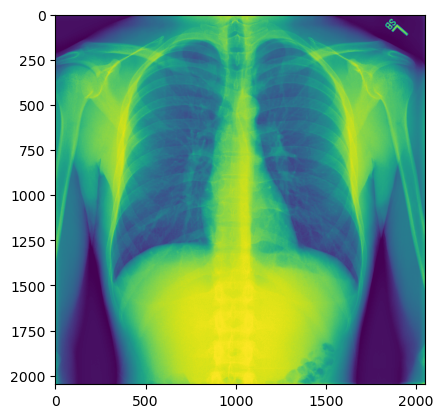

Caption: startseq but clear lungs.                                                                                                                         


In [21]:
z = 2000
pic = list(features.keys())[z]
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = features[pic].reshape((1,14))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))

## Thanks a lot for reading all the way

# <font size=4 color='blue'>If you find this notebook useful, leave an upvote, that motivates me to write more such notebooks.</font>